In [156]:
import networkx as nx
from networkx.algorithms.shortest_paths.weighted import dijkstra_path
from networkx.algorithms.shortest_paths.generic import shortest_path_length

import geopandas as gpd
from geopy.distance import geodesic
from shapely.geometry import Point, LineString
import geojson
import osmnx as ox

import pandas as pd
import numpy as np
import math
import json

import gurobipy as gp
from gurobipy import GRB

from tqdm import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

from keplergl import KeplerGl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [4]:
zones = gpd.read_file('taxi_zones/taxi_zones.shp')
table = pd.read_csv('taxi+_zone_lookup.csv')
zones = zones.to_crs("EPSG:4326")

In [5]:
def dist(pt1, pt2):
    return geodesic(pt1, pt2).miles

In [67]:
zones['Centroid'] = zones['geometry'].apply(lambda x: x.centroid)
x_list = [(lon, lat) for (lon, lat) in zones['Centroid'].apply(lambda x: (x.xy[1][0], x.xy[0][0]))]
pi_list = [geometry.area for geometry in zones['geometry']]
dQ = dist

epsilon = 0.5
delta = 1.1

## Greedy Geometric Spanner Algorithm

In [56]:
G = nx.Graph()
n = len(x_list)
G.add_nodes_from(range(n))
weighted_edges = [(i, j, dQ(x_list[i], x_list[j])) for i in range(n) for j in range(n)]
G.add_weighted_edges_from(weighted_edges)

sorted_edges = sorted(weighted_edges, key=lambda x: x[2])
spanner = nx.Graph()
spanner.add_nodes_from(range(n))
stretch = 1.1
for edge in tqdm(sorted_edges):
    source, target, weight = edge
    if not nx.has_path(spanner, source, target):
        spanner.add_weighted_edges_from([edge])
    else:
        spanner_weight = shortest_path_length(spanner, source, target, weight='weight')
        if spanner_weight < weight * stretch:
            continue
        else:
            spanner.add_weighted_edges_from([edge])

100%|██████████| 69169/69169 [01:26<00:00, 800.31it/s] 


In [60]:
# Verify the constructed graph spanner
for edge in weighted_edges:
    source, target, weight = edge
    spanner_weight = shortest_path_length(spanner, source, target, weight='weight')
    if spanner_weight > weight * 1.1:
        print('invalid')

In [157]:
len(G.edges)

34716

In [144]:
len(spanner.edges)

1373

In [148]:
num_edge_list = []
for stretch in tqdm(np.arange(1, 2.01, 0.01)):
    G = nx.Graph()
    n = len(x_list)
    G.add_nodes_from(range(n))
    weighted_edges = [(i, j, dQ(x_list[i], x_list[j])) for i in range(n) for j in range(n)]
    G.add_weighted_edges_from(weighted_edges)

    sorted_edges = sorted(weighted_edges, key=lambda x: x[2])
    spanner = nx.Graph()
    spanner.add_nodes_from(range(n))
    for edge in tqdm(sorted_edges):
        source, target, weight = edge
        if not nx.has_path(spanner, source, target):
            spanner.add_weighted_edges_from([edge])
        else:
            spanner_weight = shortest_path_length(spanner, source, target, weight='weight')
            if spanner_weight < weight * stretch:
                continue
            else:
                spanner.add_weighted_edges_from([edge])
    num_edge_list.append(len(spanner.edges))



  0%|          | 0/101 [00:00<?, ?it/s]


  0%|          | 0/69169 [00:00<?, ?it/s]


  2%|▏         | 1590/69169 [00:00<00:04, 15892.10it/s]


  3%|▎         | 2181/69169 [00:00<00:06, 10547.25it/s]


  4%|▍         | 2693/69169 [00:00<00:08, 7654.24it/s] 


  5%|▍         | 3191/69169 [00:00<00:11, 5922.75it/s]


  5%|▌         | 3656/69169 [00:00<00:13, 4799.07it/s]


  6%|▌         | 4082/69169 [00:00<00:17, 3823.90it/s]


  6%|▋         | 4458/69169 [00:00<00:19, 3349.82it/s]


  7%|▋         | 4799/69169 [00:01<00:23, 2739.22it/s]


  7%|▋         | 5096/69169 [00:01<00:26, 2417.48it/s]


  8%|▊         | 5361/69169 [00:01<00:30, 2090.82it/s]


  8%|▊         | 5594/69169 [00:01<00:34, 1839.04it/s]


  8%|▊         | 5800/69169 [00:01<00:37, 1672.32it/s]


  9%|▊         | 5986/69169 [00:01<00:41, 1521.18it/s]


  9%|▉         | 6154/69169 [00:02<00:49, 1279.05it/s]


  9%|▉         | 6300/69169 [00:02<00:54, 1161.96it/s]


  9%|▉         | 6431/69169 [00:02<00:58, 1078.51it/s]

 22%|██▏       | 15298/69169 [00:28<05:55, 151.55it/s]


 22%|██▏       | 15314/69169 [00:28<06:09, 145.77it/s]


 22%|██▏       | 15329/69169 [00:28<06:22, 140.75it/s]


 22%|██▏       | 15347/69169 [00:28<06:06, 146.98it/s]


 22%|██▏       | 15364/69169 [00:28<05:51, 153.19it/s]


 22%|██▏       | 15392/69169 [00:28<05:04, 176.48it/s]


 22%|██▏       | 15412/69169 [00:28<05:05, 176.13it/s]


 22%|██▏       | 15435/69169 [00:29<04:45, 188.49it/s]


 22%|██▏       | 15455/69169 [00:29<04:46, 187.69it/s]


 22%|██▏       | 15479/69169 [00:29<04:28, 200.05it/s]


 22%|██▏       | 15500/69169 [00:29<04:31, 197.33it/s]


 22%|██▏       | 15521/69169 [00:29<04:28, 199.76it/s]


 22%|██▏       | 15543/69169 [00:29<04:21, 204.82it/s]


 23%|██▎       | 15571/69169 [00:29<04:01, 221.53it/s]


 23%|██▎       | 15594/69169 [00:29<04:08, 215.97it/s]


 23%|██▎       | 15620/69169 [00:29<03:56, 226.90it/s]


 23%|██▎       | 15644/69169 [00:29<04:12, 211.59it/s]


 23%|██▎       | 15666/69169 [0

 28%|██▊       | 19623/69169 [00:55<06:42, 123.17it/s]


 28%|██▊       | 19638/69169 [00:55<06:28, 127.62it/s]


 28%|██▊       | 19654/69169 [00:56<06:06, 134.99it/s]


 28%|██▊       | 19669/69169 [00:56<05:57, 138.33it/s]


 28%|██▊       | 19684/69169 [00:56<06:25, 128.24it/s]


 28%|██▊       | 19698/69169 [00:56<06:50, 120.55it/s]


 28%|██▊       | 19713/69169 [00:56<06:26, 127.91it/s]


 29%|██▊       | 19727/69169 [00:56<06:44, 122.15it/s]


 29%|██▊       | 19740/69169 [00:56<07:12, 114.30it/s]


 29%|██▊       | 19752/69169 [00:56<07:07, 115.67it/s]


 29%|██▊       | 19764/69169 [00:56<07:07, 115.54it/s]


 29%|██▊       | 19776/69169 [00:57<07:16, 113.22it/s]


 29%|██▊       | 19792/69169 [00:57<06:42, 122.81it/s]


 29%|██▊       | 19806/69169 [00:57<06:30, 126.55it/s]


 29%|██▊       | 19819/69169 [00:57<06:32, 125.58it/s]


 29%|██▊       | 19833/69169 [00:57<06:26, 127.73it/s]


 29%|██▊       | 19850/69169 [00:57<06:04, 135.32it/s]


 29%|██▊       | 19866/69169 [0

 33%|███▎      | 22761/69169 [01:23<06:47, 113.97it/s]


 33%|███▎      | 22773/69169 [01:23<06:57, 111.17it/s]


 33%|███▎      | 22785/69169 [01:23<07:25, 104.03it/s]


 33%|███▎      | 22796/69169 [01:23<07:30, 102.97it/s]


 33%|███▎      | 22807/69169 [01:23<07:26, 103.77it/s]


 33%|███▎      | 22818/69169 [01:24<07:47, 99.13it/s] 


 33%|███▎      | 22829/69169 [01:24<07:45, 99.50it/s]


 33%|███▎      | 22840/69169 [01:24<07:44, 99.79it/s]


 33%|███▎      | 22851/69169 [01:24<07:53, 97.88it/s]


 33%|███▎      | 22864/69169 [01:24<07:29, 103.10it/s]


 33%|███▎      | 22875/69169 [01:24<07:30, 102.81it/s]


 33%|███▎      | 22886/69169 [01:24<07:24, 104.21it/s]


 33%|███▎      | 22897/69169 [01:24<07:29, 102.98it/s]


 33%|███▎      | 22909/69169 [01:24<07:11, 107.17it/s]


 33%|███▎      | 22920/69169 [01:25<07:28, 103.13it/s]


 33%|███▎      | 22931/69169 [01:25<08:01, 95.93it/s] 


 33%|███▎      | 22941/69169 [01:25<08:16, 93.05it/s]


 33%|███▎      | 22951/69169 [01:25

 37%|███▋      | 25461/69169 [01:51<08:10, 89.06it/s]


 37%|███▋      | 25473/69169 [01:51<07:45, 93.90it/s]


 37%|███▋      | 25483/69169 [01:51<08:13, 88.56it/s]


 37%|███▋      | 25492/69169 [01:51<08:23, 86.69it/s]


 37%|███▋      | 25505/69169 [01:52<07:38, 95.32it/s]


 37%|███▋      | 25515/69169 [01:52<07:57, 91.38it/s]


 37%|███▋      | 25525/69169 [01:52<07:50, 92.74it/s]


 37%|███▋      | 25535/69169 [01:52<08:08, 89.28it/s]


 37%|███▋      | 25545/69169 [01:52<08:06, 89.72it/s]


 37%|███▋      | 25555/69169 [01:52<07:54, 91.90it/s]


 37%|███▋      | 25565/69169 [01:52<07:50, 92.74it/s]


 37%|███▋      | 25575/69169 [01:52<07:53, 92.06it/s]


 37%|███▋      | 25585/69169 [01:52<07:49, 92.83it/s]


 37%|███▋      | 25595/69169 [01:53<07:40, 94.53it/s]


 37%|███▋      | 25605/69169 [01:53<07:33, 96.10it/s]


 37%|███▋      | 25615/69169 [01:53<07:32, 96.21it/s]


 37%|███▋      | 25626/69169 [01:53<07:28, 97.11it/s]


 37%|███▋      | 25636/69169 [01:53<07:52, 92.11

 40%|████      | 27741/69169 [02:20<13:04, 52.81it/s]


 40%|████      | 27747/69169 [02:20<12:58, 53.23it/s]


 40%|████      | 27754/69169 [02:20<12:22, 55.77it/s]


 40%|████      | 27760/69169 [02:21<12:28, 55.33it/s]


 40%|████      | 27766/69169 [02:21<12:17, 56.12it/s]


 40%|████      | 27773/69169 [02:21<11:42, 58.96it/s]


 40%|████      | 27779/69169 [02:21<12:00, 57.43it/s]


 40%|████      | 27786/69169 [02:21<11:33, 59.64it/s]


 40%|████      | 27794/69169 [02:21<11:07, 61.95it/s]


 40%|████      | 27801/69169 [02:21<11:17, 61.04it/s]


 40%|████      | 27809/69169 [02:21<10:31, 65.46it/s]


 40%|████      | 27816/69169 [02:21<11:34, 59.56it/s]


 40%|████      | 27823/69169 [02:22<13:16, 51.89it/s]


 40%|████      | 27830/69169 [02:22<12:26, 55.36it/s]


 40%|████      | 27838/69169 [02:22<11:20, 60.71it/s]


 40%|████      | 27846/69169 [02:22<10:51, 63.40it/s]


 40%|████      | 27853/69169 [02:22<13:29, 51.04it/s]


 40%|████      | 27859/69169 [02:22<13:54, 49.51

 43%|████▎     | 29594/69169 [02:50<11:34, 57.02it/s]


 43%|████▎     | 29601/69169 [02:51<11:09, 59.13it/s]


 43%|████▎     | 29608/69169 [02:51<10:49, 60.94it/s]


 43%|████▎     | 29615/69169 [02:51<10:32, 62.55it/s]


 43%|████▎     | 29622/69169 [02:51<10:42, 61.59it/s]


 43%|████▎     | 29629/69169 [02:51<10:47, 61.05it/s]


 43%|████▎     | 29636/69169 [02:51<10:47, 61.09it/s]


 43%|████▎     | 29643/69169 [02:51<10:24, 63.30it/s]


 43%|████▎     | 29650/69169 [02:51<11:07, 59.17it/s]


 43%|████▎     | 29657/69169 [02:51<11:21, 58.01it/s]


 43%|████▎     | 29663/69169 [02:52<11:38, 56.57it/s]


 43%|████▎     | 29670/69169 [02:52<11:02, 59.65it/s]


 43%|████▎     | 29677/69169 [02:52<10:34, 62.25it/s]


 43%|████▎     | 29684/69169 [02:52<10:20, 63.59it/s]


 43%|████▎     | 29692/69169 [02:52<09:48, 67.03it/s]


 43%|████▎     | 29699/69169 [02:52<09:52, 66.57it/s]


 43%|████▎     | 29706/69169 [02:52<09:56, 66.19it/s]


 43%|████▎     | 29713/69169 [02:52<10:34, 62.15

 46%|████▌     | 31548/69169 [03:19<07:52, 79.62it/s]


 46%|████▌     | 31557/69169 [03:19<08:31, 73.54it/s]


 46%|████▌     | 31565/69169 [03:19<08:23, 74.67it/s]


 46%|████▌     | 31573/69169 [03:20<08:37, 72.71it/s]


 46%|████▌     | 31581/69169 [03:20<08:30, 73.69it/s]


 46%|████▌     | 31591/69169 [03:20<08:09, 76.74it/s]


 46%|████▌     | 31599/69169 [03:20<08:21, 74.94it/s]


 46%|████▌     | 31607/69169 [03:20<08:25, 74.28it/s]


 46%|████▌     | 31616/69169 [03:20<08:13, 76.05it/s]


 46%|████▌     | 31624/69169 [03:20<08:11, 76.41it/s]


 46%|████▌     | 31632/69169 [03:20<08:36, 72.61it/s]


 46%|████▌     | 31641/69169 [03:21<08:23, 74.54it/s]


 46%|████▌     | 31650/69169 [03:21<08:01, 77.98it/s]


 46%|████▌     | 31658/69169 [03:21<08:10, 76.43it/s]


 46%|████▌     | 31666/69169 [03:21<08:25, 74.20it/s]


 46%|████▌     | 31674/69169 [03:21<08:29, 73.59it/s]


 46%|████▌     | 31682/69169 [03:21<08:59, 69.50it/s]


 46%|████▌     | 31691/69169 [03:21<08:41, 71.88

 48%|████▊     | 33435/69169 [03:48<10:50, 54.97it/s]


 48%|████▊     | 33443/69169 [03:48<10:11, 58.46it/s]


 48%|████▊     | 33449/69169 [03:48<10:09, 58.61it/s]


 48%|████▊     | 33456/69169 [03:48<09:40, 61.57it/s]


 48%|████▊     | 33463/69169 [03:49<09:51, 60.34it/s]


 48%|████▊     | 33470/69169 [03:49<09:55, 59.97it/s]


 48%|████▊     | 33477/69169 [03:49<10:06, 58.90it/s]


 48%|████▊     | 33485/69169 [03:49<09:24, 63.17it/s]


 48%|████▊     | 33492/69169 [03:49<09:38, 61.66it/s]


 48%|████▊     | 33499/69169 [03:49<09:36, 61.85it/s]


 48%|████▊     | 33506/69169 [03:49<09:25, 63.08it/s]


 48%|████▊     | 33513/69169 [03:49<10:09, 58.48it/s]


 48%|████▊     | 33520/69169 [03:50<09:58, 59.56it/s]


 48%|████▊     | 33527/69169 [03:50<09:33, 62.13it/s]


 48%|████▊     | 33534/69169 [03:50<09:36, 61.80it/s]


 48%|████▊     | 33541/69169 [03:50<09:24, 63.10it/s]


 49%|████▊     | 33548/69169 [03:50<09:27, 62.80it/s]


 49%|████▊     | 33555/69169 [03:50<09:10, 64.69

 51%|█████     | 35264/69169 [04:17<09:43, 58.14it/s]


 51%|█████     | 35270/69169 [04:17<09:46, 57.79it/s]


 51%|█████     | 35276/69169 [04:17<09:42, 58.15it/s]


 51%|█████     | 35282/69169 [04:17<09:47, 57.70it/s]


 51%|█████     | 35288/69169 [04:17<10:30, 53.70it/s]


 51%|█████     | 35294/69169 [04:17<10:46, 52.38it/s]


 51%|█████     | 35300/69169 [04:18<11:04, 50.95it/s]


 51%|█████     | 35307/69169 [04:18<10:18, 54.75it/s]


 51%|█████     | 35315/69169 [04:18<09:40, 58.28it/s]


 51%|█████     | 35323/69169 [04:18<09:20, 60.42it/s]


 51%|█████     | 35330/69169 [04:18<09:39, 58.38it/s]


 51%|█████     | 35337/69169 [04:18<09:27, 59.60it/s]


 51%|█████     | 35344/69169 [04:18<09:14, 61.04it/s]


 51%|█████     | 35353/69169 [04:18<08:33, 65.89it/s]


 51%|█████     | 35360/69169 [04:18<08:34, 65.71it/s]


 51%|█████     | 35367/69169 [04:19<08:40, 64.91it/s]


 51%|█████     | 35375/69169 [04:19<08:26, 66.75it/s]


 51%|█████     | 35383/69169 [04:19<08:08, 69.11

 53%|█████▎    | 36955/69169 [04:46<09:13, 58.25it/s]


 53%|█████▎    | 36961/69169 [04:46<09:30, 56.46it/s]


 53%|█████▎    | 36967/69169 [04:46<10:01, 53.54it/s]


 53%|█████▎    | 36973/69169 [04:46<09:59, 53.70it/s]


 53%|█████▎    | 36979/69169 [04:46<09:46, 54.85it/s]


 53%|█████▎    | 36985/69169 [04:46<09:36, 55.80it/s]


 53%|█████▎    | 36992/69169 [04:46<09:33, 56.08it/s]


 53%|█████▎    | 36998/69169 [04:47<09:25, 56.88it/s]


 53%|█████▎    | 37004/69169 [04:47<09:42, 55.18it/s]


 54%|█████▎    | 37011/69169 [04:47<09:06, 58.82it/s]


 54%|█████▎    | 37017/69169 [04:47<09:16, 57.76it/s]


 54%|█████▎    | 37023/69169 [04:47<09:14, 57.99it/s]


 54%|█████▎    | 37031/69169 [04:47<08:51, 60.44it/s]


 54%|█████▎    | 37038/69169 [04:47<08:41, 61.65it/s]


 54%|█████▎    | 37045/69169 [04:47<08:58, 59.69it/s]


 54%|█████▎    | 37052/69169 [04:47<09:06, 58.78it/s]


 54%|█████▎    | 37059/69169 [04:48<08:56, 59.88it/s]


 54%|█████▎    | 37066/69169 [04:48<09:21, 57.13

 56%|█████▌    | 38561/69169 [05:15<09:22, 54.37it/s]


 56%|█████▌    | 38567/69169 [05:15<09:24, 54.21it/s]


 56%|█████▌    | 38574/69169 [05:15<08:55, 57.09it/s]


 56%|█████▌    | 38580/69169 [05:15<09:21, 54.52it/s]


 56%|█████▌    | 38586/69169 [05:15<09:31, 53.47it/s]


 56%|█████▌    | 38592/69169 [05:15<09:36, 53.05it/s]


 56%|█████▌    | 38598/69169 [05:15<09:50, 51.81it/s]


 56%|█████▌    | 38604/69169 [05:15<09:29, 53.63it/s]


 56%|█████▌    | 38611/69169 [05:16<09:10, 55.47it/s]


 56%|█████▌    | 38617/69169 [05:16<09:02, 56.33it/s]


 56%|█████▌    | 38623/69169 [05:16<09:13, 55.15it/s]


 56%|█████▌    | 38630/69169 [05:16<08:44, 58.26it/s]


 56%|█████▌    | 38636/69169 [05:16<08:43, 58.29it/s]


 56%|█████▌    | 38642/69169 [05:16<08:47, 57.91it/s]


 56%|█████▌    | 38650/69169 [05:16<08:16, 61.48it/s]


 56%|█████▌    | 38657/69169 [05:16<08:40, 58.63it/s]


 56%|█████▌    | 38663/69169 [05:16<08:38, 58.84it/s]


 56%|█████▌    | 38669/69169 [05:16<08:57, 56.75

 58%|█████▊    | 40066/69169 [05:44<10:03, 48.24it/s]


 58%|█████▊    | 40071/69169 [05:44<10:06, 47.94it/s]


 58%|█████▊    | 40077/69169 [05:44<09:56, 48.74it/s]


 58%|█████▊    | 40082/69169 [05:44<10:00, 48.48it/s]


 58%|█████▊    | 40087/69169 [05:44<10:19, 46.93it/s]


 58%|█████▊    | 40092/69169 [05:44<10:49, 44.80it/s]


 58%|█████▊    | 40098/69169 [05:44<10:25, 46.51it/s]


 58%|█████▊    | 40103/69169 [05:45<10:12, 47.44it/s]


 58%|█████▊    | 40108/69169 [05:45<10:09, 47.69it/s]


 58%|█████▊    | 40114/69169 [05:45<09:50, 49.24it/s]


 58%|█████▊    | 40120/69169 [05:45<09:19, 51.93it/s]


 58%|█████▊    | 40126/69169 [05:45<09:55, 48.74it/s]


 58%|█████▊    | 40131/69169 [05:45<10:02, 48.16it/s]


 58%|█████▊    | 40136/69169 [05:45<11:03, 43.79it/s]


 58%|█████▊    | 40143/69169 [05:45<10:10, 47.57it/s]


 58%|█████▊    | 40148/69169 [05:46<10:20, 46.76it/s]


 58%|█████▊    | 40153/69169 [05:46<10:20, 46.79it/s]


 58%|█████▊    | 40158/69169 [05:46<10:34, 45.73

 60%|██████    | 41508/69169 [06:13<10:12, 45.20it/s]


 60%|██████    | 41513/69169 [06:13<10:04, 45.73it/s]


 60%|██████    | 41518/69169 [06:13<10:15, 44.93it/s]


 60%|██████    | 41523/69169 [06:13<10:02, 45.92it/s]


 60%|██████    | 41528/69169 [06:14<10:11, 45.19it/s]


 60%|██████    | 41533/69169 [06:14<10:10, 45.24it/s]


 60%|██████    | 41539/69169 [06:14<09:29, 48.47it/s]


 60%|██████    | 41544/69169 [06:14<09:37, 47.81it/s]


 60%|██████    | 41549/69169 [06:14<09:36, 47.91it/s]


 60%|██████    | 41555/69169 [06:14<09:07, 50.43it/s]


 60%|██████    | 41561/69169 [06:14<09:24, 48.91it/s]


 60%|██████    | 41566/69169 [06:14<09:27, 48.62it/s]


 60%|██████    | 41571/69169 [06:14<09:55, 46.34it/s]


 60%|██████    | 41576/69169 [06:15<10:13, 44.95it/s]


 60%|██████    | 41582/69169 [06:15<09:30, 48.33it/s]


 60%|██████    | 41588/69169 [06:15<09:25, 48.76it/s]


 60%|██████    | 41594/69169 [06:15<08:53, 51.65it/s]


 60%|██████    | 41600/69169 [06:15<08:45, 52.45

 62%|██████▏   | 42847/69169 [06:42<09:50, 44.58it/s]


 62%|██████▏   | 42852/69169 [06:42<09:35, 45.73it/s]


 62%|██████▏   | 42858/69169 [06:42<09:08, 47.99it/s]


 62%|██████▏   | 42863/69169 [06:42<09:41, 45.25it/s]


 62%|██████▏   | 42868/69169 [06:43<09:26, 46.47it/s]


 62%|██████▏   | 42873/69169 [06:43<09:37, 45.50it/s]


 62%|██████▏   | 42878/69169 [06:43<09:37, 45.54it/s]


 62%|██████▏   | 42883/69169 [06:43<09:34, 45.73it/s]


 62%|██████▏   | 42888/69169 [06:43<09:26, 46.35it/s]


 62%|██████▏   | 42893/69169 [06:43<09:53, 44.27it/s]


 62%|██████▏   | 42899/69169 [06:43<09:35, 45.64it/s]


 62%|██████▏   | 42904/69169 [06:43<09:58, 43.85it/s]


 62%|██████▏   | 42910/69169 [06:43<09:37, 45.44it/s]


 62%|██████▏   | 42915/69169 [06:44<09:51, 44.38it/s]


 62%|██████▏   | 42920/69169 [06:44<10:18, 42.41it/s]


 62%|██████▏   | 42925/69169 [06:44<10:14, 42.73it/s]


 62%|██████▏   | 42930/69169 [06:44<09:51, 44.35it/s]


 62%|██████▏   | 42937/69169 [06:44<09:03, 48.30

 64%|██████▍   | 44149/69169 [07:11<09:58, 41.79it/s]


 64%|██████▍   | 44154/69169 [07:11<09:37, 43.29it/s]


 64%|██████▍   | 44159/69169 [07:11<09:17, 44.83it/s]


 64%|██████▍   | 44165/69169 [07:12<09:02, 46.10it/s]


 64%|██████▍   | 44170/69169 [07:12<09:32, 43.68it/s]


 64%|██████▍   | 44176/69169 [07:12<09:08, 45.57it/s]


 64%|██████▍   | 44181/69169 [07:12<09:14, 45.04it/s]


 64%|██████▍   | 44186/69169 [07:12<09:14, 45.08it/s]


 64%|██████▍   | 44191/69169 [07:12<09:02, 46.01it/s]


 64%|██████▍   | 44196/69169 [07:12<09:12, 45.16it/s]


 64%|██████▍   | 44201/69169 [07:12<09:39, 43.05it/s]


 64%|██████▍   | 44206/69169 [07:13<09:28, 43.88it/s]


 64%|██████▍   | 44211/69169 [07:13<09:13, 45.08it/s]


 64%|██████▍   | 44217/69169 [07:13<08:55, 46.59it/s]


 64%|██████▍   | 44222/69169 [07:13<09:29, 43.82it/s]


 64%|██████▍   | 44227/69169 [07:13<09:56, 41.81it/s]


 64%|██████▍   | 44232/69169 [07:13<09:49, 42.30it/s]


 64%|██████▍   | 44237/69169 [07:13<09:31, 43.60

 66%|██████▌   | 45423/69169 [07:41<09:05, 43.53it/s]


 66%|██████▌   | 45428/69169 [07:41<09:13, 42.88it/s]


 66%|██████▌   | 45433/69169 [07:42<09:31, 41.54it/s]


 66%|██████▌   | 45438/69169 [07:42<09:17, 42.60it/s]


 66%|██████▌   | 45443/69169 [07:42<09:03, 43.65it/s]


 66%|██████▌   | 45448/69169 [07:42<09:09, 43.15it/s]


 66%|██████▌   | 45453/69169 [07:42<09:33, 41.32it/s]


 66%|██████▌   | 45458/69169 [07:42<09:52, 40.00it/s]


 66%|██████▌   | 45463/69169 [07:42<09:35, 41.22it/s]


 66%|██████▌   | 45468/69169 [07:42<09:59, 39.52it/s]


 66%|██████▌   | 45472/69169 [07:42<10:30, 37.57it/s]


 66%|██████▌   | 45476/69169 [07:43<10:35, 37.25it/s]


 66%|██████▌   | 45480/69169 [07:43<10:44, 36.73it/s]


 66%|██████▌   | 45484/69169 [07:43<10:31, 37.51it/s]


 66%|██████▌   | 45489/69169 [07:43<10:26, 37.79it/s]


 66%|██████▌   | 45494/69169 [07:43<10:05, 39.09it/s]


 66%|██████▌   | 45498/69169 [07:43<10:47, 36.55it/s]


 66%|██████▌   | 45503/69169 [07:43<10:28, 37.64

 67%|██████▋   | 46636/69169 [08:11<09:08, 41.09it/s]


 67%|██████▋   | 46642/69169 [08:11<08:38, 43.44it/s]


 67%|██████▋   | 46647/69169 [08:12<08:50, 42.42it/s]


 67%|██████▋   | 46652/69169 [08:12<08:58, 41.85it/s]


 67%|██████▋   | 46657/69169 [08:12<09:01, 41.55it/s]


 67%|██████▋   | 46662/69169 [08:12<08:52, 42.25it/s]


 67%|██████▋   | 46667/69169 [08:12<08:38, 43.44it/s]


 67%|██████▋   | 46672/69169 [08:12<08:31, 43.98it/s]


 67%|██████▋   | 46677/69169 [08:12<08:49, 42.47it/s]


 67%|██████▋   | 46682/69169 [08:12<09:21, 40.04it/s]


 67%|██████▋   | 46687/69169 [08:13<09:05, 41.22it/s]


 68%|██████▊   | 46692/69169 [08:13<09:12, 40.69it/s]


 68%|██████▊   | 46697/69169 [08:13<09:01, 41.52it/s]


 68%|██████▊   | 46702/69169 [08:13<09:05, 41.21it/s]


 68%|██████▊   | 46707/69169 [08:13<09:05, 41.18it/s]


 68%|██████▊   | 46712/69169 [08:13<09:01, 41.44it/s]


 68%|██████▊   | 46717/69169 [08:13<09:02, 41.38it/s]


 68%|██████▊   | 46722/69169 [08:13<08:43, 42.89

 69%|██████▉   | 47791/69169 [08:41<10:40, 33.40it/s]


 69%|██████▉   | 47796/69169 [08:41<10:02, 35.48it/s]


 69%|██████▉   | 47800/69169 [08:42<10:05, 35.30it/s]


 69%|██████▉   | 47804/69169 [08:42<10:23, 34.26it/s]


 69%|██████▉   | 47808/69169 [08:42<10:14, 34.77it/s]


 69%|██████▉   | 47812/69169 [08:42<09:53, 35.97it/s]


 69%|██████▉   | 47816/69169 [08:42<10:12, 34.84it/s]


 69%|██████▉   | 47820/69169 [08:42<10:34, 33.66it/s]


 69%|██████▉   | 47824/69169 [08:42<10:22, 34.28it/s]


 69%|██████▉   | 47829/69169 [08:42<09:58, 35.66it/s]


 69%|██████▉   | 47834/69169 [08:43<09:18, 38.20it/s]


 69%|██████▉   | 47838/69169 [08:43<09:44, 36.47it/s]


 69%|██████▉   | 47843/69169 [08:43<09:06, 39.03it/s]


 69%|██████▉   | 47847/69169 [08:43<09:28, 37.53it/s]


 69%|██████▉   | 47852/69169 [08:43<09:10, 38.75it/s]


 69%|██████▉   | 47857/69169 [08:43<09:04, 39.17it/s]


 69%|██████▉   | 47862/69169 [08:43<09:10, 38.68it/s]


 69%|██████▉   | 47866/69169 [08:43<09:17, 38.21

 71%|███████   | 48891/69169 [09:11<09:34, 35.32it/s]


 71%|███████   | 48895/69169 [09:11<09:21, 36.11it/s]


 71%|███████   | 48900/69169 [09:11<08:55, 37.88it/s]


 71%|███████   | 48905/69169 [09:11<08:17, 40.71it/s]


 71%|███████   | 48910/69169 [09:11<08:45, 38.57it/s]


 71%|███████   | 48914/69169 [09:11<08:44, 38.63it/s]


 71%|███████   | 48918/69169 [09:11<09:22, 36.00it/s]


 71%|███████   | 48922/69169 [09:12<09:20, 36.11it/s]


 71%|███████   | 48926/69169 [09:12<09:24, 35.85it/s]


 71%|███████   | 48932/69169 [09:12<08:40, 38.87it/s]


 71%|███████   | 48936/69169 [09:12<08:47, 38.32it/s]


 71%|███████   | 48940/69169 [09:12<08:55, 37.79it/s]


 71%|███████   | 48944/69169 [09:12<09:13, 36.52it/s]


 71%|███████   | 48948/69169 [09:12<08:59, 37.50it/s]


 71%|███████   | 48952/69169 [09:12<09:12, 36.59it/s]


 71%|███████   | 48957/69169 [09:12<09:05, 37.07it/s]


 71%|███████   | 48961/69169 [09:13<08:53, 37.85it/s]


 71%|███████   | 48965/69169 [09:13<08:53, 37.86

 72%|███████▏  | 49942/69169 [09:40<08:57, 35.76it/s]


 72%|███████▏  | 49946/69169 [09:40<08:42, 36.82it/s]


 72%|███████▏  | 49950/69169 [09:41<08:44, 36.65it/s]


 72%|███████▏  | 49954/69169 [09:41<09:00, 35.53it/s]


 72%|███████▏  | 49958/69169 [09:41<09:14, 34.62it/s]


 72%|███████▏  | 49962/69169 [09:41<09:24, 34.01it/s]


 72%|███████▏  | 49966/69169 [09:41<09:40, 33.09it/s]


 72%|███████▏  | 49970/69169 [09:41<09:13, 34.69it/s]


 72%|███████▏  | 49974/69169 [09:41<09:44, 32.86it/s]


 72%|███████▏  | 49978/69169 [09:41<09:48, 32.60it/s]


 72%|███████▏  | 49982/69169 [09:42<10:02, 31.87it/s]


 72%|███████▏  | 49987/69169 [09:42<09:27, 33.78it/s]


 72%|███████▏  | 49991/69169 [09:42<09:43, 32.88it/s]


 72%|███████▏  | 49995/69169 [09:42<09:39, 33.07it/s]


 72%|███████▏  | 49999/69169 [09:42<09:15, 34.53it/s]


 72%|███████▏  | 50003/69169 [09:42<09:33, 33.43it/s]


 72%|███████▏  | 50007/69169 [09:42<09:36, 33.23it/s]


 72%|███████▏  | 50011/69169 [09:42<09:41, 32.97

 74%|███████▎  | 50987/69169 [10:10<08:39, 35.01it/s]


 74%|███████▎  | 50991/69169 [10:10<08:49, 34.35it/s]


 74%|███████▎  | 50995/69169 [10:10<08:49, 34.31it/s]


 74%|███████▎  | 50999/69169 [10:10<08:36, 35.18it/s]


 74%|███████▎  | 51003/69169 [10:10<08:32, 35.42it/s]


 74%|███████▎  | 51007/69169 [10:11<08:25, 35.90it/s]


 74%|███████▎  | 51011/69169 [10:11<08:41, 34.83it/s]


 74%|███████▍  | 51015/69169 [10:11<08:42, 34.75it/s]


 74%|███████▍  | 51019/69169 [10:11<09:00, 33.57it/s]


 74%|███████▍  | 51023/69169 [10:11<08:43, 34.66it/s]


 74%|███████▍  | 51027/69169 [10:11<08:46, 34.44it/s]


 74%|███████▍  | 51031/69169 [10:11<08:52, 34.04it/s]


 74%|███████▍  | 51035/69169 [10:11<08:40, 34.81it/s]


 74%|███████▍  | 51039/69169 [10:11<08:42, 34.68it/s]


 74%|███████▍  | 51043/69169 [10:12<08:28, 35.67it/s]


 74%|███████▍  | 51047/69169 [10:12<08:32, 35.36it/s]


 74%|███████▍  | 51052/69169 [10:12<08:00, 37.72it/s]


 74%|███████▍  | 51057/69169 [10:12<07:44, 39.02

 75%|███████▌  | 52003/69169 [10:40<09:21, 30.57it/s]


 75%|███████▌  | 52007/69169 [10:40<09:47, 29.22it/s]


 75%|███████▌  | 52011/69169 [10:40<09:21, 30.56it/s]


 75%|███████▌  | 52015/69169 [10:40<09:15, 30.88it/s]


 75%|███████▌  | 52019/69169 [10:41<08:51, 32.30it/s]


 75%|███████▌  | 52023/69169 [10:41<09:18, 30.69it/s]


 75%|███████▌  | 52027/69169 [10:41<09:01, 31.63it/s]


 75%|███████▌  | 52031/69169 [10:41<08:58, 31.84it/s]


 75%|███████▌  | 52035/69169 [10:41<09:04, 31.44it/s]


 75%|███████▌  | 52039/69169 [10:41<09:26, 30.24it/s]


 75%|███████▌  | 52043/69169 [10:41<09:17, 30.70it/s]


 75%|███████▌  | 52047/69169 [10:42<09:29, 30.08it/s]


 75%|███████▌  | 52051/69169 [10:42<09:02, 31.54it/s]


 75%|███████▌  | 52055/69169 [10:42<09:04, 31.43it/s]


 75%|███████▌  | 52059/69169 [10:42<09:15, 30.78it/s]


 75%|███████▌  | 52063/69169 [10:42<09:15, 30.77it/s]


 75%|███████▌  | 52067/69169 [10:42<09:12, 30.95it/s]


 75%|███████▌  | 52071/69169 [10:42<09:13, 30.87

 77%|███████▋  | 53027/69169 [11:11<07:52, 34.19it/s]


 77%|███████▋  | 53031/69169 [11:11<08:06, 33.20it/s]


 77%|███████▋  | 53035/69169 [11:11<07:51, 34.21it/s]


 77%|███████▋  | 53039/69169 [11:11<07:54, 34.01it/s]


 77%|███████▋  | 53043/69169 [11:11<08:02, 33.42it/s]


 77%|███████▋  | 53047/69169 [11:12<08:00, 33.55it/s]


 77%|███████▋  | 53051/69169 [11:12<07:49, 34.35it/s]


 77%|███████▋  | 53055/69169 [11:12<07:57, 33.77it/s]


 77%|███████▋  | 53059/69169 [11:12<07:44, 34.66it/s]


 77%|███████▋  | 53063/69169 [11:12<07:35, 35.36it/s]


 77%|███████▋  | 53067/69169 [11:12<07:46, 34.50it/s]


 77%|███████▋  | 53072/69169 [11:12<07:31, 35.64it/s]


 77%|███████▋  | 53077/69169 [11:12<07:30, 35.74it/s]


 77%|███████▋  | 53081/69169 [11:13<07:35, 35.34it/s]


 77%|███████▋  | 53085/69169 [11:13<07:40, 34.93it/s]


 77%|███████▋  | 53089/69169 [11:13<07:56, 33.72it/s]


 77%|███████▋  | 53093/69169 [11:13<07:44, 34.58it/s]


 77%|███████▋  | 53097/69169 [11:13<07:47, 34.41

 78%|███████▊  | 54027/69169 [11:42<08:13, 30.65it/s]


 78%|███████▊  | 54031/69169 [11:42<07:57, 31.69it/s]


 78%|███████▊  | 54035/69169 [11:42<08:09, 30.94it/s]


 78%|███████▊  | 54039/69169 [11:43<08:19, 30.30it/s]


 78%|███████▊  | 54043/69169 [11:43<08:07, 31.04it/s]


 78%|███████▊  | 54047/69169 [11:43<08:00, 31.50it/s]


 78%|███████▊  | 54051/69169 [11:43<08:13, 30.66it/s]


 78%|███████▊  | 54055/69169 [11:43<08:26, 29.85it/s]


 78%|███████▊  | 54059/69169 [11:43<08:16, 30.43it/s]


 78%|███████▊  | 54063/69169 [11:43<08:19, 30.24it/s]


 78%|███████▊  | 54067/69169 [11:44<08:14, 30.55it/s]


 78%|███████▊  | 54071/69169 [11:44<08:19, 30.22it/s]


 78%|███████▊  | 54075/69169 [11:44<08:46, 28.67it/s]


 78%|███████▊  | 54078/69169 [11:44<08:45, 28.71it/s]


 78%|███████▊  | 54081/69169 [11:44<09:07, 27.54it/s]


 78%|███████▊  | 54084/69169 [11:44<09:20, 26.91it/s]


 78%|███████▊  | 54087/69169 [11:44<09:06, 27.58it/s]


 78%|███████▊  | 54091/69169 [11:44<08:18, 30.24

 80%|███████▉  | 54990/69169 [12:14<07:57, 29.69it/s]


 80%|███████▉  | 54993/69169 [12:14<08:00, 29.48it/s]


 80%|███████▉  | 54996/69169 [12:14<08:09, 28.98it/s]


 80%|███████▉  | 54999/69169 [12:14<08:11, 28.81it/s]


 80%|███████▉  | 55003/69169 [12:14<08:03, 29.33it/s]


 80%|███████▉  | 55007/69169 [12:14<07:59, 29.55it/s]


 80%|███████▉  | 55011/69169 [12:14<08:00, 29.49it/s]


 80%|███████▉  | 55015/69169 [12:15<07:44, 30.45it/s]


 80%|███████▉  | 55019/69169 [12:15<07:27, 31.64it/s]


 80%|███████▉  | 55023/69169 [12:15<07:31, 31.30it/s]


 80%|███████▉  | 55027/69169 [12:15<07:29, 31.43it/s]


 80%|███████▉  | 55031/69169 [12:15<07:12, 32.67it/s]


 80%|███████▉  | 55035/69169 [12:15<07:26, 31.63it/s]


 80%|███████▉  | 55039/69169 [12:15<07:47, 30.22it/s]


 80%|███████▉  | 55043/69169 [12:15<07:39, 30.74it/s]


 80%|███████▉  | 55047/69169 [12:16<07:32, 31.18it/s]


 80%|███████▉  | 55051/69169 [12:16<07:26, 31.65it/s]


 80%|███████▉  | 55055/69169 [12:16<07:10, 32.77

 81%|████████  | 55890/69169 [12:45<07:18, 30.28it/s]


 81%|████████  | 55894/69169 [12:45<07:18, 30.29it/s]


 81%|████████  | 55898/69169 [12:45<07:46, 28.45it/s]


 81%|████████  | 55901/69169 [12:45<07:57, 27.78it/s]


 81%|████████  | 55905/69169 [12:46<07:22, 29.98it/s]


 81%|████████  | 55909/69169 [12:46<07:24, 29.85it/s]


 81%|████████  | 55913/69169 [12:46<07:33, 29.21it/s]


 81%|████████  | 55916/69169 [12:46<07:38, 28.93it/s]


 81%|████████  | 55920/69169 [12:46<07:16, 30.38it/s]


 81%|████████  | 55924/69169 [12:46<07:26, 29.65it/s]


 81%|████████  | 55927/69169 [12:46<07:46, 28.37it/s]


 81%|████████  | 55931/69169 [12:47<07:42, 28.64it/s]


 81%|████████  | 55935/69169 [12:47<07:19, 30.09it/s]


 81%|████████  | 55939/69169 [12:47<07:31, 29.27it/s]


 81%|████████  | 55943/69169 [12:47<07:30, 29.37it/s]


 81%|████████  | 55946/69169 [12:47<07:33, 29.14it/s]


 81%|████████  | 55949/69169 [12:47<07:46, 28.34it/s]


 81%|████████  | 55952/69169 [12:47<07:50, 28.07

 82%|████████▏ | 56809/69169 [13:16<07:07, 28.91it/s]


 82%|████████▏ | 56812/69169 [13:16<07:14, 28.42it/s]


 82%|████████▏ | 56815/69169 [13:16<07:10, 28.71it/s]


 82%|████████▏ | 56818/69169 [13:17<07:22, 27.91it/s]


 82%|████████▏ | 56821/69169 [13:17<07:18, 28.14it/s]


 82%|████████▏ | 56824/69169 [13:17<07:15, 28.33it/s]


 82%|████████▏ | 56827/69169 [13:17<07:13, 28.45it/s]


 82%|████████▏ | 56831/69169 [13:17<07:00, 29.36it/s]


 82%|████████▏ | 56835/69169 [13:17<06:41, 30.71it/s]


 82%|████████▏ | 56839/69169 [13:17<06:25, 31.96it/s]


 82%|████████▏ | 56843/69169 [13:17<06:43, 30.52it/s]


 82%|████████▏ | 56847/69169 [13:17<06:55, 29.66it/s]


 82%|████████▏ | 56850/69169 [13:18<06:56, 29.56it/s]


 82%|████████▏ | 56853/69169 [13:18<06:56, 29.54it/s]


 82%|████████▏ | 56856/69169 [13:18<07:13, 28.43it/s]


 82%|████████▏ | 56859/69169 [13:18<07:08, 28.74it/s]


 82%|████████▏ | 56863/69169 [13:18<07:01, 29.23it/s]


 82%|████████▏ | 56866/69169 [13:18<07:09, 28.67

 83%|████████▎ | 57645/69169 [13:46<07:32, 25.46it/s]


 83%|████████▎ | 57648/69169 [13:46<07:28, 25.70it/s]


 83%|████████▎ | 57651/69169 [13:46<07:38, 25.13it/s]


 83%|████████▎ | 57656/69169 [13:46<06:54, 27.76it/s]


 83%|████████▎ | 57659/69169 [13:46<07:07, 26.90it/s]


 83%|████████▎ | 57662/69169 [13:46<07:13, 26.54it/s]


 83%|████████▎ | 57665/69169 [13:46<07:16, 26.37it/s]


 83%|████████▎ | 57669/69169 [13:47<06:51, 27.93it/s]


 83%|████████▎ | 57672/69169 [13:47<07:10, 26.70it/s]


 83%|████████▎ | 57676/69169 [13:47<06:32, 29.28it/s]


 83%|████████▎ | 57680/69169 [13:47<06:52, 27.89it/s]


 83%|████████▎ | 57683/69169 [13:47<06:57, 27.52it/s]


 83%|████████▎ | 57686/69169 [13:47<07:03, 27.13it/s]


 83%|████████▎ | 57689/69169 [13:47<07:07, 26.83it/s]


 83%|████████▎ | 57692/69169 [13:47<07:17, 26.24it/s]


 83%|████████▎ | 57695/69169 [13:48<07:01, 27.19it/s]


 83%|████████▎ | 57698/69169 [13:48<07:02, 27.13it/s]


 83%|████████▎ | 57701/69169 [13:48<06:56, 27.50

 85%|████████▍ | 58487/69169 [14:15<06:22, 27.95it/s]


 85%|████████▍ | 58490/69169 [14:16<06:33, 27.12it/s]


 85%|████████▍ | 58493/69169 [14:16<06:36, 26.93it/s]


 85%|████████▍ | 58496/69169 [14:16<06:36, 26.91it/s]


 85%|████████▍ | 58500/69169 [14:16<06:28, 27.48it/s]


 85%|████████▍ | 58503/69169 [14:16<06:19, 28.09it/s]


 85%|████████▍ | 58507/69169 [14:16<06:18, 28.17it/s]


 85%|████████▍ | 58510/69169 [14:16<06:27, 27.49it/s]


 85%|████████▍ | 58513/69169 [14:16<06:19, 28.05it/s]


 85%|████████▍ | 58516/69169 [14:17<06:27, 27.49it/s]


 85%|████████▍ | 58519/69169 [14:17<06:35, 26.96it/s]


 85%|████████▍ | 58523/69169 [14:17<06:29, 27.37it/s]


 85%|████████▍ | 58527/69169 [14:17<06:04, 29.22it/s]


 85%|████████▍ | 58531/69169 [14:17<05:53, 30.09it/s]


 85%|████████▍ | 58535/69169 [14:17<06:16, 28.28it/s]


 85%|████████▍ | 58538/69169 [14:17<06:15, 28.30it/s]


 85%|████████▍ | 58541/69169 [14:17<06:28, 27.37it/s]


 85%|████████▍ | 58544/69169 [14:17<06:20, 27.92

 86%|████████▌ | 59305/69169 [14:45<05:42, 28.79it/s]


 86%|████████▌ | 59308/69169 [14:45<05:52, 28.01it/s]


 86%|████████▌ | 59311/69169 [14:46<06:04, 27.04it/s]


 86%|████████▌ | 59314/69169 [14:46<06:04, 27.02it/s]


 86%|████████▌ | 59317/69169 [14:46<06:17, 26.13it/s]


 86%|████████▌ | 59320/69169 [14:46<06:26, 25.46it/s]


 86%|████████▌ | 59323/69169 [14:46<06:28, 25.32it/s]


 86%|████████▌ | 59327/69169 [14:46<06:17, 26.09it/s]


 86%|████████▌ | 59330/69169 [14:46<06:14, 26.28it/s]


 86%|████████▌ | 59333/69169 [14:46<06:26, 25.44it/s]


 86%|████████▌ | 59336/69169 [14:47<06:17, 26.06it/s]


 86%|████████▌ | 59339/69169 [14:47<06:22, 25.71it/s]


 86%|████████▌ | 59342/69169 [14:47<06:10, 26.52it/s]


 86%|████████▌ | 59345/69169 [14:47<06:28, 25.30it/s]


 86%|████████▌ | 59348/69169 [14:47<06:14, 26.24it/s]


 86%|████████▌ | 59351/69169 [14:47<06:32, 25.04it/s]


 86%|████████▌ | 59354/69169 [14:47<06:26, 25.41it/s]


 86%|████████▌ | 59357/69169 [14:47<06:29, 25.21

 87%|████████▋ | 60106/69169 [15:15<05:32, 27.23it/s]


 87%|████████▋ | 60110/69169 [15:15<05:20, 28.24it/s]


 87%|████████▋ | 60113/69169 [15:15<05:33, 27.17it/s]


 87%|████████▋ | 60117/69169 [15:15<05:18, 28.38it/s]


 87%|████████▋ | 60120/69169 [15:15<05:43, 26.32it/s]


 87%|████████▋ | 60124/69169 [15:16<05:16, 28.55it/s]


 87%|████████▋ | 60127/69169 [15:16<05:32, 27.16it/s]


 87%|████████▋ | 60130/69169 [15:16<05:43, 26.30it/s]


 87%|████████▋ | 60133/69169 [15:16<05:31, 27.29it/s]


 87%|████████▋ | 60136/69169 [15:16<05:43, 26.26it/s]


 87%|████████▋ | 60140/69169 [15:16<05:35, 26.92it/s]


 87%|████████▋ | 60143/69169 [15:16<05:38, 26.63it/s]


 87%|████████▋ | 60146/69169 [15:16<05:45, 26.15it/s]


 87%|████████▋ | 60150/69169 [15:16<05:16, 28.52it/s]


 87%|████████▋ | 60153/69169 [15:17<05:35, 26.85it/s]


 87%|████████▋ | 60156/69169 [15:17<05:34, 26.93it/s]


 87%|████████▋ | 60159/69169 [15:17<05:31, 27.19it/s]


 87%|████████▋ | 60163/69169 [15:17<05:16, 28.47

 88%|████████▊ | 60889/69169 [15:45<06:11, 22.29it/s]


 88%|████████▊ | 60892/69169 [15:46<05:49, 23.68it/s]


 88%|████████▊ | 60895/69169 [15:46<06:07, 22.52it/s]


 88%|████████▊ | 60898/69169 [15:46<05:51, 23.50it/s]


 88%|████████▊ | 60901/69169 [15:46<05:46, 23.88it/s]


 88%|████████▊ | 60904/69169 [15:46<05:31, 24.94it/s]


 88%|████████▊ | 60908/69169 [15:46<05:12, 26.46it/s]


 88%|████████▊ | 60911/69169 [15:46<05:14, 26.24it/s]


 88%|████████▊ | 60914/69169 [15:46<05:03, 27.20it/s]


 88%|████████▊ | 60917/69169 [15:46<05:11, 26.48it/s]


 88%|████████▊ | 60920/69169 [15:47<05:11, 26.45it/s]


 88%|████████▊ | 60923/69169 [15:47<05:12, 26.36it/s]


 88%|████████▊ | 60926/69169 [15:47<05:22, 25.53it/s]


 88%|████████▊ | 60930/69169 [15:47<05:07, 26.80it/s]


 88%|████████▊ | 60933/69169 [15:47<05:19, 25.80it/s]


 88%|████████▊ | 60936/69169 [15:47<05:10, 26.48it/s]


 88%|████████▊ | 60939/69169 [15:47<05:09, 26.59it/s]


 88%|████████▊ | 60942/69169 [15:47<05:03, 27.07

 89%|████████▉ | 61672/69169 [16:16<04:53, 25.53it/s]


 89%|████████▉ | 61675/69169 [16:16<04:54, 25.48it/s]


 89%|████████▉ | 61678/69169 [16:16<04:51, 25.69it/s]


 89%|████████▉ | 61681/69169 [16:16<04:52, 25.56it/s]


 89%|████████▉ | 61684/69169 [16:16<04:57, 25.14it/s]


 89%|████████▉ | 61687/69169 [16:16<04:52, 25.57it/s]


 89%|████████▉ | 61690/69169 [16:16<04:54, 25.40it/s]


 89%|████████▉ | 61694/69169 [16:17<04:38, 26.87it/s]


 89%|████████▉ | 61697/69169 [16:17<04:36, 27.01it/s]


 89%|████████▉ | 61700/69169 [16:17<04:42, 26.44it/s]


 89%|████████▉ | 61703/69169 [16:17<04:50, 25.68it/s]


 89%|████████▉ | 61707/69169 [16:17<04:37, 26.89it/s]


 89%|████████▉ | 61710/69169 [16:17<04:50, 25.70it/s]


 89%|████████▉ | 61713/69169 [16:17<04:55, 25.22it/s]


 89%|████████▉ | 61716/69169 [16:17<04:53, 25.35it/s]


 89%|████████▉ | 61719/69169 [16:18<04:56, 25.11it/s]


 89%|████████▉ | 61722/69169 [16:18<05:00, 24.80it/s]


 89%|████████▉ | 61725/69169 [16:18<05:00, 24.76

 90%|█████████ | 62452/69169 [16:47<04:12, 26.56it/s]


 90%|█████████ | 62455/69169 [16:47<04:23, 25.52it/s]


 90%|█████████ | 62458/69169 [16:47<04:36, 24.30it/s]


 90%|█████████ | 62462/69169 [16:47<04:09, 26.91it/s]


 90%|█████████ | 62465/69169 [16:47<04:25, 25.29it/s]


 90%|█████████ | 62468/69169 [16:47<04:28, 24.92it/s]


 90%|█████████ | 62471/69169 [16:47<04:17, 26.00it/s]


 90%|█████████ | 62474/69169 [16:47<04:30, 24.73it/s]


 90%|█████████ | 62477/69169 [16:48<04:29, 24.81it/s]


 90%|█████████ | 62480/69169 [16:48<04:24, 25.31it/s]


 90%|█████████ | 62483/69169 [16:48<04:19, 25.79it/s]


 90%|█████████ | 62486/69169 [16:48<04:22, 25.42it/s]


 90%|█████████ | 62489/69169 [16:48<04:16, 26.08it/s]


 90%|█████████ | 62492/69169 [16:48<04:17, 25.90it/s]


 90%|█████████ | 62495/69169 [16:48<04:24, 25.28it/s]


 90%|█████████ | 62498/69169 [16:48<04:24, 25.22it/s]


 90%|█████████ | 62501/69169 [16:49<04:19, 25.69it/s]


 90%|█████████ | 62504/69169 [16:49<04:28, 24.80

 91%|█████████▏| 63229/69169 [17:17<04:19, 22.85it/s]


 91%|█████████▏| 63232/69169 [17:17<04:24, 22.43it/s]


 91%|█████████▏| 63235/69169 [17:18<04:22, 22.65it/s]


 91%|█████████▏| 63239/69169 [17:18<04:04, 24.27it/s]


 91%|█████████▏| 63242/69169 [17:18<04:08, 23.81it/s]


 91%|█████████▏| 63245/69169 [17:18<04:21, 22.67it/s]


 91%|█████████▏| 63248/69169 [17:18<04:23, 22.50it/s]


 91%|█████████▏| 63251/69169 [17:18<04:07, 23.90it/s]


 91%|█████████▏| 63254/69169 [17:18<04:11, 23.50it/s]


 91%|█████████▏| 63257/69169 [17:19<04:09, 23.67it/s]


 91%|█████████▏| 63260/69169 [17:19<03:54, 25.20it/s]


 91%|█████████▏| 63263/69169 [17:19<04:03, 24.27it/s]


 91%|█████████▏| 63267/69169 [17:19<03:50, 25.56it/s]


 91%|█████████▏| 63270/69169 [17:19<03:45, 26.17it/s]


 91%|█████████▏| 63273/69169 [17:19<03:38, 27.00it/s]


 91%|█████████▏| 63276/69169 [17:19<03:35, 27.31it/s]


 91%|█████████▏| 63279/69169 [17:19<03:49, 25.64it/s]


 91%|█████████▏| 63282/69169 [17:19<03:46, 25.93

 93%|█████████▎| 63996/69169 [17:49<03:30, 24.61it/s]


 93%|█████████▎| 63999/69169 [17:49<03:36, 23.87it/s]


 93%|█████████▎| 64002/69169 [17:49<03:36, 23.86it/s]


 93%|█████████▎| 64005/69169 [17:49<03:30, 24.58it/s]


 93%|█████████▎| 64008/69169 [17:49<03:32, 24.24it/s]


 93%|█████████▎| 64012/69169 [17:49<03:19, 25.90it/s]


 93%|█████████▎| 64015/69169 [17:50<03:26, 24.93it/s]


 93%|█████████▎| 64018/69169 [17:50<03:33, 24.09it/s]


 93%|█████████▎| 64021/69169 [17:50<03:33, 24.17it/s]


 93%|█████████▎| 64024/69169 [17:50<03:37, 23.68it/s]


 93%|█████████▎| 64027/69169 [17:50<03:27, 24.78it/s]


 93%|█████████▎| 64030/69169 [17:50<03:31, 24.27it/s]


 93%|█████████▎| 64033/69169 [17:50<03:32, 24.20it/s]


 93%|█████████▎| 64036/69169 [17:50<03:28, 24.64it/s]


 93%|█████████▎| 64039/69169 [17:51<03:29, 24.47it/s]


 93%|█████████▎| 64042/69169 [17:51<03:28, 24.63it/s]


 93%|█████████▎| 64045/69169 [17:51<03:31, 24.28it/s]


 93%|█████████▎| 64048/69169 [17:51<03:30, 24.37

 94%|█████████▎| 64764/69169 [18:20<03:06, 23.65it/s]


 94%|█████████▎| 64767/69169 [18:20<03:06, 23.61it/s]


 94%|█████████▎| 64770/69169 [18:21<03:04, 23.82it/s]


 94%|█████████▎| 64773/69169 [18:21<03:01, 24.24it/s]


 94%|█████████▎| 64776/69169 [18:21<03:04, 23.85it/s]


 94%|█████████▎| 64779/69169 [18:21<03:09, 23.15it/s]


 94%|█████████▎| 64782/69169 [18:21<03:01, 24.23it/s]


 94%|█████████▎| 64785/69169 [18:21<03:05, 23.65it/s]


 94%|█████████▎| 64788/69169 [18:21<03:03, 23.88it/s]


 94%|█████████▎| 64791/69169 [18:21<03:04, 23.73it/s]


 94%|█████████▎| 64794/69169 [18:22<03:10, 22.96it/s]


 94%|█████████▎| 64797/69169 [18:22<03:02, 24.01it/s]


 94%|█████████▎| 64800/69169 [18:22<03:02, 23.95it/s]


 94%|█████████▎| 64803/69169 [18:22<03:04, 23.62it/s]


 94%|█████████▎| 64806/69169 [18:22<03:00, 24.17it/s]


 94%|█████████▎| 64809/69169 [18:22<02:55, 24.82it/s]


 94%|█████████▎| 64812/69169 [18:22<02:59, 24.32it/s]


 94%|█████████▎| 64815/69169 [18:22<03:04, 23.58

 95%|█████████▍| 65523/69169 [18:53<02:40, 22.72it/s]


 95%|█████████▍| 65526/69169 [18:53<02:39, 22.81it/s]


 95%|█████████▍| 65529/69169 [18:53<02:37, 23.11it/s]


 95%|█████████▍| 65532/69169 [18:53<02:36, 23.18it/s]


 95%|█████████▍| 65536/69169 [18:53<02:28, 24.46it/s]


 95%|█████████▍| 65539/69169 [18:53<02:33, 23.72it/s]


 95%|█████████▍| 65542/69169 [18:53<02:34, 23.46it/s]


 95%|█████████▍| 65545/69169 [18:54<02:36, 23.13it/s]


 95%|█████████▍| 65548/69169 [18:54<02:40, 22.62it/s]


 95%|█████████▍| 65551/69169 [18:54<02:39, 22.63it/s]


 95%|█████████▍| 65554/69169 [18:54<02:34, 23.37it/s]


 95%|█████████▍| 65557/69169 [18:54<02:32, 23.64it/s]


 95%|█████████▍| 65560/69169 [18:54<02:30, 23.98it/s]


 95%|█████████▍| 65563/69169 [18:54<02:34, 23.30it/s]


 95%|█████████▍| 65566/69169 [18:54<02:28, 24.23it/s]


 95%|█████████▍| 65569/69169 [18:55<02:34, 23.35it/s]


 95%|█████████▍| 65572/69169 [18:55<02:35, 23.14it/s]


 95%|█████████▍| 65575/69169 [18:55<02:39, 22.50

 96%|█████████▌| 66285/69169 [19:25<02:07, 22.67it/s]


 96%|█████████▌| 66288/69169 [19:25<02:09, 22.26it/s]


 96%|█████████▌| 66291/69169 [19:26<02:09, 22.28it/s]


 96%|█████████▌| 66294/69169 [19:26<02:08, 22.41it/s]


 96%|█████████▌| 66297/69169 [19:26<02:05, 22.93it/s]


 96%|█████████▌| 66300/69169 [19:26<02:02, 23.49it/s]


 96%|█████████▌| 66303/69169 [19:26<02:04, 23.07it/s]


 96%|█████████▌| 66306/69169 [19:26<02:00, 23.67it/s]


 96%|█████████▌| 66309/69169 [19:26<02:00, 23.70it/s]


 96%|█████████▌| 66312/69169 [19:26<02:02, 23.35it/s]


 96%|█████████▌| 66315/69169 [19:27<02:05, 22.82it/s]


 96%|█████████▌| 66318/69169 [19:27<02:05, 22.67it/s]


 96%|█████████▌| 66321/69169 [19:27<02:03, 23.00it/s]


 96%|█████████▌| 66324/69169 [19:27<02:02, 23.13it/s]


 96%|█████████▌| 66327/69169 [19:27<02:02, 23.22it/s]


 96%|█████████▌| 66330/69169 [19:27<02:06, 22.53it/s]


 96%|█████████▌| 66333/69169 [19:27<01:59, 23.73it/s]


 96%|█████████▌| 66336/69169 [19:27<01:59, 23.63

 97%|█████████▋| 67040/69169 [19:59<01:32, 23.09it/s]


 97%|█████████▋| 67043/69169 [19:59<01:30, 23.38it/s]


 97%|█████████▋| 67046/69169 [19:59<01:30, 23.52it/s]


 97%|█████████▋| 67049/69169 [20:00<01:31, 23.20it/s]


 97%|█████████▋| 67052/69169 [20:00<01:30, 23.29it/s]


 97%|█████████▋| 67055/69169 [20:00<01:32, 22.96it/s]


 97%|█████████▋| 67058/69169 [20:00<01:32, 22.92it/s]


 97%|█████████▋| 67061/69169 [20:00<01:32, 22.79it/s]


 97%|█████████▋| 67064/69169 [20:00<01:32, 22.65it/s]


 97%|█████████▋| 67067/69169 [20:00<01:33, 22.55it/s]


 97%|█████████▋| 67070/69169 [20:00<01:31, 22.95it/s]


 97%|█████████▋| 67073/69169 [20:01<01:33, 22.32it/s]


 97%|█████████▋| 67076/69169 [20:01<01:29, 23.37it/s]


 97%|█████████▋| 67079/69169 [20:01<01:31, 22.90it/s]


 97%|█████████▋| 67082/69169 [20:01<01:33, 22.41it/s]


 97%|█████████▋| 67085/69169 [20:01<01:29, 23.30it/s]


 97%|█████████▋| 67088/69169 [20:01<01:32, 22.60it/s]


 97%|█████████▋| 67091/69169 [20:01<01:33, 22.22

 98%|█████████▊| 67796/69169 [20:33<01:04, 21.38it/s]


 98%|█████████▊| 67799/69169 [20:33<01:04, 21.40it/s]


 98%|█████████▊| 67802/69169 [20:33<01:02, 21.80it/s]


 98%|█████████▊| 67805/69169 [20:33<01:03, 21.55it/s]


 98%|█████████▊| 67808/69169 [20:33<01:01, 22.27it/s]


 98%|█████████▊| 67811/69169 [20:34<01:00, 22.61it/s]


 98%|█████████▊| 67814/69169 [20:34<00:59, 22.95it/s]


 98%|█████████▊| 67817/69169 [20:34<01:01, 21.97it/s]


 98%|█████████▊| 67820/69169 [20:34<01:01, 21.90it/s]


 98%|█████████▊| 67823/69169 [20:34<01:03, 21.33it/s]


 98%|█████████▊| 67826/69169 [20:34<01:00, 22.38it/s]


 98%|█████████▊| 67829/69169 [20:34<01:00, 22.05it/s]


 98%|█████████▊| 67832/69169 [20:34<01:02, 21.38it/s]


 98%|█████████▊| 67835/69169 [20:35<01:03, 21.03it/s]


 98%|█████████▊| 67838/69169 [20:35<01:04, 20.68it/s]


 98%|█████████▊| 67841/69169 [20:35<01:06, 20.00it/s]


 98%|█████████▊| 67844/69169 [20:35<01:10, 18.87it/s]


 98%|█████████▊| 67847/69169 [20:35<01:08, 19.41

 99%|█████████▉| 68541/69169 [21:08<00:29, 21.34it/s]


 99%|█████████▉| 68544/69169 [21:08<00:29, 21.17it/s]


 99%|█████████▉| 68547/69169 [21:08<00:29, 21.37it/s]


 99%|█████████▉| 68550/69169 [21:08<00:28, 21.81it/s]


 99%|█████████▉| 68553/69169 [21:08<00:28, 21.60it/s]


 99%|█████████▉| 68556/69169 [21:09<00:28, 21.69it/s]


 99%|█████████▉| 68559/69169 [21:09<00:28, 21.39it/s]


 99%|█████████▉| 68562/69169 [21:09<00:28, 21.14it/s]


 99%|█████████▉| 68565/69169 [21:09<00:28, 21.22it/s]


 99%|█████████▉| 68568/69169 [21:09<00:26, 22.46it/s]


 99%|█████████▉| 68571/69169 [21:09<00:27, 21.55it/s]


 99%|█████████▉| 68574/69169 [21:09<00:27, 21.27it/s]


 99%|█████████▉| 68577/69169 [21:10<00:27, 21.27it/s]


 99%|█████████▉| 68580/69169 [21:10<00:27, 21.25it/s]


 99%|█████████▉| 68583/69169 [21:10<00:27, 21.36it/s]


 99%|█████████▉| 68586/69169 [21:10<00:27, 21.26it/s]


 99%|█████████▉| 68589/69169 [21:10<00:26, 21.77it/s]


 99%|█████████▉| 68592/69169 [21:10<00:27, 20.94

 15%|█▌        | 10657/69169 [00:03<00:41, 1403.17it/s]


 16%|█▌        | 10799/69169 [00:03<00:42, 1375.53it/s]


 16%|█▌        | 10938/69169 [00:04<00:44, 1313.83it/s]


 16%|█▌        | 11071/69169 [00:04<00:46, 1252.72it/s]


 16%|█▌        | 11198/69169 [00:04<00:46, 1246.98it/s]


 16%|█▋        | 11324/69169 [00:04<00:49, 1180.44it/s]


 17%|█▋        | 11452/69169 [00:04<00:47, 1204.06it/s]


 17%|█▋        | 11574/69169 [00:04<00:47, 1201.63it/s]


 17%|█▋        | 11695/69169 [00:04<00:48, 1181.50it/s]


 17%|█▋        | 11821/69169 [00:04<00:47, 1203.10it/s]


 17%|█▋        | 11942/69169 [00:04<00:49, 1159.67it/s]


 17%|█▋        | 12059/69169 [00:04<00:51, 1115.70it/s]


 18%|█▊        | 12174/69169 [00:05<00:50, 1125.15it/s]


 18%|█▊        | 12288/69169 [00:05<00:51, 1107.65it/s]


 18%|█▊        | 12400/69169 [00:05<00:51, 1093.38it/s]


 18%|█▊        | 12510/69169 [00:05<00:52, 1069.21it/s]


 18%|█▊        | 12618/69169 [00:05<00:53, 1051.08it/s]


 18%|█▊       

 40%|███▉      | 27379/69169 [00:29<01:29, 466.89it/s]


 40%|███▉      | 27427/69169 [00:29<01:30, 458.75it/s]


 40%|███▉      | 27474/69169 [00:30<01:31, 456.76it/s]


 40%|███▉      | 27521/69169 [00:30<01:30, 459.34it/s]


 40%|███▉      | 27568/69169 [00:30<01:35, 436.59it/s]


 40%|███▉      | 27623/69169 [00:30<01:29, 464.65it/s]


 40%|████      | 27671/69169 [00:30<01:28, 466.37it/s]


 40%|████      | 27719/69169 [00:30<01:30, 456.94it/s]


 40%|████      | 27767/69169 [00:30<01:29, 460.74it/s]


 40%|████      | 27814/69169 [00:30<01:32, 449.44it/s]


 40%|████      | 27862/69169 [00:30<01:30, 458.04it/s]


 40%|████      | 27909/69169 [00:30<01:32, 445.50it/s]


 40%|████      | 27954/69169 [00:31<01:32, 444.06it/s]


 40%|████      | 27999/69169 [00:31<01:33, 442.44it/s]


 41%|████      | 28044/69169 [00:31<01:34, 434.65it/s]


 41%|████      | 28089/69169 [00:31<01:33, 438.34it/s]


 41%|████      | 28133/69169 [00:31<01:34, 433.96it/s]


 41%|████      | 28180/69169 [0

 53%|█████▎    | 36770/69169 [00:56<01:28, 366.19it/s]


 53%|█████▎    | 36807/69169 [00:56<01:29, 361.37it/s]


 53%|█████▎    | 36844/69169 [00:56<01:29, 360.07it/s]


 53%|█████▎    | 36882/69169 [00:56<01:28, 363.85it/s]


 53%|█████▎    | 36923/69169 [00:56<01:26, 374.17it/s]


 53%|█████▎    | 36961/69169 [00:56<01:27, 366.78it/s]


 53%|█████▎    | 36998/69169 [00:56<01:29, 360.04it/s]


 54%|█████▎    | 37035/69169 [00:56<01:46, 300.99it/s]


 54%|█████▎    | 37071/69169 [00:56<01:42, 314.45it/s]


 54%|█████▎    | 37104/69169 [00:57<01:41, 314.51it/s]


 54%|█████▎    | 37142/69169 [00:57<01:36, 331.57it/s]


 54%|█████▎    | 37178/69169 [00:57<01:34, 337.94it/s]


 54%|█████▍    | 37214/69169 [00:57<01:33, 342.35it/s]


 54%|█████▍    | 37249/69169 [00:57<01:33, 341.58it/s]


 54%|█████▍    | 37284/69169 [00:57<01:34, 335.83it/s]


 54%|█████▍    | 37320/69169 [00:57<01:33, 342.39it/s]


 54%|█████▍    | 37355/69169 [00:57<01:33, 339.90it/s]


 54%|█████▍    | 37390/69169 [0

 66%|██████▌   | 45395/69169 [01:22<01:20, 296.42it/s]


 66%|██████▌   | 45428/69169 [01:22<01:17, 305.62it/s]


 66%|██████▌   | 45459/69169 [01:22<01:17, 305.92it/s]


 66%|██████▌   | 45491/69169 [01:22<01:17, 306.63it/s]


 66%|██████▌   | 45522/69169 [01:22<01:19, 298.52it/s]


 66%|██████▌   | 45552/69169 [01:22<01:22, 284.74it/s]


 66%|██████▌   | 45581/69169 [01:22<01:27, 270.34it/s]


 66%|██████▌   | 45609/69169 [01:22<01:28, 264.91it/s]


 66%|██████▌   | 45636/69169 [01:22<01:31, 255.87it/s]


 66%|██████▌   | 45662/69169 [01:23<01:32, 252.81it/s]


 66%|██████▌   | 45688/69169 [01:23<01:33, 250.71it/s]


 66%|██████▌   | 45714/69169 [01:23<01:35, 245.58it/s]


 66%|██████▌   | 45740/69169 [01:23<01:34, 247.82it/s]


 66%|██████▌   | 45768/69169 [01:23<01:31, 254.75it/s]


 66%|██████▌   | 45800/69169 [01:23<01:26, 271.18it/s]


 66%|██████▋   | 45831/69169 [01:23<01:22, 281.46it/s]


 66%|██████▋   | 45862/69169 [01:23<01:20, 288.81it/s]


 66%|██████▋   | 45899/69169 [0

 76%|███████▋  | 52779/69169 [01:48<01:08, 239.16it/s]


 76%|███████▋  | 52805/69169 [01:48<01:07, 243.58it/s]


 76%|███████▋  | 52830/69169 [01:48<01:09, 236.08it/s]


 76%|███████▋  | 52855/69169 [01:48<01:08, 238.74it/s]


 76%|███████▋  | 52881/69169 [01:48<01:06, 244.60it/s]


 76%|███████▋  | 52907/69169 [01:48<01:05, 246.59it/s]


 77%|███████▋  | 52932/69169 [01:48<01:08, 236.80it/s]


 77%|███████▋  | 52959/69169 [01:49<01:06, 244.41it/s]


 77%|███████▋  | 52986/69169 [01:49<01:04, 250.55it/s]


 77%|███████▋  | 53012/69169 [01:49<01:05, 245.75it/s]


 77%|███████▋  | 53038/69169 [01:49<01:04, 249.04it/s]


 77%|███████▋  | 53064/69169 [01:49<01:06, 241.96it/s]


 77%|███████▋  | 53091/69169 [01:49<01:04, 249.29it/s]


 77%|███████▋  | 53117/69169 [01:49<01:04, 247.03it/s]


 77%|███████▋  | 53145/69169 [01:49<01:03, 253.98it/s]


 77%|███████▋  | 53171/69169 [01:49<01:05, 245.03it/s]


 77%|███████▋  | 53197/69169 [01:49<01:04, 247.98it/s]


 77%|███████▋  | 53224/69169 [0

 86%|████████▌ | 59516/69169 [02:14<00:37, 255.07it/s]


 86%|████████▌ | 59542/69169 [02:14<00:38, 252.59it/s]


 86%|████████▌ | 59568/69169 [02:14<00:37, 252.99it/s]


 86%|████████▌ | 59594/69169 [02:14<00:37, 254.56it/s]


 86%|████████▌ | 59620/69169 [02:14<00:38, 249.18it/s]


 86%|████████▌ | 59646/69169 [02:14<00:37, 250.81it/s]


 86%|████████▋ | 59674/69169 [02:14<00:37, 256.01it/s]


 86%|████████▋ | 59700/69169 [02:15<00:37, 249.55it/s]


 86%|████████▋ | 59726/69169 [02:15<00:37, 249.97it/s]


 86%|████████▋ | 59753/69169 [02:15<00:36, 255.22it/s]


 86%|████████▋ | 59779/69169 [02:15<00:37, 253.27it/s]


 86%|████████▋ | 59805/69169 [02:15<00:36, 254.58it/s]


 86%|████████▋ | 59831/69169 [02:15<00:36, 255.24it/s]


 87%|████████▋ | 59857/69169 [02:15<00:36, 256.37it/s]


 87%|████████▋ | 59883/69169 [02:15<00:36, 252.30it/s]


 87%|████████▋ | 59913/69169 [02:15<00:34, 264.70it/s]


 87%|████████▋ | 59940/69169 [02:15<00:35, 257.48it/s]


 87%|████████▋ | 59969/69169 [0

 95%|█████████▌| 65981/69169 [02:40<00:13, 231.92it/s]


 95%|█████████▌| 66005/69169 [02:40<00:13, 232.72it/s]


 95%|█████████▌| 66029/69169 [02:40<00:13, 234.76it/s]


 95%|█████████▌| 66053/69169 [02:40<00:13, 234.13it/s]


 96%|█████████▌| 66077/69169 [02:40<00:13, 235.26it/s]


 96%|█████████▌| 66102/69169 [02:40<00:12, 237.64it/s]


 96%|█████████▌| 66126/69169 [02:40<00:12, 236.54it/s]


 96%|█████████▌| 66150/69169 [02:41<00:12, 233.30it/s]


 96%|█████████▌| 66174/69169 [02:41<00:13, 228.32it/s]


 96%|█████████▌| 66197/69169 [02:41<00:13, 220.43it/s]


 96%|█████████▌| 66220/69169 [02:41<00:13, 221.09it/s]


 96%|█████████▌| 66245/69169 [02:41<00:12, 227.99it/s]


 96%|█████████▌| 66271/69169 [02:41<00:12, 236.37it/s]


 96%|█████████▌| 66295/69169 [02:41<00:12, 231.46it/s]


 96%|█████████▌| 66322/69169 [02:41<00:11, 241.66it/s]


 96%|█████████▌| 66347/69169 [02:41<00:13, 207.91it/s]


 96%|█████████▌| 66371/69169 [02:42<00:12, 215.87it/s]


 96%|█████████▌| 66394/69169 [0

 28%|██▊       | 19335/69169 [00:11<01:03, 788.58it/s]


 28%|██▊       | 19424/69169 [00:11<01:01, 813.59it/s]


 28%|██▊       | 19506/69169 [00:12<01:03, 778.40it/s]


 28%|██▊       | 19585/69169 [00:12<01:03, 781.03it/s]


 28%|██▊       | 19664/69169 [00:12<01:03, 778.05it/s]


 29%|██▊       | 19743/69169 [00:12<01:09, 716.06it/s]


 29%|██▊       | 19817/69169 [00:12<01:08, 720.69it/s]


 29%|██▉       | 19908/69169 [00:12<01:04, 765.87it/s]


 29%|██▉       | 19986/69169 [00:12<01:04, 763.76it/s]


 29%|██▉       | 20069/69169 [00:12<01:02, 780.26it/s]


 29%|██▉       | 20148/69169 [00:12<01:03, 767.84it/s]


 29%|██▉       | 20226/69169 [00:13<01:04, 761.37it/s]


 29%|██▉       | 20307/69169 [00:13<01:03, 774.19it/s]


 29%|██▉       | 20385/69169 [00:13<01:06, 730.09it/s]


 30%|██▉       | 20470/69169 [00:13<01:04, 760.41it/s]


 30%|██▉       | 20547/69169 [00:13<01:04, 749.16it/s]


 30%|██▉       | 20623/69169 [00:13<01:05, 743.97it/s]


 30%|██▉       | 20698/69169 [0

 50%|████▉     | 34310/69169 [00:37<01:17, 451.96it/s]


 50%|████▉     | 34358/69169 [00:38<01:15, 458.52it/s]


 50%|████▉     | 34404/69169 [00:38<01:16, 454.68it/s]


 50%|████▉     | 34450/69169 [00:38<01:16, 452.31it/s]


 50%|████▉     | 34497/69169 [00:38<01:16, 455.29it/s]


 50%|████▉     | 34543/69169 [00:38<01:23, 416.34it/s]


 50%|█████     | 34586/69169 [00:38<01:25, 403.08it/s]


 50%|█████     | 34630/69169 [00:38<01:23, 411.66it/s]


 50%|█████     | 34679/69169 [00:38<01:19, 431.80it/s]


 50%|█████     | 34724/69169 [00:38<01:19, 435.49it/s]


 50%|█████     | 34768/69169 [00:39<01:19, 430.44it/s]


 50%|█████     | 34812/69169 [00:39<01:22, 417.25it/s]


 50%|█████     | 34855/69169 [00:39<01:23, 409.76it/s]


 50%|█████     | 34901/69169 [00:39<01:21, 420.16it/s]


 51%|█████     | 34944/69169 [00:39<01:21, 418.83it/s]


 51%|█████     | 34987/69169 [00:39<01:21, 416.97it/s]


 51%|█████     | 35029/69169 [00:39<01:21, 417.45it/s]


 51%|█████     | 35071/69169 [0

 65%|██████▌   | 45128/69169 [01:03<00:58, 412.83it/s]


 65%|██████▌   | 45170/69169 [01:04<00:58, 412.31it/s]


 65%|██████▌   | 45212/69169 [01:04<00:57, 413.99it/s]


 65%|██████▌   | 45254/69169 [01:04<00:58, 408.11it/s]


 65%|██████▌   | 45295/69169 [01:04<00:59, 403.81it/s]


 66%|██████▌   | 45336/69169 [01:04<01:01, 390.07it/s]


 66%|██████▌   | 45383/69169 [01:04<00:58, 410.00it/s]


 66%|██████▌   | 45425/69169 [01:04<00:58, 409.13it/s]


 66%|██████▌   | 45467/69169 [01:04<00:58, 404.14it/s]


 66%|██████▌   | 45508/69169 [01:04<00:59, 397.85it/s]


 66%|██████▌   | 45549/69169 [01:04<00:59, 399.94it/s]


 66%|██████▌   | 45590/69169 [01:05<00:59, 398.74it/s]


 66%|██████▌   | 45630/69169 [01:05<01:00, 392.30it/s]


 66%|██████▌   | 45670/69169 [01:05<01:00, 390.55it/s]


 66%|██████▌   | 45711/69169 [01:05<00:59, 393.72it/s]


 66%|██████▌   | 45751/69169 [01:05<00:59, 391.01it/s]


 66%|██████▌   | 45791/69169 [01:05<00:59, 392.22it/s]


 66%|██████▋   | 45831/69169 [0

 79%|███████▉  | 54548/69169 [01:29<00:44, 325.80it/s]


 79%|███████▉  | 54583/69169 [01:29<00:44, 331.31it/s]


 79%|███████▉  | 54622/69169 [01:30<00:42, 346.23it/s]


 79%|███████▉  | 54657/69169 [01:30<00:42, 343.23it/s]


 79%|███████▉  | 54692/69169 [01:30<00:41, 345.22it/s]


 79%|███████▉  | 54727/69169 [01:30<00:41, 345.08it/s]


 79%|███████▉  | 54762/69169 [01:30<00:42, 335.26it/s]


 79%|███████▉  | 54800/69169 [01:30<00:41, 346.88it/s]


 79%|███████▉  | 54835/69169 [01:30<00:41, 346.46it/s]


 79%|███████▉  | 54870/69169 [01:30<00:41, 346.21it/s]


 79%|███████▉  | 54905/69169 [01:30<00:41, 347.12it/s]


 79%|███████▉  | 54940/69169 [01:30<00:42, 337.99it/s]


 79%|███████▉  | 54974/69169 [01:31<00:42, 336.84it/s]


 80%|███████▉  | 55008/69169 [01:31<00:43, 329.30it/s]


 80%|███████▉  | 55043/69169 [01:31<00:42, 333.29it/s]


 80%|███████▉  | 55077/69169 [01:31<00:43, 327.17it/s]


 80%|███████▉  | 55110/69169 [01:31<00:42, 327.46it/s]


 80%|███████▉  | 55143/69169 [0

 91%|█████████ | 62729/69169 [01:55<00:19, 322.84it/s]


 91%|█████████ | 62762/69169 [01:56<00:20, 310.32it/s]


 91%|█████████ | 62795/69169 [01:56<00:20, 314.49it/s]


 91%|█████████ | 62827/69169 [01:56<00:20, 315.10it/s]


 91%|█████████ | 62859/69169 [01:56<00:20, 310.63it/s]


 91%|█████████ | 62891/69169 [01:56<00:20, 307.18it/s]


 91%|█████████ | 62925/69169 [01:56<00:19, 316.12it/s]


 91%|█████████ | 62957/69169 [01:56<00:19, 314.86it/s]


 91%|█████████ | 62992/69169 [01:56<00:19, 322.07it/s]


 91%|█████████ | 63026/69169 [01:56<00:18, 324.77it/s]


 91%|█████████ | 63063/69169 [01:56<00:18, 336.00it/s]


 91%|█████████ | 63097/69169 [01:57<00:18, 331.77it/s]


 91%|█████████▏| 63131/69169 [01:57<00:18, 327.38it/s]


 91%|█████████▏| 63165/69169 [01:57<00:18, 330.53it/s]


 91%|█████████▏| 63199/69169 [01:57<00:18, 316.19it/s]


 91%|█████████▏| 63231/69169 [01:57<00:18, 314.39it/s]


 91%|█████████▏| 63263/69169 [01:57<00:18, 314.95it/s]


 92%|█████████▏| 63295/69169 [0

 19%|█▉        | 13254/69169 [00:04<00:43, 1289.46it/s]


 19%|█▉        | 13384/69169 [00:04<00:43, 1270.84it/s]


 20%|█▉        | 13512/69169 [00:05<00:44, 1260.81it/s]


 20%|█▉        | 13639/69169 [00:05<00:46, 1188.43it/s]


 20%|█▉        | 13765/69169 [00:05<00:45, 1206.30it/s]


 20%|██        | 13887/69169 [00:05<00:46, 1194.99it/s]


 20%|██        | 14008/69169 [00:05<00:49, 1107.72it/s]


 20%|██        | 14121/69169 [00:05<00:50, 1091.99it/s]


 21%|██        | 14232/69169 [00:05<00:50, 1081.18it/s]


 21%|██        | 14342/69169 [00:05<00:50, 1076.46it/s]


 21%|██        | 14463/69169 [00:05<00:49, 1113.13it/s]


 21%|██        | 14586/69169 [00:05<00:47, 1145.33it/s]


 21%|██▏       | 14702/69169 [00:06<00:48, 1133.96it/s]


 21%|██▏       | 14827/69169 [00:06<00:46, 1165.42it/s]


 22%|██▏       | 14951/69169 [00:06<00:45, 1186.24it/s]


 22%|██▏       | 15073/69169 [00:06<00:45, 1194.83it/s]


 22%|██▏       | 15193/69169 [00:06<00:45, 1180.33it/s]


 22%|██▏      

 48%|████▊     | 33258/69169 [00:30<01:01, 582.77it/s]


 48%|████▊     | 33317/69169 [00:30<01:02, 577.41it/s]


 48%|████▊     | 33375/69169 [00:30<01:02, 572.31it/s]


 48%|████▊     | 33433/69169 [00:30<01:02, 568.37it/s]


 48%|████▊     | 33490/69169 [00:31<01:02, 568.41it/s]


 49%|████▊     | 33552/69169 [00:31<01:01, 581.99it/s]


 49%|████▊     | 33611/69169 [00:31<01:01, 574.87it/s]


 49%|████▊     | 33672/69169 [00:31<01:00, 582.28it/s]


 49%|████▉     | 33731/69169 [00:31<01:01, 579.18it/s]


 49%|████▉     | 33798/69169 [00:31<00:58, 603.65it/s]


 49%|████▉     | 33862/69169 [00:31<00:57, 613.14it/s]


 49%|████▉     | 33924/69169 [00:31<00:58, 602.77it/s]


 49%|████▉     | 33987/69169 [00:31<00:57, 608.93it/s]


 49%|████▉     | 34049/69169 [00:31<00:59, 586.73it/s]


 49%|████▉     | 34108/69169 [00:32<01:00, 579.63it/s]


 49%|████▉     | 34174/69169 [00:32<00:58, 600.90it/s]


 49%|████▉     | 34235/69169 [00:32<01:00, 573.81it/s]


 50%|████▉     | 34293/69169 [0

 67%|██████▋   | 46345/69169 [00:56<00:50, 451.45it/s]


 67%|██████▋   | 46391/69169 [00:56<00:50, 453.77it/s]


 67%|██████▋   | 46442/69169 [00:56<00:48, 467.27it/s]


 67%|██████▋   | 46492/69169 [00:56<00:47, 474.55it/s]


 67%|██████▋   | 46540/69169 [00:56<00:48, 467.36it/s]


 67%|██████▋   | 46587/69169 [00:57<00:49, 455.92it/s]


 67%|██████▋   | 46634/69169 [00:57<00:49, 458.80it/s]


 67%|██████▋   | 46685/69169 [00:57<00:47, 471.78it/s]


 68%|██████▊   | 46733/69169 [00:57<00:48, 466.90it/s]


 68%|██████▊   | 46780/69169 [00:57<00:49, 451.74it/s]


 68%|██████▊   | 46831/69169 [00:57<00:47, 465.40it/s]


 68%|██████▊   | 46878/69169 [00:57<00:49, 454.81it/s]


 68%|██████▊   | 46924/69169 [00:57<00:49, 450.84it/s]


 68%|██████▊   | 46972/69169 [00:57<00:48, 457.95it/s]


 68%|██████▊   | 47019/69169 [00:58<00:48, 459.79it/s]


 68%|██████▊   | 47066/69169 [00:58<00:49, 448.29it/s]


 68%|██████▊   | 47111/69169 [00:58<00:49, 442.72it/s]


 68%|██████▊   | 47156/69169 [0

 82%|████████▏ | 57059/69169 [01:22<00:30, 393.74it/s]


 83%|████████▎ | 57099/69169 [01:22<00:31, 383.22it/s]


 83%|████████▎ | 57138/69169 [01:22<00:31, 383.85it/s]


 83%|████████▎ | 57181/69169 [01:22<00:30, 395.80it/s]


 83%|████████▎ | 57221/69169 [01:22<00:31, 383.04it/s]


 83%|████████▎ | 57261/69169 [01:23<00:30, 385.72it/s]


 83%|████████▎ | 57303/69169 [01:23<00:30, 394.47it/s]


 83%|████████▎ | 57343/69169 [01:23<00:29, 394.38it/s]


 83%|████████▎ | 57383/69169 [01:23<00:30, 392.44it/s]


 83%|████████▎ | 57425/69169 [01:23<00:29, 398.77it/s]


 83%|████████▎ | 57465/69169 [01:23<00:29, 398.43it/s]


 83%|████████▎ | 57505/69169 [01:23<00:29, 389.62it/s]


 83%|████████▎ | 57546/69169 [01:23<00:29, 393.92it/s]


 83%|████████▎ | 57586/69169 [01:23<00:29, 391.40it/s]


 83%|████████▎ | 57628/69169 [01:23<00:28, 398.13it/s]


 83%|████████▎ | 57668/69169 [01:24<00:29, 391.89it/s]


 83%|████████▎ | 57714/69169 [01:24<00:27, 409.99it/s]


 83%|████████▎ | 57756/69169 [0

 97%|█████████▋| 66831/69169 [01:48<00:06, 358.42it/s]


 97%|█████████▋| 66867/69169 [01:48<00:06, 356.39it/s]


 97%|█████████▋| 66904/69169 [01:48<00:06, 358.98it/s]


 97%|█████████▋| 66940/69169 [01:48<00:06, 353.46it/s]


 97%|█████████▋| 66977/69169 [01:48<00:06, 357.62it/s]


 97%|█████████▋| 67013/69169 [01:48<00:06, 352.18it/s]


 97%|█████████▋| 67049/69169 [01:48<00:06, 352.55it/s]


 97%|█████████▋| 67085/69169 [01:49<00:05, 353.11it/s]


 97%|█████████▋| 67121/69169 [01:49<00:05, 352.13it/s]


 97%|█████████▋| 67158/69169 [01:49<00:05, 354.54it/s]


 97%|█████████▋| 67194/69169 [01:49<00:05, 351.13it/s]


 97%|█████████▋| 67230/69169 [01:49<00:05, 352.65it/s]


 97%|█████████▋| 67266/69169 [01:49<00:05, 353.48it/s]


 97%|█████████▋| 67302/69169 [01:49<00:05, 353.95it/s]


 97%|█████████▋| 67339/69169 [01:49<00:05, 355.88it/s]


 97%|█████████▋| 67375/69169 [01:49<00:05, 356.91it/s]


 97%|█████████▋| 67412/69169 [01:49<00:04, 359.93it/s]


 98%|█████████▊| 67449/69169 [0

 40%|████      | 27725/69169 [00:19<00:55, 746.97it/s]


 40%|████      | 27800/69169 [00:19<00:56, 738.48it/s]


 40%|████      | 27884/69169 [00:19<00:53, 765.04it/s]


 40%|████      | 27961/69169 [00:19<00:56, 732.64it/s]


 41%|████      | 28035/69169 [00:19<00:56, 728.48it/s]


 41%|████      | 28109/69169 [00:19<00:56, 722.76it/s]


 41%|████      | 28182/69169 [00:19<00:58, 704.86it/s]


 41%|████      | 28257/69169 [00:20<00:57, 715.80it/s]


 41%|████      | 28329/69169 [00:20<00:58, 699.00it/s]


 41%|████      | 28404/69169 [00:20<00:57, 713.01it/s]


 41%|████      | 28476/69169 [00:20<00:56, 714.71it/s]


 41%|████▏     | 28550/69169 [00:20<00:56, 721.30it/s]


 41%|████▏     | 28623/69169 [00:20<00:57, 708.27it/s]


 41%|████▏     | 28698/69169 [00:20<00:56, 719.52it/s]


 42%|████▏     | 28771/69169 [00:20<00:56, 716.47it/s]


 42%|████▏     | 28843/69169 [00:20<00:56, 711.07it/s]


 42%|████▏     | 28917/69169 [00:20<00:56, 716.60it/s]


 42%|████▏     | 28989/69169 [0

 63%|██████▎   | 43457/69169 [00:45<00:49, 520.79it/s]


 63%|██████▎   | 43510/69169 [00:45<00:50, 511.08it/s]


 63%|██████▎   | 43562/69169 [00:45<00:50, 509.76it/s]


 63%|██████▎   | 43623/69169 [00:45<00:47, 533.98it/s]


 63%|██████▎   | 43677/69169 [00:45<00:49, 517.38it/s]


 63%|██████▎   | 43730/69169 [00:45<00:48, 520.56it/s]


 63%|██████▎   | 43783/69169 [00:45<00:49, 507.99it/s]


 63%|██████▎   | 43835/69169 [00:45<00:51, 493.42it/s]


 63%|██████▎   | 43890/69169 [00:45<00:49, 508.30it/s]


 64%|██████▎   | 43947/69169 [00:46<00:48, 525.24it/s]


 64%|██████▎   | 44000/69169 [00:46<00:48, 517.19it/s]


 64%|██████▎   | 44052/69169 [00:46<00:48, 513.03it/s]


 64%|██████▍   | 44109/69169 [00:46<00:47, 527.95it/s]


 64%|██████▍   | 44163/69169 [00:46<00:47, 521.67it/s]


 64%|██████▍   | 44216/69169 [00:46<00:48, 519.25it/s]


 64%|██████▍   | 44276/69169 [00:46<00:46, 538.75it/s]


 64%|██████▍   | 44331/69169 [00:46<00:47, 520.89it/s]


 64%|██████▍   | 44384/69169 [0

 80%|███████▉  | 55335/69169 [01:11<00:31, 434.14it/s]


 80%|████████  | 55385/69169 [01:11<00:30, 448.82it/s]


 80%|████████  | 55431/69169 [01:11<00:31, 436.46it/s]


 80%|████████  | 55485/69169 [01:11<00:29, 462.31it/s]


 80%|████████  | 55532/69169 [01:11<00:29, 458.82it/s]


 80%|████████  | 55579/69169 [01:11<00:30, 445.42it/s]


 80%|████████  | 55624/69169 [01:11<00:30, 439.61it/s]


 80%|████████  | 55669/69169 [01:11<00:30, 442.61it/s]


 81%|████████  | 55714/69169 [01:12<00:30, 438.04it/s]


 81%|████████  | 55758/69169 [01:12<00:31, 432.00it/s]


 81%|████████  | 55802/69169 [01:12<00:31, 427.46it/s]


 81%|████████  | 55848/69169 [01:12<00:30, 433.72it/s]


 81%|████████  | 55894/69169 [01:12<00:30, 440.34it/s]


 81%|████████  | 55939/69169 [01:12<00:30, 439.83it/s]


 81%|████████  | 55984/69169 [01:12<00:30, 435.88it/s]


 81%|████████  | 56028/69169 [01:12<00:30, 434.53it/s]


 81%|████████  | 56072/69169 [01:12<00:30, 428.75it/s]


 81%|████████  | 56115/69169 [0

 96%|█████████▌| 66058/69169 [01:37<00:07, 396.46it/s]


 96%|█████████▌| 66098/69169 [01:37<00:07, 383.92it/s]


 96%|█████████▌| 66139/69169 [01:37<00:07, 389.86it/s]


 96%|█████████▌| 66180/69169 [01:37<00:07, 394.75it/s]


 96%|█████████▌| 66221/69169 [01:37<00:07, 397.40it/s]


 96%|█████████▌| 66261/69169 [01:37<00:07, 396.65it/s]


 96%|█████████▌| 66301/69169 [01:37<00:07, 388.81it/s]


 96%|█████████▌| 66340/69169 [01:37<00:07, 386.56it/s]


 96%|█████████▌| 66383/69169 [01:37<00:07, 396.91it/s]


 96%|█████████▌| 66424/69169 [01:37<00:06, 398.92it/s]


 96%|█████████▌| 66464/69169 [01:38<00:06, 389.85it/s]


 96%|█████████▌| 66504/69169 [01:38<00:06, 385.68it/s]


 96%|█████████▌| 66546/69169 [01:38<00:06, 393.95it/s]


 96%|█████████▋| 66586/69169 [01:38<00:06, 395.31it/s]


 96%|█████████▋| 66628/69169 [01:38<00:06, 401.17it/s]


 96%|█████████▋| 66669/69169 [01:38<00:06, 401.07it/s]


 96%|█████████▋| 66710/69169 [01:38<00:06, 394.52it/s]


 97%|█████████▋| 66750/69169 [0

 21%|██        | 14635/69169 [00:04<00:36, 1497.46it/s]


 21%|██▏       | 14786/69169 [00:05<00:39, 1378.80it/s]


 22%|██▏       | 14934/69169 [00:05<00:38, 1406.48it/s]


 22%|██▏       | 15077/69169 [00:05<00:39, 1376.06it/s]


 22%|██▏       | 15227/69169 [00:05<00:38, 1409.03it/s]


 22%|██▏       | 15370/69169 [00:05<00:39, 1350.14it/s]


 22%|██▏       | 15507/69169 [00:05<00:39, 1342.78it/s]


 23%|██▎       | 15671/69169 [00:05<00:37, 1417.14it/s]


 23%|██▎       | 15815/69169 [00:05<00:39, 1337.40it/s]


 23%|██▎       | 15951/69169 [00:05<00:40, 1328.89it/s]


 23%|██▎       | 16086/69169 [00:06<00:41, 1287.43it/s]


 23%|██▎       | 16224/69169 [00:06<00:40, 1311.70it/s]


 24%|██▎       | 16357/69169 [00:06<00:42, 1247.11it/s]


 24%|██▍       | 16489/69169 [00:06<00:41, 1267.18it/s]


 24%|██▍       | 16617/69169 [00:06<00:44, 1186.16it/s]


 24%|██▍       | 16749/69169 [00:06<00:42, 1222.71it/s]


 24%|██▍       | 16873/69169 [00:06<00:42, 1226.10it/s]


 25%|██▍      

 53%|█████▎    | 36824/69169 [00:30<00:48, 668.66it/s]


 53%|█████▎    | 36892/69169 [00:30<00:48, 662.50it/s]


 53%|█████▎    | 36959/69169 [00:30<00:48, 661.54it/s]


 54%|█████▎    | 37026/69169 [00:31<00:49, 653.78it/s]


 54%|█████▎    | 37092/69169 [00:31<00:50, 633.09it/s]


 54%|█████▎    | 37156/69169 [00:31<00:51, 625.41it/s]


 54%|█████▍    | 37219/69169 [00:31<00:51, 624.96it/s]


 54%|█████▍    | 37282/69169 [00:31<00:51, 624.99it/s]


 54%|█████▍    | 37345/69169 [00:31<00:51, 621.10it/s]


 54%|█████▍    | 37417/69169 [00:31<00:49, 646.24it/s]


 54%|█████▍    | 37482/69169 [00:31<00:49, 642.66it/s]


 54%|█████▍    | 37547/69169 [00:31<00:49, 637.82it/s]


 54%|█████▍    | 37614/69169 [00:31<00:48, 645.92it/s]


 54%|█████▍    | 37679/69169 [00:32<00:50, 624.83it/s]


 55%|█████▍    | 37746/69169 [00:32<00:49, 636.35it/s]


 55%|█████▍    | 37811/69169 [00:32<00:49, 639.40it/s]


 55%|█████▍    | 37876/69169 [00:32<00:49, 626.05it/s]


 55%|█████▍    | 37939/69169 [0

 72%|███████▏  | 49850/69169 [00:56<00:41, 465.05it/s]


 72%|███████▏  | 49897/69169 [00:56<00:41, 464.52it/s]


 72%|███████▏  | 49951/69169 [00:57<00:39, 484.59it/s]


 72%|███████▏  | 50000/69169 [00:57<00:43, 444.82it/s]


 72%|███████▏  | 50046/69169 [00:57<00:43, 436.96it/s]


 72%|███████▏  | 50092/69169 [00:57<00:43, 441.75it/s]


 72%|███████▏  | 50147/69169 [00:57<00:40, 467.99it/s]


 73%|███████▎  | 50201/69169 [00:57<00:39, 486.06it/s]


 73%|███████▎  | 50255/69169 [00:57<00:37, 500.01it/s]


 73%|███████▎  | 50306/69169 [00:57<00:38, 494.61it/s]


 73%|███████▎  | 50357/69169 [00:57<00:37, 495.59it/s]


 73%|███████▎  | 50409/69169 [00:58<00:37, 502.16it/s]


 73%|███████▎  | 50460/69169 [00:58<00:37, 500.95it/s]


 73%|███████▎  | 50513/69169 [00:58<00:36, 508.35it/s]


 73%|███████▎  | 50564/69169 [00:58<00:36, 508.30it/s]


 73%|███████▎  | 50615/69169 [00:58<00:36, 508.62it/s]


 73%|███████▎  | 50666/69169 [00:58<00:36, 502.21it/s]


 73%|███████▎  | 50717/69169 [0

 90%|████████▉ | 61950/69169 [01:22<00:16, 440.28it/s]


 90%|████████▉ | 61995/69169 [01:22<00:16, 428.57it/s]


 90%|████████▉ | 62041/69169 [01:22<00:16, 436.35it/s]


 90%|████████▉ | 62086/69169 [01:22<00:16, 439.54it/s]


 90%|████████▉ | 62133/69169 [01:23<00:15, 446.90it/s]


 90%|████████▉ | 62179/69169 [01:23<00:15, 450.13it/s]


 90%|████████▉ | 62225/69169 [01:23<00:15, 445.28it/s]


 90%|█████████ | 62270/69169 [01:23<00:15, 435.34it/s]


 90%|█████████ | 62317/69169 [01:23<00:15, 444.48it/s]


 90%|█████████ | 62362/69169 [01:23<00:15, 435.64it/s]


 90%|█████████ | 62406/69169 [01:23<00:15, 431.63it/s]


 90%|█████████ | 62452/69169 [01:23<00:15, 437.58it/s]


 90%|█████████ | 62496/69169 [01:23<00:15, 434.07it/s]


 90%|█████████ | 62541/69169 [01:24<00:15, 438.30it/s]


 90%|█████████ | 62585/69169 [01:24<00:15, 432.96it/s]


 91%|█████████ | 62629/69169 [01:24<00:15, 424.89it/s]


 91%|█████████ | 62672/69169 [01:24<00:15, 424.96it/s]


 91%|█████████ | 62718/69169 [0

 29%|██▉       | 19918/69169 [00:09<00:41, 1197.63it/s]


 29%|██▉       | 20039/69169 [00:09<00:41, 1177.35it/s]


 29%|██▉       | 20157/69169 [00:09<00:42, 1146.19it/s]


 29%|██▉       | 20272/69169 [00:09<00:42, 1137.84it/s]


 29%|██▉       | 20387/69169 [00:09<00:44, 1107.30it/s]


 30%|██▉       | 20511/69169 [00:09<00:42, 1143.68it/s]


 30%|██▉       | 20626/69169 [00:09<00:43, 1114.43it/s]


 30%|██▉       | 20738/69169 [00:09<00:44, 1093.76it/s]


 30%|███       | 20848/69169 [00:09<00:44, 1075.19it/s]


 30%|███       | 20959/69169 [00:10<00:44, 1084.42it/s]


 30%|███       | 21068/69169 [00:10<00:45, 1051.21it/s]


 31%|███       | 21189/69169 [00:10<00:43, 1091.44it/s]


 31%|███       | 21299/69169 [00:10<00:44, 1080.67it/s]


 31%|███       | 21408/69169 [00:10<00:45, 1054.50it/s]


 31%|███       | 21514/69169 [00:10<00:45, 1043.50it/s]


 31%|███▏      | 21619/69169 [00:10<00:46, 1031.26it/s]


 31%|███▏      | 21725/69169 [00:10<00:45, 1039.35it/s]


 32%|███▏     

 58%|█████▊    | 40439/69169 [00:34<00:45, 631.19it/s]


 59%|█████▊    | 40503/69169 [00:34<00:45, 623.33it/s]


 59%|█████▊    | 40573/69169 [00:35<00:44, 642.55it/s]


 59%|█████▉    | 40638/69169 [00:35<00:45, 628.77it/s]


 59%|█████▉    | 40702/69169 [00:35<00:45, 628.87it/s]


 59%|█████▉    | 40768/69169 [00:35<00:44, 637.80it/s]


 59%|█████▉    | 40832/69169 [00:35<00:45, 625.68it/s]


 59%|█████▉    | 40897/69169 [00:35<00:44, 629.29it/s]


 59%|█████▉    | 40961/69169 [00:35<00:45, 615.46it/s]


 59%|█████▉    | 41023/69169 [00:35<00:45, 615.47it/s]


 59%|█████▉    | 41086/69169 [00:35<00:45, 618.70it/s]


 59%|█████▉    | 41149/69169 [00:35<00:45, 620.71it/s]


 60%|█████▉    | 41212/69169 [00:36<00:45, 615.80it/s]


 60%|█████▉    | 41274/69169 [00:36<00:46, 602.97it/s]


 60%|█████▉    | 41335/69169 [00:36<00:46, 600.88it/s]


 60%|█████▉    | 41403/69169 [00:36<00:44, 622.21it/s]


 60%|█████▉    | 41466/69169 [00:36<00:46, 600.38it/s]


 60%|██████    | 41527/69169 [0

 79%|███████▉  | 54661/69169 [01:00<00:29, 490.22it/s]


 79%|███████▉  | 54711/69169 [01:00<00:29, 491.89it/s]


 79%|███████▉  | 54762/69169 [01:00<00:29, 495.52it/s]


 79%|███████▉  | 54812/69169 [01:01<00:29, 486.11it/s]


 79%|███████▉  | 54863/69169 [01:01<00:29, 492.35it/s]


 79%|███████▉  | 54913/69169 [01:01<00:29, 478.36it/s]


 79%|███████▉  | 54961/69169 [01:01<00:30, 468.33it/s]


 80%|███████▉  | 55008/69169 [01:01<00:31, 456.10it/s]


 80%|███████▉  | 55064/69169 [01:01<00:29, 480.60it/s]


 80%|███████▉  | 55114/69169 [01:01<00:28, 484.83it/s]


 80%|███████▉  | 55164/69169 [01:01<00:28, 486.02it/s]


 80%|███████▉  | 55216/69169 [01:01<00:28, 495.70it/s]


 80%|███████▉  | 55266/69169 [01:01<00:28, 487.36it/s]


 80%|███████▉  | 55316/69169 [01:02<00:28, 489.39it/s]


 80%|████████  | 55366/69169 [01:02<00:28, 491.06it/s]


 80%|████████  | 55416/69169 [01:02<00:28, 487.55it/s]


 80%|████████  | 55470/69169 [01:02<00:27, 501.33it/s]


 80%|████████  | 55521/69169 [0

 96%|█████████▋| 66603/69169 [01:26<00:05, 446.11it/s]


 96%|█████████▋| 66650/69169 [01:26<00:05, 452.55it/s]


 96%|█████████▋| 66697/69169 [01:26<00:05, 456.58it/s]


 96%|█████████▋| 66743/69169 [01:26<00:05, 454.04it/s]


 97%|█████████▋| 66789/69169 [01:26<00:05, 443.42it/s]


 97%|█████████▋| 66836/69169 [01:26<00:05, 451.05it/s]


 97%|█████████▋| 66882/69169 [01:27<00:05, 443.95it/s]


 97%|█████████▋| 66927/69169 [01:27<00:05, 442.15it/s]


 97%|█████████▋| 66979/69169 [01:27<00:04, 461.50it/s]


 97%|█████████▋| 67026/69169 [01:27<00:04, 453.80it/s]


 97%|█████████▋| 67072/69169 [01:27<00:04, 448.42it/s]


 97%|█████████▋| 67118/69169 [01:27<00:04, 447.83it/s]


 97%|█████████▋| 67163/69169 [01:27<00:04, 444.77it/s]


 97%|█████████▋| 67208/69169 [01:27<00:04, 439.04it/s]


 97%|█████████▋| 67256/69169 [01:27<00:04, 449.34it/s]


 97%|█████████▋| 67302/69169 [01:28<00:04, 438.72it/s]


 97%|█████████▋| 67350/69169 [01:28<00:04, 448.93it/s]


 97%|█████████▋| 67396/69169 [0

 44%|████▍     | 30620/69169 [00:20<00:45, 844.77it/s]


 44%|████▍     | 30705/69169 [00:20<00:46, 831.55it/s]


 45%|████▍     | 30789/69169 [00:20<00:46, 828.11it/s]


 45%|████▍     | 30874/69169 [00:20<00:46, 832.15it/s]


 45%|████▍     | 30958/69169 [00:20<00:45, 833.60it/s]


 45%|████▍     | 31042/69169 [00:20<00:45, 834.12it/s]


 45%|████▍     | 31126/69169 [00:20<00:46, 820.75it/s]


 45%|████▌     | 31209/69169 [00:20<00:46, 820.80it/s]


 45%|████▌     | 31292/69169 [00:20<00:46, 812.95it/s]


 45%|████▌     | 31375/69169 [00:21<00:46, 816.06it/s]


 45%|████▌     | 31461/69169 [00:21<00:45, 828.01it/s]


 46%|████▌     | 31544/69169 [00:21<00:45, 826.00it/s]


 46%|████▌     | 31634/69169 [00:21<00:44, 846.49it/s]


 46%|████▌     | 31719/69169 [00:21<00:44, 834.99it/s]


 46%|████▌     | 31803/69169 [00:21<00:45, 824.61it/s]


 46%|████▌     | 31892/69169 [00:21<00:44, 842.70it/s]


 46%|████▌     | 31977/69169 [00:21<00:45, 820.21it/s]


 46%|████▋     | 32060/69169 [0

 70%|██████▉   | 48107/69169 [00:46<00:34, 610.84it/s]


 70%|██████▉   | 48177/69169 [00:46<00:33, 633.81it/s]


 70%|██████▉   | 48241/69169 [00:46<00:33, 618.63it/s]


 70%|██████▉   | 48304/69169 [00:46<00:34, 613.61it/s]


 70%|██████▉   | 48367/69169 [00:46<00:33, 618.23it/s]


 70%|███████   | 48429/69169 [00:46<00:34, 606.86it/s]


 70%|███████   | 48494/69169 [00:46<00:33, 618.99it/s]


 70%|███████   | 48557/69169 [00:46<00:33, 608.61it/s]


 70%|███████   | 48624/69169 [00:46<00:32, 624.07it/s]


 70%|███████   | 48687/69169 [00:47<00:33, 619.03it/s]


 70%|███████   | 48750/69169 [00:47<00:33, 618.36it/s]


 71%|███████   | 48812/69169 [00:47<00:34, 594.73it/s]


 71%|███████   | 48874/69169 [00:47<00:33, 601.84it/s]


 71%|███████   | 48935/69169 [00:47<00:33, 601.75it/s]


 71%|███████   | 48996/69169 [00:47<00:33, 599.90it/s]


 71%|███████   | 49057/69169 [00:47<00:33, 597.06it/s]


 71%|███████   | 49117/69169 [00:47<00:34, 583.58it/s]


 71%|███████   | 49178/69169 [0

 89%|████████▉ | 61769/69169 [01:11<00:15, 491.65it/s]


 89%|████████▉ | 61824/69169 [01:12<00:14, 505.35it/s]


 89%|████████▉ | 61875/69169 [01:12<00:14, 503.10it/s]


 90%|████████▉ | 61926/69169 [01:12<00:14, 500.07it/s]


 90%|████████▉ | 61977/69169 [01:12<00:14, 490.27it/s]


 90%|████████▉ | 62027/69169 [01:12<00:14, 481.81it/s]


 90%|████████▉ | 62078/69169 [01:12<00:14, 486.41it/s]


 90%|████████▉ | 62129/69169 [01:12<00:14, 491.36it/s]


 90%|████████▉ | 62179/69169 [01:12<00:14, 467.12it/s]


 90%|████████▉ | 62227/69169 [01:12<00:15, 446.29it/s]


 90%|█████████ | 62273/69169 [01:13<00:15, 447.90it/s]


 90%|█████████ | 62321/69169 [01:13<00:15, 456.39it/s]


 90%|█████████ | 62374/69169 [01:13<00:14, 475.81it/s]


 90%|█████████ | 62422/69169 [01:13<00:14, 474.35it/s]


 90%|█████████ | 62470/69169 [01:13<00:14, 471.75it/s]


 90%|█████████ | 62519/69169 [01:13<00:14, 473.87it/s]


 90%|█████████ | 62567/69169 [01:13<00:14, 470.55it/s]


 91%|█████████ | 62616/69169 [0

 32%|███▏      | 22293/69169 [00:10<00:40, 1162.37it/s]


 32%|███▏      | 22410/69169 [00:10<00:40, 1161.33it/s]


 33%|███▎      | 22527/69169 [00:10<00:40, 1149.71it/s]


 33%|███▎      | 22643/69169 [00:10<00:41, 1132.12it/s]


 33%|███▎      | 22757/69169 [00:10<00:41, 1125.93it/s]


 33%|███▎      | 22887/69169 [00:10<00:39, 1172.63it/s]


 33%|███▎      | 23005/69169 [00:10<00:41, 1115.91it/s]


 33%|███▎      | 23133/69169 [00:10<00:39, 1158.34it/s]


 34%|███▎      | 23250/69169 [00:10<00:40, 1133.75it/s]


 34%|███▍      | 23365/69169 [00:10<00:41, 1115.33it/s]


 34%|███▍      | 23478/69169 [00:11<00:41, 1108.62it/s]


 34%|███▍      | 23590/69169 [00:11<00:41, 1098.12it/s]


 34%|███▍      | 23708/69169 [00:11<00:40, 1121.27it/s]


 34%|███▍      | 23821/69169 [00:11<00:41, 1091.78it/s]


 35%|███▍      | 23931/69169 [00:11<00:43, 1042.72it/s]


 35%|███▍      | 24037/69169 [00:11<00:44, 1015.07it/s]


 35%|███▍      | 24152/69169 [00:11<00:42, 1052.09it/s]


 35%|███▌     

 62%|██████▏   | 43051/69169 [00:36<00:39, 662.84it/s]


 62%|██████▏   | 43122/69169 [00:36<00:38, 676.03it/s]


 62%|██████▏   | 43190/69169 [00:36<00:38, 671.42it/s]


 63%|██████▎   | 43258/69169 [00:36<00:39, 663.12it/s]


 63%|██████▎   | 43333/69169 [00:36<00:37, 685.80it/s]


 63%|██████▎   | 43402/69169 [00:36<00:38, 664.37it/s]


 63%|██████▎   | 43473/69169 [00:36<00:38, 676.08it/s]


 63%|██████▎   | 43541/69169 [00:36<00:38, 669.03it/s]


 63%|██████▎   | 43609/69169 [00:36<00:38, 664.86it/s]


 63%|██████▎   | 43676/69169 [00:36<00:38, 662.01it/s]


 63%|██████▎   | 43743/69169 [00:37<00:41, 614.29it/s]


 63%|██████▎   | 43806/69169 [00:37<00:42, 590.57it/s]


 63%|██████▎   | 43866/69169 [00:37<00:45, 561.27it/s]


 64%|██████▎   | 43928/69169 [00:37<00:43, 576.75it/s]


 64%|██████▎   | 43990/69169 [00:37<00:42, 588.99it/s]


 64%|██████▎   | 44054/69169 [00:37<00:41, 600.56it/s]


 64%|██████▍   | 44124/69169 [00:37<00:39, 626.62it/s]


 64%|██████▍   | 44198/69169 [0

 84%|████████▍ | 58248/69169 [01:01<00:20, 525.87it/s]


 84%|████████▍ | 58301/69169 [01:02<00:20, 519.57it/s]


 84%|████████▍ | 58356/69169 [01:02<00:20, 528.07it/s]


 84%|████████▍ | 58409/69169 [01:02<00:20, 514.64it/s]


 85%|████████▍ | 58461/69169 [01:02<00:20, 515.73it/s]


 85%|████████▍ | 58513/69169 [01:02<00:20, 513.13it/s]


 85%|████████▍ | 58567/69169 [01:02<00:20, 519.25it/s]


 85%|████████▍ | 58619/69169 [01:02<00:20, 516.05it/s]


 85%|████████▍ | 58673/69169 [01:02<00:20, 521.18it/s]


 85%|████████▍ | 58734/69169 [01:02<00:19, 544.42it/s]


 85%|████████▍ | 58790/69169 [01:02<00:18, 548.26it/s]


 85%|████████▌ | 58851/69169 [01:03<00:18, 563.96it/s]


 85%|████████▌ | 58908/69169 [01:03<00:18, 561.27it/s]


 85%|████████▌ | 58965/69169 [01:03<00:18, 543.98it/s]


 85%|████████▌ | 59020/69169 [01:03<00:18, 537.43it/s]


 85%|████████▌ | 59074/69169 [01:03<00:19, 531.01it/s]


 85%|████████▌ | 59132/69169 [01:03<00:18, 542.50it/s]


 86%|████████▌ | 59192/69169 [0

 19%|█▉        | 13435/69169 [00:03<00:27, 2020.29it/s]


 20%|█▉        | 13639/69169 [00:03<00:28, 1973.54it/s]


 20%|██        | 13838/69169 [00:03<00:28, 1958.79it/s]


 20%|██        | 14035/69169 [00:03<00:28, 1941.92it/s]


 21%|██        | 14235/69169 [00:03<00:28, 1957.89it/s]


 21%|██        | 14432/69169 [00:04<00:29, 1876.29it/s]


 21%|██        | 14621/69169 [00:04<00:29, 1865.63it/s]


 21%|██▏       | 14809/69169 [00:04<00:29, 1829.60it/s]


 22%|██▏       | 14993/69169 [00:04<00:30, 1786.37it/s]


 22%|██▏       | 15173/69169 [00:04<00:30, 1765.96it/s]


 22%|██▏       | 15372/69169 [00:04<00:29, 1825.97it/s]


 22%|██▏       | 15556/69169 [00:04<00:31, 1720.56it/s]


 23%|██▎       | 15730/69169 [00:04<00:31, 1694.28it/s]


 23%|██▎       | 15901/69169 [00:04<00:31, 1686.95it/s]


 23%|██▎       | 16071/69169 [00:05<00:33, 1587.83it/s]


 23%|██▎       | 16246/69169 [00:05<00:32, 1631.41it/s]


 24%|██▎       | 16411/69169 [00:05<00:32, 1624.53it/s]


 24%|██▍      

 58%|█████▊    | 39826/69169 [00:29<00:45, 639.43it/s]


 58%|█████▊    | 39895/69169 [00:29<00:44, 653.53it/s]


 58%|█████▊    | 39978/69169 [00:29<00:41, 697.81it/s]


 58%|█████▊    | 40051/69169 [00:29<00:41, 706.50it/s]


 58%|█████▊    | 40124/69169 [00:29<00:40, 710.30it/s]


 58%|█████▊    | 40196/69169 [00:29<00:41, 691.25it/s]


 58%|█████▊    | 40275/69169 [00:29<00:40, 715.55it/s]


 58%|█████▊    | 40348/69169 [00:29<00:41, 699.66it/s]


 58%|█████▊    | 40429/69169 [00:30<00:39, 726.77it/s]


 59%|█████▊    | 40503/69169 [00:30<00:39, 718.01it/s]


 59%|█████▊    | 40576/69169 [00:30<00:40, 701.03it/s]


 59%|█████▉    | 40647/69169 [00:30<00:40, 701.95it/s]


 59%|█████▉    | 40720/69169 [00:30<00:40, 709.42it/s]


 59%|█████▉    | 40794/69169 [00:30<00:39, 717.53it/s]


 59%|█████▉    | 40866/69169 [00:30<00:39, 716.96it/s]


 59%|█████▉    | 40943/69169 [00:30<00:38, 731.15it/s]


 59%|█████▉    | 41017/69169 [00:30<00:39, 720.59it/s]


 59%|█████▉    | 41091/69169 [0

 81%|████████  | 55979/69169 [00:55<00:23, 554.56it/s]


 81%|████████  | 56035/69169 [00:55<00:24, 537.72it/s]


 81%|████████  | 56092/69169 [00:55<00:23, 545.92it/s]


 81%|████████  | 56147/69169 [00:55<00:24, 533.19it/s]


 81%|████████▏ | 56202/69169 [00:55<00:24, 535.69it/s]


 81%|████████▏ | 56256/69169 [00:55<00:24, 536.20it/s]


 81%|████████▏ | 56310/69169 [00:55<00:23, 537.22it/s]


 81%|████████▏ | 56364/69169 [00:55<00:23, 537.72it/s]


 82%|████████▏ | 56420/69169 [00:55<00:23, 542.97it/s]


 82%|████████▏ | 56477/69169 [00:55<00:23, 549.21it/s]


 82%|████████▏ | 56532/69169 [00:56<00:23, 545.70it/s]


 82%|████████▏ | 56587/69169 [00:56<00:23, 538.31it/s]


 82%|████████▏ | 56645/69169 [00:56<00:22, 549.22it/s]


 82%|████████▏ | 56703/69169 [00:56<00:22, 557.90it/s]


 82%|████████▏ | 56759/69169 [00:56<00:22, 557.36it/s]


 82%|████████▏ | 56818/69169 [00:56<00:21, 564.12it/s]


 82%|████████▏ | 56876/69169 [00:56<00:21, 567.65it/s]


 82%|████████▏ | 56933/69169 [0

  7%|▋         | 5050/69169 [00:00<00:08, 7615.47it/s]


  8%|▊         | 5694/69169 [00:00<00:10, 6336.87it/s]


  9%|▉         | 6282/69169 [00:00<00:12, 5021.55it/s]


 10%|▉         | 6795/69169 [00:01<00:13, 4475.68it/s]


 10%|█         | 7261/69169 [00:01<00:15, 3977.74it/s]


 11%|█         | 7682/69169 [00:01<00:15, 3850.62it/s]


 12%|█▏        | 8085/69169 [00:01<00:17, 3503.08it/s]


 12%|█▏        | 8454/69169 [00:01<00:18, 3351.46it/s]


 13%|█▎        | 8804/69169 [00:01<00:18, 3237.92it/s]


 13%|█▎        | 9139/69169 [00:01<00:19, 3148.29it/s]


 14%|█▎        | 9462/69169 [00:01<00:19, 3031.28it/s]


 14%|█▍        | 9772/69169 [00:02<00:21, 2765.93it/s]


 15%|█▍        | 10058/69169 [00:02<00:22, 2623.89it/s]


 15%|█▍        | 10329/69169 [00:02<00:22, 2639.29it/s]


 15%|█▌        | 10599/69169 [00:02<00:22, 2565.15it/s]


 16%|█▌        | 10866/69169 [00:02<00:22, 2592.20it/s]


 16%|█▌        | 11129/69169 [00:02<00:23, 2447.09it/s]


 16%|█▋        | 11378/691

 53%|█████▎    | 36996/69169 [00:26<00:40, 791.60it/s]


 54%|█████▎    | 37085/69169 [00:26<00:39, 816.84it/s]


 54%|█████▎    | 37168/69169 [00:27<00:39, 810.04it/s]


 54%|█████▍    | 37250/69169 [00:27<00:39, 804.17it/s]


 54%|█████▍    | 37331/69169 [00:27<00:40, 787.79it/s]


 54%|█████▍    | 37414/69169 [00:27<00:39, 798.16it/s]


 54%|█████▍    | 37495/69169 [00:27<00:40, 786.77it/s]


 54%|█████▍    | 37574/69169 [00:27<00:40, 778.51it/s]


 54%|█████▍    | 37653/69169 [00:27<00:40, 780.26it/s]


 55%|█████▍    | 37732/69169 [00:27<00:40, 774.93it/s]


 55%|█████▍    | 37813/69169 [00:27<00:40, 782.97it/s]


 55%|█████▍    | 37899/69169 [00:27<00:38, 801.80it/s]


 55%|█████▍    | 37980/69169 [00:28<00:40, 779.72it/s]


 55%|█████▌    | 38063/69169 [00:28<00:39, 793.97it/s]


 55%|█████▌    | 38143/69169 [00:28<00:39, 782.25it/s]


 55%|█████▌    | 38222/69169 [00:28<00:39, 780.84it/s]


 55%|█████▌    | 38301/69169 [00:28<00:39, 780.74it/s]


 55%|█████▌    | 38383/69169 [0

 79%|███████▊  | 54382/69169 [00:52<00:25, 577.31it/s]


 79%|███████▊  | 54449/69169 [00:52<00:24, 600.52it/s]


 79%|███████▉  | 54510/69169 [00:52<00:25, 586.34it/s]


 79%|███████▉  | 54569/69169 [00:53<00:25, 576.50it/s]


 79%|███████▉  | 54630/69169 [00:53<00:24, 585.61it/s]


 79%|███████▉  | 54693/69169 [00:53<00:24, 596.80it/s]


 79%|███████▉  | 54753/69169 [00:53<00:24, 589.34it/s]


 79%|███████▉  | 54813/69169 [00:53<00:24, 589.70it/s]


 79%|███████▉  | 54878/69169 [00:53<00:23, 605.18it/s]


 79%|███████▉  | 54939/69169 [00:53<00:24, 589.00it/s]


 80%|███████▉  | 54999/69169 [00:53<00:24, 587.60it/s]


 80%|███████▉  | 55060/69169 [00:53<00:23, 591.91it/s]


 80%|███████▉  | 55120/69169 [00:53<00:24, 583.91it/s]


 80%|███████▉  | 55179/69169 [00:54<00:24, 582.89it/s]


 80%|███████▉  | 55245/69169 [00:54<00:23, 601.74it/s]


 80%|███████▉  | 55306/69169 [00:54<00:23, 589.56it/s]


 80%|████████  | 55371/69169 [00:54<00:22, 604.81it/s]


 80%|████████  | 55436/69169 [0

 99%|█████████▊| 68139/69169 [01:18<00:02, 469.37it/s]


 99%|█████████▊| 68187/69169 [01:18<00:02, 462.19it/s]


 99%|█████████▊| 68234/69169 [01:18<00:02, 463.01it/s]


 99%|█████████▊| 68282/69169 [01:18<00:01, 465.72it/s]


 99%|█████████▉| 68329/69169 [01:18<00:01, 453.49it/s]


 99%|█████████▉| 68380/69169 [01:19<00:01, 467.21it/s]


 99%|█████████▉| 68427/69169 [01:19<00:01, 455.53it/s]


 99%|█████████▉| 68473/69169 [01:19<00:01, 444.47it/s]


 99%|█████████▉| 68518/69169 [01:19<00:01, 436.35it/s]


 99%|█████████▉| 68562/69169 [01:19<00:01, 433.30it/s]


 99%|█████████▉| 68606/69169 [01:19<00:01, 430.97it/s]


 99%|█████████▉| 68652/69169 [01:19<00:01, 439.01it/s]


 99%|█████████▉| 68698/69169 [01:19<00:01, 443.01it/s]


 99%|█████████▉| 68743/69169 [01:19<00:00, 439.78it/s]


 99%|█████████▉| 68788/69169 [01:20<00:00, 438.15it/s]


100%|█████████▉| 68832/69169 [01:20<00:00, 435.37it/s]


100%|█████████▉| 68880/69169 [01:20<00:00, 445.52it/s]


100%|█████████▉| 68925/69169 [0

 53%|█████▎    | 36769/69169 [00:23<00:37, 861.80it/s]


 53%|█████▎    | 36856/69169 [00:23<00:37, 855.33it/s]


 53%|█████▎    | 36944/69169 [00:23<00:37, 862.38it/s]


 54%|█████▎    | 37031/69169 [00:24<00:37, 861.92it/s]


 54%|█████▎    | 37118/69169 [00:24<00:38, 838.74it/s]


 54%|█████▍    | 37203/69169 [00:24<00:38, 833.46it/s]


 54%|█████▍    | 37287/69169 [00:24<00:40, 792.50it/s]


 54%|█████▍    | 37367/69169 [00:24<00:41, 764.38it/s]


 54%|█████▍    | 37449/69169 [00:24<00:40, 777.42it/s]


 54%|█████▍    | 37542/69169 [00:24<00:38, 815.12it/s]


 54%|█████▍    | 37625/69169 [00:24<00:41, 756.32it/s]


 55%|█████▍    | 37703/69169 [00:24<00:41, 762.13it/s]


 55%|█████▍    | 37781/69169 [00:24<00:41, 761.64it/s]


 55%|█████▍    | 37863/69169 [00:25<00:40, 777.39it/s]


 55%|█████▍    | 37949/69169 [00:25<00:39, 799.57it/s]


 55%|█████▍    | 38030/69169 [00:25<00:38, 800.05it/s]


 55%|█████▌    | 38115/69169 [00:25<00:38, 813.51it/s]


 55%|█████▌    | 38197/69169 [0

 78%|███████▊  | 53624/69169 [00:49<00:24, 630.31it/s]


 78%|███████▊  | 53691/69169 [00:49<00:24, 639.60it/s]


 78%|███████▊  | 53761/69169 [00:49<00:23, 654.58it/s]


 78%|███████▊  | 53827/69169 [00:49<00:24, 627.47it/s]


 78%|███████▊  | 53891/69169 [00:50<00:24, 625.96it/s]


 78%|███████▊  | 53957/69169 [00:50<00:24, 633.01it/s]


 78%|███████▊  | 54021/69169 [00:50<00:24, 617.39it/s]


 78%|███████▊  | 54088/69169 [00:50<00:23, 630.03it/s]


 78%|███████▊  | 54152/69169 [00:50<00:23, 626.33it/s]


 78%|███████▊  | 54220/69169 [00:50<00:23, 639.83it/s]


 78%|███████▊  | 54285/69169 [00:50<00:23, 641.34it/s]


 79%|███████▊  | 54352/69169 [00:50<00:22, 647.80it/s]


 79%|███████▊  | 54417/69169 [00:50<00:23, 638.46it/s]


 79%|███████▉  | 54483/69169 [00:51<00:22, 642.23it/s]


 79%|███████▉  | 54548/69169 [00:51<00:23, 623.70it/s]


 79%|███████▉  | 54613/69169 [00:51<00:23, 629.56it/s]


 79%|███████▉  | 54677/69169 [00:51<00:22, 631.44it/s]


 79%|███████▉  | 54741/69169 [0

 99%|█████████▉| 68448/69169 [01:15<00:01, 506.11it/s]


 99%|█████████▉| 68499/69169 [01:15<00:01, 501.17it/s]


 99%|█████████▉| 68550/69169 [01:15<00:01, 502.23it/s]


 99%|█████████▉| 68603/69169 [01:15<00:01, 508.16it/s]


 99%|█████████▉| 68654/69169 [01:15<00:01, 506.92it/s]


 99%|█████████▉| 68706/69169 [01:15<00:00, 509.26it/s]


 99%|█████████▉| 68762/69169 [01:15<00:00, 520.82it/s]


 99%|█████████▉| 68815/69169 [01:16<00:00, 507.99it/s]


100%|█████████▉| 68867/69169 [01:16<00:00, 508.71it/s]


100%|█████████▉| 68918/69169 [01:16<00:00, 503.46it/s]


100%|█████████▉| 68969/69169 [01:16<00:00, 502.40it/s]


100%|█████████▉| 69020/69169 [01:16<00:00, 499.70it/s]


100%|█████████▉| 69074/69169 [01:16<00:00, 510.09it/s]


100%|██████████| 69169/69169 [01:16<00:00, 901.06it/s]


 12%|█▏        | 12/101 [43:36<3:03:09, 123.47s/it]


  0%|          | 0/69169 [00:00<?, ?it/s]


  3%|▎         | 2013/69169 [00:00<00:03, 20051.43it/s]


  4%|▍         | 2986/69169 [00:00<00:04, 1520

 36%|███▋      | 25074/69169 [00:11<00:41, 1050.59it/s]


 36%|███▋      | 25188/69169 [00:11<00:40, 1074.31it/s]


 37%|███▋      | 25314/69169 [00:12<00:39, 1123.21it/s]


 37%|███▋      | 25428/69169 [00:12<00:39, 1095.48it/s]


 37%|███▋      | 25539/69169 [00:12<00:40, 1074.38it/s]


 37%|███▋      | 25648/69169 [00:12<00:40, 1078.69it/s]


 37%|███▋      | 25757/69169 [00:12<00:40, 1077.45it/s]


 37%|███▋      | 25875/69169 [00:12<00:39, 1104.07it/s]


 38%|███▊      | 25992/69169 [00:12<00:38, 1122.24it/s]


 38%|███▊      | 26105/69169 [00:12<00:39, 1077.12it/s]


 38%|███▊      | 26214/69169 [00:12<00:39, 1079.61it/s]


 38%|███▊      | 26323/69169 [00:12<00:40, 1064.19it/s]


 38%|███▊      | 26430/69169 [00:13<00:40, 1064.00it/s]


 38%|███▊      | 26537/69169 [00:13<00:40, 1042.59it/s]


 39%|███▊      | 26654/69169 [00:13<00:39, 1076.38it/s]


 39%|███▊      | 26763/69169 [00:13<00:40, 1052.84it/s]


 39%|███▉      | 26882/69169 [00:13<00:38, 1089.97it/s]


 39%|███▉     

 68%|██████▊   | 47302/69169 [00:37<00:31, 690.11it/s]


 69%|██████▊   | 47382/69169 [00:37<00:30, 716.64it/s]


 69%|██████▊   | 47455/69169 [00:37<00:30, 707.40it/s]


 69%|██████▊   | 47527/69169 [00:37<00:30, 710.29it/s]


 69%|██████▉   | 47599/69169 [00:37<00:30, 705.84it/s]


 69%|██████▉   | 47670/69169 [00:38<00:31, 689.32it/s]


 69%|██████▉   | 47746/69169 [00:38<00:30, 705.69it/s]


 69%|██████▉   | 47817/69169 [00:38<00:30, 698.06it/s]


 69%|██████▉   | 47896/69169 [00:38<00:29, 721.22it/s]


 69%|██████▉   | 47969/69169 [00:38<00:30, 706.13it/s]


 69%|██████▉   | 48040/69169 [00:38<00:29, 705.54it/s]


 70%|██████▉   | 48111/69169 [00:38<00:30, 697.56it/s]


 70%|██████▉   | 48181/69169 [00:38<00:30, 697.07it/s]


 70%|██████▉   | 48255/69169 [00:38<00:29, 706.87it/s]


 70%|██████▉   | 48326/69169 [00:39<00:29, 699.34it/s]


 70%|██████▉   | 48401/69169 [00:39<00:29, 710.76it/s]


 70%|███████   | 48473/69169 [00:39<00:30, 675.62it/s]


 70%|███████   | 48547/69169 [0

 91%|█████████▏| 63257/69169 [01:03<00:12, 491.99it/s]


 92%|█████████▏| 63313/69169 [01:03<00:11, 509.45it/s]


 92%|█████████▏| 63376/69169 [01:03<00:10, 539.62it/s]


 92%|█████████▏| 63434/69169 [01:03<00:10, 548.85it/s]


 92%|█████████▏| 63495/69169 [01:03<00:10, 563.21it/s]


 92%|█████████▏| 63552/69169 [01:03<00:10, 561.24it/s]


 92%|█████████▏| 63609/69169 [01:04<00:10, 553.34it/s]


 92%|█████████▏| 63669/69169 [01:04<00:09, 565.67it/s]


 92%|█████████▏| 63728/69169 [01:04<00:09, 570.78it/s]


 92%|█████████▏| 63786/69169 [01:04<00:09, 550.70it/s]


 92%|█████████▏| 63846/69169 [01:04<00:09, 564.19it/s]


 92%|█████████▏| 63903/69169 [01:04<00:09, 562.55it/s]


 92%|█████████▏| 63960/69169 [01:04<00:09, 549.07it/s]


 93%|█████████▎| 64016/69169 [01:04<00:09, 542.60it/s]


 93%|█████████▎| 64071/69169 [01:04<00:09, 530.02it/s]


 93%|█████████▎| 64125/69169 [01:05<00:09, 525.36it/s]


 93%|█████████▎| 64178/69169 [01:05<00:09, 520.85it/s]


 93%|█████████▎| 64235/69169 [0

 43%|████▎     | 29890/69169 [00:14<00:37, 1054.45it/s]


 43%|████▎     | 29996/69169 [00:15<00:38, 1016.14it/s]


 44%|████▎     | 30104/69169 [00:15<00:37, 1032.30it/s]


 44%|████▎     | 30210/69169 [00:15<00:37, 1038.42it/s]


 44%|████▍     | 30315/69169 [00:15<00:37, 1028.16it/s]


 44%|████▍     | 30421/69169 [00:15<00:37, 1033.42it/s]


 44%|████▍     | 30525/69169 [00:15<00:43, 894.79it/s] 


 44%|████▍     | 30631/69169 [00:15<00:41, 938.56it/s]


 44%|████▍     | 30734/69169 [00:15<00:39, 963.92it/s]


 45%|████▍     | 30835/69169 [00:15<00:39, 975.77it/s]


 45%|████▍     | 30935/69169 [00:15<00:39, 959.62it/s]


 45%|████▍     | 31051/69169 [00:16<00:37, 1010.77it/s]


 45%|████▌     | 31154/69169 [00:16<00:38, 992.71it/s] 


 45%|████▌     | 31255/69169 [00:16<00:38, 997.35it/s]


 45%|████▌     | 31356/69169 [00:16<00:38, 988.41it/s]


 45%|████▌     | 31460/69169 [00:16<00:37, 1003.07it/s]


 46%|████▌     | 31574/69169 [00:16<00:36, 1040.39it/s]


 46%|████▌     | 316

 73%|███████▎  | 50575/69169 [00:40<00:29, 636.01it/s]


 73%|███████▎  | 50640/69169 [00:40<00:30, 607.37it/s]


 73%|███████▎  | 50703/69169 [00:40<00:30, 613.76it/s]


 73%|███████▎  | 50766/69169 [00:40<00:29, 617.01it/s]


 73%|███████▎  | 50829/69169 [00:41<00:30, 604.53it/s]


 74%|███████▎  | 50890/69169 [00:41<00:31, 585.69it/s]


 74%|███████▎  | 50950/69169 [00:41<00:30, 589.29it/s]


 74%|███████▎  | 51011/69169 [00:41<00:30, 591.10it/s]


 74%|███████▍  | 51072/69169 [00:41<00:30, 594.72it/s]


 74%|███████▍  | 51132/69169 [00:41<00:30, 589.63it/s]


 74%|███████▍  | 51192/69169 [00:41<00:31, 576.68it/s]


 74%|███████▍  | 51250/69169 [00:41<00:34, 514.03it/s]


 74%|███████▍  | 51303/69169 [00:41<00:36, 495.73it/s]


 74%|███████▍  | 51361/69169 [00:42<00:34, 516.95it/s]


 74%|███████▍  | 51414/69169 [00:42<00:36, 489.83it/s]


 74%|███████▍  | 51464/69169 [00:42<00:38, 461.78it/s]


 74%|███████▍  | 51512/69169 [00:42<00:40, 437.42it/s]


 75%|███████▍  | 51557/69169 [0

 95%|█████████▌| 65924/69169 [01:06<00:05, 564.11it/s]


 95%|█████████▌| 65982/69169 [01:06<00:05, 565.59it/s]


 95%|█████████▌| 66039/69169 [01:06<00:05, 561.03it/s]


 96%|█████████▌| 66096/69169 [01:06<00:05, 559.41it/s]


 96%|█████████▌| 66159/69169 [01:06<00:05, 576.97it/s]


 96%|█████████▌| 66217/69169 [01:06<00:05, 566.52it/s]


 96%|█████████▌| 66274/69169 [01:07<00:05, 566.56it/s]


 96%|█████████▌| 66331/69169 [01:07<00:05, 554.94it/s]


 96%|█████████▌| 66388/69169 [01:07<00:04, 558.57it/s]


 96%|█████████▌| 66444/69169 [01:07<00:04, 547.56it/s]


 96%|█████████▌| 66502/69169 [01:07<00:04, 556.54it/s]


 96%|█████████▌| 66560/69169 [01:07<00:04, 561.12it/s]


 96%|█████████▋| 66617/69169 [01:07<00:04, 558.37it/s]


 96%|█████████▋| 66673/69169 [01:07<00:04, 558.77it/s]


 96%|█████████▋| 66729/69169 [01:07<00:04, 552.99it/s]


 97%|█████████▋| 66785/69169 [01:08<00:04, 551.98it/s]


 97%|█████████▋| 66841/69169 [01:08<00:04, 546.91it/s]


 97%|█████████▋| 66896/69169 [0

 49%|████▉     | 33962/69169 [00:19<00:36, 976.19it/s]


 49%|████▉     | 34060/69169 [00:20<00:36, 963.14it/s]


 49%|████▉     | 34157/69169 [00:20<00:36, 957.48it/s]


 50%|████▉     | 34253/69169 [00:20<00:36, 957.05it/s]


 50%|████▉     | 34349/69169 [00:20<00:36, 941.77it/s]


 50%|████▉     | 34444/69169 [00:20<00:37, 936.48it/s]


 50%|████▉     | 34538/69169 [00:20<00:37, 931.37it/s]


 50%|█████     | 34634/69169 [00:20<00:36, 937.64it/s]


 50%|█████     | 34728/69169 [00:20<00:37, 914.90it/s]


 50%|█████     | 34821/69169 [00:20<00:37, 917.54it/s]


 50%|█████     | 34914/69169 [00:20<00:37, 920.02it/s]


 51%|█████     | 35007/69169 [00:21<00:38, 895.60it/s]


 51%|█████     | 35109/69169 [00:21<00:36, 928.49it/s]


 51%|█████     | 35203/69169 [00:21<00:37, 912.00it/s]


 51%|█████     | 35295/69169 [00:21<00:37, 908.48it/s]


 51%|█████     | 35390/69169 [00:21<00:36, 917.87it/s]


 51%|█████▏    | 35482/69169 [00:21<00:36, 915.90it/s]


 51%|█████▏    | 35574/69169 [0

 78%|███████▊  | 54066/69169 [00:45<00:25, 596.71it/s]


 78%|███████▊  | 54131/69169 [00:45<00:24, 609.61it/s]


 78%|███████▊  | 54205/69169 [00:45<00:23, 643.33it/s]


 78%|███████▊  | 54271/69169 [00:46<00:23, 635.91it/s]


 79%|███████▊  | 54336/69169 [00:46<00:23, 638.99it/s]


 79%|███████▊  | 54402/69169 [00:46<00:22, 644.30it/s]


 79%|███████▊  | 54470/69169 [00:46<00:22, 653.07it/s]


 79%|███████▉  | 54536/69169 [00:46<00:22, 650.30it/s]


 79%|███████▉  | 54602/69169 [00:46<00:22, 649.09it/s]


 79%|███████▉  | 54675/69169 [00:46<00:21, 669.30it/s]


 79%|███████▉  | 54743/69169 [00:46<00:22, 654.62it/s]


 79%|███████▉  | 54823/69169 [00:46<00:20, 691.87it/s]


 79%|███████▉  | 54893/69169 [00:47<00:20, 687.55it/s]


 79%|███████▉  | 54963/69169 [00:47<00:21, 672.15it/s]


 80%|███████▉  | 55031/69169 [00:47<00:21, 664.46it/s]


 80%|███████▉  | 55098/69169 [00:47<00:21, 659.78it/s]


 80%|███████▉  | 55166/69169 [00:47<00:21, 663.82it/s]


 80%|███████▉  | 55233/69169 [0

 15%|█▍        | 15/101 [48:00<2:23:03, 99.81s/it] 


  0%|          | 0/69169 [00:00<?, ?it/s]


  3%|▎         | 1765/69169 [00:00<00:03, 17645.05it/s]


  4%|▎         | 2578/69169 [00:00<00:05, 13056.28it/s]


  5%|▍         | 3314/69169 [00:00<00:06, 10584.70it/s]


  6%|▌         | 3965/69169 [00:00<00:07, 8349.04it/s] 


  7%|▋         | 4588/69169 [00:00<00:09, 6914.76it/s]


  7%|▋         | 5173/69169 [00:00<00:10, 6042.30it/s]


  8%|▊         | 5722/69169 [00:00<00:11, 5330.50it/s]


  9%|▉         | 6232/69169 [00:00<00:13, 4578.93it/s]


 10%|▉         | 6693/69169 [00:01<00:14, 4202.88it/s]


 10%|█         | 7121/69169 [00:01<00:16, 3875.97it/s]


 11%|█         | 7519/69169 [00:01<00:16, 3651.27it/s]


 11%|█▏        | 7895/69169 [00:01<00:18, 3288.96it/s]


 12%|█▏        | 8238/69169 [00:01<00:18, 3285.39it/s]


 12%|█▏        | 8577/69169 [00:01<00:18, 3237.89it/s]


 13%|█▎        | 8908/69169 [00:01<00:19, 3128.98it/s]


 13%|█▎        | 9227/69169 [00:01<00:21, 2

 51%|█████     | 35420/69169 [00:26<00:42, 799.21it/s]


 51%|█████▏    | 35501/69169 [00:26<00:43, 770.95it/s]


 51%|█████▏    | 35579/69169 [00:26<00:44, 751.33it/s]


 52%|█████▏    | 35663/69169 [00:26<00:43, 772.30it/s]


 52%|█████▏    | 35741/69169 [00:26<00:44, 745.79it/s]


 52%|█████▏    | 35821/69169 [00:26<00:43, 758.92it/s]


 52%|█████▏    | 35898/69169 [00:26<00:44, 743.63it/s]


 52%|█████▏    | 35976/69169 [00:26<00:44, 753.06it/s]


 52%|█████▏    | 36052/69169 [00:27<00:44, 752.05it/s]


 52%|█████▏    | 36130/69169 [00:27<00:43, 759.98it/s]


 52%|█████▏    | 36207/69169 [00:27<00:43, 761.99it/s]


 52%|█████▏    | 36284/69169 [00:27<00:43, 758.21it/s]


 53%|█████▎    | 36361/69169 [00:27<00:43, 758.80it/s]


 53%|█████▎    | 36437/69169 [00:27<00:43, 755.29it/s]


 53%|█████▎    | 36518/69169 [00:27<00:42, 767.39it/s]


 53%|█████▎    | 36595/69169 [00:27<00:43, 745.74it/s]


 53%|█████▎    | 36670/69169 [00:27<00:43, 740.65it/s]


 53%|█████▎    | 36752/69169 [0

 75%|███████▌  | 52043/69169 [00:52<00:29, 575.93it/s]


 75%|███████▌  | 52102/69169 [00:52<00:31, 548.05it/s]


 75%|███████▌  | 52164/69169 [00:52<00:30, 566.29it/s]


 75%|███████▌  | 52222/69169 [00:52<00:30, 563.99it/s]


 76%|███████▌  | 52283/69169 [00:52<00:29, 576.86it/s]


 76%|███████▌  | 52342/69169 [00:52<00:29, 577.58it/s]


 76%|███████▌  | 52405/69169 [00:52<00:28, 590.85it/s]


 76%|███████▌  | 52465/69169 [00:52<00:28, 579.61it/s]


 76%|███████▌  | 52524/69169 [00:52<00:28, 578.07it/s]


 76%|███████▌  | 52586/69169 [00:53<00:28, 587.89it/s]


 76%|███████▌  | 52645/69169 [00:53<00:28, 582.77it/s]


 76%|███████▌  | 52704/69169 [00:53<00:28, 572.52it/s]


 76%|███████▋  | 52762/69169 [00:53<00:28, 571.77it/s]


 76%|███████▋  | 52825/69169 [00:53<00:27, 586.18it/s]


 76%|███████▋  | 52884/69169 [00:53<00:27, 583.06it/s]


 77%|███████▋  | 52943/69169 [00:53<00:28, 576.56it/s]


 77%|███████▋  | 53001/69169 [00:53<00:28, 570.66it/s]


 77%|███████▋  | 53059/69169 [0

 94%|█████████▍| 65297/69169 [01:18<00:09, 422.26it/s]


 94%|█████████▍| 65343/69169 [01:18<00:08, 429.78it/s]


 95%|█████████▍| 65387/69169 [01:18<00:09, 415.05it/s]


 95%|█████████▍| 65429/69169 [01:18<00:09, 408.32it/s]


 95%|█████████▍| 65470/69169 [01:18<00:09, 405.08it/s]


 95%|█████████▍| 65511/69169 [01:18<00:09, 399.96it/s]


 95%|█████████▍| 65552/69169 [01:18<00:09, 382.15it/s]


 95%|█████████▍| 65594/69169 [01:19<00:09, 390.77it/s]


 95%|█████████▍| 65634/69169 [01:19<00:09, 380.13it/s]


 95%|█████████▍| 65677/69169 [01:19<00:08, 390.37it/s]


 95%|█████████▌| 65720/69169 [01:19<00:08, 400.50it/s]


 95%|█████████▌| 65762/69169 [01:19<00:08, 405.41it/s]


 95%|█████████▌| 65806/69169 [01:19<00:08, 413.12it/s]


 95%|█████████▌| 65848/69169 [01:19<00:08, 411.74it/s]


 95%|█████████▌| 65891/69169 [01:19<00:07, 416.98it/s]


 95%|█████████▌| 65939/69169 [01:19<00:07, 433.85it/s]


 95%|█████████▌| 65983/69169 [01:20<00:07, 420.03it/s]


 95%|█████████▌| 66026/69169 [0

 41%|████▏     | 28624/69169 [00:16<00:42, 957.86it/s]


 42%|████▏     | 28720/69169 [00:16<00:42, 957.96it/s]


 42%|████▏     | 28825/69169 [00:17<00:41, 983.03it/s]


 42%|████▏     | 28924/69169 [00:17<00:41, 972.18it/s]


 42%|████▏     | 29029/69169 [00:17<00:40, 992.64it/s]


 42%|████▏     | 29129/69169 [00:17<00:40, 982.00it/s]


 42%|████▏     | 29228/69169 [00:17<00:40, 981.77it/s]


 42%|████▏     | 29327/69169 [00:17<00:40, 980.21it/s]


 43%|████▎     | 29426/69169 [00:17<00:41, 949.67it/s]


 43%|████▎     | 29531/69169 [00:17<00:40, 977.27it/s]


 43%|████▎     | 29630/69169 [00:17<00:41, 962.02it/s]


 43%|████▎     | 29727/69169 [00:17<00:41, 957.20it/s]


 43%|████▎     | 29823/69169 [00:18<00:41, 950.59it/s]


 43%|████▎     | 29919/69169 [00:18<00:42, 923.75it/s]


 43%|████▎     | 30013/69169 [00:18<00:42, 928.19it/s]


 44%|████▎     | 30113/69169 [00:18<00:41, 947.14it/s]


 44%|████▎     | 30227/69169 [00:18<00:39, 997.42it/s]


 44%|████▍     | 30328/69169 [0

 70%|██████▉   | 48336/69169 [00:42<00:32, 650.97it/s]


 70%|██████▉   | 48408/69169 [00:42<00:31, 667.88it/s]


 70%|███████   | 48476/69169 [00:42<00:31, 666.20it/s]


 70%|███████   | 48543/69169 [00:42<00:31, 659.21it/s]


 70%|███████   | 48610/69169 [00:43<00:31, 654.81it/s]


 70%|███████   | 48676/69169 [00:43<00:31, 647.73it/s]


 70%|███████   | 48742/69169 [00:43<00:31, 650.23it/s]


 71%|███████   | 48809/69169 [00:43<00:31, 655.40it/s]


 71%|███████   | 48875/69169 [00:43<00:31, 643.64it/s]


 71%|███████   | 48940/69169 [00:43<00:31, 634.54it/s]


 71%|███████   | 49005/69169 [00:43<00:31, 637.98it/s]


 71%|███████   | 49070/69169 [00:43<00:31, 639.53it/s]


 71%|███████   | 49135/69169 [00:43<00:31, 634.40it/s]


 71%|███████   | 49201/69169 [00:44<00:31, 639.09it/s]


 71%|███████   | 49269/69169 [00:44<00:30, 650.14it/s]


 71%|███████▏  | 49337/69169 [00:44<00:30, 658.24it/s]


 71%|███████▏  | 49403/69169 [00:44<00:30, 645.91it/s]


 72%|███████▏  | 49470/69169 [0

 92%|█████████▏| 63485/69169 [01:08<00:10, 527.37it/s]


 92%|█████████▏| 63539/69169 [01:08<00:10, 529.94it/s]


 92%|█████████▏| 63593/69169 [01:08<00:10, 519.72it/s]


 92%|█████████▏| 63655/69169 [01:08<00:10, 545.29it/s]


 92%|█████████▏| 63711/69169 [01:08<00:09, 548.16it/s]


 92%|█████████▏| 63767/69169 [01:08<00:09, 547.67it/s]


 92%|█████████▏| 63823/69169 [01:09<00:09, 551.22it/s]


 92%|█████████▏| 63879/69169 [01:09<00:09, 548.14it/s]


 92%|█████████▏| 63935/69169 [01:09<00:09, 549.36it/s]


 93%|█████████▎| 63991/69169 [01:09<00:09, 532.13it/s]


 93%|█████████▎| 64045/69169 [01:09<00:09, 534.39it/s]


 93%|█████████▎| 64099/69169 [01:09<00:09, 534.72it/s]


 93%|█████████▎| 64154/69169 [01:09<00:09, 536.52it/s]


 93%|█████████▎| 64211/69169 [01:09<00:09, 545.36it/s]


 93%|█████████▎| 64266/69169 [01:09<00:08, 546.21it/s]


 93%|█████████▎| 64327/69169 [01:10<00:08, 561.64it/s]


 93%|█████████▎| 64384/69169 [01:10<00:08, 553.15it/s]


 93%|█████████▎| 64440/69169 [0

 41%|████      | 28393/69169 [00:14<00:39, 1022.43it/s]


 41%|████      | 28496/69169 [00:14<00:40, 1005.58it/s]


 41%|████▏     | 28609/69169 [00:14<00:39, 1037.62it/s]


 42%|████▏     | 28721/69169 [00:14<00:38, 1060.62it/s]


 42%|████▏     | 28828/69169 [00:14<00:38, 1036.31it/s]


 42%|████▏     | 28933/69169 [00:14<00:38, 1036.48it/s]


 42%|████▏     | 29037/69169 [00:14<00:38, 1034.19it/s]


 42%|████▏     | 29141/69169 [00:15<00:39, 1022.90it/s]


 42%|████▏     | 29244/69169 [00:15<00:39, 1001.76it/s]


 42%|████▏     | 29347/69169 [00:15<00:39, 1008.59it/s]


 43%|████▎     | 29449/69169 [00:15<00:41, 966.93it/s] 


 43%|████▎     | 29557/69169 [00:15<00:39, 997.77it/s]


 43%|████▎     | 29674/69169 [00:15<00:37, 1043.75it/s]


 43%|████▎     | 29780/69169 [00:15<00:37, 1037.87it/s]


 43%|████▎     | 29888/69169 [00:15<00:37, 1049.17it/s]


 43%|████▎     | 29994/69169 [00:15<00:38, 1028.20it/s]


 44%|████▎     | 30098/69169 [00:15<00:38, 1026.42it/s]


 44%|████▎     

 71%|███████   | 49100/69169 [00:40<00:31, 643.74it/s]


 71%|███████   | 49170/69169 [00:40<00:30, 657.55it/s]


 71%|███████   | 49237/69169 [00:40<00:30, 660.25it/s]


 71%|███████▏  | 49304/69169 [00:40<00:30, 655.89it/s]


 71%|███████▏  | 49372/69169 [00:40<00:29, 661.75it/s]


 71%|███████▏  | 49441/69169 [00:40<00:29, 668.39it/s]


 72%|███████▏  | 49509/69169 [00:40<00:29, 669.07it/s]


 72%|███████▏  | 49576/69169 [00:40<00:30, 639.92it/s]


 72%|███████▏  | 49647/69169 [00:40<00:29, 656.75it/s]


 72%|███████▏  | 49716/69169 [00:40<00:29, 666.20it/s]


 72%|███████▏  | 49783/69169 [00:41<00:29, 653.51it/s]


 72%|███████▏  | 49849/69169 [00:41<00:29, 653.07it/s]


 72%|███████▏  | 49915/69169 [00:41<00:29, 649.95it/s]


 72%|███████▏  | 49982/69169 [00:41<00:29, 653.14it/s]


 72%|███████▏  | 50048/69169 [00:41<00:29, 654.35it/s]


 72%|███████▏  | 50114/69169 [00:41<00:29, 655.76it/s]


 73%|███████▎  | 50184/69169 [00:41<00:28, 666.43it/s]


 73%|███████▎  | 50253/69169 [0

 92%|█████████▏| 63920/69169 [01:06<00:10, 480.12it/s]


 92%|█████████▏| 63969/69169 [01:06<00:11, 469.36it/s]


 93%|█████████▎| 64019/69169 [01:06<00:10, 475.68it/s]


 93%|█████████▎| 64067/69169 [01:06<00:10, 467.54it/s]


 93%|█████████▎| 64116/69169 [01:06<00:10, 472.71it/s]


 93%|█████████▎| 64167/69169 [01:06<00:10, 481.48it/s]


 93%|█████████▎| 64216/69169 [01:06<00:10, 481.51it/s]


 93%|█████████▎| 64270/69169 [01:06<00:09, 496.17it/s]


 93%|█████████▎| 64323/69169 [01:06<00:09, 503.50it/s]


 93%|█████████▎| 64378/69169 [01:06<00:09, 514.90it/s]


 93%|█████████▎| 64430/69169 [01:07<00:09, 504.31it/s]


 93%|█████████▎| 64483/69169 [01:07<00:09, 511.47it/s]


 93%|█████████▎| 64535/69169 [01:07<00:09, 511.19it/s]


 93%|█████████▎| 64587/69169 [01:07<00:09, 503.72it/s]


 93%|█████████▎| 64638/69169 [01:07<00:09, 485.51it/s]


 94%|█████████▎| 64687/69169 [01:07<00:09, 484.22it/s]


 94%|█████████▎| 64740/69169 [01:07<00:08, 495.21it/s]


 94%|█████████▎| 64790/69169 [0

 40%|███▉      | 27612/69169 [00:14<00:41, 1002.52it/s]


 40%|████      | 27722/69169 [00:14<00:40, 1028.79it/s]


 40%|████      | 27826/69169 [00:14<00:40, 1021.74it/s]


 40%|████      | 27929/69169 [00:14<00:40, 1014.50it/s]


 41%|████      | 28031/69169 [00:14<00:41, 1001.90it/s]


 41%|████      | 28134/69169 [00:14<00:40, 1009.86it/s]


 41%|████      | 28248/69169 [00:14<00:39, 1045.52it/s]


 41%|████      | 28354/69169 [00:15<00:39, 1030.38it/s]


 41%|████      | 28458/69169 [00:15<00:39, 1022.47it/s]


 41%|████▏     | 28565/69169 [00:15<00:39, 1034.47it/s]


 41%|████▏     | 28669/69169 [00:15<00:39, 1032.50it/s]


 42%|████▏     | 28773/69169 [00:15<00:39, 1030.21it/s]


 42%|████▏     | 28877/69169 [00:15<00:39, 1016.68it/s]


 42%|████▏     | 28979/69169 [00:15<00:39, 1008.29it/s]


 42%|████▏     | 29080/69169 [00:15<00:40, 999.84it/s] 


 42%|████▏     | 29181/69169 [00:15<00:40, 997.03it/s]


 42%|████▏     | 29281/69169 [00:15<00:40, 984.72it/s]


 42%|████▏     |

 71%|███████   | 48821/69169 [00:40<00:29, 692.32it/s]


 71%|███████   | 48891/69169 [00:40<00:30, 670.20it/s]


 71%|███████   | 48964/69169 [00:40<00:29, 683.90it/s]


 71%|███████   | 49035/69169 [00:40<00:29, 689.76it/s]


 71%|███████   | 49105/69169 [00:40<00:29, 676.02it/s]


 71%|███████   | 49173/69169 [00:40<00:29, 670.10it/s]


 71%|███████   | 49246/69169 [00:40<00:29, 685.55it/s]


 71%|███████▏  | 49315/69169 [00:40<00:29, 665.20it/s]


 71%|███████▏  | 49385/69169 [00:40<00:29, 675.03it/s]


 72%|███████▏  | 49460/69169 [00:41<00:28, 694.99it/s]


 72%|███████▏  | 49530/69169 [00:41<00:28, 687.02it/s]


 72%|███████▏  | 49599/69169 [00:41<00:28, 680.21it/s]


 72%|███████▏  | 49668/69169 [00:41<00:28, 680.31it/s]


 72%|███████▏  | 49738/69169 [00:41<00:28, 685.34it/s]


 72%|███████▏  | 49807/69169 [00:41<00:28, 684.40it/s]


 72%|███████▏  | 49876/69169 [00:41<00:28, 683.32it/s]


 72%|███████▏  | 49949/69169 [00:41<00:27, 695.35it/s]


 72%|███████▏  | 50019/69169 [0

 94%|█████████▎| 64716/69169 [01:05<00:07, 602.32it/s]


 94%|█████████▎| 64777/69169 [01:06<00:07, 593.23it/s]


 94%|█████████▎| 64837/69169 [01:06<00:07, 553.08it/s]


 94%|█████████▍| 64893/69169 [01:06<00:08, 531.80it/s]


 94%|█████████▍| 64947/69169 [01:06<00:08, 510.51it/s]


 94%|█████████▍| 64999/69169 [01:06<00:08, 507.79it/s]


 94%|█████████▍| 65051/69169 [01:06<00:08, 509.71it/s]


 94%|█████████▍| 65106/69169 [01:06<00:07, 519.32it/s]


 94%|█████████▍| 65160/69169 [01:06<00:07, 523.92it/s]


 94%|█████████▍| 65213/69169 [01:06<00:07, 518.45it/s]


 94%|█████████▍| 65266/69169 [01:06<00:07, 520.17it/s]


 94%|█████████▍| 65322/69169 [01:07<00:07, 530.23it/s]


 95%|█████████▍| 65376/69169 [01:07<00:07, 511.59it/s]


 95%|█████████▍| 65428/69169 [01:07<00:07, 513.97it/s]


 95%|█████████▍| 65480/69169 [01:07<00:07, 514.00it/s]


 95%|█████████▍| 65532/69169 [01:07<00:07, 498.04it/s]


 95%|█████████▍| 65582/69169 [01:07<00:07, 471.47it/s]


 95%|█████████▍| 65634/69169 [0

 45%|████▌     | 31355/69169 [00:16<00:38, 989.28it/s]


 45%|████▌     | 31455/69169 [00:17<00:39, 950.86it/s]


 46%|████▌     | 31580/69169 [00:17<00:36, 1023.24it/s]


 46%|████▌     | 31685/69169 [00:17<00:36, 1029.48it/s]


 46%|████▌     | 31790/69169 [00:17<00:36, 1020.31it/s]


 46%|████▌     | 31894/69169 [00:17<00:36, 1017.53it/s]


 46%|████▋     | 31997/69169 [00:17<00:37, 994.71it/s] 


 46%|████▋     | 32098/69169 [00:17<00:37, 983.73it/s]


 47%|████▋     | 32202/69169 [00:17<00:37, 998.80it/s]


 47%|████▋     | 32303/69169 [00:17<00:37, 983.88it/s]


 47%|████▋     | 32402/69169 [00:18<00:38, 965.06it/s]


 47%|████▋     | 32509/69169 [00:18<00:36, 994.06it/s]


 47%|████▋     | 32609/69169 [00:18<00:37, 971.76it/s]


 47%|████▋     | 32707/69169 [00:18<00:37, 964.34it/s]


 47%|████▋     | 32804/69169 [00:18<00:37, 963.10it/s]


 48%|████▊     | 32903/69169 [00:18<00:37, 969.35it/s]


 48%|████▊     | 33002/69169 [00:18<00:37, 975.08it/s]


 48%|████▊     | 33100/691

 75%|███████▌  | 52041/69169 [00:42<00:23, 719.20it/s]


 75%|███████▌  | 52114/69169 [00:42<00:25, 659.57it/s]


 75%|███████▌  | 52187/69169 [00:42<00:25, 677.73it/s]


 76%|███████▌  | 52260/69169 [00:43<00:24, 692.55it/s]


 76%|███████▌  | 52330/69169 [00:43<00:24, 691.99it/s]


 76%|███████▌  | 52400/69169 [00:43<00:24, 690.82it/s]


 76%|███████▌  | 52470/69169 [00:43<00:24, 678.85it/s]


 76%|███████▌  | 52541/69169 [00:43<00:24, 687.45it/s]


 76%|███████▌  | 52611/69169 [00:43<00:23, 690.05it/s]


 76%|███████▌  | 52681/69169 [00:43<00:24, 684.57it/s]


 76%|███████▋  | 52750/69169 [00:43<00:24, 677.82it/s]


 76%|███████▋  | 52826/69169 [00:43<00:23, 700.01it/s]


 76%|███████▋  | 52897/69169 [00:44<00:24, 665.25it/s]


 77%|███████▋  | 52968/69169 [00:44<00:23, 677.84it/s]


 77%|███████▋  | 53040/69169 [00:44<00:23, 688.83it/s]


 77%|███████▋  | 53113/69169 [00:44<00:22, 699.32it/s]


 77%|███████▋  | 53184/69169 [00:44<00:22, 701.38it/s]


 77%|███████▋  | 53255/69169 [0

 98%|█████████▊| 67906/69169 [01:08<00:02, 525.19it/s]


 98%|█████████▊| 67959/69169 [01:08<00:02, 522.10it/s]


 98%|█████████▊| 68012/69169 [01:08<00:02, 507.28it/s]


 98%|█████████▊| 68063/69169 [01:08<00:02, 496.65it/s]


 98%|█████████▊| 68113/69169 [01:08<00:02, 496.44it/s]


 99%|█████████▊| 68168/69169 [01:09<00:01, 509.50it/s]


 99%|█████████▊| 68225/69169 [01:09<00:01, 525.48it/s]


 99%|█████████▊| 68278/69169 [01:09<00:01, 505.34it/s]


 99%|█████████▉| 68329/69169 [01:09<00:01, 482.29it/s]


 99%|█████████▉| 68378/69169 [01:09<00:01, 478.61it/s]


 99%|█████████▉| 68427/69169 [01:09<00:01, 467.82it/s]


 99%|█████████▉| 68475/69169 [01:09<00:01, 460.23it/s]


 99%|█████████▉| 68533/69169 [01:09<00:01, 489.56it/s]


 99%|█████████▉| 68586/69169 [01:09<00:01, 500.97it/s]


 99%|█████████▉| 68642/69169 [01:10<00:01, 515.06it/s]


 99%|█████████▉| 68694/69169 [01:10<00:00, 513.03it/s]


 99%|█████████▉| 68746/69169 [01:10<00:00, 498.64it/s]


 99%|█████████▉| 68803/69169 [0

 54%|█████▍    | 37349/69169 [00:23<00:40, 776.92it/s]


 54%|█████▍    | 37438/69169 [00:23<00:39, 806.37it/s]


 54%|█████▍    | 37532/69169 [00:23<00:37, 841.06it/s]


 54%|█████▍    | 37618/69169 [00:23<00:38, 818.42it/s]


 55%|█████▍    | 37708/69169 [00:24<00:37, 840.35it/s]


 55%|█████▍    | 37793/69169 [00:24<00:37, 827.38it/s]


 55%|█████▍    | 37887/69169 [00:24<00:36, 857.15it/s]


 55%|█████▍    | 37974/69169 [00:24<00:37, 841.48it/s]


 55%|█████▌    | 38065/69169 [00:24<00:36, 860.28it/s]


 55%|█████▌    | 38154/69169 [00:24<00:35, 866.33it/s]


 55%|█████▌    | 38241/69169 [00:24<00:36, 857.18it/s]


 55%|█████▌    | 38329/69169 [00:24<00:35, 860.92it/s]


 56%|█████▌    | 38416/69169 [00:24<00:36, 851.48it/s]


 56%|█████▌    | 38502/69169 [00:24<00:36, 840.49it/s]


 56%|█████▌    | 38587/69169 [00:25<00:37, 813.35it/s]


 56%|█████▌    | 38670/69169 [00:25<00:37, 817.64it/s]


 56%|█████▌    | 38752/69169 [00:25<00:38, 781.24it/s]


 56%|█████▌    | 38831/69169 [0

 80%|████████  | 55666/69169 [00:49<00:21, 617.22it/s]


 81%|████████  | 55728/69169 [00:49<00:21, 615.81it/s]


 81%|████████  | 55798/69169 [00:49<00:20, 638.81it/s]


 81%|████████  | 55863/69169 [00:49<00:20, 641.31it/s]


 81%|████████  | 55928/69169 [00:49<00:20, 634.78it/s]


 81%|████████  | 55992/69169 [00:49<00:20, 635.25it/s]


 81%|████████  | 56057/69169 [00:50<00:20, 638.90it/s]


 81%|████████  | 56121/69169 [00:50<00:21, 607.23it/s]


 81%|████████  | 56185/69169 [00:50<00:21, 615.28it/s]


 81%|████████▏ | 56251/69169 [00:50<00:20, 625.54it/s]


 81%|████████▏ | 56321/69169 [00:50<00:19, 643.58it/s]


 82%|████████▏ | 56386/69169 [00:50<00:19, 642.83it/s]


 82%|████████▏ | 56451/69169 [00:50<00:20, 634.77it/s]


 82%|████████▏ | 56519/69169 [00:50<00:19, 647.11it/s]


 82%|████████▏ | 56584/69169 [00:50<00:19, 638.43it/s]


 82%|████████▏ | 56649/69169 [00:50<00:19, 639.72it/s]


 82%|████████▏ | 56715/69169 [00:51<00:19, 643.37it/s]


 82%|████████▏ | 56780/69169 [0

 19%|█▉        | 13272/69169 [00:03<00:22, 2433.16it/s]


 20%|█▉        | 13518/69169 [00:03<00:23, 2414.77it/s]


 20%|█▉        | 13761/69169 [00:03<00:23, 2320.20it/s]


 20%|██        | 13995/69169 [00:03<00:24, 2288.31it/s]


 21%|██        | 14227/69169 [00:03<00:23, 2296.71it/s]


 21%|██        | 14458/69169 [00:03<00:24, 2239.62it/s]


 21%|██        | 14683/69169 [00:03<00:25, 2136.40it/s]


 22%|██▏       | 14899/69169 [00:03<00:26, 2083.76it/s]


 22%|██▏       | 15109/69169 [00:03<00:26, 2060.82it/s]


 22%|██▏       | 15317/69169 [00:04<00:26, 1997.55it/s]


 22%|██▏       | 15518/69169 [00:04<00:28, 1904.65it/s]


 23%|██▎       | 15711/69169 [00:04<00:28, 1864.06it/s]


 23%|██▎       | 15899/69169 [00:04<00:28, 1841.13it/s]


 23%|██▎       | 16085/69169 [00:04<00:29, 1810.28it/s]


 24%|██▎       | 16280/69169 [00:04<00:28, 1847.95it/s]


 24%|██▍       | 16466/69169 [00:04<00:29, 1812.42it/s]


 24%|██▍       | 16649/69169 [00:04<00:28, 1817.18it/s]


 24%|██▍      

 60%|█████▉    | 41487/69169 [00:28<00:33, 814.26it/s]


 60%|██████    | 41569/69169 [00:28<00:34, 796.68it/s]


 60%|██████    | 41662/69169 [00:29<00:33, 832.25it/s]


 60%|██████    | 41746/69169 [00:29<00:33, 823.90it/s]


 60%|██████    | 41829/69169 [00:29<00:33, 825.28it/s]


 61%|██████    | 41912/69169 [00:29<00:33, 813.49it/s]


 61%|██████    | 42005/69169 [00:29<00:32, 844.15it/s]


 61%|██████    | 42090/69169 [00:29<00:32, 834.57it/s]


 61%|██████    | 42174/69169 [00:29<00:32, 828.55it/s]


 61%|██████    | 42258/69169 [00:29<00:33, 810.24it/s]


 61%|██████    | 42340/69169 [00:29<00:33, 801.47it/s]


 61%|██████▏   | 42421/69169 [00:29<00:33, 798.40it/s]


 61%|██████▏   | 42506/69169 [00:30<00:32, 812.68it/s]


 62%|██████▏   | 42588/69169 [00:30<00:33, 797.29it/s]


 62%|██████▏   | 42668/69169 [00:30<00:33, 790.92it/s]


 62%|██████▏   | 42748/69169 [00:30<00:33, 792.24it/s]


 62%|██████▏   | 42828/69169 [00:30<00:33, 788.36it/s]


 62%|██████▏   | 42907/69169 [0

 86%|████████▋ | 59684/69169 [00:54<00:17, 541.79it/s]


 86%|████████▋ | 59743/69169 [00:54<00:16, 555.28it/s]


 86%|████████▋ | 59799/69169 [00:54<00:17, 534.06it/s]


 87%|████████▋ | 59856/69169 [00:54<00:17, 544.23it/s]


 87%|████████▋ | 59912/69169 [00:55<00:16, 547.84it/s]


 87%|████████▋ | 59967/69169 [00:55<00:16, 544.34it/s]


 87%|████████▋ | 60022/69169 [00:55<00:16, 540.87it/s]


 87%|████████▋ | 60077/69169 [00:55<00:16, 541.49it/s]


 87%|████████▋ | 60132/69169 [00:55<00:16, 532.55it/s]


 87%|████████▋ | 60186/69169 [00:55<00:17, 526.31it/s]


 87%|████████▋ | 60244/69169 [00:55<00:16, 539.20it/s]


 87%|████████▋ | 60299/69169 [00:55<00:16, 531.43it/s]


 87%|████████▋ | 60363/69169 [00:55<00:15, 558.04it/s]


 87%|████████▋ | 60420/69169 [00:55<00:15, 559.55it/s]


 87%|████████▋ | 60481/69169 [00:56<00:15, 571.86it/s]


 88%|████████▊ | 60539/69169 [00:56<00:15, 568.73it/s]


 88%|████████▊ | 60597/69169 [00:56<00:15, 551.03it/s]


 88%|████████▊ | 60653/69169 [0

 34%|███▍      | 23771/69169 [00:09<00:32, 1394.59it/s]


 35%|███▍      | 23911/69169 [00:09<00:33, 1350.50it/s]


 35%|███▍      | 24047/69169 [00:09<00:33, 1340.81it/s]


 35%|███▍      | 24182/69169 [00:09<00:34, 1287.26it/s]


 35%|███▌      | 24312/69169 [00:09<00:35, 1273.39it/s]


 35%|███▌      | 24445/69169 [00:09<00:34, 1288.78it/s]


 36%|███▌      | 24575/69169 [00:10<00:34, 1274.60it/s]


 36%|███▌      | 24718/69169 [00:10<00:33, 1315.64it/s]


 36%|███▌      | 24851/69169 [00:10<00:34, 1276.73it/s]


 36%|███▌      | 24981/69169 [00:10<00:34, 1283.06it/s]


 36%|███▋      | 25110/69169 [00:10<00:36, 1222.20it/s]


 36%|███▋      | 25241/69169 [00:10<00:35, 1246.45it/s]


 37%|███▋      | 25367/69169 [00:10<00:35, 1244.35it/s]


 37%|███▋      | 25492/69169 [00:10<00:35, 1225.99it/s]


 37%|███▋      | 25620/69169 [00:10<00:35, 1240.18it/s]


 37%|███▋      | 25745/69169 [00:10<00:35, 1220.59it/s]


 37%|███▋      | 25890/69169 [00:11<00:33, 1281.26it/s]


 38%|███▊     

 69%|██████▉   | 47634/69169 [00:35<00:38, 556.33it/s]


 69%|██████▉   | 47698/69169 [00:35<00:38, 560.94it/s]


 69%|██████▉   | 47760/69169 [00:35<00:37, 573.36it/s]


 69%|██████▉   | 47825/69169 [00:35<00:35, 593.41it/s]


 69%|██████▉   | 47888/69169 [00:35<00:36, 585.33it/s]


 69%|██████▉   | 47959/69169 [00:35<00:34, 616.89it/s]


 69%|██████▉   | 48039/69169 [00:35<00:31, 660.62it/s]


 70%|██████▉   | 48118/69169 [00:35<00:30, 694.73it/s]


 70%|██████▉   | 48190/69169 [00:36<00:31, 676.22it/s]


 70%|██████▉   | 48261/69169 [00:36<00:30, 685.66it/s]


 70%|██████▉   | 48332/69169 [00:36<00:30, 690.48it/s]


 70%|██████▉   | 48404/69169 [00:36<00:29, 695.89it/s]


 70%|███████   | 48479/69169 [00:36<00:29, 709.16it/s]


 70%|███████   | 48556/69169 [00:36<00:28, 725.27it/s]


 70%|███████   | 48629/69169 [00:36<00:28, 721.15it/s]


 70%|███████   | 48702/69169 [00:36<00:29, 690.69it/s]


 71%|███████   | 48779/69169 [00:36<00:28, 712.16it/s]


 71%|███████   | 48853/69169 [0

 93%|█████████▎| 64007/69169 [01:01<00:08, 615.89it/s]


 93%|█████████▎| 64069/69169 [01:01<00:08, 615.85it/s]


 93%|█████████▎| 64131/69169 [01:01<00:08, 605.86it/s]


 93%|█████████▎| 64192/69169 [01:01<00:08, 602.14it/s]


 93%|█████████▎| 64254/69169 [01:01<00:08, 606.24it/s]


 93%|█████████▎| 64317/69169 [01:01<00:07, 612.21it/s]


 93%|█████████▎| 64379/69169 [01:01<00:07, 607.82it/s]


 93%|█████████▎| 64440/69169 [01:01<00:07, 596.74it/s]


 93%|█████████▎| 64505/69169 [01:01<00:07, 609.48it/s]


 93%|█████████▎| 64567/69169 [01:02<00:07, 608.65it/s]


 93%|█████████▎| 64628/69169 [01:02<00:07, 606.21it/s]


 94%|█████████▎| 64694/69169 [01:02<00:07, 620.27it/s]


 94%|█████████▎| 64757/69169 [01:02<00:07, 617.05it/s]


 94%|█████████▎| 64819/69169 [01:02<00:07, 606.85it/s]


 94%|█████████▍| 64880/69169 [01:02<00:07, 591.45it/s]


 94%|█████████▍| 64943/69169 [01:02<00:07, 601.19it/s]


 94%|█████████▍| 65004/69169 [01:02<00:06, 603.37it/s]


 94%|█████████▍| 65065/69169 [0

 45%|████▌     | 31380/69169 [00:16<00:35, 1062.77it/s]


 46%|████▌     | 31487/69169 [00:17<00:36, 1033.53it/s]


 46%|████▌     | 31603/69169 [00:17<00:35, 1066.86it/s]


 46%|████▌     | 31711/69169 [00:17<00:35, 1059.56it/s]


 46%|████▌     | 31824/69169 [00:17<00:34, 1078.79it/s]


 46%|████▌     | 31933/69169 [00:17<00:35, 1062.83it/s]


 46%|████▋     | 32040/69169 [00:17<00:35, 1052.15it/s]


 46%|████▋     | 32153/69169 [00:17<00:34, 1072.55it/s]


 47%|████▋     | 32261/69169 [00:17<00:35, 1046.73it/s]


 47%|████▋     | 32366/69169 [00:17<00:35, 1044.94it/s]


 47%|████▋     | 32471/69169 [00:18<00:35, 1028.64it/s]


 47%|████▋     | 32587/69169 [00:18<00:34, 1063.04it/s]


 47%|████▋     | 32694/69169 [00:18<00:34, 1042.90it/s]


 47%|████▋     | 32799/69169 [00:18<00:35, 1026.91it/s]


 48%|████▊     | 32903/69169 [00:18<00:35, 1021.59it/s]


 48%|████▊     | 33006/69169 [00:18<00:35, 1004.92it/s]


 48%|████▊     | 33115/69169 [00:18<00:35, 1027.69it/s]


 48%|████▊    

 76%|███████▋  | 52896/69169 [00:42<00:22, 717.65it/s]


 77%|███████▋  | 52968/69169 [00:42<00:23, 689.81it/s]


 77%|███████▋  | 53040/69169 [00:42<00:23, 696.83it/s]


 77%|███████▋  | 53117/69169 [00:43<00:22, 715.60it/s]


 77%|███████▋  | 53189/69169 [00:43<00:23, 693.45it/s]


 77%|███████▋  | 53261/69169 [00:43<00:22, 699.09it/s]


 77%|███████▋  | 53336/69169 [00:43<00:22, 712.88it/s]


 77%|███████▋  | 53408/69169 [00:43<00:22, 714.50it/s]


 77%|███████▋  | 53480/69169 [00:43<00:22, 698.65it/s]


 77%|███████▋  | 53551/69169 [00:43<00:22, 690.83it/s]


 78%|███████▊  | 53624/69169 [00:43<00:22, 699.48it/s]


 78%|███████▊  | 53695/69169 [00:43<00:22, 693.80it/s]


 78%|███████▊  | 53766/69169 [00:43<00:22, 698.51it/s]


 78%|███████▊  | 53836/69169 [00:44<00:22, 695.34it/s]


 78%|███████▊  | 53906/69169 [00:44<00:22, 693.71it/s]


 78%|███████▊  | 53976/69169 [00:44<00:22, 674.58it/s]


 78%|███████▊  | 54049/69169 [00:44<00:21, 687.56it/s]


 78%|███████▊  | 54122/69169 [0

  0%|          | 0/69169 [00:00<?, ?it/s]


  3%|▎         | 1800/69169 [00:00<00:03, 17996.20it/s]


  4%|▍         | 2650/69169 [00:00<00:04, 13469.65it/s]


  5%|▍         | 3417/69169 [00:00<00:05, 10974.39it/s]


  6%|▌         | 4090/69169 [00:00<00:07, 9037.37it/s] 


  7%|▋         | 4766/69169 [00:00<00:07, 8205.47it/s]


  8%|▊         | 5433/69169 [00:00<00:09, 6960.90it/s]


  9%|▉         | 6054/69169 [00:00<00:10, 6164.71it/s]


 10%|▉         | 6635/69169 [00:00<00:10, 5721.96it/s]


 10%|█         | 7189/69169 [00:01<00:11, 5199.37it/s]


 11%|█         | 7705/69169 [00:01<00:13, 4649.31it/s]


 12%|█▏        | 8179/69169 [00:01<00:13, 4387.51it/s]


 12%|█▏        | 8627/69169 [00:01<00:14, 4062.52it/s]


 13%|█▎        | 9045/69169 [00:01<00:15, 3894.88it/s]


 14%|█▎        | 9444/69169 [00:01<00:16, 3729.25it/s]


 14%|█▍        | 9825/69169 [00:01<00:18, 3290.98it/s]


 15%|█▍        | 10170/69169 [00:01<00:19, 2996.03it/s]


 15%|█▌        | 10486/69169 [00:02<00:

 58%|█████▊    | 40041/69169 [00:25<00:32, 894.54it/s]


 58%|█████▊    | 40131/69169 [00:26<00:33, 854.68it/s]


 58%|█████▊    | 40218/69169 [00:26<00:33, 853.99it/s]


 58%|█████▊    | 40307/69169 [00:26<00:33, 863.01it/s]


 58%|█████▊    | 40394/69169 [00:26<00:33, 856.45it/s]


 59%|█████▊    | 40482/69169 [00:26<00:33, 861.30it/s]


 59%|█████▊    | 40569/69169 [00:26<00:34, 841.14it/s]


 59%|█████▉    | 40654/69169 [00:26<00:33, 842.32it/s]


 59%|█████▉    | 40739/69169 [00:26<00:33, 841.25it/s]


 59%|█████▉    | 40824/69169 [00:26<00:34, 821.06it/s]


 59%|█████▉    | 40909/69169 [00:27<00:34, 829.47it/s]


 59%|█████▉    | 40993/69169 [00:27<00:34, 825.61it/s]


 59%|█████▉    | 41088/69169 [00:27<00:32, 859.12it/s]


 60%|█████▉    | 41175/69169 [00:27<00:32, 849.72it/s]


 60%|█████▉    | 41261/69169 [00:27<00:33, 845.35it/s]


 60%|█████▉    | 41346/69169 [00:27<00:33, 832.83it/s]


 60%|█████▉    | 41438/69169 [00:27<00:32, 854.31it/s]


 60%|██████    | 41524/69169 [0

 84%|████████▍ | 58234/69169 [00:51<00:22, 487.37it/s]


 84%|████████▍ | 58290/69169 [00:52<00:21, 504.65it/s]


 84%|████████▍ | 58341/69169 [00:52<00:22, 490.04it/s]


 84%|████████▍ | 58391/69169 [00:52<00:22, 479.05it/s]


 84%|████████▍ | 58442/69169 [00:52<00:22, 487.56it/s]


 85%|████████▍ | 58491/69169 [00:52<00:22, 472.35it/s]


 85%|████████▍ | 58545/69169 [00:52<00:21, 490.59it/s]


 85%|████████▍ | 58595/69169 [00:52<00:22, 474.26it/s]


 85%|████████▍ | 58649/69169 [00:52<00:21, 489.99it/s]


 85%|████████▍ | 58699/69169 [00:52<00:21, 491.28it/s]


 85%|████████▍ | 58749/69169 [00:52<00:21, 490.12it/s]


 85%|████████▌ | 58799/69169 [00:53<00:21, 489.06it/s]


 85%|████████▌ | 58849/69169 [00:53<00:21, 482.86it/s]


 85%|████████▌ | 58898/69169 [00:53<00:21, 480.04it/s]


 85%|████████▌ | 58950/69169 [00:53<00:20, 488.37it/s]


 85%|████████▌ | 58999/69169 [00:53<00:20, 484.62it/s]


 85%|████████▌ | 59048/69169 [00:53<00:20, 483.74it/s]


 85%|████████▌ | 59097/69169 [0

 24%|██▍       | 16723/69169 [00:04<00:27, 1921.46it/s]


 24%|██▍       | 16930/69169 [00:04<00:26, 1960.92it/s]


 25%|██▍       | 17127/69169 [00:04<00:27, 1894.75it/s]


 25%|██▌       | 17318/69169 [00:05<00:27, 1860.32it/s]


 25%|██▌       | 17505/69169 [00:05<00:27, 1857.84it/s]


 26%|██▌       | 17692/69169 [00:05<00:29, 1728.84it/s]


 26%|██▌       | 17868/69169 [00:05<00:29, 1719.96it/s]


 26%|██▌       | 18042/69169 [00:05<00:29, 1708.06it/s]


 26%|██▋       | 18214/69169 [00:05<00:30, 1667.83it/s]


 27%|██▋       | 18386/69169 [00:05<00:30, 1683.02it/s]


 27%|██▋       | 18556/69169 [00:05<00:30, 1686.31it/s]


 27%|██▋       | 18726/69169 [00:05<00:30, 1658.68it/s]


 27%|██▋       | 18893/69169 [00:06<00:31, 1602.07it/s]


 28%|██▊       | 19054/69169 [00:06<00:31, 1597.19it/s]


 28%|██▊       | 19221/69169 [00:06<00:30, 1617.15it/s]


 28%|██▊       | 19384/69169 [00:06<00:31, 1578.50it/s]


 28%|██▊       | 19543/69169 [00:06<00:31, 1557.21it/s]


 29%|██▊      

 63%|██████▎   | 43743/69169 [00:30<00:36, 688.02it/s]


 63%|██████▎   | 43813/69169 [00:30<00:36, 691.41it/s]


 63%|██████▎   | 43895/69169 [00:30<00:34, 724.46it/s]


 64%|██████▎   | 43987/69169 [00:30<00:32, 772.70it/s]


 64%|██████▎   | 44066/69169 [00:30<00:33, 748.34it/s]


 64%|██████▍   | 44142/69169 [00:31<00:33, 743.61it/s]


 64%|██████▍   | 44218/69169 [00:31<00:34, 730.54it/s]


 64%|██████▍   | 44292/69169 [00:31<00:34, 729.46it/s]


 64%|██████▍   | 44366/69169 [00:31<00:35, 705.98it/s]


 64%|██████▍   | 44444/69169 [00:31<00:34, 725.58it/s]


 64%|██████▍   | 44523/69169 [00:31<00:33, 742.22it/s]


 64%|██████▍   | 44606/69169 [00:31<00:32, 765.82it/s]


 65%|██████▍   | 44684/69169 [00:31<00:31, 769.98it/s]


 65%|██████▍   | 44763/69169 [00:31<00:31, 772.98it/s]


 65%|██████▍   | 44854/69169 [00:32<00:30, 808.47it/s]


 65%|██████▍   | 44936/69169 [00:32<00:30, 797.41it/s]


 65%|██████▌   | 45017/69169 [00:32<00:30, 800.43it/s]


 65%|██████▌   | 45098/69169 [0

 89%|████████▉ | 61731/69169 [00:56<00:11, 623.84it/s]


 89%|████████▉ | 61794/69169 [00:56<00:12, 601.91it/s]


 89%|████████▉ | 61859/69169 [00:56<00:11, 614.42it/s]


 90%|████████▉ | 61921/69169 [00:56<00:11, 605.61it/s]


 90%|████████▉ | 61983/69169 [00:56<00:11, 608.04it/s]


 90%|████████▉ | 62054/69169 [00:56<00:11, 633.26it/s]


 90%|████████▉ | 62118/69169 [00:56<00:11, 622.10it/s]


 90%|████████▉ | 62182/69169 [00:57<00:11, 627.33it/s]


 90%|████████▉ | 62246/69169 [00:57<00:10, 630.63it/s]


 90%|█████████ | 62311/69169 [00:57<00:10, 635.49it/s]


 90%|█████████ | 62375/69169 [00:57<00:10, 629.54it/s]


 90%|█████████ | 62439/69169 [00:57<00:10, 621.36it/s]


 90%|█████████ | 62509/69169 [00:57<00:10, 642.44it/s]


 90%|█████████ | 62574/69169 [00:57<00:10, 639.03it/s]


 91%|█████████ | 62642/69169 [00:57<00:10, 649.24it/s]


 91%|█████████ | 62708/69169 [00:57<00:10, 643.23it/s]


 91%|█████████ | 62778/69169 [00:57<00:09, 657.51it/s]


 91%|█████████ | 62844/69169 [0

 42%|████▏     | 28858/69169 [00:13<00:34, 1153.50it/s]


 42%|████▏     | 28974/69169 [00:13<00:35, 1135.17it/s]


 42%|████▏     | 29089/69169 [00:13<00:35, 1138.94it/s]


 42%|████▏     | 29204/69169 [00:13<00:35, 1121.33it/s]


 42%|████▏     | 29317/69169 [00:13<00:36, 1098.38it/s]


 43%|████▎     | 29428/69169 [00:13<00:36, 1097.35it/s]


 43%|████▎     | 29552/69169 [00:13<00:34, 1134.98it/s]


 43%|████▎     | 29666/69169 [00:14<00:35, 1098.56it/s]


 43%|████▎     | 29777/69169 [00:14<00:36, 1075.63it/s]


 43%|████▎     | 29893/69169 [00:14<00:35, 1097.69it/s]


 43%|████▎     | 30004/69169 [00:14<00:37, 1049.58it/s]


 44%|████▎     | 30120/69169 [00:14<00:36, 1077.34it/s]


 44%|████▎     | 30233/69169 [00:14<00:35, 1092.13it/s]


 44%|████▍     | 30343/69169 [00:14<00:35, 1086.52it/s]


 44%|████▍     | 30453/69169 [00:14<00:35, 1085.35it/s]


 44%|████▍     | 30562/69169 [00:14<00:36, 1064.69it/s]


 44%|████▍     | 30674/69169 [00:15<00:35, 1080.64it/s]


 45%|████▍    

 74%|███████▍  | 51472/69169 [00:39<00:25, 698.29it/s]


 75%|███████▍  | 51543/69169 [00:39<00:25, 701.35it/s]


 75%|███████▍  | 51620/69169 [00:39<00:24, 720.42it/s]


 75%|███████▍  | 51693/69169 [00:39<00:24, 711.10it/s]


 75%|███████▍  | 51765/69169 [00:39<00:24, 705.13it/s]


 75%|███████▍  | 51836/69169 [00:39<00:25, 682.44it/s]


 75%|███████▌  | 51905/69169 [00:39<00:25, 666.37it/s]


 75%|███████▌  | 51972/69169 [00:39<00:25, 665.24it/s]


 75%|███████▌  | 52049/69169 [00:39<00:24, 692.42it/s]


 75%|███████▌  | 52128/69169 [00:39<00:23, 718.44it/s]


 75%|███████▌  | 52215/69169 [00:40<00:22, 756.52it/s]


 76%|███████▌  | 52298/69169 [00:40<00:21, 775.00it/s]


 76%|███████▌  | 52377/69169 [00:40<00:21, 772.62it/s]


 76%|███████▌  | 52455/69169 [00:40<00:22, 755.68it/s]


 76%|███████▌  | 52532/69169 [00:40<00:22, 749.41it/s]


 76%|███████▌  | 52608/69169 [00:40<00:22, 729.63it/s]


 76%|███████▌  | 52682/69169 [00:40<00:22, 725.76it/s]


 76%|███████▋  | 52755/69169 [0

 98%|█████████▊| 68050/69169 [01:04<00:02, 516.90it/s]


 98%|█████████▊| 68107/69169 [01:04<00:02, 530.08it/s]


 99%|█████████▊| 68161/69169 [01:05<00:02, 461.07it/s]


 99%|█████████▊| 68209/69169 [01:05<00:02, 452.27it/s]


 99%|█████████▊| 68268/69169 [01:05<00:01, 485.67it/s]


 99%|█████████▉| 68320/69169 [01:05<00:01, 493.80it/s]


 99%|█████████▉| 68371/69169 [01:05<00:01, 491.75it/s]


 99%|█████████▉| 68421/69169 [01:05<00:01, 490.22it/s]


 99%|█████████▉| 68480/69169 [01:05<00:01, 515.67it/s]


 99%|█████████▉| 68533/69169 [01:05<00:01, 507.84it/s]


 99%|█████████▉| 68585/69169 [01:05<00:01, 505.57it/s]


 99%|█████████▉| 68636/69169 [01:06<00:01, 490.89it/s]


 99%|█████████▉| 68686/69169 [01:06<00:00, 483.84it/s]


 99%|█████████▉| 68735/69169 [01:06<00:00, 476.46it/s]


 99%|█████████▉| 68783/69169 [01:06<00:00, 473.04it/s]


100%|█████████▉| 68831/69169 [01:06<00:00, 474.87it/s]


100%|█████████▉| 68879/69169 [01:06<00:00, 458.15it/s]


100%|█████████▉| 68935/69169 [0

 56%|█████▌    | 38488/69169 [00:23<00:34, 879.02it/s]


 56%|█████▌    | 38581/69169 [00:23<00:34, 891.99it/s]


 56%|█████▌    | 38679/69169 [00:23<00:33, 914.50it/s]


 56%|█████▌    | 38771/69169 [00:23<00:33, 905.93it/s]


 56%|█████▌    | 38862/69169 [00:24<00:34, 888.50it/s]


 56%|█████▋    | 38952/69169 [00:24<00:34, 887.43it/s]


 56%|█████▋    | 39041/69169 [00:24<00:34, 867.09it/s]


 57%|█████▋    | 39128/69169 [00:24<00:35, 857.44it/s]


 57%|█████▋    | 39223/69169 [00:24<00:33, 881.24it/s]


 57%|█████▋    | 39312/69169 [00:24<00:34, 873.06it/s]


 57%|█████▋    | 39400/69169 [00:24<00:34, 871.04it/s]


 57%|█████▋    | 39488/69169 [00:24<00:34, 872.87it/s]


 57%|█████▋    | 39576/69169 [00:24<00:33, 874.50it/s]


 57%|█████▋    | 39664/69169 [00:25<00:34, 851.71it/s]


 57%|█████▋    | 39750/69169 [00:25<00:35, 827.09it/s]


 58%|█████▊    | 39846/69169 [00:25<00:34, 862.08it/s]


 58%|█████▊    | 39933/69169 [00:25<00:34, 853.49it/s]


 58%|█████▊    | 40020/69169 [0

 83%|████████▎ | 57647/69169 [00:49<00:17, 672.87it/s]


 83%|████████▎ | 57715/69169 [00:49<00:16, 674.89it/s]


 84%|████████▎ | 57784/69169 [00:49<00:16, 678.12it/s]


 84%|████████▎ | 57852/69169 [00:49<00:16, 675.18it/s]


 84%|████████▍ | 57931/69169 [00:49<00:15, 704.01it/s]


 84%|████████▍ | 58002/69169 [00:49<00:16, 695.49it/s]


 84%|████████▍ | 58072/69169 [00:50<00:16, 666.92it/s]


 84%|████████▍ | 58143/69169 [00:50<00:16, 677.40it/s]


 84%|████████▍ | 58212/69169 [00:50<00:16, 669.95it/s]


 84%|████████▍ | 58280/69169 [00:50<00:16, 670.78it/s]


 84%|████████▍ | 58348/69169 [00:50<00:16, 657.96it/s]


 84%|████████▍ | 58414/69169 [00:50<00:16, 653.32it/s]


 85%|████████▍ | 58480/69169 [00:50<00:16, 638.52it/s]


 85%|████████▍ | 58551/69169 [00:50<00:16, 656.07it/s]


 85%|████████▍ | 58621/69169 [00:50<00:15, 666.91it/s]


 85%|████████▍ | 58690/69169 [00:51<00:15, 671.83it/s]


 85%|████████▍ | 58766/69169 [00:51<00:14, 695.62it/s]


 85%|████████▌ | 58838/69169 [0

 31%|███▏      | 21627/69169 [00:07<00:31, 1491.75it/s]


 31%|███▏      | 21777/69169 [00:07<00:32, 1446.77it/s]


 32%|███▏      | 21923/69169 [00:07<00:32, 1439.21it/s]


 32%|███▏      | 22070/69169 [00:07<00:32, 1447.44it/s]


 32%|███▏      | 22216/69169 [00:07<00:33, 1394.85it/s]


 32%|███▏      | 22359/69169 [00:08<00:33, 1404.18it/s]


 33%|███▎      | 22500/69169 [00:08<00:33, 1379.81it/s]


 33%|███▎      | 22646/69169 [00:08<00:33, 1402.43it/s]


 33%|███▎      | 22787/69169 [00:08<00:33, 1392.08it/s]


 33%|███▎      | 22934/69169 [00:08<00:32, 1414.10it/s]


 33%|███▎      | 23076/69169 [00:08<00:33, 1391.82it/s]


 34%|███▎      | 23216/69169 [00:08<00:33, 1368.81it/s]


 34%|███▍      | 23354/69169 [00:08<00:33, 1370.57it/s]


 34%|███▍      | 23492/69169 [00:08<00:33, 1365.21it/s]


 34%|███▍      | 23631/69169 [00:08<00:33, 1369.96it/s]


 34%|███▍      | 23769/69169 [00:09<00:33, 1366.37it/s]


 35%|███▍      | 23911/69169 [00:09<00:32, 1381.33it/s]


 35%|███▍     

 67%|██████▋   | 46371/69169 [00:33<00:28, 789.07it/s]


 67%|██████▋   | 46451/69169 [00:33<00:29, 774.12it/s]


 67%|██████▋   | 46531/69169 [00:33<00:28, 781.19it/s]


 67%|██████▋   | 46615/69169 [00:33<00:28, 795.76it/s]


 68%|██████▊   | 46703/69169 [00:33<00:27, 819.25it/s]


 68%|██████▊   | 46786/69169 [00:33<00:28, 798.28it/s]


 68%|██████▊   | 46867/69169 [00:33<00:28, 788.43it/s]


 68%|██████▊   | 46947/69169 [00:33<00:28, 779.70it/s]


 68%|██████▊   | 47026/69169 [00:34<00:28, 773.98it/s]


 68%|██████▊   | 47104/69169 [00:34<00:29, 757.42it/s]


 68%|██████▊   | 47180/69169 [00:34<00:29, 750.02it/s]


 68%|██████▊   | 47272/69169 [00:34<00:27, 791.93it/s]


 68%|██████▊   | 47352/69169 [00:34<00:28, 755.41it/s]


 69%|██████▊   | 47429/69169 [00:34<00:29, 741.24it/s]


 69%|██████▊   | 47504/69169 [00:34<00:29, 738.86it/s]


 69%|██████▉   | 47582/69169 [00:34<00:28, 748.10it/s]


 69%|██████▉   | 47658/69169 [00:34<00:28, 742.46it/s]


 69%|██████▉   | 47742/69169 [0

 93%|█████████▎| 64115/69169 [00:59<00:09, 556.43it/s]


 93%|█████████▎| 64172/69169 [00:59<00:09, 535.53it/s]


 93%|█████████▎| 64232/69169 [00:59<00:08, 551.75it/s]


 93%|█████████▎| 64293/69169 [00:59<00:08, 566.00it/s]


 93%|█████████▎| 64351/69169 [00:59<00:08, 535.49it/s]


 93%|█████████▎| 64406/69169 [00:59<00:08, 534.85it/s]


 93%|█████████▎| 64460/69169 [00:59<00:08, 528.35it/s]


 93%|█████████▎| 64514/69169 [00:59<00:08, 527.10it/s]


 93%|█████████▎| 64567/69169 [00:59<00:08, 521.33it/s]


 93%|█████████▎| 64626/69169 [00:59<00:08, 539.90it/s]


 94%|█████████▎| 64697/69169 [01:00<00:07, 580.42it/s]


 94%|█████████▎| 64758/69169 [01:00<00:07, 588.17it/s]


 94%|█████████▎| 64818/69169 [01:00<00:07, 584.20it/s]


 94%|█████████▍| 64879/69169 [01:00<00:07, 587.33it/s]


 94%|█████████▍| 64941/69169 [01:00<00:07, 595.47it/s]


 94%|█████████▍| 65001/69169 [01:00<00:07, 588.78it/s]


 94%|█████████▍| 65064/69169 [01:00<00:06, 599.94it/s]


 94%|█████████▍| 65131/69169 [0

 48%|████▊     | 33316/69169 [00:16<00:32, 1102.11it/s]


 48%|████▊     | 33427/69169 [00:17<00:38, 919.95it/s] 


 48%|████▊     | 33525/69169 [00:17<00:39, 891.89it/s]


 49%|████▊     | 33629/69169 [00:17<00:38, 931.23it/s]


 49%|████▉     | 33736/69169 [00:17<00:36, 967.52it/s]


 49%|████▉     | 33851/69169 [00:17<00:34, 1014.64it/s]


 49%|████▉     | 33956/69169 [00:17<00:34, 1024.26it/s]


 49%|████▉     | 34061/69169 [00:17<00:34, 1021.05it/s]


 49%|████▉     | 34166/69169 [00:17<00:34, 1028.91it/s]


 50%|████▉     | 34270/69169 [00:17<00:33, 1027.31it/s]


 50%|████▉     | 34375/69169 [00:17<00:33, 1031.74it/s]


 50%|████▉     | 34481/69169 [00:18<00:33, 1039.04it/s]


 50%|█████     | 34601/69169 [00:18<00:32, 1080.21it/s]


 50%|█████     | 34710/69169 [00:18<00:31, 1080.50it/s]


 50%|█████     | 34819/69169 [00:18<00:32, 1059.28it/s]


 50%|█████     | 34926/69169 [00:18<00:33, 1032.63it/s]


 51%|█████     | 35030/69169 [00:18<00:33, 1030.64it/s]


 51%|█████     | 

 80%|███████▉  | 55053/69169 [00:42<00:21, 645.43it/s]


 80%|███████▉  | 55119/69169 [00:42<00:22, 633.43it/s]


 80%|███████▉  | 55189/69169 [00:42<00:21, 650.14it/s]


 80%|███████▉  | 55255/69169 [00:43<00:21, 647.45it/s]


 80%|███████▉  | 55326/69169 [00:43<00:20, 664.95it/s]


 80%|████████  | 55394/69169 [00:43<00:21, 649.61it/s]


 80%|████████  | 55460/69169 [00:43<00:21, 649.05it/s]


 80%|████████  | 55529/69169 [00:43<00:20, 659.02it/s]


 80%|████████  | 55596/69169 [00:43<00:21, 631.24it/s]


 80%|████████  | 55660/69169 [00:43<00:21, 619.68it/s]


 81%|████████  | 55723/69169 [00:43<00:22, 595.43it/s]


 81%|████████  | 55786/69169 [00:43<00:22, 603.24it/s]


 81%|████████  | 55856/69169 [00:43<00:21, 627.91it/s]


 81%|████████  | 55929/69169 [00:44<00:20, 653.56it/s]


 81%|████████  | 56005/69169 [00:44<00:19, 679.40it/s]


 81%|████████  | 56074/69169 [00:44<00:19, 668.89it/s]


 81%|████████  | 56147/69169 [00:44<00:19, 684.39it/s]


 81%|████████▏ | 56217/69169 [0

 21%|██        | 14425/69169 [00:03<00:22, 2402.27it/s]


 21%|██        | 14668/69169 [00:03<00:23, 2334.00it/s]


 22%|██▏       | 14904/69169 [00:03<00:23, 2282.61it/s]


 22%|██▏       | 15134/69169 [00:03<00:24, 2234.35it/s]


 22%|██▏       | 15359/69169 [00:03<00:24, 2180.22it/s]


 23%|██▎       | 15579/69169 [00:03<00:24, 2146.03it/s]


 23%|██▎       | 15795/69169 [00:04<00:25, 2115.22it/s]


 23%|██▎       | 16008/69169 [00:04<00:25, 2091.93it/s]


 23%|██▎       | 16218/69169 [00:04<00:25, 2039.43it/s]


 24%|██▎       | 16423/69169 [00:04<00:26, 2009.29it/s]


 24%|██▍       | 16625/69169 [00:04<00:26, 1994.05it/s]


 24%|██▍       | 16825/69169 [00:04<00:26, 1980.16it/s]


 25%|██▍       | 17024/69169 [00:04<00:27, 1924.34it/s]


 25%|██▍       | 17235/69169 [00:04<00:26, 1971.76it/s]


 25%|██▌       | 17433/69169 [00:04<00:26, 1966.10it/s]


 25%|██▌       | 17631/69169 [00:04<00:27, 1878.55it/s]


 26%|██▌       | 17822/69169 [00:05<00:27, 1886.66it/s]


 26%|██▌      

 64%|██████▎   | 43929/69169 [00:29<00:28, 872.46it/s]


 64%|██████▎   | 44017/69169 [00:29<00:29, 845.04it/s]


 64%|██████▍   | 44102/69169 [00:29<00:29, 843.46it/s]


 64%|██████▍   | 44193/69169 [00:29<00:28, 861.47it/s]


 64%|██████▍   | 44280/69169 [00:29<00:29, 856.05it/s]


 64%|██████▍   | 44366/69169 [00:29<00:29, 843.59it/s]


 64%|██████▍   | 44457/69169 [00:29<00:28, 856.17it/s]


 64%|██████▍   | 44547/69169 [00:29<00:28, 868.53it/s]


 65%|██████▍   | 44639/69169 [00:29<00:27, 880.52it/s]


 65%|██████▍   | 44728/69169 [00:29<00:28, 871.11it/s]


 65%|██████▍   | 44818/69169 [00:30<00:27, 879.34it/s]


 65%|██████▍   | 44907/69169 [00:30<00:28, 865.88it/s]


 65%|██████▌   | 44998/69169 [00:30<00:27, 876.62it/s]


 65%|██████▌   | 45086/69169 [00:30<00:28, 858.50it/s]


 65%|██████▌   | 45173/69169 [00:30<00:28, 854.91it/s]


 65%|██████▌   | 45275/69169 [00:30<00:26, 897.66it/s]


 66%|██████▌   | 45366/69169 [00:30<00:28, 838.38it/s]


 66%|██████▌   | 45452/69169 [0

 90%|█████████ | 62388/69169 [00:54<00:10, 669.84it/s]


 90%|█████████ | 62456/69169 [00:54<00:10, 660.92it/s]


 90%|█████████ | 62525/69169 [00:55<00:09, 668.54it/s]


 90%|█████████ | 62592/69169 [00:55<00:10, 641.92it/s]


 91%|█████████ | 62659/69169 [00:55<00:10, 649.60it/s]


 91%|█████████ | 62725/69169 [00:55<00:09, 651.15it/s]


 91%|█████████ | 62791/69169 [00:55<00:09, 643.14it/s]


 91%|█████████ | 62856/69169 [00:55<00:09, 644.97it/s]


 91%|█████████ | 62921/69169 [00:55<00:09, 645.78it/s]


 91%|█████████ | 62993/69169 [00:55<00:09, 666.38it/s]


 91%|█████████ | 63060/69169 [00:55<00:09, 659.10it/s]


 91%|█████████▏| 63127/69169 [00:55<00:09, 661.63it/s]


 91%|█████████▏| 63194/69169 [00:56<00:09, 662.44it/s]


 91%|█████████▏| 63261/69169 [00:56<00:09, 650.31it/s]


 92%|█████████▏| 63329/69169 [00:56<00:08, 657.41it/s]


 92%|█████████▏| 63396/69169 [00:56<00:08, 660.34it/s]


 92%|█████████▏| 63463/69169 [00:56<00:08, 657.81it/s]


 92%|█████████▏| 63529/69169 [0

 45%|████▌     | 31219/69169 [00:14<00:33, 1125.46it/s]


 45%|████▌     | 31334/69169 [00:14<00:33, 1130.72it/s]


 45%|████▌     | 31448/69169 [00:15<00:34, 1097.56it/s]


 46%|████▌     | 31559/69169 [00:15<00:34, 1098.78it/s]


 46%|████▌     | 31670/69169 [00:15<00:35, 1068.66it/s]


 46%|████▌     | 31778/69169 [00:15<00:35, 1049.12it/s]


 46%|████▌     | 31885/69169 [00:15<00:35, 1053.85it/s]


 46%|████▋     | 31991/69169 [00:15<00:36, 1022.37it/s]


 46%|████▋     | 32101/69169 [00:15<00:35, 1043.59it/s]


 47%|████▋     | 32206/69169 [00:15<00:35, 1038.86it/s]


 47%|████▋     | 32311/69169 [00:15<00:35, 1036.01it/s]


 47%|████▋     | 32415/69169 [00:16<00:35, 1023.71it/s]


 47%|████▋     | 32518/69169 [00:16<00:35, 1023.61it/s]


 47%|████▋     | 32621/69169 [00:16<00:36, 1007.22it/s]


 47%|████▋     | 32729/69169 [00:16<00:35, 1027.48it/s]


 47%|████▋     | 32849/69169 [00:16<00:33, 1073.74it/s]


 48%|████▊     | 32958/69169 [00:16<00:35, 1019.66it/s]


 48%|████▊    

 77%|███████▋  | 53207/69169 [00:40<00:27, 585.21it/s]


 77%|███████▋  | 53266/69169 [00:40<00:27, 579.09it/s]


 77%|███████▋  | 53329/69169 [00:40<00:26, 591.50it/s]


 77%|███████▋  | 53393/69169 [00:40<00:26, 603.83it/s]


 77%|███████▋  | 53464/69169 [00:41<00:24, 631.20it/s]


 77%|███████▋  | 53537/69169 [00:41<00:23, 654.38it/s]


 78%|███████▊  | 53606/69169 [00:41<00:23, 664.23it/s]


 78%|███████▊  | 53677/69169 [00:41<00:22, 676.73it/s]


 78%|███████▊  | 53746/69169 [00:41<00:23, 663.65it/s]


 78%|███████▊  | 53817/69169 [00:41<00:22, 673.49it/s]


 78%|███████▊  | 53885/69169 [00:41<00:23, 651.76it/s]


 78%|███████▊  | 53951/69169 [00:41<00:23, 648.03it/s]


 78%|███████▊  | 54017/69169 [00:41<00:23, 637.53it/s]


 78%|███████▊  | 54082/69169 [00:41<00:23, 640.61it/s]


 78%|███████▊  | 54153/69169 [00:42<00:22, 659.41it/s]


 78%|███████▊  | 54220/69169 [00:42<00:23, 641.45it/s]


 78%|███████▊  | 54290/69169 [00:42<00:22, 657.60it/s]


 79%|███████▊  | 54357/69169 [0

 32%|███▏      | 32/101 [1:12:48<1:34:55, 82.54s/it]


  0%|          | 0/69169 [00:00<?, ?it/s]


  3%|▎         | 2034/69169 [00:00<00:03, 20325.97it/s]


  4%|▍         | 3080/69169 [00:00<00:04, 15837.16it/s]


  6%|▌         | 3864/69169 [00:00<00:05, 12122.68it/s]


  7%|▋         | 4618/69169 [00:00<00:06, 9774.70it/s] 


  8%|▊         | 5348/69169 [00:00<00:07, 8376.01it/s]


  9%|▊         | 6047/69169 [00:00<00:08, 7247.70it/s]


 10%|▉         | 6702/69169 [00:00<00:09, 6413.96it/s]


 11%|█         | 7312/69169 [00:00<00:10, 5794.71it/s]


 11%|█▏        | 7881/69169 [00:01<00:11, 5309.36it/s]


 12%|█▏        | 8413/69169 [00:01<00:12, 4768.25it/s]


 13%|█▎        | 8901/69169 [00:01<00:13, 4465.62it/s]


 14%|█▎        | 9359/69169 [00:01<00:14, 4181.58it/s]


 14%|█▍        | 9789/69169 [00:01<00:14, 3996.92it/s]


 15%|█▍        | 10199/69169 [00:01<00:16, 3659.82it/s]


 15%|█▌        | 10578/69169 [00:01<00:16, 3540.14it/s]


 16%|█▌        | 10942/69169 [00:01<00:1

 61%|██████    | 42200/69169 [00:25<00:29, 925.42it/s]


 61%|██████    | 42295/69169 [00:25<00:28, 930.85it/s]


 61%|██████▏   | 42389/69169 [00:26<00:28, 932.50it/s]


 61%|██████▏   | 42483/69169 [00:26<00:30, 884.89it/s]


 62%|██████▏   | 42578/69169 [00:26<00:29, 901.80it/s]


 62%|██████▏   | 42669/69169 [00:26<00:29, 885.37it/s]


 62%|██████▏   | 42761/69169 [00:26<00:29, 891.88it/s]


 62%|██████▏   | 42851/69169 [00:26<00:29, 889.44it/s]


 62%|██████▏   | 42952/69169 [00:26<00:28, 921.26it/s]


 62%|██████▏   | 43045/69169 [00:26<00:28, 908.28it/s]


 62%|██████▏   | 43137/69169 [00:26<00:29, 895.65it/s]


 62%|██████▏   | 43227/69169 [00:26<00:28, 895.93it/s]


 63%|██████▎   | 43317/69169 [00:27<00:29, 889.07it/s]


 63%|██████▎   | 43407/69169 [00:27<00:29, 879.98it/s]


 63%|██████▎   | 43501/69169 [00:27<00:28, 894.93it/s]


 63%|██████▎   | 43594/69169 [00:27<00:28, 902.62it/s]


 63%|██████▎   | 43695/69169 [00:27<00:27, 930.88it/s]


 63%|██████▎   | 43789/69169 [0

 89%|████████▉ | 61889/69169 [00:51<00:11, 635.82it/s]


 90%|████████▉ | 61954/69169 [00:51<00:11, 613.48it/s]


 90%|████████▉ | 62016/69169 [00:51<00:11, 604.18it/s]


 90%|████████▉ | 62084/69169 [00:51<00:11, 623.47it/s]


 90%|████████▉ | 62157/69169 [00:52<00:10, 651.73it/s]


 90%|████████▉ | 62232/69169 [00:52<00:10, 677.61it/s]


 90%|█████████ | 62301/69169 [00:52<00:11, 624.33it/s]


 90%|█████████ | 62365/69169 [00:52<00:10, 621.03it/s]


 90%|█████████ | 62430/69169 [00:52<00:10, 628.16it/s]


 90%|█████████ | 62494/69169 [00:52<00:10, 624.14it/s]


 90%|█████████ | 62558/69169 [00:52<00:10, 627.04it/s]


 91%|█████████ | 62622/69169 [00:52<00:10, 620.84it/s]


 91%|█████████ | 62685/69169 [00:52<00:10, 597.57it/s]


 91%|█████████ | 62746/69169 [00:53<00:11, 581.71it/s]


 91%|█████████ | 62811/69169 [00:53<00:10, 599.86it/s]


 91%|█████████ | 62872/69169 [00:53<00:10, 596.59it/s]


 91%|█████████ | 62939/69169 [00:53<00:10, 613.99it/s]


 91%|█████████ | 63001/69169 [0

 43%|████▎     | 29882/69169 [00:13<00:33, 1177.57it/s]


 43%|████▎     | 30001/69169 [00:13<00:35, 1102.59it/s]


 44%|████▎     | 30113/69169 [00:13<00:35, 1106.26it/s]


 44%|████▎     | 30225/69169 [00:14<00:35, 1095.39it/s]


 44%|████▍     | 30336/69169 [00:14<00:35, 1083.62it/s]


 44%|████▍     | 30449/69169 [00:14<00:35, 1095.46it/s]


 44%|████▍     | 30567/69169 [00:14<00:34, 1116.42it/s]


 44%|████▍     | 30686/69169 [00:14<00:33, 1136.42it/s]


 45%|████▍     | 30800/69169 [00:14<00:34, 1121.25it/s]


 45%|████▍     | 30913/69169 [00:14<00:34, 1123.29it/s]


 45%|████▍     | 31026/69169 [00:14<00:34, 1113.20it/s]


 45%|████▌     | 31148/69169 [00:14<00:33, 1141.44it/s]


 45%|████▌     | 31263/69169 [00:15<00:34, 1109.18it/s]


 45%|████▌     | 31375/69169 [00:15<00:34, 1105.57it/s]


 46%|████▌     | 31486/69169 [00:15<00:34, 1092.40it/s]


 46%|████▌     | 31596/69169 [00:15<00:34, 1085.81it/s]


 46%|████▌     | 31709/69169 [00:15<00:34, 1098.10it/s]


 46%|████▌    

 77%|███████▋  | 52964/69169 [00:39<00:21, 762.30it/s]


 77%|███████▋  | 53041/69169 [00:39<00:21, 737.18it/s]


 77%|███████▋  | 53118/69169 [00:39<00:21, 745.56it/s]


 77%|███████▋  | 53196/69169 [00:39<00:21, 754.96it/s]


 77%|███████▋  | 53272/69169 [00:39<00:21, 749.46it/s]


 77%|███████▋  | 53348/69169 [00:39<00:21, 748.57it/s]


 77%|███████▋  | 53423/69169 [00:40<00:21, 744.12it/s]


 77%|███████▋  | 53498/69169 [00:40<00:21, 745.32it/s]


 77%|███████▋  | 53573/69169 [00:40<00:21, 719.39it/s]


 78%|███████▊  | 53651/69169 [00:40<00:21, 735.99it/s]


 78%|███████▊  | 53729/69169 [00:40<00:20, 746.56it/s]


 78%|███████▊  | 53806/69169 [00:40<00:20, 751.96it/s]


 78%|███████▊  | 53882/69169 [00:40<00:20, 738.29it/s]


 78%|███████▊  | 53956/69169 [00:40<00:20, 733.40it/s]


 78%|███████▊  | 54037/69169 [00:40<00:20, 752.37it/s]


 78%|███████▊  | 54113/69169 [00:41<00:20, 745.03it/s]


 78%|███████▊  | 54188/69169 [00:41<00:20, 737.45it/s]


 78%|███████▊  | 54264/69169 [0

 17%|█▋        | 11718/69169 [00:02<00:18, 3173.29it/s]


 17%|█▋        | 12041/69169 [00:02<00:18, 3051.91it/s]


 18%|█▊        | 12352/69169 [00:02<00:19, 2937.28it/s]


 18%|█▊        | 12651/69169 [00:02<00:19, 2866.76it/s]


 19%|█▊        | 12942/69169 [00:02<00:20, 2796.85it/s]


 19%|█▉        | 13225/69169 [00:02<00:20, 2725.34it/s]


 20%|█▉        | 13500/69169 [00:02<00:21, 2643.52it/s]


 20%|█▉        | 13767/69169 [00:02<00:21, 2603.46it/s]


 20%|██        | 14034/69169 [00:03<00:21, 2621.04it/s]


 21%|██        | 14298/69169 [00:03<00:21, 2523.82it/s]


 21%|██        | 14552/69169 [00:03<00:21, 2505.25it/s]


 21%|██▏       | 14804/69169 [00:03<00:22, 2428.73it/s]


 22%|██▏       | 15049/69169 [00:03<00:22, 2391.47it/s]


 22%|██▏       | 15294/69169 [00:03<00:22, 2406.91it/s]


 22%|██▏       | 15536/69169 [00:03<00:22, 2338.14it/s]


 23%|██▎       | 15771/69169 [00:03<00:23, 2291.81it/s]


 23%|██▎       | 16002/69169 [00:03<00:23, 2270.65it/s]


 23%|██▎      

 64%|██████▍   | 44132/69169 [00:27<00:28, 894.14it/s]


 64%|██████▍   | 44222/69169 [00:28<00:27, 891.11it/s]


 64%|██████▍   | 44312/69169 [00:28<00:28, 869.54it/s]


 64%|██████▍   | 44401/69169 [00:28<00:28, 874.49it/s]


 64%|██████▍   | 44490/69169 [00:28<00:28, 878.55it/s]


 64%|██████▍   | 44578/69169 [00:28<00:29, 825.22it/s]


 65%|██████▍   | 44664/69169 [00:28<00:29, 835.33it/s]


 65%|██████▍   | 44749/69169 [00:28<00:29, 827.50it/s]


 65%|██████▍   | 44836/69169 [00:28<00:29, 838.24it/s]


 65%|██████▍   | 44928/69169 [00:28<00:28, 859.31it/s]


 65%|██████▌   | 45015/69169 [00:28<00:28, 849.75it/s]


 65%|██████▌   | 45102/69169 [00:29<00:28, 854.17it/s]


 65%|██████▌   | 45188/69169 [00:29<00:28, 842.57it/s]


 65%|██████▌   | 45284/69169 [00:29<00:27, 872.67it/s]


 66%|██████▌   | 45372/69169 [00:29<00:27, 865.47it/s]


 66%|██████▌   | 45459/69169 [00:29<00:27, 864.83it/s]


 66%|██████▌   | 45553/69169 [00:29<00:26, 884.01it/s]


 66%|██████▌   | 45642/69169 [0

 92%|█████████▏| 63517/69169 [00:53<00:08, 631.58it/s]


 92%|█████████▏| 63581/69169 [00:53<00:09, 603.48it/s]


 92%|█████████▏| 63642/69169 [00:53<00:09, 599.68it/s]


 92%|█████████▏| 63714/69169 [00:54<00:08, 630.06it/s]


 92%|█████████▏| 63778/69169 [00:54<00:08, 631.73it/s]


 92%|█████████▏| 63842/69169 [00:54<00:08, 634.16it/s]


 92%|█████████▏| 63906/69169 [00:54<00:08, 633.74it/s]


 92%|█████████▏| 63975/69169 [00:54<00:07, 649.28it/s]


 93%|█████████▎| 64041/69169 [00:54<00:07, 643.67it/s]


 93%|█████████▎| 64106/69169 [00:54<00:08, 629.98it/s]


 93%|█████████▎| 64170/69169 [00:54<00:08, 622.36it/s]


 93%|█████████▎| 64233/69169 [00:54<00:08, 613.39it/s]


 93%|█████████▎| 64295/69169 [00:54<00:08, 603.91it/s]


 93%|█████████▎| 64356/69169 [00:55<00:07, 605.51it/s]


 93%|█████████▎| 64417/69169 [00:55<00:07, 604.66it/s]


 93%|█████████▎| 64485/69169 [00:55<00:07, 622.66it/s]


 93%|█████████▎| 64548/69169 [00:55<00:07, 610.30it/s]


 93%|█████████▎| 64610/69169 [0

 49%|████▉     | 34135/69169 [00:16<00:31, 1109.13it/s]


 50%|████▉     | 34250/69169 [00:16<00:31, 1118.55it/s]


 50%|████▉     | 34363/69169 [00:16<00:31, 1096.81it/s]


 50%|████▉     | 34473/69169 [00:16<00:32, 1081.24it/s]


 50%|█████     | 34585/69169 [00:17<00:31, 1090.64it/s]


 50%|█████     | 34695/69169 [00:17<00:31, 1085.37it/s]


 50%|█████     | 34804/69169 [00:17<00:32, 1065.47it/s]


 50%|█████     | 34911/69169 [00:17<00:32, 1048.32it/s]


 51%|█████     | 35020/69169 [00:17<00:32, 1059.41it/s]


 51%|█████     | 35127/69169 [00:17<00:32, 1056.54it/s]


 51%|█████     | 35233/69169 [00:17<00:33, 1004.93it/s]


 51%|█████     | 35335/69169 [00:17<00:38, 868.41it/s] 


 51%|█████     | 35448/69169 [00:17<00:36, 931.76it/s]


 51%|█████▏    | 35546/69169 [00:18<00:36, 911.52it/s]


 52%|█████▏    | 35640/69169 [00:18<00:38, 874.36it/s]


 52%|█████▏    | 35748/69169 [00:18<00:36, 924.05it/s]


 52%|█████▏    | 35843/69169 [00:18<00:35, 925.83it/s]


 52%|█████▏    | 35

 82%|████████▏ | 56653/69169 [00:42<00:16, 741.26it/s]


 82%|████████▏ | 56728/69169 [00:42<00:16, 734.82it/s]


 82%|████████▏ | 56802/69169 [00:42<00:17, 693.83it/s]


 82%|████████▏ | 56882/69169 [00:42<00:17, 721.93it/s]


 82%|████████▏ | 56955/69169 [00:42<00:17, 715.30it/s]


 82%|████████▏ | 57034/69169 [00:42<00:16, 735.04it/s]


 83%|████████▎ | 57108/69169 [00:43<00:16, 719.88it/s]


 83%|████████▎ | 57186/69169 [00:43<00:16, 736.25it/s]


 83%|████████▎ | 57263/69169 [00:43<00:16, 742.85it/s]


 83%|████████▎ | 57340/69169 [00:43<00:15, 748.63it/s]


 83%|████████▎ | 57416/69169 [00:43<00:16, 725.36it/s]


 83%|████████▎ | 57489/69169 [00:43<00:16, 721.73it/s]


 83%|████████▎ | 57566/69169 [00:43<00:15, 735.17it/s]


 83%|████████▎ | 57640/69169 [00:43<00:16, 717.36it/s]


 83%|████████▎ | 57716/69169 [00:43<00:15, 727.76it/s]


 84%|████████▎ | 57794/69169 [00:43<00:15, 742.24it/s]


 84%|████████▎ | 57869/69169 [00:44<00:15, 730.49it/s]


 84%|████████▍ | 57945/69169 [0

 31%|███       | 21120/69169 [00:06<00:30, 1579.82it/s]


 31%|███       | 21279/69169 [00:06<00:30, 1563.88it/s]


 31%|███       | 21436/69169 [00:06<00:31, 1520.25it/s]


 31%|███       | 21600/69169 [00:06<00:30, 1551.68it/s]


 31%|███▏      | 21765/69169 [00:07<00:30, 1579.77it/s]


 32%|███▏      | 21924/69169 [00:07<00:31, 1516.00it/s]


 32%|███▏      | 22077/69169 [00:07<00:31, 1488.74it/s]


 32%|███▏      | 22228/69169 [00:07<00:31, 1492.38it/s]


 32%|███▏      | 22389/69169 [00:07<00:30, 1521.98it/s]


 33%|███▎      | 22542/69169 [00:07<00:31, 1486.83it/s]


 33%|███▎      | 22700/69169 [00:07<00:30, 1512.02it/s]


 33%|███▎      | 22852/69169 [00:07<00:30, 1508.97it/s]


 33%|███▎      | 23004/69169 [00:07<00:31, 1469.26it/s]


 33%|███▎      | 23152/69169 [00:08<00:31, 1458.34it/s]


 34%|███▎      | 23299/69169 [00:08<00:32, 1417.99it/s]


 34%|███▍      | 23446/69169 [00:08<00:31, 1430.35it/s]


 34%|███▍      | 23594/69169 [00:08<00:31, 1444.36it/s]


 34%|███▍     

 68%|██████▊   | 47321/69169 [00:32<00:26, 830.63it/s]


 69%|██████▊   | 47414/69169 [00:32<00:25, 857.90it/s]


 69%|██████▊   | 47508/69169 [00:32<00:24, 880.36it/s]


 69%|██████▉   | 47601/69169 [00:32<00:24, 892.46it/s]


 69%|██████▉   | 47691/69169 [00:32<00:24, 887.81it/s]


 69%|██████▉   | 47781/69169 [00:33<00:24, 882.53it/s]


 69%|██████▉   | 47876/69169 [00:33<00:23, 900.11it/s]


 69%|██████▉   | 47967/69169 [00:33<00:24, 878.79it/s]


 69%|██████▉   | 48056/69169 [00:33<00:24, 871.17it/s]


 70%|██████▉   | 48144/69169 [00:33<00:24, 855.83it/s]


 70%|██████▉   | 48231/69169 [00:33<00:24, 857.71it/s]


 70%|██████▉   | 48317/69169 [00:33<00:24, 840.44it/s]


 70%|██████▉   | 48402/69169 [00:33<00:24, 835.35it/s]


 70%|███████   | 48486/69169 [00:33<00:24, 829.89it/s]


 70%|███████   | 48574/69169 [00:33<00:24, 843.18it/s]


 70%|███████   | 48660/69169 [00:34<00:24, 847.77it/s]


 70%|███████   | 48745/69169 [00:34<00:24, 845.63it/s]


 71%|███████   | 48830/69169 [0

 96%|█████████▌| 66365/69169 [00:58<00:04, 642.13it/s]


 96%|█████████▌| 66438/69169 [00:58<00:04, 664.22it/s]


 96%|█████████▌| 66505/69169 [00:58<00:04, 645.72it/s]


 96%|█████████▌| 66570/69169 [00:58<00:04, 640.90it/s]


 96%|█████████▋| 66635/69169 [00:58<00:03, 638.92it/s]


 96%|█████████▋| 66700/69169 [00:58<00:03, 635.57it/s]


 97%|█████████▋| 66765/69169 [00:58<00:03, 637.35it/s]


 97%|█████████▋| 66829/69169 [00:58<00:03, 625.38it/s]


 97%|█████████▋| 66897/69169 [00:59<00:03, 639.42it/s]


 97%|█████████▋| 66962/69169 [00:59<00:03, 636.06it/s]


 97%|█████████▋| 67026/69169 [00:59<00:03, 635.67it/s]


 97%|█████████▋| 67091/69169 [00:59<00:03, 638.03it/s]


 97%|█████████▋| 67155/69169 [00:59<00:03, 636.94it/s]


 97%|█████████▋| 67219/69169 [00:59<00:03, 635.99it/s]


 97%|█████████▋| 67288/69169 [00:59<00:02, 650.92it/s]


 97%|█████████▋| 67357/69169 [00:59<00:02, 662.01it/s]


 97%|█████████▋| 67424/69169 [00:59<00:02, 643.06it/s]


 98%|█████████▊| 67490/69169 [0

 56%|█████▋    | 38968/69169 [00:21<00:32, 915.31it/s]


 56%|█████▋    | 39074/69169 [00:21<00:31, 953.77it/s]


 57%|█████▋    | 39171/69169 [00:21<00:31, 942.20it/s]


 57%|█████▋    | 39266/69169 [00:21<00:32, 933.98it/s]


 57%|█████▋    | 39362/69169 [00:21<00:31, 941.01it/s]


 57%|█████▋    | 39469/69169 [00:21<00:30, 974.86it/s]


 57%|█████▋    | 39569/69169 [00:22<00:30, 982.23it/s]


 57%|█████▋    | 39668/69169 [00:22<00:31, 946.51it/s]


 57%|█████▋    | 39764/69169 [00:22<00:31, 945.34it/s]


 58%|█████▊    | 39859/69169 [00:22<00:31, 928.31it/s]


 58%|█████▊    | 39958/69169 [00:22<00:30, 945.91it/s]


 58%|█████▊    | 40055/69169 [00:22<00:30, 950.04it/s]


 58%|█████▊    | 40151/69169 [00:22<00:30, 937.58it/s]


 58%|█████▊    | 40245/69169 [00:22<00:32, 884.89it/s]


 58%|█████▊    | 40336/69169 [00:22<00:32, 890.70it/s]


 58%|█████▊    | 40429/69169 [00:23<00:31, 899.55it/s]


 59%|█████▊    | 40520/69169 [00:23<00:33, 853.62it/s]


 59%|█████▊    | 40607/69169 [0

 87%|████████▋ | 60022/69169 [00:47<00:12, 736.12it/s]


 87%|████████▋ | 60096/69169 [00:47<00:12, 712.73it/s]


 87%|████████▋ | 60172/69169 [00:47<00:12, 725.17it/s]


 87%|████████▋ | 60245/69169 [00:47<00:12, 711.24it/s]


 87%|████████▋ | 60318/69169 [00:47<00:12, 716.65it/s]


 87%|████████▋ | 60390/69169 [00:47<00:12, 710.20it/s]


 87%|████████▋ | 60478/69169 [00:47<00:11, 752.32it/s]


 88%|████████▊ | 60555/69169 [00:48<00:11, 745.67it/s]


 88%|████████▊ | 60631/69169 [00:48<00:11, 719.66it/s]


 88%|████████▊ | 60706/69169 [00:48<00:11, 728.11it/s]


 88%|████████▊ | 60780/69169 [00:48<00:11, 719.71it/s]


 88%|████████▊ | 60853/69169 [00:48<00:11, 715.94it/s]


 88%|████████▊ | 60931/69169 [00:48<00:11, 732.30it/s]


 88%|████████▊ | 61005/69169 [00:48<00:11, 727.75it/s]


 88%|████████▊ | 61078/69169 [00:48<00:11, 727.51it/s]


 88%|████████▊ | 61151/69169 [00:48<00:11, 713.18it/s]


 89%|████████▊ | 61223/69169 [00:48<00:11, 712.41it/s]


 89%|████████▊ | 61295/69169 [0

 42%|████▏     | 28798/69169 [00:11<00:31, 1280.76it/s]


 42%|████▏     | 28927/69169 [00:11<00:31, 1272.27it/s]


 42%|████▏     | 29055/69169 [00:11<00:32, 1234.45it/s]


 42%|████▏     | 29184/69169 [00:12<00:32, 1247.85it/s]


 42%|████▏     | 29310/69169 [00:12<00:32, 1223.02it/s]


 43%|████▎     | 29433/69169 [00:12<00:32, 1217.29it/s]


 43%|████▎     | 29562/69169 [00:12<00:32, 1236.32it/s]


 43%|████▎     | 29686/69169 [00:12<00:31, 1236.83it/s]


 43%|████▎     | 29810/69169 [00:12<00:32, 1223.17it/s]


 43%|████▎     | 29933/69169 [00:12<00:32, 1206.99it/s]


 43%|████▎     | 30073/69169 [00:12<00:31, 1258.41it/s]


 44%|████▎     | 30200/69169 [00:12<00:31, 1245.74it/s]


 44%|████▍     | 30326/69169 [00:12<00:31, 1233.56it/s]


 44%|████▍     | 30450/69169 [00:13<00:31, 1227.68it/s]


 44%|████▍     | 30574/69169 [00:13<00:31, 1217.41it/s]


 44%|████▍     | 30701/69169 [00:13<00:31, 1230.32it/s]


 45%|████▍     | 30825/69169 [00:13<00:31, 1227.62it/s]


 45%|████▍    

 77%|███████▋  | 53047/69169 [00:37<00:23, 675.01it/s]


 77%|███████▋  | 53115/69169 [00:37<00:24, 665.13it/s]


 77%|███████▋  | 53189/69169 [00:37<00:23, 684.84it/s]


 77%|███████▋  | 53261/69169 [00:37<00:22, 693.86it/s]


 77%|███████▋  | 53341/69169 [00:37<00:21, 721.93it/s]


 77%|███████▋  | 53420/69169 [00:37<00:21, 739.35it/s]


 77%|███████▋  | 53505/69169 [00:38<00:20, 769.26it/s]


 77%|███████▋  | 53588/69169 [00:38<00:19, 784.21it/s]


 78%|███████▊  | 53669/69169 [00:38<00:19, 790.58it/s]


 78%|███████▊  | 53755/69169 [00:38<00:19, 807.14it/s]


 78%|███████▊  | 53837/69169 [00:38<00:19, 780.36it/s]


 78%|███████▊  | 53917/69169 [00:38<00:19, 785.76it/s]


 78%|███████▊  | 53997/69169 [00:38<00:19, 787.89it/s]


 78%|███████▊  | 54077/69169 [00:38<00:19, 769.85it/s]


 78%|███████▊  | 54157/69169 [00:38<00:19, 776.74it/s]


 78%|███████▊  | 54236/69169 [00:38<00:19, 776.10it/s]


 79%|███████▊  | 54314/69169 [00:39<00:19, 768.42it/s]


 79%|███████▊  | 54393/69169 [0

 21%|██        | 14325/69169 [00:03<00:21, 2608.92it/s]


 21%|██        | 14590/69169 [00:03<00:21, 2559.03it/s]


 21%|██▏       | 14849/69169 [00:03<00:21, 2485.74it/s]


 22%|██▏       | 15100/69169 [00:03<00:22, 2443.17it/s]


 22%|██▏       | 15347/69169 [00:03<00:23, 2336.93it/s]


 23%|██▎       | 15583/69169 [00:03<00:23, 2306.69it/s]


 23%|██▎       | 15816/69169 [00:03<00:24, 2217.77it/s]


 23%|██▎       | 16040/69169 [00:03<00:24, 2138.76it/s]


 24%|██▎       | 16256/69169 [00:03<00:25, 2094.03it/s]


 24%|██▍       | 16468/69169 [00:04<00:25, 2099.36it/s]


 24%|██▍       | 16680/69169 [00:04<00:24, 2102.15it/s]


 24%|██▍       | 16891/69169 [00:04<00:25, 2084.58it/s]


 25%|██▍       | 17103/69169 [00:04<00:24, 2093.34it/s]


 25%|██▌       | 17313/69169 [00:04<00:25, 2049.23it/s]


 25%|██▌       | 17521/69169 [00:04<00:25, 2057.87it/s]


 26%|██▌       | 17728/69169 [00:04<00:25, 2021.91it/s]


 26%|██▌       | 17931/69169 [00:04<00:25, 1984.89it/s]


 26%|██▌      

 66%|██████▌   | 45766/69169 [00:28<00:28, 819.64it/s]


 66%|██████▋   | 45857/69169 [00:28<00:27, 842.22it/s]


 66%|██████▋   | 45943/69169 [00:28<00:27, 846.34it/s]


 67%|██████▋   | 46028/69169 [00:29<00:27, 832.02it/s]


 67%|██████▋   | 46115/69169 [00:29<00:27, 842.24it/s]


 67%|██████▋   | 46200/69169 [00:29<00:27, 841.35it/s]


 67%|██████▋   | 46287/69169 [00:29<00:26, 848.05it/s]


 67%|██████▋   | 46372/69169 [00:29<00:27, 827.85it/s]


 67%|██████▋   | 46460/69169 [00:29<00:26, 841.72it/s]


 67%|██████▋   | 46550/69169 [00:29<00:26, 857.30it/s]


 67%|██████▋   | 46636/69169 [00:29<00:26, 841.91it/s]


 68%|██████▊   | 46721/69169 [00:29<00:26, 841.35it/s]


 68%|██████▊   | 46806/69169 [00:30<00:27, 825.97it/s]


 68%|██████▊   | 46891/69169 [00:30<00:26, 831.92it/s]


 68%|██████▊   | 46975/69169 [00:30<00:27, 810.25it/s]


 68%|██████▊   | 47057/69169 [00:30<00:33, 664.25it/s]


 68%|██████▊   | 47135/69169 [00:30<00:31, 693.83it/s]


 68%|██████▊   | 47214/69169 [0

 93%|█████████▎| 64034/69169 [00:54<00:07, 686.45it/s]


 93%|█████████▎| 64103/69169 [00:54<00:07, 683.86it/s]


 93%|█████████▎| 64173/69169 [00:54<00:07, 688.46it/s]


 93%|█████████▎| 64242/69169 [00:55<00:07, 679.38it/s]


 93%|█████████▎| 64320/69169 [00:55<00:06, 704.25it/s]


 93%|█████████▎| 64391/69169 [00:55<00:06, 704.28it/s]


 93%|█████████▎| 64462/69169 [00:55<00:06, 681.20it/s]


 93%|█████████▎| 64535/69169 [00:55<00:06, 694.47it/s]


 93%|█████████▎| 64605/69169 [00:55<00:06, 692.88it/s]


 94%|█████████▎| 64675/69169 [00:55<00:06, 692.14it/s]


 94%|█████████▎| 64745/69169 [00:55<00:06, 688.90it/s]


 94%|█████████▎| 64814/69169 [00:55<00:06, 676.24it/s]


 94%|█████████▍| 64882/69169 [00:56<00:06, 677.14it/s]


 94%|█████████▍| 64950/69169 [00:56<00:06, 666.10it/s]


 94%|█████████▍| 65018/69169 [00:56<00:06, 669.77it/s]


 94%|█████████▍| 65087/69169 [00:56<00:06, 674.69it/s]


 94%|█████████▍| 65158/69169 [00:56<00:05, 684.10it/s]


 94%|█████████▍| 65227/69169 [0

 52%|█████▏    | 35970/69169 [00:17<00:31, 1053.20it/s]


 52%|█████▏    | 36079/69169 [00:18<00:31, 1063.22it/s]


 52%|█████▏    | 36186/69169 [00:18<00:31, 1054.20it/s]


 52%|█████▏    | 36304/69169 [00:18<00:30, 1088.44it/s]


 53%|█████▎    | 36414/69169 [00:18<00:31, 1048.55it/s]


 53%|█████▎    | 36524/69169 [00:18<00:30, 1061.14it/s]


 53%|█████▎    | 36633/69169 [00:18<00:30, 1067.58it/s]


 53%|█████▎    | 36741/69169 [00:18<00:32, 1000.97it/s]


 53%|█████▎    | 36843/69169 [00:18<00:33, 969.92it/s] 


 53%|█████▎    | 36941/69169 [00:18<00:33, 961.99it/s]


 54%|█████▎    | 37038/69169 [00:18<00:35, 910.90it/s]


 54%|█████▎    | 37131/69169 [00:19<00:36, 886.03it/s]


 54%|█████▍    | 37238/69169 [00:19<00:34, 933.81it/s]


 54%|█████▍    | 37341/69169 [00:19<00:33, 959.99it/s]


 54%|█████▍    | 37451/69169 [00:19<00:31, 997.66it/s]


 54%|█████▍    | 37555/69169 [00:19<00:31, 1008.81it/s]


 54%|█████▍    | 37670/69169 [00:19<00:30, 1046.36it/s]


 55%|█████▍    | 377

 83%|████████▎ | 57605/69169 [00:43<00:15, 731.18it/s]


 83%|████████▎ | 57680/69169 [00:43<00:15, 735.46it/s]


 83%|████████▎ | 57754/69169 [00:43<00:15, 716.35it/s]


 84%|████████▎ | 57833/69169 [00:43<00:15, 734.44it/s]


 84%|████████▎ | 57910/69169 [00:44<00:15, 743.93it/s]


 84%|████████▍ | 57985/69169 [00:44<00:15, 744.08it/s]


 84%|████████▍ | 58060/69169 [00:44<00:14, 744.32it/s]


 84%|████████▍ | 58135/69169 [00:44<00:14, 736.53it/s]


 84%|████████▍ | 58211/69169 [00:44<00:14, 741.88it/s]


 84%|████████▍ | 58286/69169 [00:44<00:14, 726.72it/s]


 84%|████████▍ | 58363/69169 [00:44<00:14, 737.10it/s]


 84%|████████▍ | 58437/69169 [00:44<00:14, 733.27it/s]


 85%|████████▍ | 58511/69169 [00:44<00:14, 722.79it/s]


 85%|████████▍ | 58585/69169 [00:45<00:14, 725.20it/s]


 85%|████████▍ | 58658/69169 [00:45<00:14, 722.75it/s]


 85%|████████▍ | 58733/69169 [00:45<00:14, 728.71it/s]


 85%|████████▌ | 58808/69169 [00:45<00:14, 732.17it/s]


 85%|████████▌ | 58882/69169 [0

 36%|███▋      | 25218/69169 [00:09<00:31, 1407.16it/s]


 37%|███▋      | 25361/69169 [00:09<00:31, 1411.27it/s]


 37%|███▋      | 25503/69169 [00:09<00:31, 1408.01it/s]


 37%|███▋      | 25645/69169 [00:09<00:30, 1409.12it/s]


 37%|███▋      | 25787/69169 [00:09<00:31, 1389.95it/s]


 37%|███▋      | 25934/69169 [00:09<00:30, 1412.01it/s]


 38%|███▊      | 26076/69169 [00:09<00:30, 1411.34it/s]


 38%|███▊      | 26218/69169 [00:09<00:30, 1385.56it/s]


 38%|███▊      | 26361/69169 [00:09<00:30, 1398.39it/s]


 38%|███▊      | 26516/69169 [00:09<00:29, 1437.14it/s]


 39%|███▊      | 26661/69169 [00:10<00:30, 1413.55it/s]


 39%|███▉      | 26804/69169 [00:10<00:29, 1416.89it/s]


 39%|███▉      | 26946/69169 [00:10<00:30, 1375.99it/s]


 39%|███▉      | 27085/69169 [00:10<00:30, 1367.37it/s]


 39%|███▉      | 27223/69169 [00:10<00:30, 1358.97it/s]


 40%|███▉      | 27383/69169 [00:10<00:29, 1421.38it/s]


 40%|███▉      | 27527/69169 [00:10<00:30, 1344.50it/s]


 40%|███▉     

 75%|███████▍  | 51834/69169 [00:34<00:22, 785.87it/s]


 75%|███████▌  | 51918/69169 [00:34<00:21, 800.94it/s]


 75%|███████▌  | 51999/69169 [00:34<00:21, 799.95it/s]


 75%|███████▌  | 52085/69169 [00:34<00:20, 814.73it/s]


 75%|███████▌  | 52169/69169 [00:34<00:20, 820.55it/s]


 76%|███████▌  | 52260/69169 [00:35<00:20, 843.20it/s]


 76%|███████▌  | 52345/69169 [00:35<00:20, 828.51it/s]


 76%|███████▌  | 52440/69169 [00:35<00:19, 860.16it/s]


 76%|███████▌  | 52527/69169 [00:35<00:19, 862.67it/s]


 76%|███████▌  | 52616/69169 [00:35<00:19, 870.04it/s]


 76%|███████▌  | 52704/69169 [00:35<00:19, 858.60it/s]


 76%|███████▋  | 52791/69169 [00:35<00:19, 855.61it/s]


 76%|███████▋  | 52877/69169 [00:35<00:19, 856.51it/s]


 77%|███████▋  | 52963/69169 [00:35<00:19, 829.70it/s]


 77%|███████▋  | 53051/69169 [00:35<00:19, 843.14it/s]


 77%|███████▋  | 53136/69169 [00:36<00:19, 822.88it/s]


 77%|███████▋  | 53219/69169 [00:36<00:20, 786.60it/s]


 77%|███████▋  | 53299/69169 [0

 16%|█▌        | 10771/69169 [00:02<00:17, 3276.41it/s]


 16%|█▌        | 11104/69169 [00:02<00:18, 3123.35it/s]


 17%|█▋        | 11422/69169 [00:02<00:18, 3097.54it/s]


 17%|█▋        | 11736/69169 [00:02<00:18, 3036.70it/s]


 17%|█▋        | 12043/69169 [00:02<00:19, 2997.91it/s]


 18%|█▊        | 12345/69169 [00:02<00:19, 2949.15it/s]


 18%|█▊        | 12642/69169 [00:02<00:19, 2868.43it/s]


 19%|█▊        | 12931/69169 [00:02<00:20, 2796.56it/s]


 19%|█▉        | 13213/69169 [00:02<00:20, 2730.89it/s]


 20%|█▉        | 13488/69169 [00:03<00:20, 2654.77it/s]


 20%|█▉        | 13755/69169 [00:03<00:21, 2534.00it/s]


 20%|██        | 14012/69169 [00:03<00:21, 2542.71it/s]


 21%|██        | 14268/69169 [00:03<00:22, 2452.86it/s]


 21%|██        | 14516/69169 [00:03<00:22, 2422.73it/s]


 21%|██▏       | 14760/69169 [00:03<00:23, 2327.20it/s]


 22%|██▏       | 14995/69169 [00:03<00:23, 2295.54it/s]


 22%|██▏       | 15226/69169 [00:03<00:23, 2258.05it/s]


 22%|██▏      

 65%|██████▌   | 45223/69169 [00:27<00:26, 919.00it/s]


 66%|██████▌   | 45327/69169 [00:27<00:25, 951.38it/s]


 66%|██████▌   | 45423/69169 [00:27<00:25, 921.71it/s]


 66%|██████▌   | 45516/69169 [00:27<00:25, 917.57it/s]


 66%|██████▌   | 45609/69169 [00:28<00:25, 917.11it/s]


 66%|██████▌   | 45712/69169 [00:28<00:24, 947.13it/s]


 66%|██████▌   | 45808/69169 [00:28<00:24, 942.85it/s]


 66%|██████▋   | 45907/69169 [00:28<00:24, 952.54it/s]


 67%|██████▋   | 46015/69169 [00:28<00:23, 986.29it/s]


 67%|██████▋   | 46115/69169 [00:28<00:24, 936.85it/s]


 67%|██████▋   | 46210/69169 [00:28<00:24, 925.67it/s]


 67%|██████▋   | 46304/69169 [00:28<00:25, 892.58it/s]


 67%|██████▋   | 46397/69169 [00:28<00:25, 901.68it/s]


 67%|██████▋   | 46493/69169 [00:28<00:24, 915.43it/s]


 67%|██████▋   | 46585/69169 [00:29<00:25, 899.66it/s]


 67%|██████▋   | 46676/69169 [00:29<00:26, 856.57it/s]


 68%|██████▊   | 46763/69169 [00:29<00:27, 828.36it/s]


 68%|██████▊   | 46848/69169 [0

 94%|█████████▍| 64912/69169 [00:53<00:06, 700.31it/s]


 94%|█████████▍| 64983/69169 [00:53<00:06, 682.38it/s]


 94%|█████████▍| 65053/69169 [00:53<00:05, 686.88it/s]


 94%|█████████▍| 65126/69169 [00:53<00:05, 696.77it/s]


 94%|█████████▍| 65196/69169 [00:53<00:05, 689.56it/s]


 94%|█████████▍| 65266/69169 [00:54<00:05, 675.35it/s]


 94%|█████████▍| 65336/69169 [00:54<00:05, 681.68it/s]


 95%|█████████▍| 65405/69169 [00:54<00:05, 682.50it/s]


 95%|█████████▍| 65474/69169 [00:54<00:05, 677.91it/s]


 95%|█████████▍| 65548/69169 [00:54<00:05, 692.85it/s]


 95%|█████████▍| 65618/69169 [00:54<00:05, 693.04it/s]


 95%|█████████▍| 65688/69169 [00:54<00:05, 683.42it/s]


 95%|█████████▌| 65757/69169 [00:54<00:04, 682.96it/s]


 95%|█████████▌| 65828/69169 [00:54<00:04, 689.29it/s]


 95%|█████████▌| 65897/69169 [00:54<00:04, 667.15it/s]


 95%|█████████▌| 65966/69169 [00:55<00:04, 672.99it/s]


 95%|█████████▌| 66034/69169 [00:55<00:04, 673.61it/s]


 96%|█████████▌| 66102/69169 [0

 55%|█████▍    | 37780/69169 [00:19<00:36, 868.24it/s]


 55%|█████▍    | 37869/69169 [00:19<00:37, 843.64it/s]


 55%|█████▍    | 37955/69169 [00:19<00:37, 838.07it/s]


 55%|█████▌    | 38066/69169 [00:19<00:34, 903.34it/s]


 55%|█████▌    | 38170/69169 [00:19<00:33, 939.04it/s]


 55%|█████▌    | 38282/69169 [00:19<00:31, 986.09it/s]


 56%|█████▌    | 38389/69169 [00:20<00:30, 1008.36it/s]


 56%|█████▌    | 38496/69169 [00:20<00:29, 1024.12it/s]


 56%|█████▌    | 38609/69169 [00:20<00:29, 1051.89it/s]


 56%|█████▌    | 38720/69169 [00:20<00:28, 1066.78it/s]


 56%|█████▌    | 38832/69169 [00:20<00:28, 1082.13it/s]


 56%|█████▋    | 38941/69169 [00:20<00:29, 1035.98it/s]


 56%|█████▋    | 39046/69169 [00:20<00:29, 1032.70it/s]


 57%|█████▋    | 39160/69169 [00:20<00:28, 1059.39it/s]


 57%|█████▋    | 39267/69169 [00:20<00:28, 1047.12it/s]


 57%|█████▋    | 39382/69169 [00:20<00:27, 1073.99it/s]


 57%|█████▋    | 39490/69169 [00:21<00:28, 1031.31it/s]


 57%|█████▋    | 396

 86%|████████▋ | 59798/69169 [00:45<00:13, 686.68it/s]


 87%|████████▋ | 59869/69169 [00:45<00:13, 692.56it/s]


 87%|████████▋ | 59940/69169 [00:45<00:13, 696.73it/s]


 87%|████████▋ | 60010/69169 [00:45<00:13, 690.69it/s]


 87%|████████▋ | 60080/69169 [00:45<00:13, 685.89it/s]


 87%|████████▋ | 60152/69169 [00:45<00:13, 693.45it/s]


 87%|████████▋ | 60226/69169 [00:45<00:12, 705.12it/s]


 87%|████████▋ | 60297/69169 [00:45<00:12, 694.57it/s]


 87%|████████▋ | 60367/69169 [00:45<00:12, 682.56it/s]


 87%|████████▋ | 60437/69169 [00:46<00:12, 686.99it/s]


 87%|████████▋ | 60511/69169 [00:46<00:12, 699.54it/s]


 88%|████████▊ | 60582/69169 [00:46<00:12, 689.50it/s]


 88%|████████▊ | 60654/69169 [00:46<00:12, 695.97it/s]


 88%|████████▊ | 60724/69169 [00:46<00:12, 693.12it/s]


 88%|████████▊ | 60794/69169 [00:46<00:12, 684.30it/s]


 88%|████████▊ | 60865/69169 [00:46<00:12, 690.63it/s]


 88%|████████▊ | 60935/69169 [00:46<00:12, 686.12it/s]


 88%|████████▊ | 61006/69169 [0

 41%|████      | 28128/69169 [00:12<00:32, 1259.84it/s]


 41%|████      | 28262/69169 [00:12<00:31, 1281.16it/s]


 41%|████      | 28391/69169 [00:12<00:32, 1251.33it/s]


 41%|████      | 28518/69169 [00:12<00:32, 1254.22it/s]


 41%|████▏     | 28644/69169 [00:12<00:32, 1253.38it/s]


 42%|████▏     | 28770/69169 [00:12<00:32, 1241.95it/s]


 42%|████▏     | 28899/69169 [00:12<00:32, 1254.33it/s]


 42%|████▏     | 29025/69169 [00:13<00:32, 1241.84it/s]


 42%|████▏     | 29150/69169 [00:13<00:32, 1238.97it/s]


 42%|████▏     | 29274/69169 [00:13<00:32, 1224.71it/s]


 43%|████▎     | 29397/69169 [00:13<00:32, 1207.06it/s]


 43%|████▎     | 29518/69169 [00:13<00:33, 1194.91it/s]


 43%|████▎     | 29649/69169 [00:13<00:32, 1226.53it/s]


 43%|████▎     | 29772/69169 [00:13<00:32, 1209.00it/s]


 43%|████▎     | 29897/69169 [00:13<00:32, 1218.90it/s]


 43%|████▎     | 30020/69169 [00:13<00:32, 1196.51it/s]


 44%|████▎     | 30140/69169 [00:14<00:33, 1152.81it/s]


 44%|████▍    

 78%|███████▊  | 53740/69169 [00:37<00:18, 821.54it/s]


 78%|███████▊  | 53825/69169 [00:38<00:18, 828.26it/s]


 78%|███████▊  | 53909/69169 [00:38<00:18, 829.14it/s]


 78%|███████▊  | 53993/69169 [00:38<00:18, 818.61it/s]


 78%|███████▊  | 54076/69169 [00:38<00:18, 811.56it/s]


 78%|███████▊  | 54173/69169 [00:38<00:17, 853.16it/s]


 78%|███████▊  | 54259/69169 [00:38<00:18, 828.24it/s]


 79%|███████▊  | 54343/69169 [00:38<00:17, 823.75it/s]


 79%|███████▊  | 54431/69169 [00:38<00:17, 839.26it/s]


 79%|███████▉  | 54516/69169 [00:38<00:18, 806.85it/s]


 79%|███████▉  | 54598/69169 [00:39<00:18, 809.11it/s]


 79%|███████▉  | 54688/69169 [00:39<00:17, 832.51it/s]


 79%|███████▉  | 54772/69169 [00:39<00:17, 823.46it/s]


 79%|███████▉  | 54855/69169 [00:39<00:17, 813.53it/s]


 79%|███████▉  | 54937/69169 [00:39<00:17, 815.29it/s]


 80%|███████▉  | 55019/69169 [00:39<00:17, 800.84it/s]


 80%|███████▉  | 55100/69169 [00:39<00:18, 776.70it/s]


 80%|███████▉  | 55184/69169 [0

 26%|██▌       | 18044/69169 [00:04<00:24, 2075.02it/s]


 26%|██▋       | 18253/69169 [00:04<00:24, 2038.99it/s]


 27%|██▋       | 18458/69169 [00:04<00:25, 2006.39it/s]


 27%|██▋       | 18661/69169 [00:04<00:25, 2012.13it/s]


 27%|██▋       | 18864/69169 [00:04<00:24, 2016.02it/s]


 28%|██▊       | 19066/69169 [00:05<00:25, 1992.77it/s]


 28%|██▊       | 19266/69169 [00:05<00:25, 1954.32it/s]


 28%|██▊       | 19462/69169 [00:05<00:25, 1949.93it/s]


 28%|██▊       | 19658/69169 [00:05<00:25, 1929.22it/s]


 29%|██▊       | 19852/69169 [00:05<00:26, 1876.70it/s]


 29%|██▉       | 20050/69169 [00:05<00:25, 1905.40it/s]


 29%|██▉       | 20241/69169 [00:05<00:26, 1836.26it/s]


 30%|██▉       | 20426/69169 [00:05<00:26, 1838.78it/s]


 30%|██▉       | 20614/69169 [00:05<00:26, 1850.41it/s]


 30%|███       | 20800/69169 [00:06<00:27, 1754.27it/s]


 30%|███       | 20979/69169 [00:06<00:27, 1764.14it/s]


 31%|███       | 21157/69169 [00:06<00:27, 1745.02it/s]


 31%|███      

 69%|██████▊   | 47428/69169 [00:30<00:25, 839.01it/s]


 69%|██████▊   | 47513/69169 [00:30<00:25, 836.25it/s]


 69%|██████▉   | 47598/69169 [00:30<00:25, 839.23it/s]


 69%|██████▉   | 47683/69169 [00:30<00:25, 841.25it/s]


 69%|██████▉   | 47780/69169 [00:30<00:24, 876.13it/s]


 69%|██████▉   | 47883/69169 [00:30<00:23, 914.18it/s]


 69%|██████▉   | 47976/69169 [00:30<00:23, 900.15it/s]


 69%|██████▉   | 48069/69169 [00:30<00:23, 907.12it/s]


 70%|██████▉   | 48164/69169 [00:30<00:22, 918.26it/s]


 70%|██████▉   | 48257/69169 [00:31<00:22, 913.42it/s]


 70%|██████▉   | 48349/69169 [00:31<00:23, 895.74it/s]


 70%|███████   | 48448/69169 [00:31<00:22, 921.27it/s]


 70%|███████   | 48544/69169 [00:31<00:22, 929.64it/s]


 70%|███████   | 48638/69169 [00:31<00:22, 912.67it/s]


 70%|███████   | 48736/69169 [00:31<00:21, 931.54it/s]


 71%|███████   | 48830/69169 [00:31<00:21, 932.11it/s]


 71%|███████   | 48924/69169 [00:31<00:22, 901.22it/s]


 71%|███████   | 49015/69169 [0

 97%|█████████▋| 67083/69169 [00:56<00:03, 553.96it/s]


 97%|█████████▋| 67146/69169 [00:56<00:03, 574.39it/s]


 97%|█████████▋| 67205/69169 [00:56<00:03, 562.68it/s]


 97%|█████████▋| 67262/69169 [00:56<00:03, 554.68it/s]


 97%|█████████▋| 67318/69169 [00:56<00:03, 552.65it/s]


 97%|█████████▋| 67375/69169 [00:56<00:03, 557.73it/s]


 97%|█████████▋| 67438/69169 [00:56<00:03, 576.23it/s]


 98%|█████████▊| 67496/69169 [00:56<00:02, 569.60it/s]


 98%|█████████▊| 67560/69169 [00:56<00:02, 589.00it/s]


 98%|█████████▊| 67621/69169 [00:57<00:02, 592.36it/s]


 98%|█████████▊| 67681/69169 [00:57<00:02, 591.70it/s]


 98%|█████████▊| 67744/69169 [00:57<00:02, 601.50it/s]


 98%|█████████▊| 67805/69169 [00:57<00:02, 589.37it/s]


 98%|█████████▊| 67867/69169 [00:57<00:02, 596.95it/s]


 98%|█████████▊| 67939/69169 [00:57<00:01, 627.54it/s]


 98%|█████████▊| 68005/69169 [00:57<00:01, 635.40it/s]


 98%|█████████▊| 68072/69169 [00:57<00:01, 643.23it/s]


 99%|█████████▊| 68137/69169 [0

 60%|█████▉    | 41316/69169 [00:22<00:27, 1030.54it/s]


 60%|█████▉    | 41420/69169 [00:22<00:28, 973.82it/s] 


 60%|██████    | 41519/69169 [00:22<00:28, 969.67it/s]


 60%|██████    | 41617/69169 [00:22<00:28, 972.37it/s]


 60%|██████    | 41721/69169 [00:22<00:27, 991.00it/s]


 60%|██████    | 41821/69169 [00:22<00:27, 985.68it/s]


 61%|██████    | 41926/69169 [00:22<00:27, 1003.02it/s]


 61%|██████    | 42027/69169 [00:23<00:27, 1001.95it/s]


 61%|██████    | 42128/69169 [00:23<00:26, 1003.11it/s]


 61%|██████    | 42243/69169 [00:23<00:25, 1042.72it/s]


 61%|██████    | 42348/69169 [00:23<00:26, 1015.58it/s]


 61%|██████▏   | 42451/69169 [00:23<00:26, 1007.02it/s]


 62%|██████▏   | 42553/69169 [00:23<00:26, 1003.05it/s]


 62%|██████▏   | 42654/69169 [00:23<00:26, 991.57it/s] 


 62%|██████▏   | 42766/69169 [00:23<00:25, 1024.57it/s]


 62%|██████▏   | 42869/69169 [00:23<00:26, 995.95it/s] 


 62%|██████▏   | 42973/69169 [00:23<00:25, 1007.91it/s]


 62%|██████▏   | 4

 91%|█████████ | 62675/69169 [00:48<00:09, 689.92it/s]


 91%|█████████ | 62745/69169 [00:48<00:09, 687.45it/s]


 91%|█████████ | 62816/69169 [00:48<00:09, 691.06it/s]


 91%|█████████ | 62886/69169 [00:48<00:09, 686.75it/s]


 91%|█████████ | 62956/69169 [00:48<00:09, 690.15it/s]


 91%|█████████ | 63028/69169 [00:48<00:08, 696.81it/s]


 91%|█████████ | 63102/69169 [00:48<00:08, 707.69it/s]


 91%|█████████▏| 63173/69169 [00:48<00:08, 704.42it/s]


 91%|█████████▏| 63245/69169 [00:48<00:08, 708.83it/s]


 92%|█████████▏| 63330/69169 [00:48<00:07, 745.67it/s]


 92%|█████████▏| 63406/69169 [00:49<00:07, 732.03it/s]


 92%|█████████▏| 63481/69169 [00:49<00:07, 736.30it/s]


 92%|█████████▏| 63563/69169 [00:49<00:07, 758.65it/s]


 92%|█████████▏| 63642/69169 [00:49<00:07, 767.66it/s]


 92%|█████████▏| 63720/69169 [00:49<00:07, 749.05it/s]


 92%|█████████▏| 63796/69169 [00:49<00:07, 746.60it/s]


 92%|█████████▏| 63871/69169 [00:49<00:07, 743.22it/s]


 92%|█████████▏| 63946/69169 [0

 50%|████▉     | 34496/69169 [00:15<00:28, 1231.10it/s]


 50%|█████     | 34620/69169 [00:16<00:28, 1223.38it/s]


 50%|█████     | 34743/69169 [00:16<00:28, 1189.98it/s]


 50%|█████     | 34863/69169 [00:16<00:29, 1163.49it/s]


 51%|█████     | 34983/69169 [00:16<00:29, 1173.53it/s]


 51%|█████     | 35101/69169 [00:16<00:29, 1168.26it/s]


 51%|█████     | 35223/69169 [00:16<00:28, 1181.67it/s]


 51%|█████     | 35370/69169 [00:16<00:26, 1255.36it/s]


 51%|█████▏    | 35497/69169 [00:16<00:28, 1185.18it/s]


 51%|█████▏    | 35618/69169 [00:16<00:28, 1158.49it/s]


 52%|█████▏    | 35736/69169 [00:16<00:29, 1151.58it/s]


 52%|█████▏    | 35865/69169 [00:17<00:28, 1189.37it/s]


 52%|█████▏    | 35985/69169 [00:17<00:28, 1162.82it/s]


 52%|█████▏    | 36106/69169 [00:17<00:28, 1173.66it/s]


 52%|█████▏    | 36224/69169 [00:17<00:28, 1167.37it/s]


 53%|█████▎    | 36342/69169 [00:17<00:28, 1153.07it/s]


 53%|█████▎    | 36459/69169 [00:17<00:28, 1156.14it/s]


 53%|█████▎   

 81%|████████▏ | 56332/69169 [00:41<00:18, 707.84it/s]


 82%|████████▏ | 56406/69169 [00:41<00:17, 713.91it/s]


 82%|████████▏ | 56480/69169 [00:42<00:17, 720.83it/s]


 82%|████████▏ | 56553/69169 [00:42<00:17, 711.40it/s]


 82%|████████▏ | 56625/69169 [00:42<00:17, 710.15it/s]


 82%|████████▏ | 56702/69169 [00:42<00:17, 725.70it/s]


 82%|████████▏ | 56775/69169 [00:42<00:17, 726.92it/s]


 82%|████████▏ | 56855/69169 [00:42<00:16, 745.86it/s]


 82%|████████▏ | 56930/69169 [00:42<00:16, 740.79it/s]


 82%|████████▏ | 57005/69169 [00:42<00:16, 733.03it/s]


 83%|████████▎ | 57080/69169 [00:42<00:16, 737.35it/s]


 83%|████████▎ | 57154/69169 [00:42<00:16, 723.39it/s]


 83%|████████▎ | 57227/69169 [00:43<00:16, 718.79it/s]


 83%|████████▎ | 57299/69169 [00:43<00:16, 706.87it/s]


 83%|████████▎ | 57378/69169 [00:43<00:16, 729.04it/s]


 83%|████████▎ | 57452/69169 [00:43<00:16, 698.18it/s]


 83%|████████▎ | 57523/69169 [00:43<00:16, 699.45it/s]


 83%|████████▎ | 57594/69169 [0

 32%|███▏      | 22120/69169 [00:07<00:31, 1512.26it/s]


 32%|███▏      | 22283/69169 [00:07<00:30, 1545.57it/s]


 32%|███▏      | 22454/69169 [00:07<00:29, 1590.65it/s]


 33%|███▎      | 22622/69169 [00:07<00:28, 1615.68it/s]


 33%|███▎      | 22799/69169 [00:07<00:27, 1656.65it/s]


 33%|███▎      | 22966/69169 [00:07<00:28, 1634.26it/s]


 33%|███▎      | 23143/69169 [00:07<00:27, 1671.27it/s]


 34%|███▎      | 23311/69169 [00:07<00:27, 1656.13it/s]


 34%|███▍      | 23478/69169 [00:07<00:27, 1656.30it/s]


 34%|███▍      | 23644/69169 [00:08<00:27, 1633.99it/s]


 34%|███▍      | 23816/69169 [00:08<00:27, 1657.42it/s]


 35%|███▍      | 23983/69169 [00:08<00:28, 1591.99it/s]


 35%|███▍      | 24161/69169 [00:08<00:27, 1642.79it/s]


 35%|███▌      | 24327/69169 [00:08<00:27, 1629.59it/s]


 35%|███▌      | 24491/69169 [00:08<00:28, 1568.50it/s]


 36%|███▌      | 24651/69169 [00:08<00:28, 1576.38it/s]


 36%|███▌      | 24810/69169 [00:08<00:28, 1558.43it/s]


 36%|███▌     

 73%|███████▎  | 50197/69169 [00:32<00:23, 815.58it/s]


 73%|███████▎  | 50284/69169 [00:32<00:22, 829.35it/s]


 73%|███████▎  | 50368/69169 [00:33<00:22, 819.65it/s]


 73%|███████▎  | 50451/69169 [00:33<00:23, 813.73it/s]


 73%|███████▎  | 50533/69169 [00:33<00:23, 794.53it/s]


 73%|███████▎  | 50614/69169 [00:33<00:23, 798.81it/s]


 73%|███████▎  | 50700/69169 [00:33<00:22, 813.06it/s]


 73%|███████▎  | 50782/69169 [00:33<00:22, 802.90it/s]


 74%|███████▎  | 50865/69169 [00:33<00:22, 808.49it/s]


 74%|███████▎  | 50947/69169 [00:33<00:22, 810.18it/s]


 74%|███████▍  | 51029/69169 [00:33<00:22, 798.86it/s]


 74%|███████▍  | 51112/69169 [00:33<00:22, 805.04it/s]


 74%|███████▍  | 51197/69169 [00:34<00:22, 815.32it/s]


 74%|███████▍  | 51285/69169 [00:34<00:21, 831.98it/s]


 74%|███████▍  | 51369/69169 [00:34<00:22, 803.65it/s]


 74%|███████▍  | 51451/69169 [00:34<00:22, 805.31it/s]


 75%|███████▍  | 51537/69169 [00:34<00:21, 819.64it/s]


 75%|███████▍  | 51620/69169 [0

  9%|▉         | 6082/69169 [00:00<00:08, 7439.47it/s]


 10%|▉         | 6754/69169 [00:00<00:09, 6641.48it/s]


 11%|█         | 7384/69169 [00:00<00:10, 5864.31it/s]


 12%|█▏        | 7963/69169 [00:01<00:11, 5289.37it/s]


 12%|█▏        | 8498/69169 [00:01<00:12, 4877.13it/s]


 13%|█▎        | 8996/69169 [00:01<00:13, 4507.20it/s]


 14%|█▎        | 9460/69169 [00:01<00:14, 4156.60it/s]


 14%|█▍        | 9890/69169 [00:01<00:15, 3884.67it/s]


 15%|█▍        | 10293/69169 [00:01<00:16, 3601.75it/s]


 15%|█▌        | 10667/69169 [00:01<00:16, 3590.70it/s]


 16%|█▌        | 11036/69169 [00:01<00:16, 3491.56it/s]


 16%|█▋        | 11393/69169 [00:02<00:17, 3279.74it/s]


 17%|█▋        | 11729/69169 [00:02<00:18, 3173.73it/s]


 17%|█▋        | 12053/69169 [00:02<00:18, 3104.06it/s]


 18%|█▊        | 12369/69169 [00:02<00:19, 2925.66it/s]


 18%|█▊        | 12667/69169 [00:02<00:20, 2764.81it/s]


 19%|█▊        | 12950/69169 [00:02<00:21, 2651.17it/s]


 19%|█▉        | 13223

 64%|██████▍   | 44559/69169 [00:26<00:25, 977.88it/s]


 65%|██████▍   | 44657/69169 [00:26<00:26, 938.71it/s]


 65%|██████▍   | 44752/69169 [00:26<00:26, 934.19it/s]


 65%|██████▍   | 44846/69169 [00:26<00:26, 930.93it/s]


 65%|██████▍   | 44946/69169 [00:26<00:25, 950.13it/s]


 65%|██████▌   | 45042/69169 [00:27<00:25, 941.15it/s]


 65%|██████▌   | 45137/69169 [00:27<00:25, 930.28it/s]


 65%|██████▌   | 45235/69169 [00:27<00:25, 944.36it/s]


 66%|██████▌   | 45330/69169 [00:27<00:25, 930.00it/s]


 66%|██████▌   | 45424/69169 [00:27<00:25, 921.14it/s]


 66%|██████▌   | 45517/69169 [00:27<00:25, 912.69it/s]


 66%|██████▌   | 45609/69169 [00:27<00:25, 911.02it/s]


 66%|██████▌   | 45701/69169 [00:27<00:26, 891.10it/s]


 66%|██████▌   | 45791/69169 [00:27<00:26, 884.84it/s]


 66%|██████▋   | 45884/69169 [00:27<00:25, 896.83it/s]


 66%|██████▋   | 45976/69169 [00:28<00:25, 900.94it/s]


 67%|██████▋   | 46067/69169 [00:28<00:26, 881.09it/s]


 67%|██████▋   | 46160/69169 [0

 94%|█████████▍| 65166/69169 [00:52<00:05, 677.57it/s]


 94%|█████████▍| 65239/69169 [00:52<00:05, 690.16it/s]


 94%|█████████▍| 65309/69169 [00:52<00:05, 683.51it/s]


 95%|█████████▍| 65379/69169 [00:52<00:05, 686.12it/s]


 95%|█████████▍| 65451/69169 [00:52<00:05, 694.65it/s]


 95%|█████████▍| 65521/69169 [00:52<00:05, 688.43it/s]


 95%|█████████▍| 65590/69169 [00:52<00:05, 683.41it/s]


 95%|█████████▍| 65659/69169 [00:52<00:05, 675.48it/s]


 95%|█████████▌| 65731/69169 [00:53<00:04, 687.69it/s]


 95%|█████████▌| 65802/69169 [00:53<00:04, 693.03it/s]


 95%|█████████▌| 65872/69169 [00:53<00:04, 682.97it/s]


 95%|█████████▌| 65942/69169 [00:53<00:04, 685.31it/s]


 95%|█████████▌| 66011/69169 [00:53<00:04, 678.16it/s]


 96%|█████████▌| 66091/69169 [00:53<00:04, 709.28it/s]


 96%|█████████▌| 66163/69169 [00:53<00:04, 686.39it/s]


 96%|█████████▌| 66233/69169 [00:53<00:04, 684.45it/s]


 96%|█████████▌| 66306/69169 [00:53<00:04, 696.09it/s]


 96%|█████████▌| 66376/69169 [0

 54%|█████▍    | 37692/69169 [00:19<00:29, 1052.49it/s]


 55%|█████▍    | 37798/69169 [00:19<00:29, 1048.61it/s]


 55%|█████▍    | 37904/69169 [00:20<00:29, 1050.10it/s]


 55%|█████▍    | 38010/69169 [00:20<00:29, 1044.33it/s]


 55%|█████▌    | 38116/69169 [00:20<00:29, 1048.02it/s]


 55%|█████▌    | 38221/69169 [00:20<00:29, 1039.95it/s]


 55%|█████▌    | 38331/69169 [00:20<00:29, 1056.47it/s]


 56%|█████▌    | 38437/69169 [00:20<00:29, 1026.25it/s]


 56%|█████▌    | 38540/69169 [00:20<00:30, 1020.50it/s]


 56%|█████▌    | 38643/69169 [00:20<00:30, 1007.71it/s]


 56%|█████▌    | 38751/69169 [00:20<00:29, 1025.45it/s]


 56%|█████▌    | 38854/69169 [00:20<00:30, 1007.94it/s]


 56%|█████▋    | 38960/69169 [00:21<00:29, 1019.99it/s]


 56%|█████▋    | 39064/69169 [00:21<00:29, 1024.34it/s]


 57%|█████▋    | 39167/69169 [00:21<00:29, 1005.86it/s]


 57%|█████▋    | 39270/69169 [00:21<00:29, 1012.90it/s]


 57%|█████▋    | 39374/69169 [00:21<00:29, 1018.60it/s]


 57%|█████▋   

 86%|████████▋ | 59830/69169 [00:45<00:13, 701.45it/s]


 87%|████████▋ | 59909/69169 [00:45<00:12, 723.61it/s]


 87%|████████▋ | 59982/69169 [00:45<00:12, 718.59it/s]


 87%|████████▋ | 60055/69169 [00:45<00:12, 712.30it/s]


 87%|████████▋ | 60139/69169 [00:45<00:12, 745.31it/s]


 87%|████████▋ | 60215/69169 [00:46<00:12, 725.93it/s]


 87%|████████▋ | 60289/69169 [00:46<00:12, 726.43it/s]


 87%|████████▋ | 60362/69169 [00:46<00:12, 726.41it/s]


 87%|████████▋ | 60443/69169 [00:46<00:11, 747.59it/s]


 88%|████████▊ | 60524/69169 [00:46<00:11, 763.97it/s]


 88%|████████▊ | 60601/69169 [00:46<00:11, 739.35it/s]


 88%|████████▊ | 60683/69169 [00:46<00:11, 760.21it/s]


 88%|████████▊ | 60760/69169 [00:46<00:11, 752.36it/s]


 88%|████████▊ | 60836/69169 [00:46<00:11, 737.46it/s]


 88%|████████▊ | 60911/69169 [00:47<00:11, 720.49it/s]


 88%|████████▊ | 60990/69169 [00:47<00:11, 739.24it/s]


 88%|████████▊ | 61070/69169 [00:47<00:10, 750.91it/s]


 88%|████████▊ | 61146/69169 [0

 45%|████▌     | 31217/69169 [00:12<00:29, 1285.28it/s]


 45%|████▌     | 31346/69169 [00:12<00:30, 1260.54it/s]


 46%|████▌     | 31484/69169 [00:12<00:29, 1293.58it/s]


 46%|████▌     | 31614/69169 [00:13<00:29, 1277.61it/s]


 46%|████▌     | 31763/69169 [00:13<00:28, 1333.72it/s]


 46%|████▌     | 31906/69169 [00:13<00:27, 1359.06it/s]


 46%|████▋     | 32043/69169 [00:13<00:28, 1306.08it/s]


 47%|████▋     | 32177/69169 [00:13<00:28, 1312.94it/s]


 47%|████▋     | 32309/69169 [00:13<00:29, 1262.82it/s]


 47%|████▋     | 32446/69169 [00:13<00:28, 1293.04it/s]


 47%|████▋     | 32582/69169 [00:13<00:28, 1306.52it/s]


 47%|████▋     | 32714/69169 [00:13<00:28, 1295.58it/s]


 47%|████▋     | 32844/69169 [00:13<00:28, 1287.72it/s]


 48%|████▊     | 32974/69169 [00:14<00:29, 1241.42it/s]


 48%|████▊     | 33116/69169 [00:14<00:27, 1289.13it/s]


 48%|████▊     | 33246/69169 [00:14<00:28, 1256.02it/s]


 48%|████▊     | 33377/69169 [00:14<00:28, 1270.71it/s]


 48%|████▊    

 82%|████████▏ | 56838/69169 [00:38<00:15, 819.99it/s]


 82%|████████▏ | 56921/69169 [00:38<00:15, 801.33it/s]


 82%|████████▏ | 57003/69169 [00:38<00:15, 805.15it/s]


 83%|████████▎ | 57084/69169 [00:38<00:15, 804.03it/s]


 83%|████████▎ | 57167/69169 [00:38<00:14, 811.56it/s]


 83%|████████▎ | 57251/69169 [00:38<00:14, 818.12it/s]


 83%|████████▎ | 57333/69169 [00:39<00:14, 815.47it/s]


 83%|████████▎ | 57417/69169 [00:39<00:14, 821.52it/s]


 83%|████████▎ | 57500/69169 [00:39<00:14, 819.96it/s]


 83%|████████▎ | 57584/69169 [00:39<00:14, 825.14it/s]


 83%|████████▎ | 57667/69169 [00:39<00:13, 826.50it/s]


 83%|████████▎ | 57752/69169 [00:39<00:13, 831.43it/s]


 84%|████████▎ | 57836/69169 [00:39<00:13, 823.72it/s]


 84%|████████▎ | 57919/69169 [00:39<00:13, 822.76it/s]


 84%|████████▍ | 58002/69169 [00:39<00:13, 815.70it/s]


 84%|████████▍ | 58084/69169 [00:39<00:13, 794.72it/s]


 84%|████████▍ | 58165/69169 [00:40<00:13, 797.59it/s]


 84%|████████▍ | 58250/69169 [0

 36%|███▋      | 25077/69169 [00:08<00:29, 1520.33it/s]


 36%|███▋      | 25230/69169 [00:08<00:29, 1469.20it/s]


 37%|███▋      | 25386/69169 [00:08<00:29, 1493.72it/s]


 37%|███▋      | 25541/69169 [00:08<00:28, 1507.25it/s]


 37%|███▋      | 25693/69169 [00:09<00:30, 1446.96it/s]


 37%|███▋      | 25852/69169 [00:09<00:29, 1486.21it/s]


 38%|███▊      | 26002/69169 [00:09<00:29, 1457.52it/s]


 38%|███▊      | 26158/69169 [00:09<00:28, 1484.39it/s]


 38%|███▊      | 26308/69169 [00:09<00:29, 1465.31it/s]


 38%|███▊      | 26456/69169 [00:09<00:29, 1436.86it/s]


 38%|███▊      | 26601/69169 [00:09<00:32, 1309.85it/s]


 39%|███▊      | 26735/69169 [00:09<00:37, 1142.35it/s]


 39%|███▉      | 26855/69169 [00:10<00:37, 1117.74it/s]


 39%|███▉      | 26989/69169 [00:10<00:35, 1176.01it/s]


 39%|███▉      | 27133/69169 [00:10<00:33, 1242.17it/s]


 39%|███▉      | 27261/69169 [00:10<00:34, 1220.85it/s]


 40%|███▉      | 27414/69169 [00:10<00:32, 1295.82it/s]


 40%|███▉     

 76%|███████▌  | 52253/69169 [00:34<00:18, 905.36it/s]


 76%|███████▌  | 52344/69169 [00:34<00:19, 867.75it/s]


 76%|███████▌  | 52432/69169 [00:34<00:19, 871.00it/s]


 76%|███████▌  | 52522/69169 [00:34<00:18, 879.10it/s]


 76%|███████▌  | 52611/69169 [00:34<00:18, 882.03it/s]


 76%|███████▌  | 52700/69169 [00:34<00:18, 868.29it/s]


 76%|███████▋  | 52788/69169 [00:34<00:19, 857.71it/s]


 76%|███████▋  | 52885/69169 [00:35<00:18, 886.21it/s]


 77%|███████▋  | 52974/69169 [00:35<00:18, 859.37it/s]


 77%|███████▋  | 53061/69169 [00:35<00:18, 860.08it/s]


 77%|███████▋  | 53152/69169 [00:35<00:18, 871.52it/s]


 77%|███████▋  | 53240/69169 [00:35<00:18, 843.74it/s]


 77%|███████▋  | 53325/69169 [00:35<00:18, 841.70it/s]


 77%|███████▋  | 53414/69169 [00:35<00:18, 853.60it/s]


 77%|███████▋  | 53500/69169 [00:35<00:18, 852.90it/s]


 77%|███████▋  | 53586/69169 [00:35<00:18, 835.66it/s]


 78%|███████▊  | 53674/69169 [00:36<00:18, 846.32it/s]


 78%|███████▊  | 53763/69169 [0

 25%|██▌       | 17299/69169 [00:04<00:22, 2340.82it/s]


 25%|██▌       | 17534/69169 [00:04<00:22, 2287.13it/s]


 26%|██▌       | 17764/69169 [00:04<00:22, 2264.99it/s]


 26%|██▌       | 18007/69169 [00:04<00:22, 2309.39it/s]


 26%|██▋       | 18239/69169 [00:04<00:22, 2243.84it/s]


 27%|██▋       | 18465/69169 [00:04<00:23, 2174.72it/s]


 27%|██▋       | 18684/69169 [00:04<00:23, 2151.22it/s]


 27%|██▋       | 18900/69169 [00:04<00:23, 2120.39it/s]


 28%|██▊       | 19122/69169 [00:04<00:23, 2147.50it/s]


 28%|██▊       | 19338/69169 [00:04<00:23, 2118.58it/s]


 28%|██▊       | 19551/69169 [00:05<00:23, 2081.68it/s]


 29%|██▊       | 19760/69169 [00:05<00:24, 2002.73it/s]


 29%|██▉       | 19977/69169 [00:05<00:24, 2049.39it/s]


 29%|██▉       | 20183/69169 [00:05<00:24, 1973.48it/s]


 29%|██▉       | 20382/69169 [00:05<00:25, 1933.75it/s]


 30%|██▉       | 20577/69169 [00:05<00:25, 1934.08it/s]


 30%|███       | 20772/69169 [00:05<00:25, 1918.40it/s]


 30%|███      

 70%|███████   | 48671/69169 [00:29<00:23, 874.22it/s]


 70%|███████   | 48759/69169 [00:29<00:23, 859.54it/s]


 71%|███████   | 48846/69169 [00:29<00:23, 849.05it/s]


 71%|███████   | 48945/69169 [00:29<00:22, 885.47it/s]


 71%|███████   | 49036/69169 [00:30<00:22, 891.59it/s]


 71%|███████   | 49126/69169 [00:30<00:23, 870.61it/s]


 71%|███████   | 49221/69169 [00:30<00:22, 890.37it/s]


 71%|███████▏  | 49317/69169 [00:30<00:21, 908.75it/s]


 71%|███████▏  | 49409/69169 [00:30<00:23, 852.22it/s]


 72%|███████▏  | 49496/69169 [00:30<00:23, 834.46it/s]


 72%|███████▏  | 49585/69169 [00:30<00:23, 848.48it/s]


 72%|███████▏  | 49671/69169 [00:30<00:23, 825.55it/s]


 72%|███████▏  | 49760/69169 [00:30<00:23, 843.58it/s]


 72%|███████▏  | 49847/69169 [00:30<00:22, 850.59it/s]


 72%|███████▏  | 49939/69169 [00:31<00:22, 869.75it/s]


 72%|███████▏  | 50027/69169 [00:31<00:22, 856.66it/s]


 72%|███████▏  | 50113/69169 [00:31<00:22, 838.83it/s]


 73%|███████▎  | 50210/69169 [0

100%|█████████▉| 69070/69169 [00:55<00:00, 667.49it/s]


100%|██████████| 69169/69169 [00:55<00:00, 1246.10it/s][A


 53%|█████▎    | 54/101 [1:40:29<56:44, 72.43s/it]


  0%|          | 0/69169 [00:00<?, ?it/s]


  3%|▎         | 1897/69169 [00:00<00:03, 18969.43it/s]


  4%|▍         | 2943/69169 [00:00<00:04, 15247.10it/s]


  5%|▌         | 3692/69169 [00:00<00:05, 11631.51it/s]


  6%|▋         | 4467/69169 [00:00<00:06, 10109.81it/s]


  8%|▊         | 5206/69169 [00:00<00:07, 8810.79it/s] 


  9%|▊         | 5927/69169 [00:00<00:08, 7396.33it/s]


 10%|▉         | 6593/69169 [00:00<00:09, 6544.52it/s]


 10%|█         | 7214/69169 [00:00<00:10, 6022.38it/s]


 11%|█▏        | 7801/69169 [00:01<00:11, 5541.83it/s]


 12%|█▏        | 8352/69169 [00:01<00:11, 5208.30it/s]


 13%|█▎        | 8875/69169 [00:01<00:12, 4737.13it/s]


 14%|█▎        | 9359/69169 [00:01<00:13, 4522.71it/s]


 14%|█▍        | 9820/69169 [00:01<00:14, 4195.17it/s]


 15%|█▍        | 10251/69169 [00:01<00:1

 65%|██████▌   | 45048/69169 [00:25<00:24, 1005.00it/s]


 65%|██████▌   | 45150/69169 [00:25<00:24, 985.33it/s] 


 65%|██████▌   | 45255/69169 [00:25<00:23, 1001.82it/s]


 66%|██████▌   | 45356/69169 [00:25<00:24, 977.33it/s] 


 66%|██████▌   | 45463/69169 [00:25<00:23, 1003.35it/s]


 66%|██████▌   | 45564/69169 [00:26<00:24, 973.84it/s] 


 66%|██████▌   | 45662/69169 [00:26<00:24, 969.90it/s]


 66%|██████▌   | 45760/69169 [00:26<00:24, 969.88it/s]


 66%|██████▋   | 45871/69169 [00:26<00:23, 1006.47it/s]


 66%|██████▋   | 45973/69169 [00:26<00:23, 995.14it/s] 


 67%|██████▋   | 46073/69169 [00:26<00:23, 979.05it/s]


 67%|██████▋   | 46173/69169 [00:26<00:23, 978.82it/s]


 67%|██████▋   | 46272/69169 [00:26<00:23, 963.13it/s]


 67%|██████▋   | 46370/69169 [00:26<00:23, 967.85it/s]


 67%|██████▋   | 46467/69169 [00:26<00:23, 966.69it/s]


 67%|██████▋   | 46576/69169 [00:27<00:22, 997.64it/s]


 67%|██████▋   | 46677/69169 [00:27<00:23, 971.97it/s]


 68%|██████▊   | 46775/

 95%|█████████▌| 65945/69169 [00:51<00:04, 713.04it/s]


 95%|█████████▌| 66017/69169 [00:51<00:04, 712.23it/s]


 96%|█████████▌| 66089/69169 [00:51<00:04, 702.95it/s]


 96%|█████████▌| 66168/69169 [00:51<00:04, 726.42it/s]


 96%|█████████▌| 66241/69169 [00:51<00:04, 726.51it/s]


 96%|█████████▌| 66314/69169 [00:51<00:04, 703.76it/s]


 96%|█████████▌| 66386/69169 [00:51<00:03, 706.21it/s]


 96%|█████████▌| 66459/69169 [00:52<00:03, 711.08it/s]


 96%|█████████▌| 66531/69169 [00:52<00:03, 706.69it/s]


 96%|█████████▋| 66602/69169 [00:52<00:03, 685.80it/s]


 96%|█████████▋| 66679/69169 [00:52<00:03, 707.28it/s]


 97%|█████████▋| 66754/69169 [00:52<00:03, 716.87it/s]


 97%|█████████▋| 66826/69169 [00:52<00:03, 710.37it/s]


 97%|█████████▋| 66899/69169 [00:52<00:03, 715.30it/s]


 97%|█████████▋| 66971/69169 [00:52<00:03, 705.33it/s]


 97%|█████████▋| 67042/69169 [00:52<00:03, 701.84it/s]


 97%|█████████▋| 67114/69169 [00:52<00:02, 705.59it/s]


 97%|█████████▋| 67195/69169 [0

 59%|█████▉    | 40697/69169 [00:21<00:24, 1184.45it/s]


 59%|█████▉    | 40817/69169 [00:21<00:24, 1179.05it/s]


 59%|█████▉    | 40941/69169 [00:21<00:23, 1195.26it/s]


 59%|█████▉    | 41061/69169 [00:21<00:24, 1126.40it/s]


 60%|█████▉    | 41175/69169 [00:21<00:25, 1111.14it/s]


 60%|█████▉    | 41287/69169 [00:21<00:25, 1089.34it/s]


 60%|█████▉    | 41400/69169 [00:21<00:25, 1100.15it/s]


 60%|██████    | 41511/69169 [00:21<00:26, 1050.21it/s]


 60%|██████    | 41617/69169 [00:22<00:26, 1038.88it/s]


 60%|██████    | 41722/69169 [00:22<00:26, 1016.67it/s]


 60%|██████    | 41826/69169 [00:22<00:26, 1023.10it/s]


 61%|██████    | 41929/69169 [00:22<00:26, 1021.37it/s]


 61%|██████    | 42032/69169 [00:22<00:26, 1015.86it/s]


 61%|██████    | 42134/69169 [00:22<00:26, 1016.74it/s]


 61%|██████    | 42236/69169 [00:22<00:27, 996.95it/s] 


 61%|██████    | 42343/69169 [00:22<00:26, 1017.11it/s]


 61%|██████▏   | 42451/69169 [00:22<00:25, 1033.17it/s]


 62%|██████▏  

 91%|█████████ | 62942/69169 [00:47<00:08, 764.05it/s]


 91%|█████████ | 63025/69169 [00:47<00:07, 778.95it/s]


 91%|█████████ | 63104/69169 [00:47<00:08, 748.56it/s]


 91%|█████████▏| 63182/69169 [00:47<00:07, 755.89it/s]


 91%|█████████▏| 63258/69169 [00:47<00:07, 753.73it/s]


 92%|█████████▏| 63334/69169 [00:47<00:07, 733.45it/s]


 92%|█████████▏| 63408/69169 [00:47<00:08, 712.80it/s]


 92%|█████████▏| 63484/69169 [00:47<00:07, 724.43it/s]


 92%|█████████▏| 63557/69169 [00:47<00:07, 715.05it/s]


 92%|█████████▏| 63629/69169 [00:47<00:07, 708.06it/s]


 92%|█████████▏| 63710/69169 [00:48<00:07, 734.91it/s]


 92%|█████████▏| 63785/69169 [00:48<00:07, 737.50it/s]


 92%|█████████▏| 63861/69169 [00:48<00:07, 742.73it/s]


 92%|█████████▏| 63936/69169 [00:48<00:07, 728.65it/s]


 93%|█████████▎| 64010/69169 [00:48<00:07, 725.44it/s]


 93%|█████████▎| 64083/69169 [00:48<00:07, 719.82it/s]


 93%|█████████▎| 64156/69169 [00:48<00:07, 674.66it/s]


 93%|█████████▎| 64225/69169 [0

 51%|█████     | 35320/69169 [00:15<00:28, 1172.31it/s]


 51%|█████     | 35447/69169 [00:16<00:28, 1198.69it/s]


 51%|█████▏    | 35568/69169 [00:16<00:28, 1163.15it/s]


 52%|█████▏    | 35693/69169 [00:16<00:28, 1183.21it/s]


 52%|█████▏    | 35822/69169 [00:16<00:27, 1212.85it/s]


 52%|█████▏    | 35944/69169 [00:16<00:27, 1198.43it/s]


 52%|█████▏    | 36065/69169 [00:16<00:27, 1192.94it/s]


 52%|█████▏    | 36185/69169 [00:16<00:28, 1166.72it/s]


 53%|█████▎    | 36316/69169 [00:16<00:27, 1204.82it/s]


 53%|█████▎    | 36438/69169 [00:16<00:27, 1185.35it/s]


 53%|█████▎    | 36557/69169 [00:16<00:27, 1171.39it/s]


 53%|█████▎    | 36675/69169 [00:17<00:27, 1166.63it/s]


 53%|█████▎    | 36796/69169 [00:17<00:27, 1178.32it/s]


 53%|█████▎    | 36915/69169 [00:17<00:27, 1177.01it/s]


 54%|█████▎    | 37033/69169 [00:17<00:28, 1142.65it/s]


 54%|█████▎    | 37160/69169 [00:17<00:27, 1176.64it/s]


 54%|█████▍    | 37279/69169 [00:17<00:28, 1137.59it/s]


 54%|█████▍   

 87%|████████▋ | 59931/69169 [00:41<00:12, 768.17it/s]


 87%|████████▋ | 60010/69169 [00:41<00:11, 770.82it/s]


 87%|████████▋ | 60088/69169 [00:41<00:12, 735.58it/s]


 87%|████████▋ | 60163/69169 [00:41<00:12, 709.33it/s]


 87%|████████▋ | 60237/69169 [00:41<00:12, 717.62it/s]


 87%|████████▋ | 60310/69169 [00:42<00:12, 712.55it/s]


 87%|████████▋ | 60392/69169 [00:42<00:11, 740.73it/s]


 87%|████████▋ | 60468/69169 [00:42<00:11, 743.59it/s]


 88%|████████▊ | 60543/69169 [00:42<00:12, 710.53it/s]


 88%|████████▊ | 60615/69169 [00:42<00:12, 701.48it/s]


 88%|████████▊ | 60691/69169 [00:42<00:11, 715.57it/s]


 88%|████████▊ | 60763/69169 [00:42<00:11, 707.96it/s]


 88%|████████▊ | 60835/69169 [00:42<00:12, 677.25it/s]


 88%|████████▊ | 60904/69169 [00:42<00:12, 673.60it/s]


 88%|████████▊ | 60988/69169 [00:42<00:11, 715.47it/s]


 88%|████████▊ | 61061/69169 [00:43<00:11, 706.92it/s]


 88%|████████▊ | 61141/69169 [00:43<00:10, 732.03it/s]


 89%|████████▊ | 61215/69169 [0

 45%|████▌     | 31234/69169 [00:12<00:31, 1203.30it/s]


 45%|████▌     | 31356/69169 [00:12<00:32, 1152.57it/s]


 46%|████▌     | 31473/69169 [00:12<00:33, 1115.20it/s]


 46%|████▌     | 31586/69169 [00:13<00:33, 1106.17it/s]


 46%|████▌     | 31726/69169 [00:13<00:31, 1179.47it/s]


 46%|████▌     | 31846/69169 [00:13<00:31, 1181.95it/s]


 46%|████▌     | 31966/69169 [00:13<00:31, 1164.98it/s]


 46%|████▋     | 32084/69169 [00:13<00:31, 1165.32it/s]


 47%|████▋     | 32202/69169 [00:13<00:31, 1167.15it/s]


 47%|████▋     | 32320/69169 [00:13<00:31, 1159.69it/s]


 47%|████▋     | 32437/69169 [00:13<00:33, 1109.18it/s]


 47%|████▋     | 32549/69169 [00:13<00:33, 1093.39it/s]


 47%|████▋     | 32659/69169 [00:13<00:33, 1082.24it/s]


 47%|████▋     | 32783/69169 [00:14<00:32, 1123.53it/s]


 48%|████▊     | 32899/69169 [00:14<00:32, 1130.90it/s]


 48%|████▊     | 33013/69169 [00:14<00:32, 1100.79it/s]


 48%|████▊     | 33161/69169 [00:14<00:30, 1191.86it/s]


 48%|████▊    

 82%|████████▏ | 56375/69169 [00:38<00:15, 841.04it/s]


 82%|████████▏ | 56460/69169 [00:38<00:15, 842.14it/s]


 82%|████████▏ | 56545/69169 [00:38<00:15, 832.31it/s]


 82%|████████▏ | 56636/69169 [00:38<00:14, 854.16it/s]


 82%|████████▏ | 56722/69169 [00:38<00:14, 844.47it/s]


 82%|████████▏ | 56812/69169 [00:38<00:14, 858.65it/s]


 82%|████████▏ | 56901/69169 [00:38<00:14, 865.97it/s]


 82%|████████▏ | 56988/69169 [00:38<00:14, 830.50it/s]


 83%|████████▎ | 57078/69169 [00:38<00:14, 848.98it/s]


 83%|████████▎ | 57164/69169 [00:39<00:14, 843.94it/s]


 83%|████████▎ | 57249/69169 [00:39<00:14, 819.52it/s]


 83%|████████▎ | 57332/69169 [00:39<00:14, 821.72it/s]


 83%|████████▎ | 57421/69169 [00:39<00:13, 839.98it/s]


 83%|████████▎ | 57506/69169 [00:39<00:14, 812.14it/s]


 83%|████████▎ | 57588/69169 [00:39<00:14, 807.35it/s]


 83%|████████▎ | 57672/69169 [00:39<00:14, 812.69it/s]


 83%|████████▎ | 57754/69169 [00:39<00:14, 808.23it/s]


 84%|████████▎ | 57835/69169 [0

 38%|███▊      | 26032/69169 [00:09<00:26, 1626.25it/s]


 38%|███▊      | 26196/69169 [00:09<00:27, 1549.07it/s]


 38%|███▊      | 26353/69169 [00:09<00:28, 1498.95it/s]


 38%|███▊      | 26505/69169 [00:09<00:28, 1477.64it/s]


 39%|███▊      | 26654/69169 [00:09<00:28, 1475.53it/s]


 39%|███▉      | 26807/69169 [00:09<00:28, 1488.64it/s]


 39%|███▉      | 26957/69169 [00:09<00:28, 1491.71it/s]


 39%|███▉      | 27107/69169 [00:09<00:28, 1471.52it/s]


 39%|███▉      | 27265/69169 [00:10<00:27, 1499.89it/s]


 40%|███▉      | 27423/69169 [00:10<00:27, 1522.10it/s]


 40%|███▉      | 27576/69169 [00:10<00:27, 1516.24it/s]


 40%|████      | 27729/69169 [00:10<00:27, 1517.92it/s]


 40%|████      | 27881/69169 [00:10<00:27, 1476.54it/s]


 41%|████      | 28030/69169 [00:10<00:28, 1458.74it/s]


 41%|████      | 28177/69169 [00:10<00:28, 1426.04it/s]


 41%|████      | 28325/69169 [00:10<00:28, 1441.41it/s]


 41%|████      | 28481/69169 [00:10<00:27, 1474.14it/s]


 41%|████▏    

 77%|███████▋  | 53254/69169 [00:34<00:19, 813.85it/s]


 77%|███████▋  | 53336/69169 [00:34<00:19, 800.55it/s]


 77%|███████▋  | 53426/69169 [00:34<00:19, 827.61it/s]


 77%|███████▋  | 53512/69169 [00:35<00:18, 834.94it/s]


 77%|███████▋  | 53596/69169 [00:35<00:18, 831.93it/s]


 78%|███████▊  | 53680/69169 [00:35<00:19, 809.82it/s]


 78%|███████▊  | 53762/69169 [00:35<00:19, 807.44it/s]


 78%|███████▊  | 53847/69169 [00:35<00:18, 817.27it/s]


 78%|███████▊  | 53929/69169 [00:35<00:19, 783.37it/s]


 78%|███████▊  | 54008/69169 [00:35<00:19, 773.73it/s]


 78%|███████▊  | 54087/69169 [00:35<00:19, 777.22it/s]


 78%|███████▊  | 54167/69169 [00:35<00:19, 782.48it/s]


 78%|███████▊  | 54246/69169 [00:36<00:19, 765.97it/s]


 79%|███████▊  | 54326/69169 [00:36<00:19, 774.74it/s]


 79%|███████▊  | 54412/69169 [00:36<00:18, 794.99it/s]


 79%|███████▉  | 54492/69169 [00:36<00:18, 791.43it/s]


 79%|███████▉  | 54572/69169 [00:36<00:18, 786.83it/s]


 79%|███████▉  | 54651/69169 [0

 29%|██▉       | 20192/69169 [00:05<00:24, 1987.27it/s]


 29%|██▉       | 20392/69169 [00:05<00:24, 1977.92it/s]


 30%|██▉       | 20599/69169 [00:05<00:24, 2001.56it/s]


 30%|███       | 20800/69169 [00:05<00:24, 1940.54it/s]


 30%|███       | 20995/69169 [00:05<00:24, 1937.33it/s]


 31%|███       | 21191/69169 [00:05<00:24, 1942.53it/s]


 31%|███       | 21386/69169 [00:06<00:25, 1901.16it/s]


 31%|███       | 21587/69169 [00:06<00:24, 1931.97it/s]


 31%|███▏      | 21781/69169 [00:06<00:25, 1868.22it/s]


 32%|███▏      | 21969/69169 [00:06<00:25, 1826.59it/s]


 32%|███▏      | 22153/69169 [00:06<00:25, 1810.04it/s]


 32%|███▏      | 22345/69169 [00:06<00:25, 1838.79it/s]


 33%|███▎      | 22530/69169 [00:06<00:26, 1792.35it/s]


 33%|███▎      | 22720/69169 [00:06<00:25, 1820.95it/s]


 33%|███▎      | 22914/69169 [00:06<00:24, 1853.47it/s]


 33%|███▎      | 23100/69169 [00:06<00:26, 1766.63it/s]


 34%|███▎      | 23278/69169 [00:07<00:26, 1741.24it/s]


 34%|███▍     

 73%|███████▎  | 50382/69169 [00:31<00:19, 947.96it/s]


 73%|███████▎  | 50478/69169 [00:31<00:19, 949.10it/s]


 73%|███████▎  | 50574/69169 [00:31<00:19, 948.01it/s]


 73%|███████▎  | 50676/69169 [00:31<00:19, 967.55it/s]


 73%|███████▎  | 50773/69169 [00:31<00:19, 955.57it/s]


 74%|███████▎  | 50869/69169 [00:31<00:19, 952.06it/s]


 74%|███████▎  | 50966/69169 [00:31<00:19, 956.91it/s]


 74%|███████▍  | 51062/69169 [00:31<00:19, 940.86it/s]


 74%|███████▍  | 51157/69169 [00:31<00:19, 925.81it/s]


 74%|███████▍  | 51253/69169 [00:31<00:19, 933.92it/s]


 74%|███████▍  | 51355/69169 [00:32<00:18, 955.35it/s]


 74%|███████▍  | 51451/69169 [00:32<00:18, 937.94it/s]


 75%|███████▍  | 51546/69169 [00:32<00:19, 924.22it/s]


 75%|███████▍  | 51642/69169 [00:32<00:18, 934.03it/s]


 75%|███████▍  | 51736/69169 [00:32<00:18, 929.96it/s]


 75%|███████▍  | 51830/69169 [00:32<00:18, 919.14it/s]


 75%|███████▌  | 51923/69169 [00:32<00:18, 919.69it/s]


 75%|███████▌  | 52018/69169 [0

 21%|██        | 14271/69169 [00:03<00:22, 2476.38it/s]


 21%|██        | 14541/69169 [00:03<00:21, 2537.38it/s]


 21%|██▏       | 14797/69169 [00:03<00:21, 2541.00it/s]


 22%|██▏       | 15053/69169 [00:03<00:21, 2501.02it/s]


 22%|██▏       | 15307/69169 [00:03<00:21, 2511.48it/s]


 22%|██▏       | 15563/69169 [00:03<00:21, 2525.42it/s]


 23%|██▎       | 15817/69169 [00:03<00:21, 2522.42it/s]


 23%|██▎       | 16071/69169 [00:03<00:21, 2523.48it/s]


 24%|██▎       | 16325/69169 [00:03<00:20, 2527.43it/s]


 24%|██▍       | 16578/69169 [00:04<00:21, 2443.86it/s]


 24%|██▍       | 16824/69169 [00:04<00:21, 2385.63it/s]


 25%|██▍       | 17064/69169 [00:04<00:22, 2305.80it/s]


 25%|██▌       | 17296/69169 [00:04<00:22, 2285.91it/s]


 25%|██▌       | 17526/69169 [00:04<00:23, 2153.60it/s]


 26%|██▌       | 17744/69169 [00:04<00:23, 2143.16it/s]


 26%|██▌       | 17960/69169 [00:04<00:24, 2100.22it/s]


 26%|██▋       | 18172/69169 [00:04<00:24, 2099.88it/s]


 27%|██▋      

 70%|██████▉   | 48347/69169 [00:28<00:22, 912.93it/s]


 70%|███████   | 48446/69169 [00:28<00:22, 932.06it/s]


 70%|███████   | 48543/69169 [00:28<00:21, 941.55it/s]


 70%|███████   | 48638/69169 [00:28<00:22, 928.53it/s]


 70%|███████   | 48737/69169 [00:28<00:21, 946.15it/s]


 71%|███████   | 48832/69169 [00:29<00:21, 943.84it/s]


 71%|███████   | 48927/69169 [00:29<00:21, 930.39it/s]


 71%|███████   | 49037/69169 [00:29<00:20, 975.45it/s]


 71%|███████   | 49136/69169 [00:29<00:21, 912.13it/s]


 71%|███████   | 49229/69169 [00:29<00:21, 916.49it/s]


 71%|███████▏  | 49323/69169 [00:29<00:21, 921.26it/s]


 71%|███████▏  | 49419/69169 [00:29<00:21, 932.53it/s]


 72%|███████▏  | 49513/69169 [00:29<00:21, 934.32it/s]


 72%|███████▏  | 49610/69169 [00:29<00:20, 941.72it/s]


 72%|███████▏  | 49718/69169 [00:30<00:19, 977.60it/s]


 72%|███████▏  | 49817/69169 [00:30<00:19, 973.97it/s]


 72%|███████▏  | 49915/69169 [00:30<00:20, 943.91it/s]


 72%|███████▏  | 50010/69169 [0

 99%|█████████▉| 68633/69169 [00:54<00:00, 701.59it/s]


 99%|█████████▉| 68704/69169 [00:54<00:00, 696.73it/s]


 99%|█████████▉| 68780/69169 [00:54<00:00, 712.21it/s]


100%|█████████▉| 68852/69169 [00:54<00:00, 697.96it/s]


100%|█████████▉| 68922/69169 [00:54<00:00, 696.10it/s]


100%|█████████▉| 68992/69169 [00:55<00:00, 683.44it/s]


100%|█████████▉| 69061/69169 [00:55<00:00, 683.79it/s]


100%|██████████| 69169/69169 [00:55<00:00, 1249.93it/s][A


 60%|██████    | 61/101 [1:48:47<47:15, 70.88s/it]


  0%|          | 0/69169 [00:00<?, ?it/s]


  3%|▎         | 2029/69169 [00:00<00:03, 20284.99it/s]


  5%|▍         | 3188/69169 [00:00<00:03, 16555.38it/s]


  6%|▌         | 4063/69169 [00:00<00:04, 13055.80it/s]


  7%|▋         | 4870/69169 [00:00<00:05, 11013.26it/s]


  8%|▊         | 5675/69169 [00:00<00:07, 8978.23it/s] 


  9%|▉         | 6427/69169 [00:00<00:07, 7864.03it/s]


 10%|█         | 7136/69169 [00:00<00:08, 7116.26it/s]


 11%|█▏        | 7808/69169 [00:00<00:09

 66%|██████▌   | 45758/69169 [00:24<00:23, 981.11it/s]


 66%|██████▋   | 45857/69169 [00:24<00:24, 961.97it/s]


 66%|██████▋   | 45961/69169 [00:25<00:23, 982.42it/s]


 67%|██████▋   | 46060/69169 [00:25<00:23, 977.85it/s]


 67%|██████▋   | 46158/69169 [00:25<00:23, 970.50it/s]


 67%|██████▋   | 46256/69169 [00:25<00:23, 962.32it/s]


 67%|██████▋   | 46354/69169 [00:25<00:23, 965.69it/s]


 67%|██████▋   | 46451/69169 [00:25<00:24, 939.85it/s]


 67%|██████▋   | 46549/69169 [00:25<00:23, 950.11it/s]


 67%|██████▋   | 46649/69169 [00:25<00:23, 964.48it/s]


 68%|██████▊   | 46754/69169 [00:25<00:22, 988.01it/s]


 68%|██████▊   | 46869/69169 [00:25<00:21, 1031.38it/s]


 68%|██████▊   | 46973/69169 [00:26<00:22, 1007.83it/s]


 68%|██████▊   | 47075/69169 [00:26<00:22, 992.83it/s] 


 68%|██████▊   | 47178/69169 [00:26<00:21, 1002.92it/s]


 68%|██████▊   | 47286/69169 [00:26<00:21, 1022.55it/s]


 69%|██████▊   | 47389/69169 [00:26<00:21, 1012.21it/s]


 69%|██████▊   | 47491/69

 98%|█████████▊| 67657/69169 [00:50<00:02, 702.05it/s]


 98%|█████████▊| 67734/69169 [00:50<00:01, 720.65it/s]


 98%|█████████▊| 67807/69169 [00:50<00:01, 707.47it/s]


 98%|█████████▊| 67879/69169 [00:50<00:01, 695.29it/s]


 98%|█████████▊| 67960/69169 [00:50<00:01, 724.73it/s]


 98%|█████████▊| 68034/69169 [00:51<00:01, 708.59it/s]


 98%|█████████▊| 68106/69169 [00:51<00:01, 687.69it/s]


 99%|█████████▊| 68176/69169 [00:51<00:01, 668.62it/s]


 99%|█████████▊| 68244/69169 [00:51<00:01, 667.34it/s]


 99%|█████████▉| 68312/69169 [00:51<00:01, 628.62it/s]


 99%|█████████▉| 68378/69169 [00:51<00:01, 637.10it/s]


 99%|█████████▉| 68448/69169 [00:51<00:01, 653.30it/s]


 99%|█████████▉| 68514/69169 [00:51<00:01, 623.22it/s]


 99%|█████████▉| 68577/69169 [00:51<00:00, 613.20it/s]


 99%|█████████▉| 68646/69169 [00:52<00:00, 633.24it/s]


 99%|█████████▉| 68713/69169 [00:52<00:00, 643.75it/s]


 99%|█████████▉| 68784/69169 [00:52<00:00, 661.39it/s]


100%|█████████▉| 68856/69169 [0

 64%|██████▎   | 43923/69169 [00:23<00:28, 878.70it/s]


 64%|██████▎   | 44030/69169 [00:23<00:27, 923.59it/s]


 64%|██████▍   | 44126/69169 [00:23<00:26, 932.22it/s]


 64%|██████▍   | 44220/69169 [00:23<00:27, 916.32it/s]


 64%|██████▍   | 44318/69169 [00:24<00:26, 934.45it/s]


 64%|██████▍   | 44412/69169 [00:24<00:26, 928.17it/s]


 64%|██████▍   | 44506/69169 [00:24<00:27, 910.25it/s]


 64%|██████▍   | 44598/69169 [00:24<00:27, 901.87it/s]


 65%|██████▍   | 44696/69169 [00:24<00:26, 922.63it/s]


 65%|██████▍   | 44789/69169 [00:24<00:26, 920.72it/s]


 65%|██████▍   | 44882/69169 [00:24<00:27, 875.61it/s]


 65%|██████▌   | 44971/69169 [00:24<00:28, 835.46it/s]


 65%|██████▌   | 45056/69169 [00:24<00:28, 833.62it/s]


 65%|██████▌   | 45140/69169 [00:25<00:29, 828.51it/s]


 65%|██████▌   | 45224/69169 [00:25<00:29, 821.95it/s]


 66%|██████▌   | 45322/69169 [00:25<00:27, 863.08it/s]


 66%|██████▌   | 45414/69169 [00:25<00:27, 877.90it/s]


 66%|██████▌   | 45507/69169 [0

 95%|█████████▌| 65948/69169 [00:49<00:04, 744.67it/s]


 95%|█████████▌| 66024/69169 [00:49<00:04, 745.57it/s]


 96%|█████████▌| 66109/69169 [00:49<00:03, 772.78it/s]


 96%|█████████▌| 66188/69169 [00:49<00:03, 776.33it/s]


 96%|█████████▌| 66267/69169 [00:49<00:03, 780.01it/s]


 96%|█████████▌| 66346/69169 [00:49<00:03, 772.58it/s]


 96%|█████████▌| 66426/69169 [00:50<00:03, 780.02it/s]


 96%|█████████▌| 66505/69169 [00:50<00:03, 765.31it/s]


 96%|█████████▋| 66587/69169 [00:50<00:03, 779.34it/s]


 96%|█████████▋| 66667/69169 [00:50<00:03, 783.25it/s]


 96%|█████████▋| 66746/69169 [00:50<00:03, 758.98it/s]


 97%|█████████▋| 66823/69169 [00:50<00:03, 757.92it/s]


 97%|█████████▋| 66899/69169 [00:50<00:02, 757.69it/s]


 97%|█████████▋| 66982/69169 [00:50<00:02, 777.08it/s]


 97%|█████████▋| 67062/69169 [00:50<00:02, 782.10it/s]


 97%|█████████▋| 67145/69169 [00:50<00:02, 794.76it/s]


 97%|█████████▋| 67225/69169 [00:51<00:02, 792.71it/s]


 97%|█████████▋| 67305/69169 [0

 61%|██████    | 42353/69169 [00:21<00:24, 1097.52it/s]


 61%|██████▏   | 42463/69169 [00:21<00:24, 1087.76it/s]


 62%|██████▏   | 42572/69169 [00:21<00:24, 1086.77it/s]


 62%|██████▏   | 42692/69169 [00:21<00:23, 1116.84it/s]


 62%|██████▏   | 42809/69169 [00:21<00:23, 1130.55it/s]


 62%|██████▏   | 42923/69169 [00:21<00:23, 1126.69it/s]


 62%|██████▏   | 43036/69169 [00:22<00:23, 1096.73it/s]


 62%|██████▏   | 43148/69169 [00:22<00:23, 1103.21it/s]


 63%|██████▎   | 43259/69169 [00:22<00:24, 1072.04it/s]


 63%|██████▎   | 43368/69169 [00:22<00:23, 1075.71it/s]


 63%|██████▎   | 43481/69169 [00:22<00:23, 1090.22it/s]


 63%|██████▎   | 43591/69169 [00:22<00:24, 1056.13it/s]


 63%|██████▎   | 43699/69169 [00:22<00:24, 1060.86it/s]


 63%|██████▎   | 43806/69169 [00:22<00:23, 1058.35it/s]


 63%|██████▎   | 43917/69169 [00:22<00:23, 1072.97it/s]


 64%|██████▎   | 44027/69169 [00:22<00:23, 1080.79it/s]


 64%|██████▍   | 44140/69169 [00:23<00:22, 1092.41it/s]


 64%|██████▍  

 93%|█████████▎| 64660/69169 [00:47<00:05, 782.92it/s]


 94%|█████████▎| 64745/69169 [00:47<00:05, 799.22it/s]


 94%|█████████▎| 64830/69169 [00:47<00:05, 811.64it/s]


 94%|█████████▍| 64912/69169 [00:47<00:05, 806.20it/s]


 94%|█████████▍| 64993/69169 [00:47<00:05, 791.22it/s]


 94%|█████████▍| 65073/69169 [00:47<00:05, 769.63it/s]


 94%|█████████▍| 65151/69169 [00:47<00:05, 763.63it/s]


 94%|█████████▍| 65228/69169 [00:47<00:05, 758.71it/s]


 94%|█████████▍| 65306/69169 [00:48<00:05, 763.25it/s]


 95%|█████████▍| 65383/69169 [00:48<00:05, 756.67it/s]


 95%|█████████▍| 65459/69169 [00:48<00:04, 753.65it/s]


 95%|█████████▍| 65535/69169 [00:48<00:04, 749.39it/s]


 95%|█████████▍| 65610/69169 [00:48<00:04, 742.94it/s]


 95%|█████████▍| 65685/69169 [00:48<00:04, 711.28it/s]


 95%|█████████▌| 65757/69169 [00:48<00:04, 701.91it/s]


 95%|█████████▌| 65841/69169 [00:48<00:04, 735.90it/s]


 95%|█████████▌| 65923/69169 [00:48<00:04, 759.07it/s]


 95%|█████████▌| 66002/69169 [0

 55%|█████▌    | 38200/69169 [00:20<00:31, 981.63it/s] 


 55%|█████▌    | 38300/69169 [00:20<00:31, 985.32it/s]


 56%|█████▌    | 38399/69169 [00:20<00:31, 978.28it/s]


 56%|█████▌    | 38505/69169 [00:20<00:30, 1001.13it/s]


 56%|█████▌    | 38606/69169 [00:20<00:31, 981.60it/s] 


 56%|█████▌    | 38705/69169 [00:20<00:31, 979.65it/s]


 56%|█████▌    | 38808/69169 [00:20<00:30, 991.60it/s]


 56%|█████▋    | 38908/69169 [00:20<00:30, 979.88it/s]


 56%|█████▋    | 39007/69169 [00:20<00:31, 966.53it/s]


 57%|█████▋    | 39104/69169 [00:21<00:31, 942.36it/s]


 57%|█████▋    | 39199/69169 [00:21<00:31, 941.23it/s]


 57%|█████▋    | 39294/69169 [00:21<00:32, 929.12it/s]


 57%|█████▋    | 39407/69169 [00:21<00:30, 980.75it/s]


 57%|█████▋    | 39520/69169 [00:21<00:29, 1019.02it/s]


 57%|█████▋    | 39623/69169 [00:21<00:29, 990.31it/s] 


 57%|█████▋    | 39723/69169 [00:21<00:30, 979.49it/s]


 58%|█████▊    | 39822/69169 [00:21<00:30, 948.90it/s]


 58%|█████▊    | 39922/691

 88%|████████▊ | 60892/69169 [00:46<00:10, 814.17it/s]


 88%|████████▊ | 60974/69169 [00:46<00:10, 813.29it/s]


 88%|████████▊ | 61056/69169 [00:46<00:09, 811.79it/s]


 88%|████████▊ | 61139/69169 [00:46<00:09, 816.30it/s]


 89%|████████▊ | 61222/69169 [00:46<00:09, 820.36it/s]


 89%|████████▊ | 61305/69169 [00:46<00:09, 809.09it/s]


 89%|████████▊ | 61387/69169 [00:46<00:09, 784.15it/s]


 89%|████████▉ | 61470/69169 [00:46<00:09, 797.14it/s]


 89%|████████▉ | 61553/69169 [00:46<00:09, 806.52it/s]


 89%|████████▉ | 61634/69169 [00:46<00:09, 802.07it/s]


 89%|████████▉ | 61715/69169 [00:47<00:09, 804.24it/s]


 89%|████████▉ | 61796/69169 [00:47<00:09, 802.23it/s]


 89%|████████▉ | 61878/69169 [00:47<00:09, 806.15it/s]


 90%|████████▉ | 61959/69169 [00:47<00:09, 794.69it/s]


 90%|████████▉ | 62039/69169 [00:47<00:08, 796.27it/s]


 90%|████████▉ | 62120/69169 [00:47<00:08, 799.60it/s]


 90%|████████▉ | 62200/69169 [00:47<00:08, 789.65it/s]


 90%|█████████ | 62282/69169 [0

 50%|████▉     | 34564/69169 [00:14<00:28, 1199.11it/s]


 50%|█████     | 34685/69169 [00:15<00:29, 1182.70it/s]


 50%|█████     | 34804/69169 [00:15<00:29, 1159.15it/s]


 50%|█████     | 34921/69169 [00:15<00:29, 1158.99it/s]


 51%|█████     | 35038/69169 [00:15<00:29, 1159.10it/s]


 51%|█████     | 35155/69169 [00:15<00:29, 1145.39it/s]


 51%|█████     | 35283/69169 [00:15<00:28, 1180.97it/s]


 51%|█████     | 35417/69169 [00:15<00:27, 1222.30it/s]


 51%|█████▏    | 35540/69169 [00:15<00:27, 1210.05it/s]


 52%|█████▏    | 35667/69169 [00:15<00:27, 1224.67it/s]


 52%|█████▏    | 35790/69169 [00:16<00:27, 1217.41it/s]


 52%|█████▏    | 35913/69169 [00:16<00:27, 1207.66it/s]


 52%|█████▏    | 36034/69169 [00:16<00:27, 1187.44it/s]


 52%|█████▏    | 36153/69169 [00:16<00:27, 1182.18it/s]


 52%|█████▏    | 36272/69169 [00:16<00:28, 1151.23it/s]


 53%|█████▎    | 36388/69169 [00:16<00:28, 1145.42it/s]


 53%|█████▎    | 36504/69169 [00:16<00:28, 1149.67it/s]


 53%|█████▎   

 87%|████████▋ | 59856/69169 [00:40<00:11, 841.93it/s]


 87%|████████▋ | 59949/69169 [00:40<00:10, 862.41it/s]


 87%|████████▋ | 60036/69169 [00:40<00:10, 842.94it/s]


 87%|████████▋ | 60121/69169 [00:40<00:10, 832.00it/s]


 87%|████████▋ | 60210/69169 [00:40<00:10, 847.43it/s]


 87%|████████▋ | 60295/69169 [00:41<00:10, 847.06it/s]


 87%|████████▋ | 60380/69169 [00:41<00:10, 843.92it/s]


 87%|████████▋ | 60465/69169 [00:41<00:10, 832.73it/s]


 88%|████████▊ | 60550/69169 [00:41<00:10, 836.07it/s]


 88%|████████▊ | 60634/69169 [00:41<00:10, 836.07it/s]


 88%|████████▊ | 60718/69169 [00:41<00:10, 792.88it/s]


 88%|████████▊ | 60799/69169 [00:41<00:10, 796.09it/s]


 88%|████████▊ | 60879/69169 [00:41<00:10, 783.83it/s]


 88%|████████▊ | 60964/69169 [00:41<00:10, 802.39it/s]


 88%|████████▊ | 61047/69169 [00:41<00:10, 809.65it/s]


 88%|████████▊ | 61132/69169 [00:42<00:09, 821.24it/s]


 89%|████████▊ | 61216/69169 [00:42<00:09, 825.50it/s]


 89%|████████▊ | 61299/69169 [0

 48%|████▊     | 33171/69169 [00:13<00:27, 1318.13it/s]


 48%|████▊     | 33304/69169 [00:13<00:27, 1292.92it/s]


 48%|████▊     | 33436/69169 [00:13<00:27, 1300.60it/s]


 49%|████▊     | 33574/69169 [00:14<00:26, 1322.65it/s]


 49%|████▊     | 33707/69169 [00:14<00:29, 1221.61it/s]


 49%|████▉     | 33837/69169 [00:14<00:28, 1242.67it/s]


 49%|████▉     | 33963/69169 [00:14<00:28, 1241.26it/s]


 49%|████▉     | 34089/69169 [00:14<00:28, 1241.35it/s]


 49%|████▉     | 34214/69169 [00:14<00:28, 1235.67it/s]


 50%|████▉     | 34352/69169 [00:14<00:27, 1274.30it/s]


 50%|████▉     | 34481/69169 [00:14<00:27, 1239.32it/s]


 50%|█████     | 34606/69169 [00:14<00:28, 1218.33it/s]


 50%|█████     | 34732/69169 [00:14<00:28, 1229.14it/s]


 50%|█████     | 34856/69169 [00:15<00:28, 1211.76it/s]


 51%|█████     | 34981/69169 [00:15<00:28, 1220.13it/s]


 51%|█████     | 35104/69169 [00:15<00:27, 1220.28it/s]


 51%|█████     | 35239/69169 [00:15<00:27, 1254.82it/s]


 51%|█████    

 86%|████████▌ | 59246/69169 [00:39<00:11, 852.39it/s]


 86%|████████▌ | 59332/69169 [00:39<00:11, 846.08it/s]


 86%|████████▌ | 59417/69169 [00:39<00:11, 846.81it/s]


 86%|████████▌ | 59502/69169 [00:39<00:11, 827.58it/s]


 86%|████████▌ | 59586/69169 [00:39<00:11, 831.23it/s]


 86%|████████▋ | 59670/69169 [00:39<00:11, 825.67it/s]


 86%|████████▋ | 59753/69169 [00:39<00:11, 810.46it/s]


 87%|████████▋ | 59835/69169 [00:39<00:11, 811.27it/s]


 87%|████████▋ | 59920/69169 [00:40<00:11, 820.09it/s]


 87%|████████▋ | 60003/69169 [00:40<00:11, 820.84it/s]


 87%|████████▋ | 60086/69169 [00:40<00:11, 807.09it/s]


 87%|████████▋ | 60167/69169 [00:40<00:11, 805.87it/s]


 87%|████████▋ | 60248/69169 [00:40<00:11, 793.81it/s]


 87%|████████▋ | 60336/69169 [00:40<00:10, 817.71it/s]


 87%|████████▋ | 60419/69169 [00:40<00:10, 808.98it/s]


 87%|████████▋ | 60505/69169 [00:40<00:10, 821.63it/s]


 88%|████████▊ | 60588/69169 [00:40<00:10, 813.02it/s]


 88%|████████▊ | 60672/69169 [0

 47%|████▋     | 32395/69169 [00:12<00:27, 1344.29it/s]


 47%|████▋     | 32531/69169 [00:13<00:27, 1348.53it/s]


 47%|████▋     | 32673/69169 [00:13<00:26, 1367.69it/s]


 47%|████▋     | 32810/69169 [00:13<00:30, 1194.72it/s]


 48%|████▊     | 32934/69169 [00:13<00:31, 1152.19it/s]


 48%|████▊     | 33061/69169 [00:13<00:30, 1183.99it/s]


 48%|████▊     | 33211/69169 [00:13<00:28, 1263.02it/s]


 48%|████▊     | 33341/69169 [00:13<00:28, 1269.84it/s]


 48%|████▊     | 33473/69169 [00:13<00:27, 1282.21it/s]


 49%|████▊     | 33606/69169 [00:13<00:27, 1295.18it/s]


 49%|████▉     | 33737/69169 [00:14<00:27, 1285.66it/s]


 49%|████▉     | 33879/69169 [00:14<00:26, 1320.82it/s]


 49%|████▉     | 34012/69169 [00:14<00:26, 1309.55it/s]


 49%|████▉     | 34148/69169 [00:14<00:26, 1320.84it/s]


 50%|████▉     | 34282/69169 [00:14<00:26, 1325.94it/s]


 50%|████▉     | 34415/69169 [00:14<00:26, 1297.47it/s]


 50%|████▉     | 34551/69169 [00:14<00:26, 1314.36it/s]


 50%|█████    

 85%|████████▌ | 58812/69169 [00:38<00:12, 804.77it/s]


 85%|████████▌ | 58895/69169 [00:38<00:12, 798.77it/s]


 85%|████████▌ | 58977/69169 [00:38<00:13, 770.88it/s]


 85%|████████▌ | 59056/69169 [00:38<00:13, 740.92it/s]


 85%|████████▌ | 59133/69169 [00:39<00:13, 748.22it/s]


 86%|████████▌ | 59209/69169 [00:39<00:13, 725.12it/s]


 86%|████████▌ | 59283/69169 [00:39<00:13, 727.99it/s]


 86%|████████▌ | 59369/69169 [00:39<00:12, 760.95it/s]


 86%|████████▌ | 59457/69169 [00:39<00:12, 792.19it/s]


 86%|████████▌ | 59547/69169 [00:39<00:11, 821.43it/s]


 86%|████████▌ | 59631/69169 [00:39<00:11, 816.97it/s]


 86%|████████▋ | 59715/69169 [00:39<00:11, 822.37it/s]


 86%|████████▋ | 59799/69169 [00:39<00:11, 824.64it/s]


 87%|████████▋ | 59882/69169 [00:39<00:11, 815.57it/s]


 87%|████████▋ | 59973/69169 [00:40<00:10, 840.63it/s]


 87%|████████▋ | 60060/69169 [00:40<00:10, 848.52it/s]


 87%|████████▋ | 60146/69169 [00:40<00:10, 842.36it/s]


 87%|████████▋ | 60233/69169 [0

 46%|████▌     | 31721/69169 [00:12<00:27, 1382.23it/s]


 46%|████▌     | 31860/69169 [00:12<00:27, 1372.93it/s]


 46%|████▋     | 32006/69169 [00:12<00:26, 1395.73it/s]


 46%|████▋     | 32146/69169 [00:12<00:27, 1360.24it/s]


 47%|████▋     | 32283/69169 [00:12<00:27, 1350.98it/s]


 47%|████▋     | 32435/69169 [00:12<00:26, 1395.65it/s]


 47%|████▋     | 32576/69169 [00:12<00:26, 1381.16it/s]


 47%|████▋     | 32715/69169 [00:13<00:26, 1373.07it/s]


 47%|████▋     | 32853/69169 [00:13<00:26, 1349.18it/s]


 48%|████▊     | 32989/69169 [00:13<00:26, 1350.91it/s]


 48%|████▊     | 33132/69169 [00:13<00:26, 1371.18it/s]


 48%|████▊     | 33270/69169 [00:13<00:26, 1353.57it/s]


 48%|████▊     | 33406/69169 [00:13<00:26, 1344.05it/s]


 48%|████▊     | 33541/69169 [00:13<00:27, 1288.04it/s]


 49%|████▊     | 33679/69169 [00:13<00:27, 1313.71it/s]


 49%|████▉     | 33820/69169 [00:13<00:26, 1339.19it/s]


 49%|████▉     | 33966/69169 [00:14<00:25, 1372.45it/s]


 49%|████▉    

 85%|████████▍ | 58713/69169 [00:37<00:12, 847.59it/s]


 85%|████████▌ | 58805/69169 [00:38<00:11, 867.05it/s]


 85%|████████▌ | 58897/69169 [00:38<00:11, 880.21it/s]


 85%|████████▌ | 58986/69169 [00:38<00:12, 828.36it/s]


 85%|████████▌ | 59072/69169 [00:38<00:12, 836.43it/s]


 86%|████████▌ | 59157/69169 [00:38<00:12, 825.28it/s]


 86%|████████▌ | 59240/69169 [00:38<00:12, 820.18it/s]


 86%|████████▌ | 59330/69169 [00:38<00:11, 839.80it/s]


 86%|████████▌ | 59421/69169 [00:38<00:11, 858.62it/s]


 86%|████████▌ | 59508/69169 [00:38<00:11, 843.65it/s]


 86%|████████▌ | 59593/69169 [00:39<00:11, 814.32it/s]


 86%|████████▋ | 59686/69169 [00:39<00:11, 843.87it/s]


 86%|████████▋ | 59771/69169 [00:39<00:11, 827.35it/s]


 87%|████████▋ | 59856/69169 [00:39<00:11, 833.82it/s]


 87%|████████▋ | 59950/69169 [00:39<00:10, 861.82it/s]


 87%|████████▋ | 60037/69169 [00:39<00:10, 833.78it/s]


 87%|████████▋ | 60125/69169 [00:39<00:10, 844.79it/s]


 87%|████████▋ | 60210/69169 [0

 46%|████▌     | 31765/69169 [00:12<00:25, 1466.09it/s]


 46%|████▌     | 31916/69169 [00:12<00:25, 1476.01it/s]


 46%|████▋     | 32065/69169 [00:12<00:25, 1440.99it/s]


 47%|████▋     | 32210/69169 [00:12<00:26, 1416.42it/s]


 47%|████▋     | 32353/69169 [00:12<00:25, 1417.00it/s]


 47%|████▋     | 32503/69169 [00:12<00:25, 1440.43it/s]


 47%|████▋     | 32648/69169 [00:12<00:25, 1409.87it/s]


 47%|████▋     | 32790/69169 [00:13<00:26, 1361.78it/s]


 48%|████▊     | 32931/69169 [00:13<00:26, 1373.71it/s]


 48%|████▊     | 33069/69169 [00:13<00:26, 1371.21it/s]


 48%|████▊     | 33207/69169 [00:13<00:26, 1369.69it/s]


 48%|████▊     | 33345/69169 [00:13<00:26, 1339.29it/s]


 48%|████▊     | 33492/69169 [00:13<00:25, 1373.62it/s]


 49%|████▊     | 33630/69169 [00:13<00:26, 1342.47it/s]


 49%|████▉     | 33765/69169 [00:13<00:26, 1335.26it/s]


 49%|████▉     | 33915/69169 [00:13<00:25, 1378.28it/s]


 49%|████▉     | 34054/69169 [00:13<00:26, 1339.47it/s]


 49%|████▉    

 84%|████████▍ | 58079/69169 [00:37<00:11, 927.30it/s]


 84%|████████▍ | 58173/69169 [00:38<00:12, 883.28it/s]


 84%|████████▍ | 58266/69169 [00:38<00:12, 895.59it/s]


 84%|████████▍ | 58357/69169 [00:38<00:12, 872.78it/s]


 84%|████████▍ | 58445/69169 [00:38<00:12, 859.65it/s]


 85%|████████▍ | 58532/69169 [00:38<00:12, 843.99it/s]


 85%|████████▍ | 58618/69169 [00:38<00:12, 847.64it/s]


 85%|████████▍ | 58707/69169 [00:38<00:12, 859.28it/s]


 85%|████████▌ | 58805/69169 [00:38<00:11, 890.28it/s]


 85%|████████▌ | 58895/69169 [00:38<00:11, 890.47it/s]


 85%|████████▌ | 58985/69169 [00:39<00:11, 875.19it/s]


 85%|████████▌ | 59086/69169 [00:39<00:11, 910.63it/s]


 86%|████████▌ | 59178/69169 [00:39<00:11, 901.47it/s]


 86%|████████▌ | 59269/69169 [00:39<00:11, 894.63it/s]


 86%|████████▌ | 59359/69169 [00:39<00:11, 880.55it/s]


 86%|████████▌ | 59453/69169 [00:39<00:10, 897.57it/s]


 86%|████████▌ | 59544/69169 [00:39<00:10, 883.60it/s]


 86%|████████▌ | 59634/69169 [0

 41%|████      | 28292/69169 [00:11<00:26, 1547.08it/s]


 41%|████      | 28452/69169 [00:12<00:28, 1406.95it/s]


 41%|████▏     | 28615/69169 [00:12<00:27, 1464.61it/s]


 42%|████▏     | 28774/69169 [00:12<00:26, 1498.66it/s]


 42%|████▏     | 28962/69169 [00:12<00:25, 1595.46it/s]


 42%|████▏     | 29126/69169 [00:12<00:25, 1563.44it/s]


 42%|████▏     | 29286/69169 [00:12<00:25, 1562.68it/s]


 43%|████▎     | 29445/69169 [00:12<00:27, 1455.69it/s]


 43%|████▎     | 29594/69169 [00:12<00:27, 1436.25it/s]


 43%|████▎     | 29748/69169 [00:12<00:26, 1465.67it/s]


 43%|████▎     | 29924/69169 [00:13<00:25, 1540.75it/s]


 43%|████▎     | 30081/69169 [00:13<00:25, 1523.91it/s]


 44%|████▎     | 30243/69169 [00:13<00:25, 1550.36it/s]


 44%|████▍     | 30400/69169 [00:13<00:26, 1473.12it/s]


 44%|████▍     | 30549/69169 [00:13<00:27, 1424.78it/s]


 44%|████▍     | 30693/69169 [00:13<00:29, 1301.38it/s]


 45%|████▍     | 30827/69169 [00:13<00:29, 1297.76it/s]


 45%|████▍    

 79%|███████▉  | 54551/69169 [00:38<00:19, 745.87it/s]


 79%|███████▉  | 54635/69169 [00:38<00:18, 770.54it/s]


 79%|███████▉  | 54727/69169 [00:38<00:17, 809.07it/s]


 79%|███████▉  | 54819/69169 [00:38<00:17, 837.31it/s]


 79%|███████▉  | 54911/69169 [00:38<00:16, 860.34it/s]


 80%|███████▉  | 55012/69169 [00:39<00:15, 899.71it/s]


 80%|███████▉  | 55115/69169 [00:39<00:15, 932.61it/s]


 80%|███████▉  | 55214/69169 [00:39<00:14, 947.19it/s]


 80%|███████▉  | 55310/69169 [00:39<00:14, 950.67it/s]


 80%|████████  | 55409/69169 [00:39<00:14, 961.15it/s]


 80%|████████  | 55508/69169 [00:39<00:14, 967.98it/s]


 80%|████████  | 55606/69169 [00:39<00:13, 970.59it/s]


 81%|████████  | 55704/69169 [00:39<00:13, 968.73it/s]


 81%|████████  | 55802/69169 [00:39<00:14, 953.05it/s]


 81%|████████  | 55898/69169 [00:39<00:14, 928.81it/s]


 81%|████████  | 55996/69169 [00:40<00:14, 940.93it/s]


 81%|████████  | 56091/69169 [00:40<00:13, 941.23it/s]


 81%|████████  | 56186/69169 [0

 31%|███       | 21361/69169 [00:06<00:24, 1961.32it/s]


 31%|███       | 21573/69169 [00:06<00:23, 2004.77it/s]


 31%|███▏      | 21775/69169 [00:06<00:24, 1965.87it/s]


 32%|███▏      | 21973/69169 [00:06<00:24, 1948.08it/s]


 32%|███▏      | 22169/69169 [00:06<00:24, 1932.99it/s]


 32%|███▏      | 22377/69169 [00:06<00:23, 1970.15it/s]


 33%|███▎      | 22575/69169 [00:06<00:23, 1949.69it/s]


 33%|███▎      | 22772/69169 [00:06<00:23, 1955.15it/s]


 33%|███▎      | 22968/69169 [00:06<00:24, 1922.67it/s]


 33%|███▎      | 23161/69169 [00:06<00:24, 1846.94it/s]


 34%|███▍      | 23347/69169 [00:07<00:25, 1824.54it/s]


 34%|███▍      | 23541/69169 [00:07<00:24, 1857.64it/s]


 34%|███▍      | 23740/69169 [00:07<00:24, 1891.91it/s]


 35%|███▍      | 23930/69169 [00:07<00:26, 1719.67it/s]


 35%|███▍      | 24106/69169 [00:07<00:27, 1651.05it/s]


 35%|███▌      | 24275/69169 [00:07<00:27, 1632.30it/s]


 35%|███▌      | 24441/69169 [00:07<00:29, 1528.82it/s]


 36%|███▌     

 75%|███████▍  | 51691/69169 [00:31<00:19, 890.94it/s]


 75%|███████▍  | 51782/69169 [00:31<00:19, 892.86it/s]


 75%|███████▍  | 51876/69169 [00:32<00:19, 904.01it/s]


 75%|███████▌  | 51973/69169 [00:32<00:18, 919.99it/s]


 75%|███████▌  | 52066/69169 [00:32<00:19, 894.47it/s]


 75%|███████▌  | 52156/69169 [00:32<00:19, 893.17it/s]


 76%|███████▌  | 52246/69169 [00:32<00:19, 867.06it/s]


 76%|███████▌  | 52334/69169 [00:32<00:19, 842.32it/s]


 76%|███████▌  | 52423/69169 [00:32<00:19, 852.57it/s]


 76%|███████▌  | 52509/69169 [00:32<00:19, 836.85it/s]


 76%|███████▌  | 52608/69169 [00:32<00:18, 876.16it/s]


 76%|███████▌  | 52697/69169 [00:33<00:19, 835.64it/s]


 76%|███████▋  | 52784/69169 [00:33<00:19, 845.09it/s]


 76%|███████▋  | 52879/69169 [00:33<00:18, 871.62it/s]


 77%|███████▋  | 52974/69169 [00:33<00:18, 892.93it/s]


 77%|███████▋  | 53064/69169 [00:33<00:18, 872.34it/s]


 77%|███████▋  | 53152/69169 [00:33<00:18, 869.99it/s]


 77%|███████▋  | 53240/69169 [0

 24%|██▍       | 16619/69169 [00:04<00:21, 2475.88it/s]


 24%|██▍       | 16868/69169 [00:04<00:22, 2314.72it/s]


 25%|██▍       | 17120/69169 [00:05<00:21, 2370.39it/s]


 25%|██▌       | 17360/69169 [00:05<00:21, 2367.11it/s]


 25%|██▌       | 17599/69169 [00:05<00:21, 2357.42it/s]


 26%|██▌       | 17836/69169 [00:05<00:21, 2356.30it/s]


 26%|██▌       | 18073/69169 [00:05<00:22, 2268.38it/s]


 26%|██▋       | 18302/69169 [00:05<00:23, 2142.08it/s]


 27%|██▋       | 18519/69169 [00:05<00:23, 2146.98it/s]


 27%|██▋       | 18736/69169 [00:05<00:24, 2092.29it/s]


 27%|██▋       | 18947/69169 [00:05<00:24, 2091.09it/s]


 28%|██▊       | 19159/69169 [00:06<00:23, 2097.83it/s]


 28%|██▊       | 19370/69169 [00:06<00:24, 2068.14it/s]


 28%|██▊       | 19595/69169 [00:06<00:23, 2116.74it/s]


 29%|██▊       | 19808/69169 [00:06<00:23, 2085.36it/s]


 29%|██▉       | 20018/69169 [00:06<00:23, 2070.35it/s]


 29%|██▉       | 20235/69169 [00:06<00:23, 2097.59it/s]


 30%|██▉      

 72%|███████▏  | 49829/69169 [00:30<00:20, 943.56it/s]


 72%|███████▏  | 49924/69169 [00:30<00:20, 935.31it/s]


 72%|███████▏  | 50018/69169 [00:30<00:20, 923.73it/s]


 72%|███████▏  | 50122/69169 [00:30<00:19, 954.81it/s]


 73%|███████▎  | 50221/69169 [00:30<00:19, 960.31it/s]


 73%|███████▎  | 50318/69169 [00:30<00:20, 935.29it/s]


 73%|███████▎  | 50412/69169 [00:30<00:20, 916.74it/s]


 73%|███████▎  | 50506/69169 [00:31<00:20, 921.84it/s]


 73%|███████▎  | 50599/69169 [00:31<00:20, 916.79it/s]


 73%|███████▎  | 50691/69169 [00:31<00:20, 901.85it/s]


 73%|███████▎  | 50787/69169 [00:31<00:20, 917.68it/s]


 74%|███████▎  | 50881/69169 [00:31<00:19, 923.01it/s]


 74%|███████▎  | 50974/69169 [00:31<00:20, 874.02it/s]


 74%|███████▍  | 51068/69169 [00:31<00:20, 892.42it/s]


 74%|███████▍  | 51158/69169 [00:31<00:20, 887.71it/s]


 74%|███████▍  | 51264/69169 [00:31<00:19, 931.65it/s]


 74%|███████▍  | 51359/69169 [00:32<00:20, 885.81it/s]


 74%|███████▍  | 51449/69169 [0

 96%|█████████▋| 66727/69169 [00:57<00:07, 333.22it/s]


 97%|█████████▋| 66761/69169 [00:57<00:07, 331.38it/s]


 97%|█████████▋| 66795/69169 [00:57<00:07, 300.66it/s]


 97%|█████████▋| 66826/69169 [00:57<00:08, 291.19it/s]


 97%|█████████▋| 66859/69169 [00:57<00:07, 298.60it/s]


 97%|█████████▋| 66890/69169 [00:57<00:07, 301.33it/s]


 97%|█████████▋| 66923/69169 [00:57<00:07, 308.80it/s]


 97%|█████████▋| 66964/69169 [00:57<00:06, 332.65it/s]


 97%|█████████▋| 66998/69169 [00:57<00:06, 332.40it/s]


 97%|█████████▋| 67032/69169 [00:58<00:06, 319.47it/s]


 97%|█████████▋| 67065/69169 [00:58<00:06, 316.25it/s]


 97%|█████████▋| 67097/69169 [00:58<00:06, 313.69it/s]


 97%|█████████▋| 67133/69169 [00:58<00:06, 325.54it/s]


 97%|█████████▋| 67180/69169 [00:58<00:05, 357.61it/s]


 97%|█████████▋| 67220/69169 [00:58<00:05, 368.56it/s]


 97%|█████████▋| 67264/69169 [00:58<00:04, 385.36it/s]


 97%|█████████▋| 67308/69169 [00:58<00:04, 397.02it/s]


 97%|█████████▋| 67353/69169 [0

 58%|█████▊    | 40448/69169 [00:19<00:25, 1124.43it/s]


 59%|█████▊    | 40575/69169 [00:19<00:24, 1164.32it/s]


 59%|█████▉    | 40702/69169 [00:20<00:23, 1193.77it/s]


 59%|█████▉    | 40848/69169 [00:20<00:22, 1261.60it/s]


 59%|█████▉    | 40995/69169 [00:20<00:21, 1314.40it/s]


 59%|█████▉    | 41128/69169 [00:20<00:21, 1302.30it/s]


 60%|█████▉    | 41260/69169 [00:20<00:21, 1305.67it/s]


 60%|█████▉    | 41392/69169 [00:20<00:22, 1250.02it/s]


 60%|██████    | 41519/69169 [00:20<00:22, 1206.14it/s]


 60%|██████    | 41641/69169 [00:20<00:22, 1199.21it/s]


 60%|██████    | 41762/69169 [00:20<00:23, 1188.58it/s]


 61%|██████    | 41882/69169 [00:21<00:24, 1116.01it/s]


 61%|██████    | 41998/69169 [00:21<00:24, 1126.09it/s]


 61%|██████    | 42112/69169 [00:21<00:24, 1122.26it/s]


 61%|██████    | 42226/69169 [00:21<00:23, 1126.43it/s]


 61%|██████    | 42346/69169 [00:21<00:23, 1147.46it/s]


 61%|██████▏   | 42462/69169 [00:21<00:23, 1137.55it/s]


 62%|██████▏  

 78%|███████▊  | 53829/69169 [00:32<00:16, 910.69it/s]


 78%|███████▊  | 53926/69169 [00:32<00:16, 926.85it/s]


 78%|███████▊  | 54019/69169 [00:32<00:16, 914.72it/s]


 78%|███████▊  | 54120/69169 [00:32<00:16, 940.16it/s]


 78%|███████▊  | 54215/69169 [00:33<00:17, 878.08it/s]


 79%|███████▊  | 54304/69169 [00:33<00:17, 842.42it/s]


 79%|███████▊  | 54390/69169 [00:33<00:18, 818.30it/s]


 79%|███████▉  | 54473/69169 [00:33<00:17, 819.45it/s]


 79%|███████▉  | 54569/69169 [00:33<00:17, 856.07it/s]


 79%|███████▉  | 54656/69169 [00:33<00:18, 803.65it/s]


 79%|███████▉  | 54753/69169 [00:33<00:17, 845.68it/s]


 79%|███████▉  | 54840/69169 [00:33<00:17, 818.64it/s]


 79%|███████▉  | 54929/69169 [00:33<00:17, 836.73it/s]


 80%|███████▉  | 55014/69169 [00:34<00:17, 798.50it/s]


 80%|███████▉  | 55102/69169 [00:34<00:17, 818.84it/s]


 80%|███████▉  | 55185/69169 [00:34<00:17, 816.43it/s]


 80%|███████▉  | 55268/69169 [00:34<00:18, 771.18it/s]


 80%|████████  | 55357/69169 [0

 25%|██▍       | 16948/69169 [00:05<00:38, 1340.04it/s]


 25%|██▍       | 17085/69169 [00:05<00:39, 1306.09it/s]


 25%|██▍       | 17218/69169 [00:05<00:40, 1274.45it/s]


 25%|██▌       | 17348/69169 [00:05<00:41, 1248.25it/s]


 25%|██▌       | 17475/69169 [00:05<00:43, 1184.59it/s]


 25%|██▌       | 17595/69169 [00:06<00:44, 1155.38it/s]


 26%|██▌       | 17728/69169 [00:06<00:42, 1200.73it/s]


 26%|██▌       | 17850/69169 [00:06<00:43, 1166.70it/s]


 26%|██▌       | 17968/69169 [00:06<00:46, 1111.44it/s]


 26%|██▌       | 18089/69169 [00:06<00:44, 1138.35it/s]


 26%|██▋       | 18242/69169 [00:06<00:41, 1230.41it/s]


 27%|██▋       | 18377/69169 [00:06<00:40, 1262.02it/s]


 27%|██▋       | 18506/69169 [00:06<00:39, 1269.95it/s]


 27%|██▋       | 18635/69169 [00:06<00:39, 1275.67it/s]


 27%|██▋       | 18830/69169 [00:07<00:35, 1421.70it/s]


 28%|██▊       | 19041/69169 [00:07<00:31, 1575.21it/s]


 28%|██▊       | 19249/69169 [00:07<00:29, 1697.67it/s]


 28%|██▊      

 70%|██████▉   | 48149/69169 [00:32<00:28, 734.44it/s]


 70%|██████▉   | 48223/69169 [00:32<00:28, 727.43it/s]


 70%|██████▉   | 48300/69169 [00:32<00:28, 736.28it/s]


 70%|██████▉   | 48408/69169 [00:32<00:25, 812.52it/s]


 70%|███████   | 48516/69169 [00:32<00:23, 875.20it/s]


 70%|███████   | 48624/69169 [00:32<00:22, 925.73it/s]


 70%|███████   | 48720/69169 [00:32<00:23, 876.73it/s]


 71%|███████   | 48816/69169 [00:32<00:22, 899.42it/s]


 71%|███████   | 48909/69169 [00:32<00:22, 906.41it/s]


 71%|███████   | 49002/69169 [00:33<00:22, 904.49it/s]


 71%|███████   | 49094/69169 [00:33<00:23, 869.53it/s]


 71%|███████   | 49182/69169 [00:33<00:23, 840.82it/s]


 71%|███████   | 49267/69169 [00:33<00:24, 811.79it/s]


 71%|███████▏  | 49379/69169 [00:33<00:22, 882.99it/s]


 72%|███████▏  | 49470/69169 [00:33<00:22, 862.83it/s]


 72%|███████▏  | 49562/69169 [00:33<00:22, 877.93it/s]


 72%|███████▏  | 49661/69169 [00:33<00:21, 907.18it/s]


 72%|███████▏  | 49753/69169 [0

 23%|██▎       | 15654/69169 [00:03<00:16, 3151.06it/s]


 23%|██▎       | 15974/69169 [00:03<00:17, 3026.20it/s]


 24%|██▎       | 16281/69169 [00:03<00:17, 3006.17it/s]


 24%|██▍       | 16585/69169 [00:03<00:17, 3013.58it/s]


 24%|██▍       | 16889/69169 [00:03<00:18, 2903.78it/s]


 25%|██▍       | 17187/69169 [00:03<00:17, 2925.36it/s]


 25%|██▌       | 17482/69169 [00:03<00:17, 2928.52it/s]


 26%|██▌       | 17776/69169 [00:03<00:17, 2864.62it/s]


 26%|██▌       | 18064/69169 [00:03<00:18, 2800.45it/s]


 27%|██▋       | 18346/69169 [00:04<00:18, 2759.36it/s]


 27%|██▋       | 18623/69169 [00:04<00:18, 2681.23it/s]


 27%|██▋       | 18901/69169 [00:04<00:18, 2707.91it/s]


 28%|██▊       | 19173/69169 [00:04<00:18, 2698.20it/s]


 28%|██▊       | 19444/69169 [00:04<00:19, 2606.21it/s]


 28%|██▊       | 19706/69169 [00:04<00:19, 2600.04it/s]


 29%|██▉       | 19967/69169 [00:04<00:19, 2562.28it/s]


 29%|██▉       | 20224/69169 [00:04<00:19, 2515.10it/s]


 30%|██▉      

 73%|███████▎  | 50509/69169 [00:29<00:19, 973.83it/s]


 73%|███████▎  | 50614/69169 [00:29<00:18, 995.09it/s]


 73%|███████▎  | 50714/69169 [00:29<00:18, 993.70it/s]


 73%|███████▎  | 50814/69169 [00:29<00:18, 983.40it/s]


 74%|███████▎  | 50913/69169 [00:29<00:18, 981.55it/s]


 74%|███████▎  | 51012/69169 [00:29<00:18, 978.67it/s]


 74%|███████▍  | 51113/69169 [00:29<00:18, 985.99it/s]


 74%|███████▍  | 51218/69169 [00:29<00:17, 1003.56it/s]


 74%|███████▍  | 51319/69169 [00:29<00:18, 991.32it/s] 


 74%|███████▍  | 51419/69169 [00:30<00:17, 991.29it/s]


 74%|███████▍  | 51519/69169 [00:30<00:17, 981.87it/s]


 75%|███████▍  | 51621/69169 [00:30<00:17, 991.27it/s]


 75%|███████▍  | 51721/69169 [00:30<00:17, 989.62it/s]


 75%|███████▍  | 51821/69169 [00:30<00:17, 983.86it/s]


 75%|███████▌  | 51920/69169 [00:30<00:17, 970.02it/s]


 75%|███████▌  | 52025/69169 [00:30<00:17, 990.38it/s]


 75%|███████▌  | 52125/69169 [00:30<00:17, 960.47it/s]


 75%|███████▌  | 52222/69169 

 25%|██▍       | 17200/69169 [00:03<00:18, 2737.39it/s]


 25%|██▌       | 17480/69169 [00:03<00:18, 2754.52it/s]


 26%|██▌       | 17757/69169 [00:03<00:19, 2640.67it/s]


 26%|██▌       | 18024/69169 [00:03<00:20, 2536.27it/s]


 26%|██▋       | 18280/69169 [00:04<00:20, 2463.44it/s]


 27%|██▋       | 18529/69169 [00:04<00:22, 2259.20it/s]


 27%|██▋       | 18760/69169 [00:04<00:22, 2228.45it/s]


 27%|██▋       | 18987/69169 [00:04<00:23, 2149.97it/s]


 28%|██▊       | 19205/69169 [00:04<00:23, 2124.59it/s]


 28%|██▊       | 19420/69169 [00:04<00:26, 1893.70it/s]


 28%|██▊       | 19639/69169 [00:04<00:25, 1971.61it/s]


 29%|██▊       | 19842/69169 [00:04<00:25, 1960.77it/s]


 29%|██▉       | 20055/69169 [00:04<00:24, 2007.28it/s]


 29%|██▉       | 20259/69169 [00:05<00:25, 1954.74it/s]


 30%|██▉       | 20457/69169 [00:05<00:25, 1907.50it/s]


 30%|██▉       | 20650/69169 [00:05<00:26, 1855.82it/s]


 30%|███       | 20838/69169 [00:05<00:27, 1785.77it/s]


 30%|███      

 73%|███████▎  | 50316/69169 [00:29<00:18, 1000.45it/s]


 73%|███████▎  | 50417/69169 [00:29<00:18, 989.31it/s] 


 73%|███████▎  | 50520/69169 [00:29<00:18, 1000.97it/s]


 73%|███████▎  | 50629/69169 [00:29<00:18, 1025.21it/s]


 73%|███████▎  | 50732/69169 [00:29<00:18, 987.38it/s] 


 73%|███████▎  | 50832/69169 [00:29<00:18, 989.24it/s]


 74%|███████▎  | 50932/69169 [00:30<00:18, 968.97it/s]


 74%|███████▍  | 51031/69169 [00:30<00:18, 974.10it/s]


 74%|███████▍  | 51135/69169 [00:30<00:18, 991.12it/s]


 74%|███████▍  | 51235/69169 [00:30<00:18, 990.21it/s]


 74%|███████▍  | 51335/69169 [00:30<00:18, 976.17it/s]


 74%|███████▍  | 51433/69169 [00:30<00:18, 942.85it/s]


 74%|███████▍  | 51528/69169 [00:30<00:19, 920.74it/s]


 75%|███████▍  | 51637/69169 [00:30<00:18, 964.41it/s]


 75%|███████▍  | 51735/69169 [00:30<00:18, 938.14it/s]


 75%|███████▍  | 51830/69169 [00:31<00:19, 871.59it/s]


 75%|███████▌  | 51922/69169 [00:31<00:19, 884.47it/s]


 75%|███████▌  | 52015/691

 22%|██▏       | 15184/69169 [00:03<00:21, 2523.68it/s]


 22%|██▏       | 15439/69169 [00:03<00:21, 2446.14it/s]


 23%|██▎       | 15686/69169 [00:03<00:21, 2449.78it/s]


 23%|██▎       | 15933/69169 [00:03<00:22, 2324.51it/s]


 23%|██▎       | 16170/69169 [00:03<00:22, 2333.36it/s]


 24%|██▎       | 16405/69169 [00:03<00:23, 2244.58it/s]


 24%|██▍       | 16645/69169 [00:03<00:22, 2288.94it/s]


 24%|██▍       | 16904/69169 [00:04<00:22, 2368.51it/s]


 25%|██▍       | 17143/69169 [00:04<00:21, 2369.27it/s]


 25%|██▌       | 17404/69169 [00:04<00:21, 2434.10it/s]


 26%|██▌       | 17649/69169 [00:04<00:21, 2388.99it/s]


 26%|██▌       | 17890/69169 [00:04<00:21, 2371.63it/s]


 26%|██▌       | 18128/69169 [00:04<00:21, 2362.17it/s]


 27%|██▋       | 18365/69169 [00:04<00:22, 2283.28it/s]


 27%|██▋       | 18595/69169 [00:04<00:22, 2216.94it/s]


 27%|██▋       | 18818/69169 [00:04<00:23, 2173.60it/s]


 28%|██▊       | 19065/69169 [00:05<00:22, 2254.68it/s]


 28%|██▊      

 73%|███████▎  | 50726/69169 [00:28<00:17, 1031.61it/s]


 73%|███████▎  | 50830/69169 [00:29<00:19, 936.89it/s] 


 74%|███████▎  | 50926/69169 [00:29<00:19, 923.70it/s]


 74%|███████▍  | 51020/69169 [00:29<00:19, 917.03it/s]


 74%|███████▍  | 51117/69169 [00:29<00:19, 930.08it/s]


 74%|███████▍  | 51221/69169 [00:29<00:18, 957.48it/s]


 74%|███████▍  | 51318/69169 [00:29<00:19, 901.47it/s]


 74%|███████▍  | 51410/69169 [00:29<00:21, 845.58it/s]


 74%|███████▍  | 51497/69169 [00:29<00:21, 825.37it/s]


 75%|███████▍  | 51587/69169 [00:29<00:20, 846.29it/s]


 75%|███████▍  | 51698/69169 [00:29<00:19, 911.12it/s]


 75%|███████▍  | 51792/69169 [00:30<00:18, 915.80it/s]


 75%|███████▌  | 51886/69169 [00:30<00:18, 919.46it/s]


 75%|███████▌  | 51979/69169 [00:30<00:18, 912.56it/s]


 75%|███████▌  | 52082/69169 [00:30<00:18, 939.64it/s]


 75%|███████▌  | 52177/69169 [00:30<00:18, 942.25it/s]


 76%|███████▌  | 52272/69169 [00:30<00:17, 943.16it/s]


 76%|███████▌  | 52367/69169 

 26%|██▌       | 18120/69169 [00:04<00:20, 2506.43it/s]


 27%|██▋       | 18372/69169 [00:04<00:20, 2426.37it/s]


 27%|██▋       | 18628/69169 [00:04<00:20, 2463.77it/s]


 27%|██▋       | 18876/69169 [00:04<00:20, 2403.54it/s]


 28%|██▊       | 19118/69169 [00:04<00:21, 2293.27it/s]


 28%|██▊       | 19350/69169 [00:04<00:22, 2235.37it/s]


 28%|██▊       | 19576/69169 [00:04<00:23, 2108.71it/s]


 29%|██▊       | 19790/69169 [00:04<00:24, 2031.40it/s]


 29%|██▉       | 19996/69169 [00:04<00:24, 2021.87it/s]


 29%|██▉       | 20200/69169 [00:04<00:24, 1989.85it/s]


 29%|██▉       | 20401/69169 [00:05<00:25, 1940.79it/s]


 30%|██▉       | 20618/69169 [00:05<00:24, 2001.35it/s]


 30%|███       | 20820/69169 [00:05<00:25, 1931.45it/s]


 30%|███       | 21017/69169 [00:05<00:24, 1941.07it/s]


 31%|███       | 21218/69169 [00:05<00:24, 1957.95it/s]


 31%|███       | 21415/69169 [00:05<00:24, 1948.31it/s]


 31%|███       | 21611/69169 [00:05<00:24, 1939.37it/s]


 32%|███▏     

 74%|███████▍  | 51228/69169 [00:30<00:26, 665.25it/s]


 74%|███████▍  | 51303/69169 [00:30<00:25, 687.22it/s]


 74%|███████▍  | 51373/69169 [00:31<00:26, 675.79it/s]


 74%|███████▍  | 51443/69169 [00:31<00:25, 682.17it/s]


 74%|███████▍  | 51512/69169 [00:31<00:27, 631.70it/s]


 75%|███████▍  | 51580/69169 [00:31<00:27, 643.68it/s]


 75%|███████▍  | 51646/69169 [00:31<00:27, 639.93it/s]


 75%|███████▍  | 51711/69169 [00:31<00:28, 606.37it/s]


 75%|███████▍  | 51773/69169 [00:31<00:29, 592.26it/s]


 75%|███████▍  | 51833/69169 [00:31<00:31, 555.93it/s]


 75%|███████▌  | 51890/69169 [00:31<00:31, 540.78it/s]


 75%|███████▌  | 51945/69169 [00:32<00:32, 529.98it/s]


 75%|███████▌  | 52002/69169 [00:32<00:31, 540.99it/s]


 75%|███████▌  | 52058/69169 [00:32<00:31, 546.26it/s]


 75%|███████▌  | 52113/69169 [00:32<00:31, 540.33it/s]


 75%|███████▌  | 52168/69169 [00:32<00:34, 497.50it/s]


 75%|███████▌  | 52219/69169 [00:32<00:33, 498.85it/s]


 76%|███████▌  | 52285/69169 [0

 17%|█▋        | 11780/69169 [00:01<00:14, 3896.14it/s]


 18%|█▊        | 12176/69169 [00:02<00:15, 3687.75it/s]


 18%|█▊        | 12552/69169 [00:02<00:16, 3514.91it/s]


 19%|█▊        | 12910/69169 [00:02<00:16, 3451.84it/s]


 19%|█▉        | 13260/69169 [00:02<00:16, 3314.77it/s]


 20%|█▉        | 13596/69169 [00:02<00:16, 3292.30it/s]


 20%|██        | 13929/69169 [00:02<00:17, 3146.11it/s]


 21%|██        | 14248/69169 [00:02<00:18, 2985.84it/s]


 21%|██        | 14551/69169 [00:02<00:18, 2941.30it/s]


 21%|██▏       | 14849/69169 [00:02<00:22, 2455.20it/s]


 22%|██▏       | 15111/69169 [00:03<00:22, 2401.43it/s]


 22%|██▏       | 15363/69169 [00:03<00:24, 2169.02it/s]


 23%|██▎       | 15593/69169 [00:03<00:26, 2005.11it/s]


 23%|██▎       | 15805/69169 [00:03<00:28, 1901.53it/s]


 23%|██▎       | 16004/69169 [00:03<00:29, 1825.55it/s]


 23%|██▎       | 16194/69169 [00:03<00:30, 1725.72it/s]


 24%|██▎       | 16392/69169 [00:03<00:29, 1794.35it/s]


 24%|██▍      

 66%|██████▌   | 45727/69169 [00:28<00:23, 1005.83it/s]


 66%|██████▋   | 45833/69169 [00:28<00:22, 1019.24it/s]


 66%|██████▋   | 45941/69169 [00:28<00:22, 1034.97it/s]


 67%|██████▋   | 46045/69169 [00:28<00:22, 1010.85it/s]


 67%|██████▋   | 46156/69169 [00:28<00:22, 1037.74it/s]


 67%|██████▋   | 46261/69169 [00:28<00:22, 999.33it/s] 


 67%|██████▋   | 46362/69169 [00:29<00:22, 1001.31it/s]


 67%|██████▋   | 46463/69169 [00:29<00:22, 994.27it/s] 


 67%|██████▋   | 46563/69169 [00:29<00:23, 981.99it/s]


 67%|██████▋   | 46662/69169 [00:29<00:23, 964.90it/s]


 68%|██████▊   | 46760/69169 [00:29<00:23, 966.79it/s]


 68%|██████▊   | 46857/69169 [00:29<00:23, 964.80it/s]


 68%|██████▊   | 46954/69169 [00:29<00:26, 848.57it/s]


 68%|██████▊   | 47042/69169 [00:29<00:25, 853.25it/s]


 68%|██████▊   | 47130/69169 [00:29<00:26, 821.60it/s]


 68%|██████▊   | 47214/69169 [00:30<00:30, 713.24it/s]


 68%|██████▊   | 47289/69169 [00:30<00:32, 665.92it/s]


 68%|██████▊   | 47359/

 97%|█████████▋| 67017/69169 [00:54<00:03, 631.83it/s]


 97%|█████████▋| 67082/69169 [00:54<00:03, 607.23it/s]


 97%|█████████▋| 67145/69169 [00:55<00:03, 581.56it/s]


 97%|█████████▋| 67209/69169 [00:55<00:03, 595.00it/s]


 97%|█████████▋| 67270/69169 [00:55<00:03, 590.62it/s]


 97%|█████████▋| 67334/69169 [00:55<00:03, 601.72it/s]


 97%|█████████▋| 67395/69169 [00:55<00:03, 549.99it/s]


 98%|█████████▊| 67452/69169 [00:55<00:03, 550.74it/s]


 98%|█████████▊| 67508/69169 [00:55<00:03, 421.18it/s]


 98%|█████████▊| 67556/69169 [00:55<00:03, 428.99it/s]


 98%|█████████▊| 67603/69169 [00:55<00:03, 438.70it/s]


 98%|█████████▊| 67666/69169 [00:56<00:03, 481.55it/s]


 98%|█████████▊| 67719/69169 [00:56<00:02, 493.48it/s]


 98%|█████████▊| 67771/69169 [00:56<00:02, 493.04it/s]


 98%|█████████▊| 67842/69169 [00:56<00:02, 542.05it/s]


 98%|█████████▊| 67914/69169 [00:56<00:02, 585.37it/s]


 98%|█████████▊| 67979/69169 [00:56<00:01, 602.73it/s]


 98%|█████████▊| 68042/69169 [0

 63%|██████▎   | 43353/69169 [00:22<00:28, 921.06it/s] 


 63%|██████▎   | 43452/69169 [00:22<00:27, 937.46it/s]


 63%|██████▎   | 43550/69169 [00:22<00:37, 690.41it/s]


 63%|██████▎   | 43679/69169 [00:22<00:31, 802.27it/s]


 63%|██████▎   | 43813/69169 [00:22<00:27, 911.92it/s]


 64%|██████▎   | 43942/69169 [00:22<00:25, 998.83it/s]


 64%|██████▎   | 44061/69169 [00:22<00:23, 1048.50it/s]


 64%|██████▍   | 44176/69169 [00:22<00:23, 1064.53it/s]


 64%|██████▍   | 44290/69169 [00:23<00:23, 1071.59it/s]


 64%|██████▍   | 44403/69169 [00:23<00:23, 1036.37it/s]


 64%|██████▍   | 44511/69169 [00:23<00:24, 1024.57it/s]


 65%|██████▍   | 44617/69169 [00:23<00:24, 1015.46it/s]


 65%|██████▍   | 44731/69169 [00:23<00:23, 1048.33it/s]


 65%|██████▍   | 44850/69169 [00:23<00:22, 1084.23it/s]


 65%|██████▌   | 44961/69169 [00:23<00:22, 1089.33it/s]


 65%|██████▌   | 45072/69169 [00:23<00:22, 1093.44it/s]


 65%|██████▌   | 45195/69169 [00:23<00:21, 1130.82it/s]


 66%|██████▌   | 45

 97%|█████████▋| 66750/69169 [00:48<00:04, 556.16it/s]


 97%|█████████▋| 66812/69169 [00:48<00:04, 573.68it/s]


 97%|█████████▋| 66884/69169 [00:48<00:03, 609.81it/s]


 97%|█████████▋| 66947/69169 [00:48<00:03, 596.42it/s]


 97%|█████████▋| 67008/69169 [00:48<00:03, 573.34it/s]


 97%|█████████▋| 67067/69169 [00:48<00:03, 568.89it/s]


 97%|█████████▋| 67131/69169 [00:48<00:03, 586.58it/s]


 97%|█████████▋| 67194/69169 [00:48<00:03, 598.81it/s]


 97%|█████████▋| 67257/69169 [00:48<00:03, 606.15it/s]


 97%|█████████▋| 67318/69169 [00:49<00:03, 600.49it/s]


 97%|█████████▋| 67379/69169 [00:49<00:03, 564.78it/s]


 98%|█████████▊| 67446/69169 [00:49<00:02, 591.16it/s]


 98%|█████████▊| 67511/69169 [00:49<00:02, 607.14it/s]


 98%|█████████▊| 67573/69169 [00:49<00:02, 596.18it/s]


 98%|█████████▊| 67638/69169 [00:49<00:02, 610.62it/s]


 98%|█████████▊| 67702/69169 [00:49<00:02, 618.20it/s]


 98%|█████████▊| 67774/69169 [00:49<00:02, 644.57it/s]


 98%|█████████▊| 67839/69169 [0

 59%|█████▉    | 40693/69169 [00:22<00:31, 909.75it/s]


 59%|█████▉    | 40786/69169 [00:22<00:32, 872.56it/s]


 59%|█████▉    | 40875/69169 [00:22<00:32, 868.94it/s]


 59%|█████▉    | 40963/69169 [00:22<00:33, 846.79it/s]


 59%|█████▉    | 41049/69169 [00:23<00:34, 809.67it/s]


 59%|█████▉    | 41138/69169 [00:23<00:33, 829.68it/s]


 60%|█████▉    | 41222/69169 [00:23<00:33, 826.00it/s]


 60%|█████▉    | 41308/69169 [00:23<00:33, 832.02it/s]


 60%|█████▉    | 41400/69169 [00:23<00:32, 854.50it/s]


 60%|█████▉    | 41486/69169 [00:23<00:32, 845.94it/s]


 60%|██████    | 41583/69169 [00:23<00:31, 877.21it/s]


 60%|██████    | 41673/69169 [00:23<00:31, 880.75it/s]


 60%|██████    | 41762/69169 [00:23<00:31, 876.91it/s]


 61%|██████    | 41850/69169 [00:24<00:32, 847.44it/s]


 61%|██████    | 41936/69169 [00:24<00:32, 845.57it/s]


 61%|██████    | 42026/69169 [00:24<00:31, 858.37it/s]


 61%|██████    | 42114/69169 [00:24<00:31, 862.96it/s]


 61%|██████    | 42204/69169 [0

 93%|█████████▎| 64477/69169 [00:48<00:05, 828.86it/s]


 93%|█████████▎| 64564/69169 [00:48<00:05, 840.58it/s]


 93%|█████████▎| 64649/69169 [00:48<00:05, 831.19it/s]


 94%|█████████▎| 64734/69169 [00:48<00:05, 836.02it/s]


 94%|█████████▎| 64818/69169 [00:48<00:05, 819.77it/s]


 94%|█████████▍| 64903/69169 [00:48<00:05, 828.60it/s]


 94%|█████████▍| 64986/69169 [00:49<00:05, 794.72it/s]


 94%|█████████▍| 65067/69169 [00:49<00:05, 796.80it/s]


 94%|█████████▍| 65147/69169 [00:49<00:05, 772.68it/s]


 94%|█████████▍| 65230/69169 [00:49<00:04, 788.55it/s]


 94%|█████████▍| 65312/69169 [00:49<00:04, 796.71it/s]


 95%|█████████▍| 65398/69169 [00:49<00:04, 812.26it/s]


 95%|█████████▍| 65490/69169 [00:49<00:04, 841.78it/s]


 95%|█████████▍| 65575/69169 [00:49<00:04, 811.56it/s]


 95%|█████████▍| 65657/69169 [00:49<00:04, 806.93it/s]


 95%|█████████▌| 65740/69169 [00:49<00:04, 813.41it/s]


 95%|█████████▌| 65822/69169 [00:50<00:04, 811.20it/s]


 95%|█████████▌| 65904/69169 [0

 56%|█████▋    | 39054/69169 [00:20<00:26, 1127.37it/s]


 57%|█████▋    | 39170/69169 [00:20<00:26, 1134.55it/s]


 57%|█████▋    | 39298/69169 [00:20<00:25, 1173.19it/s]


 57%|█████▋    | 39416/69169 [00:20<00:25, 1158.26it/s]


 57%|█████▋    | 39533/69169 [00:20<00:25, 1153.36it/s]


 57%|█████▋    | 39649/69169 [00:20<00:27, 1089.82it/s]


 57%|█████▋    | 39759/69169 [00:20<00:28, 1043.64it/s]


 58%|█████▊    | 39865/69169 [00:20<00:28, 1045.75it/s]


 58%|█████▊    | 39993/69169 [00:20<00:26, 1106.24it/s]


 58%|█████▊    | 40110/69169 [00:21<00:25, 1123.92it/s]


 58%|█████▊    | 40224/69169 [00:21<00:25, 1119.36it/s]


 58%|█████▊    | 40343/69169 [00:21<00:25, 1138.81it/s]


 58%|█████▊    | 40458/69169 [00:21<00:28, 990.91it/s] 


 59%|█████▊    | 40573/69169 [00:21<00:27, 1033.31it/s]


 59%|█████▉    | 40708/69169 [00:21<00:25, 1111.06it/s]


 59%|█████▉    | 40838/69169 [00:21<00:24, 1158.61it/s]


 59%|█████▉    | 40958/69169 [00:21<00:24, 1148.23it/s]


 59%|█████▉   

 89%|████████▉ | 61563/69169 [00:46<00:11, 676.49it/s]


 89%|████████▉ | 61632/69169 [00:46<00:11, 678.35it/s]


 89%|████████▉ | 61701/69169 [00:46<00:11, 662.24it/s]


 89%|████████▉ | 61768/69169 [00:46<00:11, 652.94it/s]


 89%|████████▉ | 61834/69169 [00:46<00:11, 637.70it/s]


 89%|████████▉ | 61898/69169 [00:46<00:11, 630.85it/s]


 90%|████████▉ | 61962/69169 [00:46<00:11, 625.80it/s]


 90%|████████▉ | 62033/69169 [00:46<00:11, 648.20it/s]


 90%|████████▉ | 62110/69169 [00:46<00:10, 679.25it/s]


 90%|████████▉ | 62179/69169 [00:47<00:10, 679.88it/s]


 90%|████████▉ | 62250/69169 [00:47<00:10, 688.08it/s]


 90%|█████████ | 62320/69169 [00:47<00:10, 684.46it/s]


 90%|█████████ | 62401/69169 [00:47<00:09, 715.40it/s]


 90%|█████████ | 62474/69169 [00:47<00:09, 706.46it/s]


 90%|█████████ | 62549/69169 [00:47<00:09, 718.14it/s]


 91%|█████████ | 62624/69169 [00:47<00:09, 726.44it/s]


 91%|█████████ | 62697/69169 [00:47<00:08, 727.50it/s]


 91%|█████████ | 62773/69169 [0

 51%|█████▏    | 35530/69169 [00:15<00:26, 1282.70it/s]


 52%|█████▏    | 35669/69169 [00:15<00:25, 1311.02it/s]


 52%|█████▏    | 35801/69169 [00:15<00:26, 1276.95it/s]


 52%|█████▏    | 35932/69169 [00:15<00:25, 1285.38it/s]


 52%|█████▏    | 36061/69169 [00:15<00:26, 1257.27it/s]


 52%|█████▏    | 36192/69169 [00:15<00:25, 1270.58it/s]


 53%|█████▎    | 36320/69169 [00:15<00:26, 1244.21it/s]


 53%|█████▎    | 36454/69169 [00:15<00:25, 1271.24it/s]


 53%|█████▎    | 36582/69169 [00:15<00:25, 1260.34it/s]


 53%|█████▎    | 36709/69169 [00:16<00:25, 1253.06it/s]


 53%|█████▎    | 36835/69169 [00:16<00:26, 1226.24it/s]


 53%|█████▎    | 36964/69169 [00:16<00:25, 1242.28it/s]


 54%|█████▎    | 37118/69169 [00:16<00:24, 1317.73it/s]


 54%|█████▍    | 37252/69169 [00:16<00:24, 1289.34it/s]


 54%|█████▍    | 37399/69169 [00:16<00:23, 1338.61it/s]


 54%|█████▍    | 37546/69169 [00:16<00:23, 1373.50it/s]


 54%|█████▍    | 37685/69169 [00:16<00:23, 1331.78it/s]


 55%|█████▍   

 86%|████████▌ | 59568/69169 [00:41<00:10, 946.79it/s]


 86%|████████▋ | 59664/69169 [00:41<00:10, 936.74it/s]


 86%|████████▋ | 59759/69169 [00:41<00:10, 934.13it/s]


 87%|████████▋ | 59853/69169 [00:41<00:10, 917.56it/s]


 87%|████████▋ | 59946/69169 [00:41<00:10, 887.31it/s]


 87%|████████▋ | 60036/69169 [00:42<00:11, 825.41it/s]


 87%|████████▋ | 60130/69169 [00:42<00:10, 856.35it/s]


 87%|████████▋ | 60221/69169 [00:42<00:10, 869.17it/s]


 87%|████████▋ | 60309/69169 [00:42<00:10, 860.61it/s]


 87%|████████▋ | 60406/69169 [00:42<00:09, 889.60it/s]


 87%|████████▋ | 60496/69169 [00:42<00:10, 860.25it/s]


 88%|████████▊ | 60583/69169 [00:42<00:10, 790.28it/s]


 88%|████████▊ | 60664/69169 [00:42<00:11, 772.50it/s]


 88%|████████▊ | 60743/69169 [00:42<00:10, 776.57it/s]


 88%|████████▊ | 60822/69169 [00:43<00:10, 777.77it/s]


 88%|████████▊ | 60905/69169 [00:43<00:10, 791.64it/s]


 88%|████████▊ | 60991/69169 [00:43<00:10, 808.50it/s]


 88%|████████▊ | 61073/69169 [0

 49%|████▉     | 33891/69169 [00:14<00:28, 1257.98it/s]


 49%|████▉     | 34023/69169 [00:14<00:27, 1273.88it/s]


 49%|████▉     | 34157/69169 [00:14<00:27, 1292.07it/s]


 50%|████▉     | 34287/69169 [00:14<00:27, 1250.25it/s]


 50%|████▉     | 34413/69169 [00:14<00:27, 1244.53it/s]


 50%|████▉     | 34539/69169 [00:14<00:27, 1247.69it/s]


 50%|█████     | 34665/69169 [00:15<00:28, 1226.58it/s]


 50%|█████     | 34789/69169 [00:15<00:29, 1180.97it/s]


 50%|█████     | 34908/69169 [00:15<00:29, 1168.47it/s]


 51%|█████     | 35026/69169 [00:15<00:29, 1146.97it/s]


 51%|█████     | 35145/69169 [00:15<00:29, 1156.93it/s]


 51%|█████     | 35261/69169 [00:15<00:30, 1105.49it/s]


 51%|█████     | 35373/69169 [00:15<00:31, 1076.87it/s]


 51%|█████▏    | 35497/69169 [00:15<00:30, 1120.37it/s]


 51%|█████▏    | 35610/69169 [00:15<00:36, 911.57it/s] 


 52%|█████▏    | 35709/69169 [00:16<00:38, 880.16it/s]


 52%|█████▏    | 35803/69169 [00:16<00:38, 855.79it/s]


 52%|█████▏    |

 80%|████████  | 55589/69169 [00:41<00:19, 702.54it/s]


 80%|████████  | 55660/69169 [00:41<00:19, 698.62it/s]


 81%|████████  | 55731/69169 [00:41<00:19, 691.79it/s]


 81%|████████  | 55801/69169 [00:41<00:19, 671.43it/s]


 81%|████████  | 55875/69169 [00:41<00:19, 688.38it/s]


 81%|████████  | 55949/69169 [00:42<00:18, 702.40it/s]


 81%|████████  | 56020/69169 [00:42<00:19, 686.46it/s]


 81%|████████  | 56089/69169 [00:42<00:19, 681.04it/s]


 81%|████████  | 56158/69169 [00:42<00:19, 668.51it/s]


 81%|████████▏ | 56232/69169 [00:42<00:18, 686.99it/s]


 81%|████████▏ | 56301/69169 [00:42<00:18, 686.15it/s]


 81%|████████▏ | 56370/69169 [00:42<00:19, 663.00it/s]


 82%|████████▏ | 56459/69169 [00:42<00:17, 716.42it/s]


 82%|████████▏ | 56543/69169 [00:42<00:16, 749.05it/s]


 82%|████████▏ | 56638/69169 [00:42<00:15, 797.53it/s]


 82%|████████▏ | 56720/69169 [00:43<00:15, 798.94it/s]


 82%|████████▏ | 56808/69169 [00:43<00:15, 818.51it/s]


 82%|████████▏ | 56891/69169 [0

 38%|███▊      | 26145/69169 [00:08<00:23, 1803.40it/s]


 38%|███▊      | 26327/69169 [00:08<00:24, 1752.30it/s]


 38%|███▊      | 26504/69169 [00:08<00:25, 1679.18it/s]


 39%|███▊      | 26674/69169 [00:09<00:26, 1616.02it/s]


 39%|███▉      | 26840/69169 [00:09<00:26, 1627.21it/s]


 39%|███▉      | 27008/69169 [00:09<00:25, 1642.29it/s]


 39%|███▉      | 27173/69169 [00:09<00:26, 1595.78it/s]


 40%|███▉      | 27353/69169 [00:09<00:25, 1650.67it/s]


 40%|███▉      | 27520/69169 [00:09<00:25, 1638.87it/s]


 40%|████      | 27685/69169 [00:09<00:26, 1556.38it/s]


 40%|████      | 27843/69169 [00:09<00:26, 1554.68it/s]


 40%|████      | 28000/69169 [00:09<00:26, 1539.73it/s]


 41%|████      | 28184/69169 [00:09<00:25, 1618.41it/s]


 41%|████      | 28348/69169 [00:10<00:25, 1570.29it/s]


 41%|████      | 28507/69169 [00:10<00:26, 1547.44it/s]


 41%|████▏     | 28663/69169 [00:10<00:26, 1545.74it/s]


 42%|████▏     | 28819/69169 [00:10<00:26, 1547.52it/s]


 42%|████▏    

 81%|████████  | 55955/69169 [00:34<00:17, 742.80it/s]


 81%|████████  | 56031/69169 [00:34<00:17, 745.51it/s]


 81%|████████  | 56107/69169 [00:34<00:17, 738.73it/s]


 81%|████████  | 56183/69169 [00:34<00:17, 743.00it/s]


 81%|████████▏ | 56264/69169 [00:34<00:16, 760.99it/s]


 81%|████████▏ | 56356/69169 [00:34<00:15, 801.02it/s]


 82%|████████▏ | 56452/69169 [00:34<00:15, 841.07it/s]


 82%|████████▏ | 56538/69169 [00:34<00:15, 832.50it/s]


 82%|████████▏ | 56623/69169 [00:35<00:14, 837.44it/s]


 82%|████████▏ | 56720/69169 [00:35<00:14, 872.23it/s]


 82%|████████▏ | 56813/69169 [00:35<00:13, 888.38it/s]


 82%|████████▏ | 56903/69169 [00:35<00:14, 854.78it/s]


 82%|████████▏ | 56990/69169 [00:35<00:14, 842.54it/s]


 83%|████████▎ | 57075/69169 [00:35<00:14, 842.47it/s]


 83%|████████▎ | 57161/69169 [00:35<00:14, 845.63it/s]


 83%|████████▎ | 57253/69169 [00:35<00:13, 866.57it/s]


 83%|████████▎ | 57341/69169 [00:35<00:13, 869.11it/s]


 83%|████████▎ | 57431/69169 [0

 40%|███▉      | 27582/69169 [00:09<00:25, 1643.85it/s]


 40%|████      | 27770/69169 [00:09<00:24, 1705.90it/s]


 40%|████      | 27942/69169 [00:09<00:25, 1632.83it/s]


 41%|████      | 28107/69169 [00:09<00:25, 1599.19it/s]


 41%|████      | 28268/69169 [00:09<00:25, 1598.86it/s]


 41%|████      | 28436/69169 [00:10<00:25, 1618.61it/s]


 41%|████▏     | 28609/69169 [00:10<00:24, 1650.46it/s]


 42%|████▏     | 28775/69169 [00:10<00:25, 1592.82it/s]


 42%|████▏     | 28936/69169 [00:10<00:25, 1554.95it/s]


 42%|████▏     | 29093/69169 [00:10<00:27, 1468.91it/s]


 42%|████▏     | 29242/69169 [00:10<00:28, 1412.60it/s]


 42%|████▏     | 29385/69169 [00:10<00:29, 1350.19it/s]


 43%|████▎     | 29533/69169 [00:10<00:28, 1386.57it/s]


 43%|████▎     | 29678/69169 [00:10<00:28, 1401.88it/s]


 43%|████▎     | 29830/69169 [00:11<00:27, 1432.07it/s]


 43%|████▎     | 29981/69169 [00:11<00:26, 1454.08it/s]


 44%|████▎     | 30144/69169 [00:11<00:25, 1502.33it/s]


 44%|████▍    

 82%|████████▏ | 56868/69169 [00:35<00:13, 900.81it/s]


 82%|████████▏ | 56959/69169 [00:35<00:13, 890.35it/s]


 83%|████████▎ | 57065/69169 [00:35<00:12, 933.98it/s]


 83%|████████▎ | 57160/69169 [00:35<00:13, 896.98it/s]


 83%|████████▎ | 57252/69169 [00:35<00:13, 901.73it/s]


 83%|████████▎ | 57347/69169 [00:35<00:12, 915.40it/s]


 83%|████████▎ | 57440/69169 [00:35<00:12, 907.09it/s]


 83%|████████▎ | 57532/69169 [00:35<00:13, 890.71it/s]


 83%|████████▎ | 57626/69169 [00:36<00:12, 902.82it/s]


 83%|████████▎ | 57729/69169 [00:36<00:12, 937.52it/s]


 84%|████████▎ | 57824/69169 [00:36<00:12, 895.43it/s]


 84%|████████▎ | 57921/69169 [00:36<00:12, 916.00it/s]


 84%|████████▍ | 58014/69169 [00:36<00:12, 911.94it/s]


 84%|████████▍ | 58107/69169 [00:36<00:12, 914.95it/s]


 84%|████████▍ | 58199/69169 [00:36<00:12, 904.91it/s]


 84%|████████▍ | 58298/69169 [00:36<00:11, 927.74it/s]


 84%|████████▍ | 58392/69169 [00:36<00:11, 899.23it/s]


 85%|████████▍ | 58483/69169 [0

 44%|████▍     | 30333/69169 [00:11<00:26, 1444.63it/s]


 44%|████▍     | 30479/69169 [00:11<00:26, 1437.00it/s]


 44%|████▍     | 30624/69169 [00:11<00:26, 1429.62it/s]


 44%|████▍     | 30768/69169 [00:11<00:26, 1428.33it/s]


 45%|████▍     | 30912/69169 [00:11<00:26, 1417.12it/s]


 45%|████▍     | 31062/69169 [00:11<00:26, 1440.71it/s]


 45%|████▌     | 31234/69169 [00:11<00:25, 1514.11it/s]


 45%|████▌     | 31387/69169 [00:11<00:25, 1476.41it/s]


 46%|████▌     | 31536/69169 [00:12<00:25, 1469.98it/s]


 46%|████▌     | 31684/69169 [00:12<00:25, 1456.68it/s]


 46%|████▌     | 31836/69169 [00:12<00:25, 1469.79it/s]


 46%|████▌     | 31984/69169 [00:12<00:26, 1422.33it/s]


 46%|████▋     | 32127/69169 [00:12<00:26, 1383.02it/s]


 47%|████▋     | 32266/69169 [00:12<00:27, 1363.15it/s]


 47%|████▋     | 32405/69169 [00:12<00:26, 1369.88it/s]


 47%|████▋     | 32543/69169 [00:12<00:26, 1359.67it/s]


 47%|████▋     | 32680/69169 [00:12<00:27, 1311.14it/s]


 47%|████▋    

 85%|████████▍ | 58628/69169 [00:36<00:11, 883.10it/s]


 85%|████████▍ | 58719/69169 [00:36<00:11, 889.98it/s]


 85%|████████▌ | 58828/69169 [00:37<00:11, 938.79it/s]


 85%|████████▌ | 58923/69169 [00:37<00:11, 913.34it/s]


 85%|████████▌ | 59018/69169 [00:37<00:11, 921.99it/s]


 85%|████████▌ | 59111/69169 [00:37<00:11, 913.34it/s]


 86%|████████▌ | 59203/69169 [00:37<00:10, 908.52it/s]


 86%|████████▌ | 59295/69169 [00:37<00:10, 898.99it/s]


 86%|████████▌ | 59388/69169 [00:37<00:10, 907.81it/s]


 86%|████████▌ | 59487/69169 [00:37<00:10, 927.76it/s]


 86%|████████▌ | 59585/69169 [00:37<00:10, 939.82it/s]


 86%|████████▋ | 59682/69169 [00:37<00:10, 948.27it/s]


 86%|████████▋ | 59777/69169 [00:38<00:10, 934.45it/s]


 87%|████████▋ | 59871/69169 [00:38<00:10, 929.63it/s]


 87%|████████▋ | 59965/69169 [00:38<00:10, 896.32it/s]


 87%|████████▋ | 60055/69169 [00:38<00:10, 896.73it/s]


 87%|████████▋ | 60145/69169 [00:38<00:10, 876.10it/s]


 87%|████████▋ | 60233/69169 [0

 47%|████▋     | 32727/69169 [00:12<00:24, 1508.82it/s]


 48%|████▊     | 32879/69169 [00:12<00:24, 1455.14it/s]


 48%|████▊     | 33026/69169 [00:12<00:24, 1446.16it/s]


 48%|████▊     | 33181/69169 [00:12<00:24, 1473.32it/s]


 48%|████▊     | 33329/69169 [00:12<00:24, 1444.18it/s]


 48%|████▊     | 33474/69169 [00:13<00:28, 1256.81it/s]


 49%|████▊     | 33605/69169 [00:13<00:34, 1017.63it/s]


 49%|████▊     | 33718/69169 [00:13<00:38, 925.93it/s] 


 49%|████▉     | 33826/69169 [00:13<00:36, 965.80it/s]


 49%|████▉     | 33930/69169 [00:13<00:38, 913.08it/s]


 49%|████▉     | 34027/69169 [00:13<00:37, 928.39it/s]


 49%|████▉     | 34151/69169 [00:13<00:34, 1003.70it/s]


 50%|████▉     | 34275/69169 [00:13<00:32, 1063.92it/s]


 50%|████▉     | 34400/69169 [00:13<00:31, 1113.17it/s]


 50%|████▉     | 34545/69169 [00:14<00:28, 1194.74it/s]


 50%|█████     | 34669/69169 [00:14<00:30, 1124.53it/s]


 50%|█████     | 34786/69169 [00:14<00:32, 1064.78it/s]


 50%|█████     | 

 85%|████████▍ | 58496/69169 [00:39<00:16, 642.56it/s]


 85%|████████▍ | 58563/69169 [00:39<00:16, 634.87it/s]


 85%|████████▍ | 58642/69169 [00:39<00:15, 672.67it/s]


 85%|████████▍ | 58712/69169 [00:39<00:16, 634.67it/s]


 85%|████████▍ | 58781/69169 [00:39<00:16, 648.97it/s]


 85%|████████▌ | 58863/69169 [00:40<00:14, 689.62it/s]


 85%|████████▌ | 58934/69169 [00:40<00:15, 669.71it/s]


 85%|████████▌ | 59003/69169 [00:40<00:16, 630.46it/s]


 85%|████████▌ | 59068/69169 [00:40<00:18, 559.45it/s]


 85%|████████▌ | 59127/69169 [00:40<00:19, 505.54it/s]


 86%|████████▌ | 59181/69169 [00:40<00:19, 514.14it/s]


 86%|████████▌ | 59236/69169 [00:40<00:18, 524.31it/s]


 86%|████████▌ | 59294/69169 [00:40<00:18, 537.86it/s]


 86%|████████▌ | 59367/69169 [00:40<00:16, 583.59it/s]


 86%|████████▌ | 59447/69169 [00:41<00:15, 634.25it/s]


 86%|████████▌ | 59514/69169 [00:41<00:15, 615.88it/s]


 86%|████████▌ | 59578/69169 [00:41<00:16, 595.55it/s]


 86%|████████▋ | 59668/69169 [0

 42%|████▏     | 28880/69169 [00:10<00:25, 1569.87it/s]


 42%|████▏     | 29039/69169 [00:10<00:26, 1507.21it/s]


 42%|████▏     | 29192/69169 [00:11<00:27, 1451.07it/s]


 42%|████▏     | 29349/69169 [00:11<00:26, 1484.03it/s]


 43%|████▎     | 29513/69169 [00:11<00:25, 1526.38it/s]


 43%|████▎     | 29667/69169 [00:11<00:26, 1473.86it/s]


 43%|████▎     | 29816/69169 [00:11<00:26, 1463.97it/s]


 43%|████▎     | 29964/69169 [00:11<00:27, 1428.10it/s]


 44%|████▎     | 30130/69169 [00:11<00:26, 1485.51it/s]


 44%|████▍     | 30280/69169 [00:11<00:27, 1435.59it/s]


 44%|████▍     | 30440/69169 [00:11<00:26, 1479.74it/s]


 44%|████▍     | 30607/69169 [00:11<00:25, 1531.23it/s]


 44%|████▍     | 30762/69169 [00:12<00:26, 1425.83it/s]


 45%|████▍     | 30907/69169 [00:12<00:27, 1378.41it/s]


 45%|████▍     | 31053/69169 [00:12<00:27, 1399.66it/s]


 45%|████▌     | 31207/69169 [00:12<00:26, 1436.04it/s]


 45%|████▌     | 31352/69169 [00:12<00:28, 1342.83it/s]


 46%|████▌    

 82%|████████▏ | 56697/69169 [00:36<00:13, 925.19it/s]


 82%|████████▏ | 56791/69169 [00:36<00:13, 884.97it/s]


 82%|████████▏ | 56881/69169 [00:37<00:14, 875.44it/s]


 82%|████████▏ | 56971/69169 [00:37<00:13, 880.98it/s]


 83%|████████▎ | 57072/69169 [00:37<00:13, 915.69it/s]


 83%|████████▎ | 57168/69169 [00:37<00:12, 924.86it/s]


 83%|████████▎ | 57261/69169 [00:37<00:13, 910.68it/s]


 83%|████████▎ | 57364/69169 [00:37<00:12, 941.56it/s]


 83%|████████▎ | 57459/69169 [00:37<00:13, 880.90it/s]


 83%|████████▎ | 57561/69169 [00:37<00:12, 918.25it/s]


 83%|████████▎ | 57655/69169 [00:37<00:12, 923.67it/s]


 84%|████████▎ | 57772/69169 [00:38<00:11, 983.43it/s]


 84%|████████▎ | 57873/69169 [00:38<00:11, 960.92it/s]


 84%|████████▍ | 57971/69169 [00:38<00:12, 924.86it/s]


 84%|████████▍ | 58065/69169 [00:38<00:14, 769.21it/s]


 84%|████████▍ | 58163/69169 [00:38<00:13, 822.15it/s]


 84%|████████▍ | 58254/69169 [00:38<00:12, 846.50it/s]


 84%|████████▍ | 58352/69169 [0

 44%|████▍     | 30542/69169 [00:11<00:28, 1363.26it/s]


 44%|████▍     | 30689/69169 [00:11<00:27, 1391.45it/s]


 45%|████▍     | 30830/69169 [00:11<00:27, 1389.96it/s]


 45%|████▍     | 30971/69169 [00:11<00:28, 1355.09it/s]


 45%|████▍     | 31110/69169 [00:12<00:27, 1362.74it/s]


 45%|████▌     | 31259/69169 [00:12<00:27, 1396.04it/s]


 45%|████▌     | 31400/69169 [00:12<00:27, 1372.41it/s]


 46%|████▌     | 31546/69169 [00:12<00:26, 1397.32it/s]


 46%|████▌     | 31687/69169 [00:12<00:26, 1398.56it/s]


 46%|████▌     | 31828/69169 [00:12<00:27, 1334.22it/s]


 46%|████▌     | 31963/69169 [00:12<00:28, 1316.75it/s]


 46%|████▋     | 32109/69169 [00:12<00:27, 1355.27it/s]


 47%|████▋     | 32250/69169 [00:12<00:26, 1369.31it/s]


 47%|████▋     | 32388/69169 [00:13<00:27, 1337.09it/s]


 47%|████▋     | 32530/69169 [00:13<00:26, 1359.18it/s]


 47%|████▋     | 32667/69169 [00:13<00:27, 1327.25it/s]


 47%|████▋     | 32801/69169 [00:13<00:27, 1321.88it/s]


 48%|████▊    

 84%|████████▍ | 57957/69169 [00:37<00:13, 861.66it/s]


 84%|████████▍ | 58054/69169 [00:37<00:12, 889.53it/s]


 84%|████████▍ | 58144/69169 [00:37<00:12, 882.34it/s]


 84%|████████▍ | 58233/69169 [00:37<00:12, 876.18it/s]


 84%|████████▍ | 58327/69169 [00:37<00:12, 894.16it/s]


 84%|████████▍ | 58417/69169 [00:37<00:12, 889.26it/s]


 85%|████████▍ | 58507/69169 [00:37<00:12, 879.70it/s]


 85%|████████▍ | 58596/69169 [00:37<00:11, 882.12it/s]


 85%|████████▍ | 58686/69169 [00:38<00:11, 885.45it/s]


 85%|████████▍ | 58775/69169 [00:38<00:11, 874.66it/s]


 85%|████████▌ | 58863/69169 [00:38<00:11, 875.36it/s]


 85%|████████▌ | 58964/69169 [00:38<00:11, 910.31it/s]


 85%|████████▌ | 59056/69169 [00:38<00:11, 882.64it/s]


 86%|████████▌ | 59145/69169 [00:38<00:11, 869.72it/s]


 86%|████████▌ | 59234/69169 [00:38<00:11, 874.88it/s]


 86%|████████▌ | 59328/69169 [00:38<00:11, 893.27it/s]


 86%|████████▌ | 59418/69169 [00:38<00:10, 888.79it/s]


 86%|████████▌ | 59513/69169 [0

 45%|████▌     | 31458/69169 [00:12<00:27, 1376.35it/s]


 46%|████▌     | 31620/69169 [00:12<00:26, 1440.16it/s]


 46%|████▌     | 31769/69169 [00:12<00:25, 1454.32it/s]


 46%|████▌     | 31916/69169 [00:12<00:25, 1443.35it/s]


 46%|████▋     | 32061/69169 [00:12<00:26, 1412.87it/s]


 47%|████▋     | 32203/69169 [00:12<00:26, 1388.44it/s]


 47%|████▋     | 32363/69169 [00:12<00:25, 1445.08it/s]


 47%|████▋     | 32509/69169 [00:12<00:25, 1448.39it/s]


 47%|████▋     | 32655/69169 [00:13<00:26, 1395.20it/s]


 47%|████▋     | 32796/69169 [00:13<00:26, 1375.54it/s]


 48%|████▊     | 32935/69169 [00:13<00:26, 1342.54it/s]


 48%|████▊     | 33075/69169 [00:13<00:26, 1358.10it/s]


 48%|████▊     | 33212/69169 [00:13<00:28, 1282.13it/s]


 48%|████▊     | 33342/69169 [00:13<00:29, 1235.31it/s]


 48%|████▊     | 33467/69169 [00:13<00:30, 1184.64it/s]


 49%|████▊     | 33587/69169 [00:13<00:30, 1185.47it/s]


 49%|████▊     | 33707/69169 [00:13<00:29, 1188.25it/s]


 49%|████▉    

 85%|████████▍ | 58473/69169 [00:37<00:12, 863.72it/s]


 85%|████████▍ | 58560/69169 [00:38<00:12, 836.51it/s]


 85%|████████▍ | 58644/69169 [00:38<00:12, 837.29it/s]


 85%|████████▍ | 58733/69169 [00:38<00:12, 850.71it/s]


 85%|████████▌ | 58823/69169 [00:38<00:12, 861.29it/s]


 85%|████████▌ | 58910/69169 [00:38<00:12, 853.80it/s]


 85%|████████▌ | 58998/69169 [00:38<00:11, 861.25it/s]


 85%|████████▌ | 59086/69169 [00:38<00:11, 864.77it/s]


 86%|████████▌ | 59173/69169 [00:38<00:12, 825.02it/s]


 86%|████████▌ | 59258/69169 [00:38<00:11, 831.60it/s]


 86%|████████▌ | 59344/69169 [00:38<00:11, 839.81it/s]


 86%|████████▌ | 59429/69169 [00:39<00:11, 838.19it/s]


 86%|████████▌ | 59527/69169 [00:39<00:11, 875.60it/s]


 86%|████████▌ | 59616/69169 [00:39<00:10, 878.31it/s]


 86%|████████▋ | 59709/69169 [00:39<00:10, 892.67it/s]


 86%|████████▋ | 59799/69169 [00:39<00:10, 877.09it/s]


 87%|████████▋ | 59889/69169 [00:39<00:10, 883.19it/s]


 87%|████████▋ | 59978/69169 [0

 47%|████▋     | 32371/69169 [00:12<00:27, 1360.47it/s]


 47%|████▋     | 32536/69169 [00:12<00:25, 1433.96it/s]


 47%|████▋     | 32681/69169 [00:12<00:26, 1370.96it/s]


 47%|████▋     | 32820/69169 [00:12<00:27, 1333.87it/s]


 48%|████▊     | 32955/69169 [00:12<00:28, 1273.61it/s]


 48%|████▊     | 33092/69169 [00:13<00:27, 1300.05it/s]


 48%|████▊     | 33224/69169 [00:13<00:27, 1296.71it/s]


 48%|████▊     | 33355/69169 [00:13<00:27, 1297.85it/s]


 48%|████▊     | 33486/69169 [00:13<00:27, 1294.45it/s]


 49%|████▊     | 33616/69169 [00:13<00:27, 1285.74it/s]


 49%|████▉     | 33759/69169 [00:13<00:26, 1324.93it/s]


 49%|████▉     | 33902/69169 [00:13<00:26, 1354.36it/s]


 49%|████▉     | 34038/69169 [00:13<00:26, 1345.45it/s]


 49%|████▉     | 34173/69169 [00:13<00:26, 1314.51it/s]


 50%|████▉     | 34305/69169 [00:14<00:27, 1260.64it/s]


 50%|████▉     | 34432/69169 [00:14<00:27, 1257.10it/s]


 50%|████▉     | 34560/69169 [00:14<00:27, 1261.51it/s]


 50%|█████    

 85%|████████▌ | 58904/69169 [00:38<00:13, 789.25it/s]


 85%|████████▌ | 58984/69169 [00:38<00:13, 756.00it/s]


 85%|████████▌ | 59064/69169 [00:38<00:13, 767.89it/s]


 86%|████████▌ | 59147/69169 [00:38<00:12, 782.54it/s]


 86%|████████▌ | 59229/69169 [00:38<00:12, 792.50it/s]


 86%|████████▌ | 59309/69169 [00:38<00:12, 790.65it/s]


 86%|████████▌ | 59398/69169 [00:38<00:11, 816.64it/s]


 86%|████████▌ | 59481/69169 [00:38<00:12, 783.57it/s]


 86%|████████▌ | 59560/69169 [00:39<00:12, 782.73it/s]


 86%|████████▌ | 59639/69169 [00:39<00:12, 783.20it/s]


 86%|████████▋ | 59718/69169 [00:39<00:12, 737.29it/s]


 86%|████████▋ | 59798/69169 [00:39<00:12, 754.15it/s]


 87%|████████▋ | 59879/69169 [00:39<00:12, 768.83it/s]


 87%|████████▋ | 59957/69169 [00:39<00:12, 723.85it/s]


 87%|████████▋ | 60031/69169 [00:39<00:13, 674.00it/s]


 87%|████████▋ | 60100/69169 [00:39<00:13, 651.65it/s]


 87%|████████▋ | 60177/69169 [00:39<00:13, 681.81it/s]


 87%|████████▋ | 60247/69169 [0

 44%|████▍     | 30394/69169 [00:09<00:22, 1696.20it/s]


 44%|████▍     | 30564/69169 [00:09<00:22, 1682.10it/s]


 44%|████▍     | 30736/69169 [00:09<00:22, 1690.62it/s]


 45%|████▍     | 30907/69169 [00:10<00:22, 1692.77it/s]


 45%|████▍     | 31077/69169 [00:10<00:23, 1646.39it/s]


 45%|████▌     | 31245/69169 [00:10<00:22, 1654.57it/s]


 45%|████▌     | 31416/69169 [00:10<00:22, 1669.40it/s]


 46%|████▌     | 31585/69169 [00:10<00:22, 1672.26it/s]


 46%|████▌     | 31754/69169 [00:10<00:22, 1676.07it/s]


 46%|████▌     | 31926/69169 [00:10<00:22, 1687.85it/s]


 46%|████▋     | 32095/69169 [00:10<00:22, 1654.82it/s]


 47%|████▋     | 32261/69169 [00:10<00:22, 1617.17it/s]


 47%|████▋     | 32456/69169 [00:10<00:21, 1704.21it/s]


 47%|████▋     | 32628/69169 [00:11<00:22, 1639.07it/s]


 47%|████▋     | 32794/69169 [00:11<00:22, 1639.23it/s]


 48%|████▊     | 32960/69169 [00:11<00:22, 1603.55it/s]


 48%|████▊     | 33132/69169 [00:11<00:22, 1636.08it/s]


 48%|████▊    

 88%|████████▊ | 60812/69169 [00:35<00:09, 859.50it/s]


 88%|████████▊ | 60901/69169 [00:35<00:09, 863.99it/s]


 88%|████████▊ | 61003/69169 [00:35<00:09, 903.76it/s]


 88%|████████▊ | 61095/69169 [00:35<00:09, 866.17it/s]


 88%|████████▊ | 61183/69169 [00:35<00:09, 855.13it/s]


 89%|████████▊ | 61270/69169 [00:36<00:09, 850.26it/s]


 89%|████████▊ | 61381/69169 [00:36<00:08, 912.97it/s]


 89%|████████▉ | 61474/69169 [00:36<00:08, 907.78it/s]


 89%|████████▉ | 61566/69169 [00:36<00:08, 911.17it/s]


 89%|████████▉ | 61658/69169 [00:36<00:08, 909.25it/s]


 89%|████████▉ | 61750/69169 [00:36<00:08, 897.93it/s]


 89%|████████▉ | 61857/69169 [00:36<00:07, 940.55it/s]


 90%|████████▉ | 61952/69169 [00:36<00:07, 932.68it/s]


 90%|████████▉ | 62049/69169 [00:36<00:07, 942.46it/s]


 90%|████████▉ | 62144/69169 [00:37<00:07, 933.88it/s]


 90%|████████▉ | 62247/69169 [00:37<00:07, 959.49it/s]


 90%|█████████ | 62344/69169 [00:37<00:07, 950.01it/s]


 90%|█████████ | 62440/69169 [0

 48%|████▊     | 33338/69169 [00:16<00:29, 1220.51it/s]


 48%|████▊     | 33461/69169 [00:16<00:29, 1205.75it/s]


 49%|████▊     | 33582/69169 [00:16<00:31, 1145.46it/s]


 49%|████▊     | 33698/69169 [00:16<00:31, 1135.53it/s]


 49%|████▉     | 33834/69169 [00:16<00:29, 1194.67it/s]


 49%|████▉     | 33969/69169 [00:16<00:28, 1237.27it/s]


 49%|████▉     | 34105/69169 [00:17<00:27, 1269.19it/s]


 50%|████▉     | 34242/69169 [00:17<00:26, 1296.34it/s]


 50%|████▉     | 34373/69169 [00:17<00:27, 1258.98it/s]


 50%|████▉     | 34511/69169 [00:17<00:26, 1290.30it/s]


 50%|█████     | 34641/69169 [00:17<00:26, 1280.02it/s]


 50%|█████     | 34770/69169 [00:17<00:28, 1189.03it/s]


 50%|█████     | 34897/69169 [00:17<00:28, 1211.47it/s]


 51%|█████     | 35020/69169 [00:17<00:28, 1188.98it/s]


 51%|█████     | 35146/69169 [00:17<00:28, 1208.97it/s]


 51%|█████     | 35268/69169 [00:18<00:27, 1211.75it/s]


 51%|█████     | 35390/69169 [00:18<00:28, 1174.39it/s]


 51%|█████▏   

 83%|████████▎ | 57659/69169 [00:42<00:15, 733.30it/s]


 83%|████████▎ | 57747/69169 [00:42<00:14, 770.25it/s]


 84%|████████▎ | 57836/69169 [00:42<00:14, 802.34it/s]


 84%|████████▍ | 57930/69169 [00:42<00:13, 837.74it/s]


 84%|████████▍ | 58015/69169 [00:43<00:14, 782.15it/s]


 84%|████████▍ | 58095/69169 [00:43<00:14, 764.22it/s]


 84%|████████▍ | 58173/69169 [00:43<00:15, 728.39it/s]


 84%|████████▍ | 58256/69169 [00:43<00:14, 754.99it/s]


 84%|████████▍ | 58333/69169 [00:43<00:14, 754.12it/s]


 84%|████████▍ | 58410/69169 [00:43<00:14, 756.94it/s]


 85%|████████▍ | 58496/69169 [00:43<00:13, 782.92it/s]


 85%|████████▍ | 58575/69169 [00:43<00:13, 770.97it/s]


 85%|████████▍ | 58653/69169 [00:43<00:13, 759.75it/s]


 85%|████████▍ | 58730/69169 [00:44<00:14, 696.96it/s]


 85%|████████▌ | 58801/69169 [00:44<00:15, 652.26it/s]


 85%|████████▌ | 58868/69169 [00:44<00:17, 592.44it/s]


 85%|████████▌ | 58932/69169 [00:44<00:16, 605.38it/s]


 85%|████████▌ | 59006/69169 [0

 38%|███▊      | 26457/69169 [00:09<00:30, 1392.86it/s]


 38%|███▊      | 26598/69169 [00:09<00:31, 1347.85it/s]


 39%|███▊      | 26740/69169 [00:09<00:31, 1366.91it/s]


 39%|███▉      | 26894/69169 [00:09<00:29, 1414.37it/s]


 39%|███▉      | 27058/69169 [00:09<00:28, 1474.16it/s]


 39%|███▉      | 27223/69169 [00:09<00:27, 1522.61it/s]


 40%|███▉      | 27377/69169 [00:09<00:27, 1498.14it/s]


 40%|███▉      | 27528/69169 [00:09<00:29, 1425.86it/s]


 40%|████      | 27675/69169 [00:09<00:28, 1436.57it/s]


 40%|████      | 27820/69169 [00:10<00:28, 1440.15it/s]


 40%|████      | 27986/69169 [00:10<00:27, 1497.72it/s]


 41%|████      | 28137/69169 [00:10<00:28, 1439.91it/s]


 41%|████      | 28283/69169 [00:10<00:29, 1392.91it/s]


 41%|████      | 28428/69169 [00:10<00:28, 1408.35it/s]


 41%|████▏     | 28580/69169 [00:10<00:28, 1437.57it/s]


 42%|████▏     | 28725/69169 [00:10<00:28, 1434.94it/s]


 42%|████▏     | 28888/69169 [00:10<00:27, 1487.38it/s]


 42%|████▏    

 78%|███████▊  | 53954/69169 [00:35<00:19, 776.33it/s]


 78%|███████▊  | 54055/69169 [00:35<00:18, 833.39it/s]


 78%|███████▊  | 54164/69169 [00:35<00:16, 895.61it/s]


 78%|███████▊  | 54257/69169 [00:35<00:17, 829.13it/s]


 79%|███████▊  | 54344/69169 [00:35<00:18, 800.22it/s]


 79%|███████▊  | 54432/69169 [00:35<00:17, 821.55it/s]


 79%|███████▉  | 54527/69169 [00:35<00:17, 855.03it/s]


 79%|███████▉  | 54615/69169 [00:35<00:16, 859.58it/s]


 79%|███████▉  | 54717/69169 [00:35<00:16, 901.84it/s]


 79%|███████▉  | 54809/69169 [00:36<00:16, 866.75it/s]


 79%|███████▉  | 54897/69169 [00:36<00:17, 819.44it/s]


 79%|███████▉  | 54985/69169 [00:36<00:16, 834.92it/s]


 80%|███████▉  | 55076/69169 [00:36<00:16, 855.83it/s]


 80%|███████▉  | 55178/69169 [00:36<00:15, 898.51it/s]


 80%|███████▉  | 55270/69169 [00:36<00:15, 894.18it/s]


 80%|████████  | 55369/69169 [00:36<00:14, 920.23it/s]


 80%|████████  | 55475/69169 [00:36<00:14, 956.53it/s]


 80%|████████  | 55572/69169 [0

 37%|███▋      | 25608/69169 [00:07<00:21, 2000.37it/s]


 37%|███▋      | 25810/69169 [00:07<00:21, 1992.18it/s]


 38%|███▊      | 26011/69169 [00:07<00:22, 1939.11it/s]


 38%|███▊      | 26210/69169 [00:07<00:21, 1953.93it/s]


 38%|███▊      | 26407/69169 [00:07<00:22, 1930.17it/s]


 38%|███▊      | 26601/69169 [00:07<00:22, 1852.45it/s]


 39%|███▊      | 26794/69169 [00:07<00:22, 1872.99it/s]


 39%|███▉      | 26985/69169 [00:08<00:22, 1882.73it/s]


 39%|███▉      | 27174/69169 [00:08<00:22, 1847.12it/s]


 40%|███▉      | 27360/69169 [00:08<00:22, 1845.65it/s]


 40%|███▉      | 27545/69169 [00:08<00:22, 1824.62it/s]


 40%|████      | 27728/69169 [00:08<00:23, 1795.40it/s]


 40%|████      | 27916/69169 [00:08<00:22, 1818.47it/s]


 41%|████      | 28099/69169 [00:08<00:23, 1752.87it/s]


 41%|████      | 28276/69169 [00:08<00:23, 1756.35it/s]


 41%|████      | 28453/69169 [00:08<00:23, 1730.24it/s]


 41%|████▏     | 28655/69169 [00:09<00:22, 1804.67it/s]


 42%|████▏    

 85%|████████▍ | 58697/69169 [00:32<00:10, 1030.15it/s]


 85%|████████▌ | 58803/69169 [00:33<00:09, 1036.71it/s]


 85%|████████▌ | 58907/69169 [00:33<00:10, 1007.15it/s]


 85%|████████▌ | 59019/69169 [00:33<00:09, 1038.53it/s]


 85%|████████▌ | 59124/69169 [00:33<00:09, 1012.87it/s]


 86%|████████▌ | 59226/69169 [00:33<00:09, 1008.35it/s]


 86%|████████▌ | 59329/69169 [00:33<00:09, 1013.43it/s]


 86%|████████▌ | 59433/69169 [00:33<00:09, 1019.42it/s]


 86%|████████▌ | 59536/69169 [00:33<00:10, 955.89it/s] 


 86%|████████▌ | 59633/69169 [00:33<00:10, 919.65it/s]


 86%|████████▋ | 59729/69169 [00:33<00:10, 928.16it/s]


 86%|████████▋ | 59823/69169 [00:34<00:10, 874.92it/s]


 87%|████████▋ | 59924/69169 [00:34<00:10, 911.07it/s]


 87%|████████▋ | 60042/69169 [00:34<00:09, 977.64it/s]


 87%|████████▋ | 60155/69169 [00:34<00:08, 1015.06it/s]


 87%|████████▋ | 60259/69169 [00:34<00:09, 962.89it/s] 


 87%|████████▋ | 60370/69169 [00:34<00:08, 1000.90it/s]


 87%|████████▋ | 60

 47%|████▋     | 32438/69169 [00:14<00:39, 928.20it/s]


 47%|████▋     | 32571/69169 [00:15<00:35, 1018.76it/s]


 47%|████▋     | 32680/69169 [00:15<00:35, 1037.92it/s]


 47%|████▋     | 32788/69169 [00:15<00:34, 1048.81it/s]


 48%|████▊     | 32895/69169 [00:15<00:35, 1034.59it/s]


 48%|████▊     | 33042/69169 [00:15<00:31, 1134.86it/s]


 48%|████▊     | 33182/69169 [00:15<00:29, 1203.17it/s]


 48%|████▊     | 33307/69169 [00:15<00:30, 1182.47it/s]


 48%|████▊     | 33445/69169 [00:15<00:28, 1234.63it/s]


 49%|████▊     | 33576/69169 [00:15<00:28, 1255.51it/s]


 49%|████▊     | 33716/69169 [00:15<00:27, 1294.54it/s]


 49%|████▉     | 33868/69169 [00:16<00:26, 1354.63it/s]


 49%|████▉     | 34006/69169 [00:16<00:26, 1341.69it/s]


 49%|████▉     | 34142/69169 [00:16<00:26, 1310.05it/s]


 50%|████▉     | 34275/69169 [00:16<00:28, 1228.62it/s]


 50%|████▉     | 34400/69169 [00:16<00:28, 1212.61it/s]


 50%|████▉     | 34524/69169 [00:16<00:28, 1218.25it/s]


 50%|█████     

 84%|████████▍ | 58408/69169 [00:40<00:13, 816.54it/s]


 85%|████████▍ | 58491/69169 [00:40<00:13, 789.71it/s]


 85%|████████▍ | 58571/69169 [00:41<00:13, 782.82it/s]


 85%|████████▍ | 58658/69169 [00:41<00:13, 806.29it/s]


 85%|████████▍ | 58758/69169 [00:41<00:12, 853.43it/s]


 85%|████████▌ | 58845/69169 [00:41<00:12, 827.18it/s]


 85%|████████▌ | 58929/69169 [00:41<00:12, 797.54it/s]


 85%|████████▌ | 59022/69169 [00:41<00:12, 831.60it/s]


 85%|████████▌ | 59108/69169 [00:41<00:11, 839.11it/s]


 86%|████████▌ | 59193/69169 [00:41<00:12, 820.81it/s]


 86%|████████▌ | 59278/69169 [00:41<00:11, 826.68it/s]


 86%|████████▌ | 59377/69169 [00:41<00:11, 868.77it/s]


 86%|████████▌ | 59465/69169 [00:42<00:11, 845.29it/s]


 86%|████████▌ | 59556/69169 [00:42<00:11, 862.60it/s]


 86%|████████▌ | 59650/69169 [00:42<00:10, 881.41it/s]


 86%|████████▋ | 59739/69169 [00:42<00:10, 873.35it/s]


 86%|████████▋ | 59827/69169 [00:42<00:10, 875.14it/s]


 87%|████████▋ | 59920/69169 [0

 41%|████▏     | 28585/69169 [00:11<00:25, 1589.85it/s]


 42%|████▏     | 28757/69169 [00:11<00:24, 1624.93it/s]


 42%|████▏     | 28921/69169 [00:11<00:24, 1624.11it/s]


 42%|████▏     | 29085/69169 [00:11<00:24, 1626.90it/s]


 42%|████▏     | 29249/69169 [00:11<00:25, 1589.40it/s]


 43%|████▎     | 29409/69169 [00:11<00:26, 1521.31it/s]


 43%|████▎     | 29581/69169 [00:12<00:25, 1575.92it/s]


 43%|████▎     | 29740/69169 [00:12<00:24, 1577.52it/s]


 43%|████▎     | 29899/69169 [00:12<00:27, 1416.58it/s]


 43%|████▎     | 30045/69169 [00:12<00:27, 1421.06it/s]


 44%|████▎     | 30190/69169 [00:12<00:27, 1419.51it/s]


 44%|████▍     | 30334/69169 [00:12<00:27, 1388.00it/s]


 44%|████▍     | 30475/69169 [00:12<00:29, 1323.58it/s]


 44%|████▍     | 30609/69169 [00:12<00:30, 1282.47it/s]


 44%|████▍     | 30742/69169 [00:12<00:29, 1295.87it/s]


 45%|████▍     | 30873/69169 [00:13<00:30, 1258.24it/s]


 45%|████▍     | 31005/69169 [00:13<00:29, 1273.60it/s]


 45%|████▌    

 81%|████████  | 55936/69169 [00:37<00:13, 1003.26it/s]


 81%|████████  | 56040/69169 [00:37<00:12, 1013.05it/s]


 81%|████████  | 56142/69169 [00:37<00:12, 1012.20it/s]


 81%|████████▏ | 56244/69169 [00:37<00:12, 1001.74it/s]


 81%|████████▏ | 56346/69169 [00:37<00:12, 1004.73it/s]


 82%|████████▏ | 56452/69169 [00:37<00:12, 1020.06it/s]


 82%|████████▏ | 56555/69169 [00:38<00:12, 995.84it/s] 


 82%|████████▏ | 56655/69169 [00:38<00:13, 954.16it/s]


 82%|████████▏ | 56751/69169 [00:38<00:13, 927.06it/s]


 82%|████████▏ | 56845/69169 [00:38<00:14, 873.27it/s]


 82%|████████▏ | 56934/69169 [00:38<00:14, 872.33it/s]


 82%|████████▏ | 57036/69169 [00:38<00:13, 911.28it/s]


 83%|████████▎ | 57163/69169 [00:38<00:12, 994.34it/s]


 83%|████████▎ | 57266/69169 [00:38<00:11, 1001.91it/s]


 83%|████████▎ | 57369/69169 [00:38<00:13, 862.37it/s] 


 83%|████████▎ | 57461/69169 [00:39<00:18, 618.80it/s]


 83%|████████▎ | 57536/69169 [00:39<00:18, 627.51it/s]


 83%|████████▎ | 57624

 33%|███▎      | 22651/69169 [00:06<00:25, 1824.25it/s]


 33%|███▎      | 22836/69169 [00:06<00:26, 1717.53it/s]


 33%|███▎      | 23011/69169 [00:06<00:27, 1673.16it/s]


 34%|███▎      | 23181/69169 [00:07<00:29, 1574.79it/s]


 34%|███▍      | 23371/69169 [00:07<00:27, 1659.17it/s]


 34%|███▍      | 23540/69169 [00:07<00:28, 1611.91it/s]


 34%|███▍      | 23704/69169 [00:07<00:28, 1605.37it/s]


 35%|███▍      | 23914/69169 [00:07<00:26, 1727.30it/s]


 35%|███▍      | 24091/69169 [00:07<00:26, 1677.96it/s]


 35%|███▌      | 24262/69169 [00:07<00:27, 1648.47it/s]


 35%|███▌      | 24430/69169 [00:07<00:28, 1574.14it/s]


 36%|███▌      | 24590/69169 [00:07<00:28, 1570.02it/s]


 36%|███▌      | 24749/69169 [00:07<00:28, 1552.48it/s]


 36%|███▌      | 24906/69169 [00:08<00:29, 1482.11it/s]


 36%|███▋      | 25085/69169 [00:08<00:28, 1559.69it/s]


 37%|███▋      | 25271/69169 [00:08<00:26, 1639.02it/s]


 37%|███▋      | 25444/69169 [00:08<00:26, 1663.02it/s]


 37%|███▋     

 76%|███████▌  | 52586/69169 [00:33<00:19, 861.30it/s]


 76%|███████▌  | 52677/69169 [00:33<00:18, 873.55it/s]


 76%|███████▋  | 52784/69169 [00:33<00:17, 923.35it/s]


 76%|███████▋  | 52878/69169 [00:33<00:18, 903.38it/s]


 77%|███████▋  | 52970/69169 [00:33<00:18, 869.07it/s]


 77%|███████▋  | 53061/69169 [00:33<00:18, 880.85it/s]


 77%|███████▋  | 53150/69169 [00:33<00:18, 844.54it/s]


 77%|███████▋  | 53249/69169 [00:33<00:18, 881.36it/s]


 77%|███████▋  | 53339/69169 [00:33<00:18, 844.63it/s]


 77%|███████▋  | 53441/69169 [00:33<00:17, 889.96it/s]


 77%|███████▋  | 53532/69169 [00:34<00:18, 847.64it/s]


 78%|███████▊  | 53619/69169 [00:34<00:19, 813.62it/s]


 78%|███████▊  | 53713/69169 [00:34<00:18, 845.97it/s]


 78%|███████▊  | 53799/69169 [00:34<00:18, 819.44it/s]


 78%|███████▊  | 53888/69169 [00:34<00:18, 837.17it/s]


 78%|███████▊  | 53973/69169 [00:34<00:18, 806.07it/s]


 78%|███████▊  | 54070/69169 [00:34<00:17, 849.00it/s]


 78%|███████▊  | 54157/69169 [0

 25%|██▌       | 17479/69169 [00:03<00:17, 2977.93it/s]


 26%|██▌       | 17781/69169 [00:03<00:17, 2891.22it/s]


 26%|██▌       | 18074/69169 [00:03<00:18, 2786.11it/s]


 27%|██▋       | 18356/69169 [00:03<00:18, 2795.34it/s]


 27%|██▋       | 18638/69169 [00:03<00:18, 2781.83it/s]


 27%|██▋       | 18918/69169 [00:03<00:18, 2775.25it/s]


 28%|██▊       | 19197/69169 [00:04<00:18, 2733.79it/s]


 28%|██▊       | 19479/69169 [00:04<00:18, 2757.56it/s]


 29%|██▊       | 19757/69169 [00:04<00:17, 2763.60it/s]


 29%|██▉       | 20034/69169 [00:04<00:18, 2707.59it/s]


 29%|██▉       | 20306/69169 [00:04<00:20, 2417.00it/s]


 30%|██▉       | 20554/69169 [00:04<00:21, 2300.13it/s]


 30%|███       | 20790/69169 [00:04<00:21, 2212.17it/s]


 30%|███       | 21016/69169 [00:04<00:22, 2139.90it/s]


 31%|███       | 21234/69169 [00:04<00:23, 2003.95it/s]


 31%|███       | 21439/69169 [00:05<00:24, 1922.54it/s]


 31%|███▏      | 21649/69169 [00:05<00:24, 1972.19it/s]


 32%|███▏     

 76%|███████▌  | 52733/69169 [00:29<00:16, 972.80it/s]


 76%|███████▋  | 52832/69169 [00:29<00:17, 953.08it/s]


 77%|███████▋  | 52928/69169 [00:29<00:17, 933.56it/s]


 77%|███████▋  | 53026/69169 [00:29<00:17, 946.02it/s]


 77%|███████▋  | 53132/69169 [00:29<00:16, 974.86it/s]


 77%|███████▋  | 53230/69169 [00:29<00:17, 931.99it/s]


 77%|███████▋  | 53325/69169 [00:29<00:16, 936.93it/s]


 77%|███████▋  | 53420/69169 [00:30<00:17, 888.07it/s]


 77%|███████▋  | 53513/69169 [00:30<00:17, 898.70it/s]


 77%|███████▋  | 53604/69169 [00:30<00:18, 847.71it/s]


 78%|███████▊  | 53698/69169 [00:30<00:17, 872.13it/s]


 78%|███████▊  | 53789/69169 [00:30<00:17, 882.88it/s]


 78%|███████▊  | 53884/69169 [00:30<00:16, 901.26it/s]


 78%|███████▊  | 53975/69169 [00:30<00:17, 889.80it/s]


 78%|███████▊  | 54071/69169 [00:30<00:16, 907.80it/s]


 78%|███████▊  | 54185/69169 [00:30<00:15, 966.44it/s]


 78%|███████▊  | 54286/69169 [00:30<00:15, 978.88it/s]


 79%|███████▊  | 54407/69169 [0

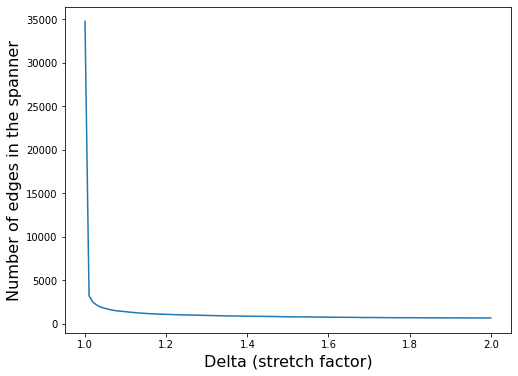

In [153]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=np.arange(1, 2.01, 0.01), y=num_edge_list)
plt.xlabel('Delta (stretch factor)', fontsize=16);
plt.ylabel('Number of edges in the spanner', fontsize=16);

## Graph Spanner Version for approximate optimal utility
\begin{align}
Minimize: \ &\sum_{x, z\in \mathcal{X}} \pi_x k_{xz} d_Q(x, z) \\
Subject\ to:\ & k_{xz} \leq e^{\frac{\epsilon}{\delta} d_G(x, x')} k_{x' z}  & z\in \mathcal{X}, (x, x') \in E  \tag{1} \\
& \sum_{x \in \mathcal{X}} k_{xz} = 1 & x\in\mathcal{X} \tag{2} \\
& k_{xz} \geq 0  &x,z\in \mathcal{X} \tag{3}
\end{align}

**The algorithm we used for constructing the graph spanner is from** <span style="color:gray">*Althöfer, I., Das, G., Dobkin, D. et al. On sparse spanners of weighted graphs. Discrete Comput Geom 9, 81–100 (1993). https://doi.org/10.1007/BF02189308*</span> **implemented by** <span style="color:gray">*Ao Qu, github: https://github.com/quao627/GeoDifferentialPrivacy*</span>


In [73]:
def optql_graph_spanner(x_list, pi_list, spanner, dQ, epsilon=0.5):
    print(f'Start building a linear program for {len(x_list)} locations...')
    pre_prob = np.array(pi_list) / sum(pi_list) # normalize probability distribution
    threshold = math.exp(epsilon / delta)
    
    # define a model
    model = gp.Model('OptQL')
    
    # add variables accessed as (0, 0), (0, 1), (1, 1), ...
    variables = model.addVars(n, n, lb=0.0, ub=1.0, name='k')
    
    # set objective function
    model.setObjective(gp.quicksum(pre_prob[i] * variables[i, j] * dQ(x_list[i], x_list[j]) \
                                   for i in range(n) for j in range(n)), GRB.MINIMIZE)
    
    # add constraints (1)
    print('Adding differential privacy constraints...')
    model.addConstrs(variables[i, k] <= pow(threshold, dQ(x_list[i], x_list[j])) * variables[j, k] \
                     for (i, j) in spanner.edges for k in range(n))
    model.addConstrs(variables[i, k] <= pow(threshold, dQ(x_list[i], x_list[j])) * variables[j, k] \
                     for (j, i) in spanner.edges for k in range(n))
    
    # add constraints (2)
    print('Add probability sum constraints...')
    model.addConstrs(gp.quicksum(variables.select(i, '*')) == 1 for i in range(n))
    
    # constriants (3) are already satisfied
    
    # optimize the model
    model.optimize()
    
    # build a matrix to store the stochastic matrix
    variables = model.getAttr('x', variables)
    matrix = np.zeros((n, n))
    for key, value in variables.items():
        matrix[key] = value
    
    # get post-process probability distribution
    post_prob = pre_prob @ matrix
    
    
    return matrix, pre_prob, post_prob

In [74]:
p_matrix, pre_prob, post_prob = optql_graph_spanner(x_list, pi_list, spanner, dQ, epsilon=epsilon)

Start building a linear program for 263 locations...
Adding differential privacy constraints...
Add probability sum constraints...
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 722461 rows, 69169 columns and 1236889 nonzeros
Model fingerprint: 0x478468b7
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [3e-05, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 138338 rows and 0 columns
Presolve removed 0 rows and 138338 columns
Presolve time: 2.30s
Presolved: 69169 rows, 653292 columns, 1306058 nonzeros

Ordering time: 0.40s

Barrier statistics:
 Dense cols : 263
 Free vars  : 263
 AA' NZ     : 3.611e+05
 Factor NZ  : 5.201e+06 (roughly 300 MBytes of memory)
 Factor Ops : 8.375e+08 (less than 1 second per iteration)
 Threads    : 3

 


Barrier solved model in 95 iterations and 37.27 seconds
Optimal objective 3.08567977e+00

Crossover log...

   12710 DPushes remaining with DInf 1.8303188e-01                38s
    3334 DPushes remaining with DInf 1.7529785e-01                40s
    1371 DPushes remaining with DInf 1.7289629e-01                45s
     477 DPushes remaining with DInf 1.6723214e-01                51s
     127 DPushes remaining with DInf 1.6104527e-01                55s
       0 DPushes remaining with DInf 1.3116419e-01                58s

  300326 PPushes remaining with PInf 4.0751134e-02                58s
  199720 PPushes remaining with PInf 5.1742165e-03                65s
  172453 PPushes remaining with PInf 1.8943377e-03                70s
  123212 PPushes remaining with PInf 1.0140784e-03                73s
  103271 PPushes remaining with PInf 5.9071235e-04                76s
   67155 PPushes remaining with PInf 1.8196838e-04                82s
   45245 PPushes remaining with PInf 1.3676637e-04

<AxesSubplot:>

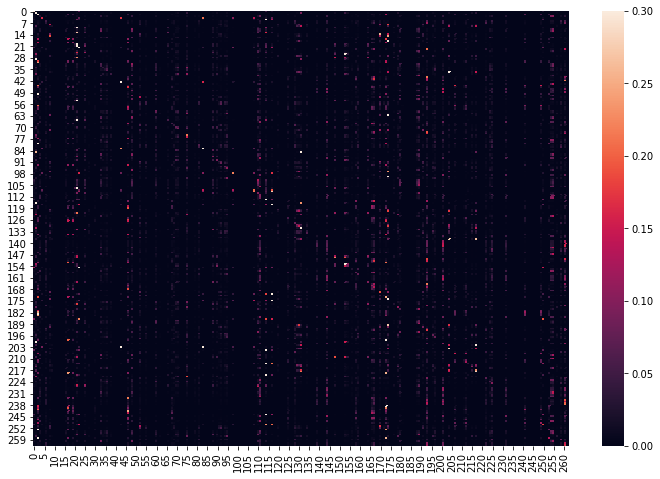

In [107]:
plt.figure(figsize=(12, 8))
sns.heatmap(p_matrix, vmin=0, vmax=0.3)

In [105]:
edges = [(x_list[i], x_list[j]) for i, j in spanner.edges]
edges = list(zip(*edges))
edges = pd.DataFrame({'Source_lon': list(zip(*edges[0]))[1], 
                      'Source_lat': list(zip(*edges[0]))[0], 
                      'Target_lon': list(zip(*edges[1]))[1],
                      'Target_lat': list(zip(*edges[1]))[0]})


map1 = KeplerGl()

prob_diff = post_prob - pre_prob
tmp = zones.copy(deep=True).drop('Centroid', axis=1)
tmp['prob_diff'] = prob_diff
tmp['pre_prob'] = pre_prob
tmp['post_prob'] = post_prob

equalizer = ox.geocode_to_gdf('Beijing, China').iloc[0, 0]
tmp.append(pd.Series(), ignore_index=True)
tmp.loc[len(tmp), 'geometry'] = equalizer
tmp.loc[len(tmp)-1, 'pre_prob'] = max(pre_prob.max(), post_prob.max())
tmp.loc[len(tmp)-2, 'post_prob'] = max(pre_prob.max(), post_prob.max())

map1.add_data(tmp, name='Differential Privacy on Boston Postal Zones')
map1.add_data(edges, name='Edges selected by the spanner')

with open('spanner_comparison_map_config.json', 'r') as f:
    config = json.load(f)
map1.config = config

map1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'oj0unz', 'type': '…

In [ ]:
with open('spanner_comparison_map_config.json', 'w') as f:
    json.dump(map1.config, f)

## Experiments on NYC taxi data
Please replace the data directory by any taxi trip data released by NYC TLS (https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

In [108]:
trips = pd.read_csv('yellow_tripdata_2010-07.csv')

In [119]:
def encrypt_trip(pickup_point, dropoff_point, p_matrix):
    n = p_matrix.shape[0]
    for index, row in zones[['zone', 'geometry']].iterrows():
        geometry = row['geometry']
        if pickup_point.within(geometry):
            pickup_zone = row['zone']
            pickup_index = index
        if dropoff_point.within(geometry):
            dropoff_zone = row['zone']
            dropoff_index = index
    encrypted_pickup_index = np.random.choice(range(n), p=p_matrix[pickup_index])
    encrypted_dropoff_index = np.random.choice(range(n), p=p_matrix[dropoff_index])
    encrypted_pickup_zone = zones.loc[encrypted_pickup_index, 'zone']
    encrypted_dropoff_zone = zones.loc[encrypted_dropoff_index, 'zone']
    print(f"Original OD Pair: {pickup_zone}, {dropoff_zone}, Encryped OD Pair: {encrypted_pickup_zone}, {encrypted_dropoff_zone}")
    return encrypted_pickup_zone, encrypted_dropoff_zone

In [134]:
pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude = tuple(trips.loc[1, ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']])
pickup_point = Point([pickup_longitude, pickup_latitude])
dropoff_point = Point([dropoff_longitude, dropoff_latitude])
encrypt_trip(pickup_point, dropoff_point, p_matrix)

Original OD Pair: Clinton West, Clinton West, Encryped OD Pair: Lenox Hill East, UN/Turtle Bay South


('Lenox Hill East', 'UN/Turtle Bay South')

In [142]:
def find_zone(lon, lat):
    point = Point([lon, lat])
    for index, zone in enumerate(zones['geometry']):
        if point.within(zone):
            return index
    return None

pickup_zones = trips.progress_apply(lambda x: find_zone(x['pickup_longitude'], x['pickup_latitude']), axis=1)

# Questions & Concerns
* How should we determine the prior distribution for the linear program?
* The zones assgined by TLC are probably not fine-grained enough.
* Are there things we need to do to verify the differential privacy algorithm? eg, post-distribution, data utility
* What is the next step after applying this algorithm to nyc taxi dataset?

# Next Step:
* Demand Prediction (OD demand) -> Compare difference